In [55]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from datetime import datetime


module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v11/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg'

if module_path not in sys.path:
    sys.path.append(module_path)

In [56]:
BATCH_SIZE = 256
N_DATA = 4000
T = 20
VOCAB = ['start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 128

## Load Data

In [3]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path, use_init_token=False):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
        
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    
    return et_seqs, ts_seqs

raw_pos_event_type_seqs, raw_pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path, use_init_token=False)

In [4]:
# cast indicator data into one-hot
pos_event_type_seqs = tf.cast(raw_pos_event_type_seqs, tf.int32)
pos_event_type_seqs = tf.one_hot(pos_event_type_seqs, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
pos_event_type_seqs = tf.squeeze(pos_event_type_seqs, axis=3)

In [5]:
def zcore_norm(data):
    N = data.shape[0]
    
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std, _mean[0,:,:], _std[0,:,:]

def get_mean_std(data):
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)

    return _mean, _std

def apply_mean_std(data, _mean, _std):
    N = data.shape[0]
    
    _mean = tf.reshape(_mean, (1, T, 1))
    _mean = tf.repeat(_mean, N, axis=0)
    
    _std = tf.reshape(_std, (1, T, 1))
    _std = tf.repeat(_std, N, axis=0)
    
    return data * _std + _mean

pos_timestamp_seqs, GLOBAL_MEAN, GLOBAL_STD = zcore_norm(raw_pos_timestamp_seqs)

## Global Functions

In [6]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [7]:
def generate_initial_noise(max_token=EVENT_VOCAB_DIM, time_mean=0, time_std=1):
    init_token_noise_index = tf.random.uniform(shape=[BATCH_SIZE, 1, 1], maxval=max_token, dtype=tf.int32)
    init_token_noise = tf.squeeze(tf.one_hot(init_token_noise_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
    init_time_noise = tf.random.truncated_normal(shape=[BATCH_SIZE, 1, 1], mean=time_mean, stddev=time_std, dtype=tf.float64)
    return init_token_noise, init_time_noise

In [8]:
from scipy.linalg import sqrtm

def calculate_FID_batch(batch1, batch2, weight=1, N=4000, T=20):
    batch1, batch2 = np.array(batch1).reshape((N, T)), np.array(batch2).reshape((N, T))
    mu1, sigma1 = batch1.mean(axis=0), np.cov(batch1, rowvar=False)
    mu2, sigma2 = batch2.mean(axis=0), np.cov(batch2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid2 = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid2

calculate_FID_score = lambda batch: calculate_FID_batch(raw_pos_timestamp_seqs, batch)
# calculate_FID_score(raw_pos_timestamp_seqs)

In [26]:
class MAD:
    """ Sum square of one-hot distance between tokens
    Params:
    -- batch1         : The first batch of sequences to be compared with the second one
                        or it can be the comparison base
    -- batch2
    Returns:
    --   : dict, sum square of distances and base medians
    """

    def __init__(self):
        self.base_ssad = []
        self.base_med = []
        self.base_med_oh = []
        self.one_hot_map = {0: [1, 0, 0, 0],
                            1: [0, 1, 0, 0],
                            2: [0, 0, 1, 0],
                            3: [0, 0, 0, 1]}

    def nan_if(self, arr, value):
        return np.where(arr == value, np.nan, arr)

    def fit(self, batch1):
        assert len(batch1) > 1, 'batch1 should have more than one sequence'
        X_tok = []
        for i in batch1:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        self.base_med = medians
        self.base_med_oh = medians_oh
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(medians_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        self.base_ssad = np.mean(tok_dist)

    def compare(self, batch2):
        assert len(batch2) > 1, 'batch2 should have more than one sequence'
        X_tok = []
        for i in batch2:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(self.base_med_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        compare_ssd = np.mean(tok_dist)
        return {'mad': compare_ssd,
                'base_medians': np.array(self.base_med),
                'base_medians_oh': np.array(self.base_med_oh),
                'comp_medians': np.array(medians),
                'comp_medians_oh': np.array(medians_oh)}
    
mad_obj = MAD()
mad_obj.fit(raw_pos_event_type_seqs)
calculate_MAD_score = lambda batch: mad_obj.compare(batch)['mad']
# calculate_MAD_score(raw_pos_event_type_seqs)

def calculate_self_MAD_score(batch):
    self_mad_obj = MAD()
    self_mad_obj.fit(batch)
    return self_mad_obj.compare(batch)['mad']

In [27]:
raw_pos_event_type_seqs.shape

(4000, 20, 1)

In [30]:
EVENT_TYPES = ['A', 'B', 'C', 'D']
EVENT_ENCODE = {'A':0, 'B':1, 'C':2, 'D':3}

MIN_SAME_DELAY = 20
MAX_PAIR_DELAY = 200


def check_min_delay_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]
    prev_et, _ = None, 0.0
    for et, dt in seq:
        if et == prev_et and dt < MIN_SAME_DELAY:
            return False
        prev_et = et
    return True

def check_paring_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]    
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif seq[i][0] == EVENT_ENCODE['C'] and queue: # encounter a C event
            queue.pop(0)
    return len(queue) == 0

def check_max_delay_rule(seq, use_init_token=False):    
    if use_init_token:
        seq = seq[1:]    
        
    def recover_timedelta_to_timestamp(time_seq):
        csum = []
        curr = 0
        for dt in time_seq:
            if dt != 0:
                curr += dt
                csum.append(curr)
            else:
                csum.append(0)
        return csum
    
    ets = [e[0] for e in seq]
    tss = recover_timedelta_to_timestamp([e[1] for e in seq])
        
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if ets[i] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif ets[i] == EVENT_ENCODE['C'] and queue: # encounter a C event
            if tss[queue[0]] - tss[i] <= MAX_PAIR_DELAY:
                queue.pop(0)
            else:
                return False
    # for rule 6, it's fine if there are unpaired D in queue
    # b/c this rules is to ensure for each paired (C, D), the delay is bounded
    return True


def calculate_rule_score(batch):
    N_batch = batch.shape[0]
    cnt = 0
    for i in range(N_batch):
        seq = batch[i, :, :]
        if check_min_delay_rule(seq) and check_paring_rule(seq) and check_max_delay_rule(seq):
            cnt += 1    
    return cnt / N_batch

# calculate_rule_score(batch)

## Create multitype SeqGan

In [31]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # inputs of Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)

    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    
    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_combined = Dense(hidden_dim, 
                           activation='elu',
                           name='dense_combination')(token_time_comb)
        
    token_logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_token',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
        
    time_delta_out = Dense(1,
                   activation='linear',
                   name='dense_time',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_logits, time_delta_out])
        
    return generator

In [32]:
def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=False, # stateless, never input a partial sequnce for D
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=False, # stateless, never input a partial sequnce for D
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=prob)
    return discriminator

## Define rollout and sequence generation

In [33]:
def sample_gumbel(shape, eps=1e-20): 
    U = tf.random.uniform(shape,minval=0,maxval=1)   #gumbel noise
#     print('noise:{}'.format(U))
    return -tf.math.log(-tf.math.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature=0.5): 
    y = logits + tf.cast(sample_gumbel(tf.shape(logits)), logits.dtype)
    return tf.nn.softmax( y / temperature)  # use softmax to approximate argmax

def gumbel_softmax(logits, temperature=0.5, hard=True):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    logits = tf.cast(logits, tf.float64)
    y = gumbel_softmax_sample(logits, temperature) # this is differentiable
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keepdims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y


In [34]:
def rollout_from_initial_gumbel(G, batch_size, init_et, init_ts, L=T):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = init_et
    all_state_ts = init_ts
    
    l_prefix = init_et.shape[1]
    
    G.reset_states()
    # LSTM-token
    G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    # LSTM-time
    G.layers[5].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    G.layers[5].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    
    # Time-LSTM
#     G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))

    for _ in range(L + 1 - l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        curr_state_ts = all_state_ts[:, -1:, :]
        
        # add step noise to token and time inputs
#         curr_state_et = tf.cast(tf.where(curr_state_et == 1, 0.9, 0.1/3), tf.float64)
#         curr_state_ts = curr_state_ts + tf.random.normal(shape=tf.shape(curr_state_ts), mean=0.0, stddev=1, dtype=tf.float64)

        token_logits, time_delta_out = G([curr_state_et, curr_state_ts])
        
        # sample event types using Gumbel-softmax
        sampled_et = gumbel_softmax(token_logits, temperature=0.9)  # this is differentiable
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, EVENT_VOCAB_DIM])        
        sampled_et = tf.cast(sampled_et, dtype=tf.float64) # cast sampled_et into float
        
        time_delta_out = tf.reshape(time_delta_out, [batch_size, 1, 1]) 
        
        # Do NOT stop genererating once hit end_token; G is supposed to learn it.
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)
        all_state_ts = tf.concat([all_state_ts, time_delta_out], axis=1)

    # the initlal random states are excluded in output
    return all_state_et[:, 1:, :], all_state_ts[:, 1:, :]


def generate_sequences_gumbel(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    all_time_seq = None
    
    init_token_noise, init_time_noise = generate_initial_noise()
        
    while N < N_gen:
        batch_state_et, batch_state_ts = rollout_from_initial_gumbel(generator, batch_size, init_token_noise, init_time_noise, T)

        if all_type_seq is None or all_time_seq is None:
            all_type_seq = batch_state_et
            all_time_seq = batch_state_ts
        else:
            all_type_seq = tf.concat([all_type_seq, batch_state_et], axis=0)
            all_time_seq = tf.concat([all_time_seq, batch_state_ts], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]
    all_time_seq = all_time_seq[:N_gen, :, :]

    return all_type_seq, all_time_seq

## Pre-Training of Gumbel-Softmax SeqGan

In [35]:
def pretrain_discriminator(event_type_batch, time_delta_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator([event_type_batch, time_delta_batch])

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, time_delta_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape
    
    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        step_token_ce_loss_list = []
        step_time_mxe_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            curr_state_ts = time_delta_batch[:, i:i + 1, :]
            
            target_et = event_type_batch[:, i + 1, :]
            target_ts = time_delta_batch[:, i + 1, :]            
            
            token_logits, time_delta_out = generator([curr_state_et, curr_state_ts])

            token_ce_losses = tf.keras.losses.categorical_crossentropy(target_et, token_logits, from_logits=True)
            token_ce_loss = tf.reduce_mean(token_ce_losses)
            step_token_ce_loss_list.append(token_ce_loss)
            
            time_mxe_losses = tf.keras.losses.MAE(target_ts, time_delta_out)
            time_mxe_loss = tf.reduce_mean(time_mxe_losses)
            step_time_mxe_loss_list.append(time_mxe_loss)                        
    
        episode_token_ce_loss = tf.reduce_mean(step_token_ce_loss_list)
        episode_time_mxe_loss = tf.reduce_mean(step_time_mxe_loss_list)
        generator_loss = episode_token_ce_loss + episode_time_mxe_loss

    if verbose:
        print('token ce loss:{}'.format(episode_token_ce_loss))
        print('time mae loss:{}'.format(episode_time_mxe_loss))
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

### pre-train G

In [36]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 3
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)
_TOTAL_STEPS

46

In [37]:
pretrain_gen_loss_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [38]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)
        
    gen_loss =  pretrain_generator(event_type_batch, time_delta_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_loss_history.append(gen_loss.numpy())

  0%|          | 0/46 [00:00<?, ?it/s]

Training Step: 1
token ce loss:1.4005026924077393
time mae loss:0.8197098738508694
train loss:2.2202125662586085


  2%|▏         | 1/46 [00:01<01:19,  1.76s/it]

Training Step: 2
token ce loss:1.3599124944207928
time mae loss:0.7816128723034182
train loss:2.141525366724211


  4%|▍         | 2/46 [00:03<01:16,  1.74s/it]

Training Step: 3
token ce loss:1.3478333836595089
time mae loss:0.800043749237718
train loss:2.147877132897227


  7%|▋         | 3/46 [00:05<01:14,  1.73s/it]

Training Step: 4
token ce loss:1.3539006165656622
time mae loss:0.8012922714086018
train loss:2.155192887974264


  9%|▊         | 4/46 [00:06<01:11,  1.71s/it]

Training Step: 5
token ce loss:1.3636847839897328
time mae loss:0.7861527331108634
train loss:2.1498375171005963


 11%|█         | 5/46 [00:08<01:07,  1.65s/it]

Training Step: 6
token ce loss:1.3637004092365124
time mae loss:0.8002327468711169
train loss:2.163933156107629


 13%|█▎        | 6/46 [00:10<01:07,  1.69s/it]

Training Step: 7
token ce loss:1.3482427155519134
time mae loss:0.7894244084393851
train loss:2.1376671239912985


 15%|█▌        | 7/46 [00:11<01:06,  1.71s/it]

Training Step: 8
token ce loss:1.336258442910518
time mae loss:0.7733861057031092
train loss:2.1096445486136273


 17%|█▋        | 8/46 [00:13<01:04,  1.69s/it]

Training Step: 9
token ce loss:1.3326720240770502
time mae loss:0.7899060077133457
train loss:2.122578031790396


 20%|█▉        | 9/46 [00:15<01:01,  1.66s/it]

Training Step: 10
token ce loss:1.3281179391287286
time mae loss:0.7785329224457705
train loss:2.106650861574499


 22%|██▏       | 10/46 [00:16<00:59,  1.65s/it]

Training Step: 11
token ce loss:1.3305570720128315
time mae loss:0.7982217852567812
train loss:2.1287788572696127


 24%|██▍       | 11/46 [00:18<00:58,  1.68s/it]

Training Step: 12
token ce loss:1.3269601664624915
time mae loss:0.7808752713049532
train loss:2.1078354377674446


 26%|██▌       | 12/46 [00:20<00:57,  1.68s/it]

Training Step: 13
token ce loss:1.3253897038801903
time mae loss:0.773841250423483
train loss:2.0992309543036733


 28%|██▊       | 13/46 [00:21<00:56,  1.70s/it]

Training Step: 14
token ce loss:1.3264055384735616
time mae loss:0.7878104580855482
train loss:2.1142159965591096


 30%|███       | 14/46 [00:23<00:53,  1.67s/it]

Training Step: 15
token ce loss:1.3230684577220644
time mae loss:0.7790562147461129
train loss:2.102124672468177


 33%|███▎      | 15/46 [00:25<00:52,  1.69s/it]

Training Step: 16
token ce loss:1.3210130758921306
time mae loss:0.7811566690702115
train loss:2.102169744962342


 35%|███▍      | 16/46 [00:27<00:51,  1.71s/it]

Training Step: 17
token ce loss:1.3187132969676127
time mae loss:0.7819567220365936
train loss:2.1006700190042062


 37%|███▋      | 17/46 [00:28<00:50,  1.73s/it]

Training Step: 18
token ce loss:1.316444750212444
time mae loss:0.7780862938260493
train loss:2.094531044038493


 39%|███▉      | 18/46 [00:30<00:48,  1.73s/it]

Training Step: 19
token ce loss:1.3174401484677856
time mae loss:0.7778533784849324
train loss:2.0952935269527178


 41%|████▏     | 19/46 [00:32<00:45,  1.68s/it]

Training Step: 20
token ce loss:1.3104935079987703
time mae loss:0.7670219861076145
train loss:2.0775154941063847


 43%|████▎     | 20/46 [00:33<00:42,  1.65s/it]

Training Step: 21
token ce loss:1.3136857362278629
time mae loss:0.7866556888557716
train loss:2.1003414250836343


 46%|████▌     | 21/46 [00:35<00:42,  1.68s/it]

Training Step: 22
token ce loss:1.3042782505936839
time mae loss:0.7778926533982586
train loss:2.0821709039919423


 48%|████▊     | 22/46 [00:37<00:39,  1.64s/it]

Training Step: 23
token ce loss:1.307566495025036
time mae loss:0.774645000077281
train loss:2.082211495102317


 50%|█████     | 23/46 [00:38<00:37,  1.63s/it]

Training Step: 24
token ce loss:1.3080310726395858
time mae loss:0.7825379803324523
train loss:2.090569052972038


 52%|█████▏    | 24/46 [00:40<00:35,  1.60s/it]

Training Step: 25
token ce loss:1.304871159250592
time mae loss:0.7764798538444907
train loss:2.0813510130950825


 54%|█████▍    | 25/46 [00:41<00:33,  1.61s/it]

Training Step: 26
token ce loss:1.298803217109974
time mae loss:0.7702783072342093
train loss:2.0690815243441834


 57%|█████▋    | 26/46 [00:43<00:32,  1.63s/it]

Training Step: 27
token ce loss:1.304486039425962
time mae loss:0.7793137441523129
train loss:2.083799783578275


 59%|█████▊    | 27/46 [00:45<00:30,  1.62s/it]

Training Step: 28
token ce loss:1.2986983602620545
time mae loss:0.7795026819060787
train loss:2.0782010421681334


 61%|██████    | 28/46 [00:46<00:29,  1.62s/it]

Training Step: 29
token ce loss:1.3014875731007474
time mae loss:0.798788496477955
train loss:2.1002760695787024


 63%|██████▎   | 29/46 [00:48<00:27,  1.61s/it]

Training Step: 30
token ce loss:1.2971188668765705
time mae loss:0.7868076803359768
train loss:2.083926547212547


 65%|██████▌   | 30/46 [00:49<00:26,  1.63s/it]

Training Step: 31
token ce loss:1.296077994050792
time mae loss:0.7752082723124737
train loss:2.071286266363266


 67%|██████▋   | 31/46 [00:51<00:24,  1.61s/it]

Training Step: 32
token ce loss:1.296513803381563
time mae loss:0.7720161349179641
train loss:2.0685299382995272


 70%|██████▉   | 32/46 [00:52<00:21,  1.50s/it]

Training Step: 33
token ce loss:1.2947586162194
time mae loss:0.7806133571350736
train loss:2.0753719733544735


 72%|███████▏  | 33/46 [00:54<00:20,  1.58s/it]

Training Step: 34
token ce loss:1.2950345271545052
time mae loss:0.7783439675377429
train loss:2.073378494692248


 74%|███████▍  | 34/46 [00:56<00:19,  1.63s/it]

Training Step: 35
token ce loss:1.2905645428938202
time mae loss:0.762016174478224
train loss:2.0525807173720443


 76%|███████▌  | 35/46 [00:57<00:18,  1.65s/it]

Training Step: 36
token ce loss:1.297634666739157
time mae loss:0.7880358357072024
train loss:2.0856705024463595


 78%|███████▊  | 36/46 [00:59<00:16,  1.65s/it]

Training Step: 37
token ce loss:1.290373047073954
time mae loss:0.784382669412426
train loss:2.07475571648638


 80%|████████  | 37/46 [01:01<00:15,  1.67s/it]

Training Step: 38
token ce loss:1.2879715013587012
time mae loss:0.7713194932605513
train loss:2.0592909946192526


 83%|████████▎ | 38/46 [01:02<00:13,  1.66s/it]

Training Step: 39
token ce loss:1.292424390345903
time mae loss:0.7877221220291717
train loss:2.080146512375075


 85%|████████▍ | 39/46 [01:04<00:11,  1.64s/it]

Training Step: 40
token ce loss:1.2888440399206185
time mae loss:0.7662494974824103
train loss:2.055093537403029


 87%|████████▋ | 40/46 [01:06<00:09,  1.63s/it]

Training Step: 41
token ce loss:1.290874264302672
time mae loss:0.7854013752037554
train loss:2.0762756395064272


 89%|████████▉ | 41/46 [01:07<00:08,  1.64s/it]

Training Step: 42
token ce loss:1.2869342561005894
time mae loss:0.7741694566873238
train loss:2.0611037127879133


 91%|█████████▏| 42/46 [01:09<00:06,  1.63s/it]

Training Step: 43
token ce loss:1.2848857611380502
time mae loss:0.7809706772527392
train loss:2.0658564383907896


 93%|█████████▎| 43/46 [01:11<00:04,  1.66s/it]

Training Step: 44
token ce loss:1.2860587243756603
time mae loss:0.7777313521926147
train loss:2.063790076568275


 96%|█████████▌| 44/46 [01:12<00:03,  1.67s/it]

Training Step: 45
token ce loss:1.2826132860985566
time mae loss:0.7883534766618545
train loss:2.070966762760411


 98%|█████████▊| 45/46 [01:14<00:01,  1.70s/it]

Training Step: 46
token ce loss:1.2856089235131294
time mae loss:0.7749191525933629
train loss:2.0605280761064924


100%|██████████| 46/46 [01:16<00:00,  1.66s/it]


In [39]:
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [40]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf.concat_2 (TFOpLambda)        (256, None, 17)      0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]        

### pre-train D

In [41]:
N_fake_D = N_real_D = N_total_G 

In [42]:
# generate fake data by G to pre-train D
fake_pos_event_type_seqs, fake_pos_timestamp_seqs = generate_sequences_gumbel(N_fake_D, pretrained_generator, BATCH_SIZE, T)

In [43]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]
real_pos_timestamp_seqs = pos_timestamp_seqs[0:N_real_D, :, :]

In [44]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_ts = tf.concat([fake_pos_timestamp_seqs, real_pos_timestamp_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset((pretrain_D_et, pretrain_D_ts),
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [45]:
pretrain_disc_token_loss_history = []

pretrained_discriminator = build_D(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   hidden_dim=HIDDEN_DIM,    
                                   dropout_rate=0.25)

In [46]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
_TOTAL_STEPS = 10

for feature_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, time_delta_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

Training Step: 1
total discriminator loss:0.6852655728077877


 10%|█         | 1/10 [00:01<00:09,  1.06s/it]

Training Step: 2
total discriminator loss:0.6751735702234737


 20%|██        | 2/10 [00:01<00:07,  1.02it/s]

Training Step: 3
total discriminator loss:0.6477110007835989


 30%|███       | 3/10 [00:02<00:06,  1.02it/s]

Training Step: 4
total discriminator loss:0.6439368222860292


 40%|████      | 4/10 [00:03<00:05,  1.03it/s]

Training Step: 5
total discriminator loss:0.6386896219375696


 50%|█████     | 5/10 [00:04<00:04,  1.03it/s]

Training Step: 6
total discriminator loss:0.6098202288818964


 60%|██████    | 6/10 [00:05<00:03,  1.05it/s]

Training Step: 7
total discriminator loss:0.5860255834536605


 70%|███████   | 7/10 [00:06<00:02,  1.05it/s]

Training Step: 8
total discriminator loss:0.5958838772417366


 80%|████████  | 8/10 [00:07<00:01,  1.03it/s]

Training Step: 9
total discriminator loss:0.561089137645149


 90%|█████████ | 9/10 [00:08<00:00,  1.05it/s]

Training Step: 10
total discriminator loss:0.5126711082981158


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


In [47]:
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [48]:
reload_pretrained_disc = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf.concat_4 (TFOpLambda)        (256, None, 17)      0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]        

## Gumbel  Traning

In [49]:
import tensorflow as tf
import tensorflow.keras.backend as K
keras = tf.keras

class HistoricalAvgLoss(object):
    def __init__(self, model):
        # create tensors (initialized to zero) to hold the previous value of the
        # weights
        self.model = model
        self.prev_weights = []
        for w in model.get_weights():
            self.prev_weights.append(K.variable(np.zeros(w.shape)))

    def loss(self, y_true, y_pred, from_logits=True):
        err = keras.losses.binary_crossentropy(y_true, y_pred, from_logits=from_logits)
#         err = tf.cast(y_true, tf.float64) * y_pred  # WGAN loss
        werr = [K.mean(K.square(c - p)) for c, p in zip(self.model.get_weights(), self.prev_weights)]
        self.prev_weights = \
            [K.update(p, c) for c, p in zip(self.model.get_weights(), self.prev_weights)]
        return err + K.sum(werr)


In [50]:
def train_generator_gumbel(generator, discriminator, batch_size, T, verbose=False,                   
                    optimizer=Adam(lr=0.001), loss_obj=None):
    
    assert loss_obj is not None
    with tf.GradientTape() as tape:                        

        G_sample_et, G_sample_ts = generate_sequences_gumbel(batch_size, generator, batch_size, T)
        D_fake = discriminator([G_sample_et, G_sample_ts])

#         generator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(D_fake), D_fake))
        generator_loss =  tf.reduce_mean(loss_obj.loss(tf.ones_like(D_fake), D_fake))
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss


def train_discriminator_gumbel(real_data_batch_et, real_data_batch_ts, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001), label_smoothing=False, label_flipping=False, loss_obj=None):

    assert loss_obj is not None
    # data prep
    real_labels = tf.ones((batch_size//2, 1))        
    fake_labels = tf.zeros((batch_size//2, 1))    
    
    real_data_batch_et, real_data_batch_ts = real_data_batch_et[:batch_size//2, :, :], real_data_batch_ts[:batch_size//2, :, :]    
    fake_data_batch_et, fake_data_batch_ts = generate_sequences_gumbel(batch_size//2, generator, batch_size, T)
    
    if label_smoothing:
        fake_labels = fake_labels + tf.random.normal(fake_labels.shape, mean=0, stddev=0.3)
        fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)

        real_labels = real_labels + tf.random.normal(real_labels.shape, mean=0, stddev=0.3)
        real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)

    if label_flipping:
        if tf.random.uniform((1,)) < 0.05:
            fake_labels, real_labels = real_labels, fake_labels
    
    total_data_et = tf.concat([fake_data_batch_et, real_data_batch_et], axis=0)
    total_data_ts = tf.concat([fake_data_batch_ts, real_data_batch_ts], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)        
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator([total_data_et, total_data_ts])

        # cross-entropy loss
#         discriminator_loss = tf.reduce_mean(
#             tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))
        
        discriminator_loss = tf.reduce_mean(loss_obj.loss(total_labels, pred_prob, from_logits=False))
        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [57]:
def track_training(step, G, save_path=None, verbose=True, plot=True):
    _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(N_DATA, G, BATCH_SIZE, T)
    
    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))
    
    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)

    if verbose:
        print('event_types:', _gen_seqs_et_ind[0,:, :].squeeze().tolist())
        print('mad_score:', _mad_score)
        print('fid_score:', _fid_score)
        print('rule_score:', _rule_score)

    if plot:
        plt.figure()
        x = np.arange(_gen_seqs_et[0,:,:].shape[0])
        y = _gen_seqs_ts[0,:,:]
        plt.plot(x, y)
        plt.title(f'wave shape after {step} steps')
        plt.show()

    if save_path:     
        G_save_path = os.path.join(save_path, f'G_{step}', 'model_weights.tf')
        G.save_weights(G_save_path)
        print('G saved to:', G_save_path)

        D_save_path = os.path.join(save_path, f'D_{step}', 'model_weights.tf')
        D.save_weights(D_save_path)
        print('D saved to:', D_save_path)
        
    return _mad_score, _fid_score, _rule_score

In [61]:
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

D = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(D_save_path)
D.summary()

historical_avg_G = HistoricalAvgLoss(G)
historical_avg_D = HistoricalAvgLoss(D)

assert historical_avg_G.model is G
assert historical_avg_D.model is D

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf.concat_11 (TFOpLambda)       (256, None, 17)      0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

In [62]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 100
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)


train_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []
average_true_return_history = []
mad_history = []
fid_history = []
rule_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-4)
D_optimizer = Adam(learning_rate=1e-4)

_G_STEPS = 1
_D_STEPS = 1

now_str = datetime.strftime(datetime.now(), format='%Y-%m-%d-%H-%M-%S')
model_save_path = os.path.join(model_save_dir, now_str)
print(model_save_path)
print(_TOTAL_STEPS)

/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36
1562


  0%|          | 0/1562 [00:00<?, ?it/s]

Training Step: 0
event_types: [2, 2, 2, 3, 2, 0, 0, 2, 1, 0, 2, 1, 2, 0, 1, 0, 3, 0, 1, 2]
mad_score: 0.6347125
fid_score: 9748.476517517445
rule_score: 0.49975


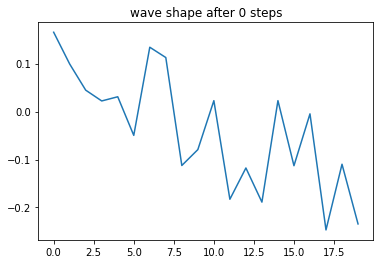

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_0/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_0/model_weights.tf
generator loss:1.968716708511848
-----------------------
total discriminator loss:1.2256280833863487
average true return:0.46622447101060727
-----------------------


  0%|          | 1/1562 [00:27<12:07:53, 27.98s/it]

Training Step: 1
generator loss:1.0908836890251294
-----------------------
total discriminator loss:0.5802973308757118
average true return:0.48974937675454144
-----------------------


  0%|          | 2/1562 [00:32<6:15:54, 14.46s/it] 

Training Step: 2
generator loss:1.0145427260849196
-----------------------
total discriminator loss:0.611943362129352
average true return:0.4782987822092368
-----------------------


  0%|          | 3/1562 [00:37<4:21:34, 10.07s/it]

Training Step: 3
generator loss:0.9947894960337316
-----------------------
total discriminator loss:0.6201281723745233
average true return:0.5123656271718735
-----------------------


  0%|          | 4/1562 [00:42<3:25:46,  7.92s/it]

Training Step: 4
generator loss:0.8837484911211362
-----------------------
total discriminator loss:0.6461007652571307
average true return:0.5351825281847862
-----------------------


  0%|          | 5/1562 [00:47<2:56:41,  6.81s/it]

Training Step: 5
event_types: [3, 3, 2, 1, 3, 2, 0, 1, 2, 1, 3, 1, 2, 1, 3, 2, 1, 2, 3, 1]
mad_score: 0.629525
fid_score: 9491.213744660457
rule_score: 0.498


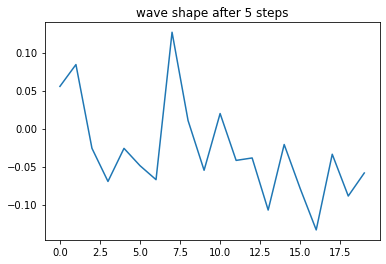

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_5/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_5/model_weights.tf
generator loss:0.8409135929683572
-----------------------
total discriminator loss:0.6676592109773822
average true return:0.5210963723128683
-----------------------


  0%|          | 6/1562 [01:13<5:45:32, 13.32s/it]

Training Step: 6
generator loss:0.8507008633058915
-----------------------
total discriminator loss:0.6596618371735601
average true return:0.5474645521676922
-----------------------


  0%|          | 7/1562 [01:18<4:34:51, 10.61s/it]

Training Step: 7
generator loss:0.8005857191234658
-----------------------
total discriminator loss:0.6830635457958986
average true return:0.5387314878246521
-----------------------


  1%|          | 8/1562 [01:23<3:48:42,  8.83s/it]

Training Step: 8
generator loss:0.7998481701241765
-----------------------
total discriminator loss:0.7456574461995641
average true return:0.5137108509684069
-----------------------


  1%|          | 9/1562 [01:28<3:17:41,  7.64s/it]

Training Step: 9
generator loss:0.7795052473789792
-----------------------
total discriminator loss:0.7813569294750282
average true return:0.5226787020435557
-----------------------


  1%|          | 10/1562 [01:33<2:57:14,  6.85s/it]

Training Step: 10
event_types: [0, 1, 1, 2, 1, 2, 1, 2, 3, 1, 2, 1, 2, 1, 2, 2, 3, 0, 1, 2]
mad_score: 0.62025
fid_score: 9808.990288045508
rule_score: 0.48525


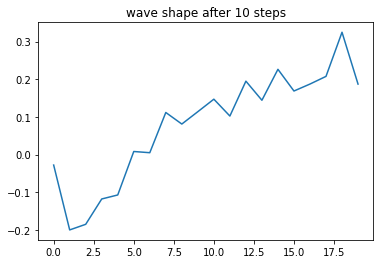

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_10/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_10/model_weights.tf
generator loss:0.7516753427344949
-----------------------
total discriminator loss:0.7662537212134057
average true return:0.5082500588434431
-----------------------


  1%|          | 11/1562 [02:00<5:35:50, 12.99s/it]

Training Step: 11
generator loss:0.748687761791559
-----------------------
total discriminator loss:0.7811159259464824
average true return:0.5062974948475099
-----------------------


  1%|          | 12/1562 [02:05<4:31:03, 10.49s/it]

Training Step: 12
generator loss:0.7102811126198546
-----------------------
total discriminator loss:0.7214238655622994
average true return:0.530744585021786
-----------------------


  1%|          | 13/1562 [02:10<3:47:54,  8.83s/it]

Training Step: 13
generator loss:0.6783853529439956
-----------------------
total discriminator loss:0.8035347078549533
average true return:0.49125749867953533
-----------------------


  1%|          | 14/1562 [02:14<3:16:49,  7.63s/it]

Training Step: 14
generator loss:0.6663707159304348
-----------------------
total discriminator loss:0.826793058721948
average true return:0.5116990367516026
-----------------------


  1%|          | 15/1562 [02:19<2:56:34,  6.85s/it]

Training Step: 15
event_types: [3, 0, 1, 2, 1, 1, 1, 2, 1, 0, 2, 0, 2, 2, 1, 3, 2, 0, 0, 1]
mad_score: 0.614625
fid_score: 10696.581158448758
rule_score: 0.5055


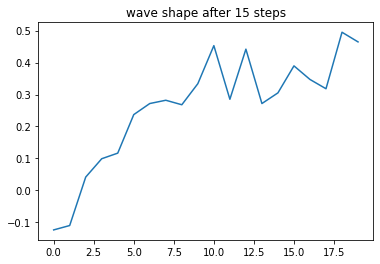

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_15/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_15/model_weights.tf
generator loss:0.6621114802729084
-----------------------
total discriminator loss:0.9001874207991956
average true return:0.49576194239057786
-----------------------


  1%|          | 16/1562 [02:46<5:26:29, 12.67s/it]

Training Step: 16
generator loss:0.6461775402118091
-----------------------
total discriminator loss:0.8526209117934276
average true return:0.4974639033517667
-----------------------


  1%|          | 17/1562 [02:50<4:24:47, 10.28s/it]

Training Step: 17
generator loss:0.644806430314218
-----------------------
total discriminator loss:0.9003826702465618
average true return:0.4858964481840564
-----------------------


  1%|          | 18/1562 [02:55<3:38:04,  8.47s/it]

Training Step: 18
generator loss:0.608459478637736
-----------------------
total discriminator loss:0.8942169312502375
average true return:0.49258692696771567
-----------------------


  1%|          | 19/1562 [03:00<3:10:32,  7.41s/it]

Training Step: 19
generator loss:0.597388163994836
-----------------------
total discriminator loss:0.9083198341432919
average true return:0.4905772200966336
-----------------------


  1%|▏         | 20/1562 [03:05<2:51:34,  6.68s/it]

Training Step: 20
event_types: [3, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 3, 1, 0, 1, 2, 2, 1, 3, 1]
mad_score: 0.6023625
fid_score: 12263.07508029068
rule_score: 0.475


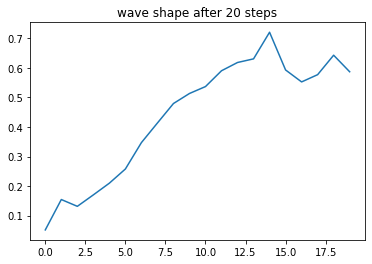

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_20/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_20/model_weights.tf
generator loss:0.5812974239731283
-----------------------
total discriminator loss:0.9245947732259738
average true return:0.4887514703259691
-----------------------


  1%|▏         | 21/1562 [03:32<5:31:06, 12.89s/it]

Training Step: 21
generator loss:0.5895742422033721
-----------------------
total discriminator loss:0.9271881578267567
average true return:0.4828742007876962
-----------------------


  1%|▏         | 22/1562 [03:37<4:31:04, 10.56s/it]

Training Step: 22
generator loss:0.5700409255334673
-----------------------
total discriminator loss:0.9680898439963807
average true return:0.4873675211391267
-----------------------


  1%|▏         | 23/1562 [03:42<3:46:46,  8.84s/it]

Training Step: 23
generator loss:0.5602088204617546
-----------------------
total discriminator loss:0.5274421918247452
average true return:0.4696704285081258
-----------------------


  2%|▏         | 24/1562 [03:47<3:15:12,  7.62s/it]

Training Step: 24
generator loss:0.5601661770145026
-----------------------
total discriminator loss:0.9629114332443949
average true return:0.48951043040240516
-----------------------


  2%|▏         | 25/1562 [03:52<2:54:03,  6.79s/it]

Training Step: 25
event_types: [2, 0, 1, 2, 2, 0, 1, 3, 0, 1, 0, 2, 2, 3, 2, 0, 2, 1, 0, 2]
mad_score: 0.59205
fid_score: 14569.366354129328
rule_score: 0.48975


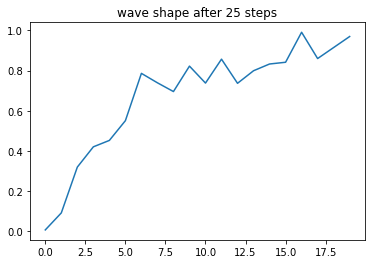

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_25/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_25/model_weights.tf
generator loss:0.5351533621859719
-----------------------
total discriminator loss:0.9717849703791546
average true return:0.48695365656941597
-----------------------


  2%|▏         | 26/1562 [04:18<5:21:50, 12.57s/it]

Training Step: 26
generator loss:0.5109180846419739
-----------------------
total discriminator loss:0.9784975221902228
average true return:0.48890738184376925
-----------------------


  2%|▏         | 27/1562 [04:22<4:22:36, 10.26s/it]

Training Step: 27
generator loss:0.5120388315551071
-----------------------
total discriminator loss:0.9673371889467546
average true return:0.4952116281537142
-----------------------


  2%|▏         | 28/1562 [04:27<3:40:16,  8.62s/it]

Training Step: 28
generator loss:0.4857168788279624
-----------------------
total discriminator loss:0.9756043922229913
average true return:0.4953157046271677
-----------------------


  2%|▏         | 29/1562 [04:32<3:12:24,  7.53s/it]

Training Step: 29
generator loss:0.5139015091064201
-----------------------
total discriminator loss:0.9921442192539464
average true return:0.502494251999722
-----------------------


  2%|▏         | 30/1562 [04:37<2:51:03,  6.70s/it]

Training Step: 30
event_types: [3, 1, 0, 1, 0, 2, 1, 1, 2, 2, 1, 2, 3, 2, 1, 0, 2, 2, 3, 2]
mad_score: 0.582075
fid_score: 17722.959465138243
rule_score: 0.49425


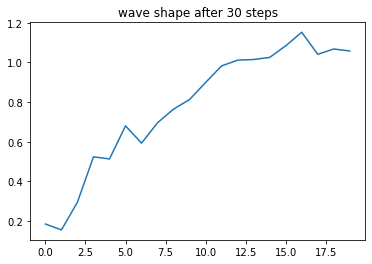

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_30/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_30/model_weights.tf
generator loss:0.48714798682408367
-----------------------
total discriminator loss:0.9871069490871089
average true return:0.49401619159224786
-----------------------


  2%|▏         | 31/1562 [05:02<5:13:57, 12.30s/it]

Training Step: 31
generator loss:0.4941285193276598
-----------------------
total discriminator loss:0.9763155644789169
average true return:0.4953823373894237
-----------------------


  2%|▏         | 32/1562 [05:07<4:17:18, 10.09s/it]

Training Step: 32
generator loss:0.5059132639473606
-----------------------
total discriminator loss:0.9563866811093741
average true return:0.49926570987255364
-----------------------


  2%|▏         | 33/1562 [05:12<3:38:20,  8.57s/it]

Training Step: 33
generator loss:0.49193196088729296
-----------------------
total discriminator loss:0.9493801154327204
average true return:0.49513393558757907
-----------------------


  2%|▏         | 34/1562 [05:17<3:08:46,  7.41s/it]

Training Step: 34
generator loss:0.4939696047893751
-----------------------
total discriminator loss:0.9440239821778021
average true return:0.49599254503766027
-----------------------


  2%|▏         | 35/1562 [05:22<2:50:16,  6.69s/it]

Training Step: 35
event_types: [0, 0, 2, 1, 0, 1, 2, 3, 2, 2, 3, 2, 0, 1, 2, 0, 2, 0, 2, 2]
mad_score: 0.5707
fid_score: 21895.311212319135
rule_score: 0.4615


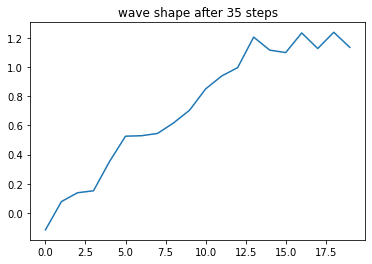

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_35/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_35/model_weights.tf
generator loss:0.5120266095395651
-----------------------
total discriminator loss:0.9452549263549772
average true return:0.4987847502241032
-----------------------


  2%|▏         | 36/1562 [05:49<5:25:10, 12.79s/it]

Training Step: 36
generator loss:0.5102506095023214
-----------------------
total discriminator loss:0.9152000759202563
average true return:0.4977176769843101
-----------------------


  2%|▏         | 37/1562 [05:54<4:24:18, 10.40s/it]

Training Step: 37
generator loss:0.5236436724510423
-----------------------
total discriminator loss:0.914562191873444
average true return:0.4929188523240283
-----------------------


  2%|▏         | 38/1562 [05:59<3:40:17,  8.67s/it]

Training Step: 38
generator loss:0.542161860809915
-----------------------
total discriminator loss:0.9007049572500065
average true return:0.4894899452742574
-----------------------


  2%|▏         | 39/1562 [06:03<3:11:46,  7.56s/it]

Training Step: 39
generator loss:0.5530730787879774
-----------------------
total discriminator loss:0.8681832853315883
average true return:0.4896325096211123
-----------------------


  3%|▎         | 40/1562 [06:08<2:51:11,  6.75s/it]

Training Step: 40
event_types: [0, 2, 2, 0, 2, 2, 2, 1, 2, 3, 2, 2, 2, 3, 1, 2, 2, 2, 3, 2]
mad_score: 0.553625
fid_score: 27099.382407374418
rule_score: 0.4695


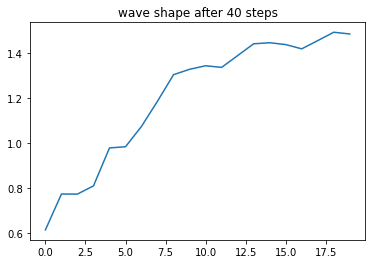

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_40/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_40/model_weights.tf
generator loss:0.5547867571956364
-----------------------
total discriminator loss:0.8708665636883717
average true return:0.48906822100121766
-----------------------


  3%|▎         | 41/1562 [06:35<5:23:39, 12.77s/it]

Training Step: 41
generator loss:0.5747039537000487
-----------------------
total discriminator loss:0.8486258001487406
average true return:0.48892760114425826
-----------------------


  3%|▎         | 42/1562 [06:40<4:23:50, 10.41s/it]

Training Step: 42
generator loss:0.584201969750514
-----------------------
total discriminator loss:0.8353958110377648
average true return:0.48786749659474404
-----------------------


  3%|▎         | 43/1562 [06:45<3:39:10,  8.66s/it]

Training Step: 43
generator loss:0.6132979940319279
-----------------------
total discriminator loss:0.8154917281433037
average true return:0.4846320615485637
-----------------------


  3%|▎         | 44/1562 [06:50<3:10:36,  7.53s/it]

Training Step: 44
generator loss:0.6249813862581364
-----------------------
total discriminator loss:0.8031141670806085
average true return:0.48356113939299267
-----------------------


  3%|▎         | 45/1562 [06:54<2:49:02,  6.69s/it]

Training Step: 45
event_types: [3, 3, 3, 1, 0, 2, 0, 1, 2, 0, 1, 2, 0, 2, 2, 2, 3, 2, 3, 0]
mad_score: 0.5345
fid_score: 33674.6537935739
rule_score: 0.4775


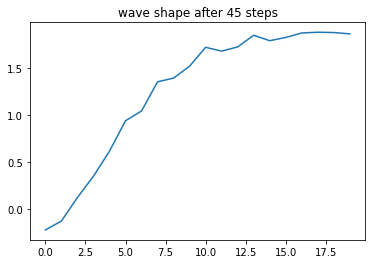

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_45/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_45/model_weights.tf
generator loss:0.6356888881986766
-----------------------
total discriminator loss:0.7838690294046899
average true return:0.48089077492460686
-----------------------


  3%|▎         | 46/1562 [07:09<3:51:42,  9.17s/it]

Training Step: 46
generator loss:0.6555500026911913
-----------------------
total discriminator loss:0.7661396445284945
average true return:0.48001596929819945
-----------------------


  3%|▎         | 47/1562 [07:12<3:00:21,  7.14s/it]

Training Step: 47
generator loss:0.6824675300583944
-----------------------
total discriminator loss:0.7551192013823528
average true return:0.48094928474327747
-----------------------


  3%|▎         | 48/1562 [07:14<2:24:14,  5.72s/it]

Training Step: 48
generator loss:0.7019317575132089
-----------------------
total discriminator loss:0.7392583943797489
average true return:0.478198476379723
-----------------------


  3%|▎         | 49/1562 [07:16<1:59:12,  4.73s/it]

Training Step: 49
generator loss:0.7236729752423843
-----------------------
total discriminator loss:0.7207666703178717
average true return:0.4787913153611346
-----------------------


  3%|▎         | 50/1562 [07:19<1:41:25,  4.03s/it]

Training Step: 50
event_types: [1, 0, 3, 2, 1, 0, 3, 2, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2]
mad_score: 0.519275
fid_score: 41066.097528613835
rule_score: 0.4955


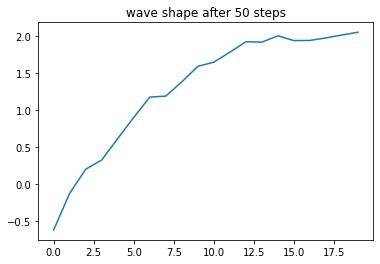

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_50/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_50/model_weights.tf
generator loss:0.7393748261439543
-----------------------
total discriminator loss:0.7002877842913531
average true return:0.47625575499037
-----------------------


  3%|▎         | 51/1562 [07:33<2:57:48,  7.06s/it]

Training Step: 51
generator loss:0.7611456830243939
-----------------------


  3%|▎         | 52/1562 [07:35<2:22:41,  5.67s/it]

total discriminator loss:0.6879999361317053
average true return:0.4781668251157159
-----------------------
Training Step: 52
generator loss:0.794015333223728
-----------------------


  3%|▎         | 53/1562 [07:37<1:55:03,  4.57s/it]

total discriminator loss:0.6726500481123359
average true return:0.47127153347651285
-----------------------
Training Step: 53
generator loss:0.8196245884484946
-----------------------
total discriminator loss:0.6488142579535665
average true return:0.4772121684080353
-----------------------


  3%|▎         | 54/1562 [07:40<1:37:27,  3.88s/it]

Training Step: 54
generator loss:0.8389107042087222
-----------------------
total discriminator loss:0.6460382543691934
average true return:0.4696980366406677
-----------------------


  4%|▎         | 55/1562 [07:42<1:26:20,  3.44s/it]

Training Step: 55
event_types: [3, 0, 2, 3, 2, 2, 2, 2, 2, 2, 0, 2, 3, 3, 1, 3, 2, 2, 2, 2]
mad_score: 0.50125
fid_score: 48911.340824927676
rule_score: 0.505


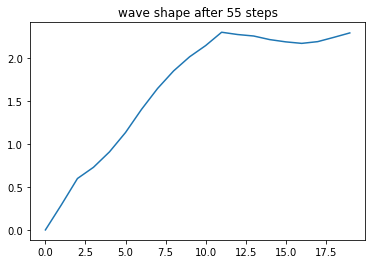

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_55/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_55/model_weights.tf
generator loss:0.8624553313627736
-----------------------
total discriminator loss:0.6241987458163887
average true return:0.472229700937175
-----------------------


  4%|▎         | 56/1562 [07:57<2:50:56,  6.81s/it]

Training Step: 56
generator loss:0.8847420256076373
-----------------------
total discriminator loss:0.6123657615247766
average true return:0.47294011370406924
-----------------------


  4%|▎         | 57/1562 [07:59<2:17:56,  5.50s/it]

Training Step: 57
generator loss:0.9141912412243327
-----------------------
total discriminator loss:0.5927029096465894
average true return:0.4697979806880937
-----------------------


  4%|▎         | 58/1562 [08:02<1:54:24,  4.56s/it]

Training Step: 58
generator loss:0.9330739364778913
-----------------------
total discriminator loss:0.5776872428848482
average true return:0.46875146660368106
-----------------------


  4%|▍         | 59/1562 [08:04<1:38:11,  3.92s/it]

Training Step: 59
generator loss:0.9711133689911973
-----------------------
total discriminator loss:0.5706569035832962
average true return:0.4711460869778318
-----------------------


  4%|▍         | 60/1562 [08:07<1:30:19,  3.61s/it]

Training Step: 60
event_types: [2, 0, 1, 3, 2, 2, 3, 2, 2, 2, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1]
mad_score: 0.487575
fid_score: 56446.47467571797
rule_score: 0.47575


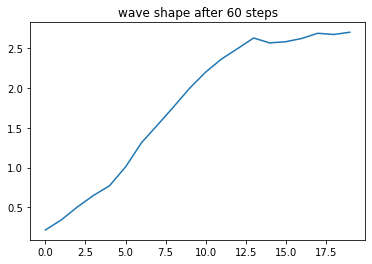

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_60/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_60/model_weights.tf
generator loss:1.0039818659954252
-----------------------
total discriminator loss:0.5501685185312906
average true return:0.4738290904429866
-----------------------


  4%|▍         | 61/1562 [08:32<4:09:52,  9.99s/it]

Training Step: 61
generator loss:1.033651801113332
-----------------------
total discriminator loss:0.5423216964896936
average true return:0.46863551265226094
-----------------------


  4%|▍         | 62/1562 [08:37<3:31:20,  8.45s/it]

Training Step: 62
generator loss:1.0653071613157445
-----------------------
total discriminator loss:0.520009090756302
average true return:0.4637800269872018
-----------------------


  4%|▍         | 63/1562 [08:41<3:04:06,  7.37s/it]

Training Step: 63
generator loss:1.0873056905289862
-----------------------
total discriminator loss:0.5085453380954893
average true return:0.46836273841607695
-----------------------


  4%|▍         | 64/1562 [08:47<2:46:34,  6.67s/it]

Training Step: 64
generator loss:1.13056405002282
-----------------------
total discriminator loss:0.49688757920644794
average true return:0.4701100427736701
-----------------------


  4%|▍         | 65/1562 [08:52<2:34:13,  6.18s/it]

Training Step: 65
event_types: [0, 2, 2, 0, 2, 1, 1, 1, 2, 2, 3, 1, 0, 0, 3, 2, 2, 0, 2, 2]
mad_score: 0.47335
fid_score: 62180.38468046392
rule_score: 0.48825


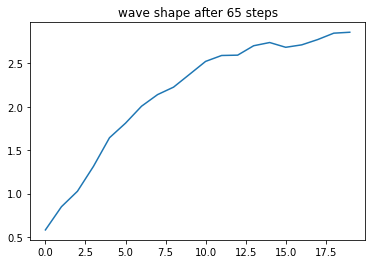

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_65/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_65/model_weights.tf
generator loss:1.151087006397066
-----------------------
total discriminator loss:1.0121950920807286
average true return:0.46669309151790017
-----------------------


  4%|▍         | 66/1562 [09:18<5:02:40, 12.14s/it]

Training Step: 66
generator loss:1.1908717464894822
-----------------------
total discriminator loss:0.4763625009055796
average true return:0.4679854623513847
-----------------------


  4%|▍         | 67/1562 [09:23<4:08:29,  9.97s/it]

Training Step: 67
generator loss:1.1917562534702637
-----------------------
total discriminator loss:0.4788367854467528
average true return:0.4720090787946826
-----------------------


  4%|▍         | 68/1562 [09:27<3:29:57,  8.43s/it]

Training Step: 68
generator loss:1.2337247028310023
-----------------------
total discriminator loss:0.48050304544542155
average true return:0.4706367344148886
-----------------------


  4%|▍         | 69/1562 [09:32<3:04:30,  7.41s/it]

Training Step: 69
generator loss:1.2252684482941811
-----------------------
total discriminator loss:0.4559997986329904
average true return:0.468358072486796
-----------------------


  4%|▍         | 70/1562 [09:37<2:45:31,  6.66s/it]

Training Step: 70
event_types: [0, 2, 1, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 2, 1]
mad_score: 0.4674125
fid_score: 64628.101462070226
rule_score: 0.4945


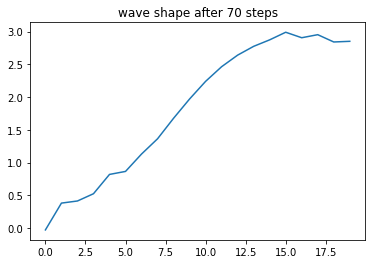

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_70/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_70/model_weights.tf
generator loss:1.258678371282357
-----------------------
total discriminator loss:0.45496189655231334
average true return:0.4747180949453357
-----------------------


  5%|▍         | 71/1562 [10:04<5:14:58, 12.68s/it]

Training Step: 71
generator loss:1.2539127488935966
-----------------------
total discriminator loss:0.4423979502701124
average true return:0.47888830977464714
-----------------------


  5%|▍         | 72/1562 [10:09<4:17:07, 10.35s/it]

Training Step: 72
generator loss:1.3000253626580918
-----------------------
total discriminator loss:0.43762801168996246
average true return:0.47366503663962833
-----------------------


  5%|▍         | 73/1562 [10:14<3:36:18,  8.72s/it]

Training Step: 73
generator loss:1.335860919272344
-----------------------
total discriminator loss:0.439448769713346
average true return:0.4771363101893207
-----------------------


  5%|▍         | 74/1562 [10:19<3:07:04,  7.54s/it]

Training Step: 74
generator loss:1.3480837010813358
-----------------------
total discriminator loss:0.41690634326466725
average true return:0.4811844593285113
-----------------------


  5%|▍         | 75/1562 [10:23<2:44:38,  6.64s/it]

Training Step: 75
event_types: [2, 0, 3, 2, 0, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 2, 0, 2, 2, 2]
mad_score: 0.4614
fid_score: 63144.024898547315
rule_score: 0.5085


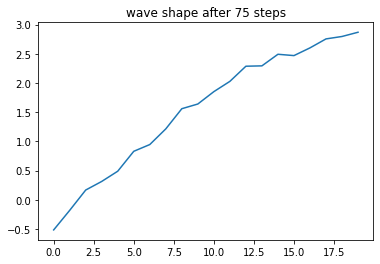

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_75/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_75/model_weights.tf
generator loss:1.355809009632059
-----------------------
total discriminator loss:1.2123267213289606
average true return:0.4703874135064459
-----------------------


  5%|▍         | 76/1562 [10:50<5:12:49, 12.63s/it]

Training Step: 76
generator loss:1.3716215331898418
-----------------------
total discriminator loss:0.4183680740714327
average true return:0.48097374130128856
-----------------------


  5%|▍         | 77/1562 [10:55<4:13:58, 10.26s/it]

Training Step: 77
generator loss:1.3654229522390928
-----------------------
total discriminator loss:0.41699991256389735
average true return:0.48284934026425186
-----------------------


  5%|▍         | 78/1562 [10:59<3:34:21,  8.67s/it]

Training Step: 78
generator loss:1.3518074522986763
-----------------------
total discriminator loss:0.4232497041433696
average true return:0.4908154857089095
-----------------------


  5%|▌         | 79/1562 [11:04<3:04:19,  7.46s/it]

Training Step: 79
generator loss:1.332550477876405
-----------------------
total discriminator loss:0.4191006348382964
average true return:0.48973180490365037
-----------------------


  5%|▌         | 80/1562 [11:09<2:45:43,  6.71s/it]

Training Step: 80
event_types: [0, 0, 0, 0, 2, 0, 2, 2, 3, 2, 2, 1, 0, 2, 0, 3, 3, 2, 2, 3]
mad_score: 0.4624875
fid_score: 57472.558524530265
rule_score: 0.52


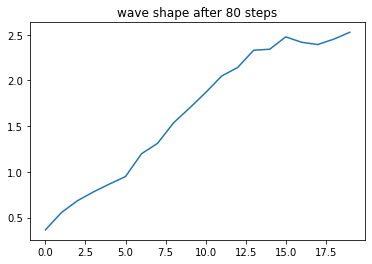

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_80/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_80/model_weights.tf
generator loss:1.3611626827456371
-----------------------
total discriminator loss:0.4070297801391538
average true return:0.4941630629069602
-----------------------


  5%|▌         | 81/1562 [11:36<5:13:46, 12.71s/it]

Training Step: 81
generator loss:1.3724522964490764
-----------------------
total discriminator loss:0.409057425591777
average true return:0.4979919613388314
-----------------------


  5%|▌         | 82/1562 [11:41<4:15:01, 10.34s/it]

Training Step: 82
generator loss:1.365026340839962
-----------------------
total discriminator loss:0.40656716404314414
average true return:0.5014733719894575
-----------------------


  5%|▌         | 83/1562 [11:44<3:26:51,  8.39s/it]

Training Step: 83
generator loss:1.3557258102015024
-----------------------
total discriminator loss:0.3991686047607452
average true return:0.504905259825148
-----------------------


  5%|▌         | 84/1562 [11:49<2:58:38,  7.25s/it]

Training Step: 84
generator loss:1.362287060006425
-----------------------
total discriminator loss:0.39985568668222005
average true return:0.5021415635341029
-----------------------


  5%|▌         | 85/1562 [11:54<2:39:09,  6.47s/it]

Training Step: 85
event_types: [1, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 1, 2, 2, 1, 2, 2, 2, 3, 1]
mad_score: 0.4679875
fid_score: 48338.54266695943
rule_score: 0.55525


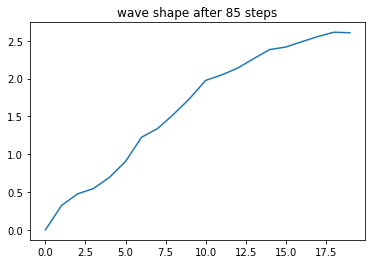

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_85/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_85/model_weights.tf
generator loss:1.3488496059234216
-----------------------
total discriminator loss:0.412613071493137
average true return:0.5101261139782207
-----------------------


  6%|▌         | 86/1562 [12:19<4:57:36, 12.10s/it]

Training Step: 86
generator loss:1.3472006497565006
-----------------------
total discriminator loss:1.2550875766992897
average true return:0.5076349517261649
-----------------------


  6%|▌         | 87/1562 [12:24<4:04:43,  9.95s/it]

Training Step: 87
generator loss:1.2969587720592166
-----------------------
total discriminator loss:0.41333863407784877
average true return:0.510753041780447
-----------------------


  6%|▌         | 88/1562 [12:29<3:26:12,  8.39s/it]

Training Step: 88
generator loss:1.2932637951203456
-----------------------
total discriminator loss:1.2364098549907525
average true return:0.5287827413400312
-----------------------


  6%|▌         | 89/1562 [12:34<3:00:30,  7.35s/it]

Training Step: 89
generator loss:1.2358224468971393
-----------------------
total discriminator loss:0.42217493563177194
average true return:0.5318649982710889
-----------------------


  6%|▌         | 90/1562 [12:38<2:42:37,  6.63s/it]

Training Step: 90
event_types: [2, 1, 2, 3, 2, 2, 1, 2, 3, 2, 0, 2, 2, 2, 2, 3, 2, 2, 1, 2]
mad_score: 0.4725625
fid_score: 37587.440609777565
rule_score: 0.57325


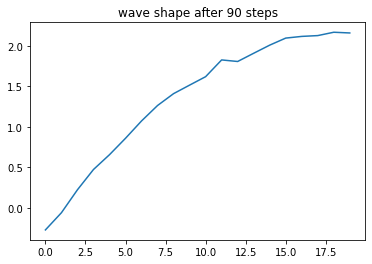

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_90/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_90/model_weights.tf
generator loss:1.186087042705287
-----------------------
total discriminator loss:0.43400361159929873
average true return:0.5378728364385114
-----------------------


  6%|▌         | 91/1562 [13:05<5:11:28, 12.70s/it]

Training Step: 91
generator loss:1.1229489209231835
-----------------------
total discriminator loss:0.4449616298117367
average true return:0.5547003162908344
-----------------------


  6%|▌         | 92/1562 [13:10<4:13:03, 10.33s/it]

Training Step: 92
generator loss:1.1087421250862457
-----------------------
total discriminator loss:0.45651886894130334
average true return:0.5629761006554663
-----------------------


  6%|▌         | 93/1562 [13:15<3:32:44,  8.69s/it]

Training Step: 93
generator loss:1.0893999483006427
-----------------------
total discriminator loss:0.46295447787184774
average true return:0.558521230905676
-----------------------


  6%|▌         | 94/1562 [13:20<3:06:11,  7.61s/it]

Training Step: 94
generator loss:1.0468320838019323
-----------------------
total discriminator loss:0.47922632686187844
average true return:0.5689775962668395
-----------------------


  6%|▌         | 95/1562 [13:25<2:46:12,  6.80s/it]

Training Step: 95
event_types: [3, 1, 1, 2, 2, 0, 1, 2, 2, 3, 2, 2, 2, 3, 0, 2, 2, 2, 1, 3]
mad_score: 0.4768
fid_score: 27816.4895035157
rule_score: 0.5905


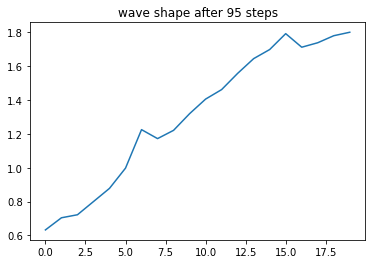

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_95/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_95/model_weights.tf
generator loss:1.0186487869192595
-----------------------
total discriminator loss:0.47332036537877165
average true return:0.5654514279624991
-----------------------


  6%|▌         | 96/1562 [13:52<5:11:05, 12.73s/it]

Training Step: 96
generator loss:1.0166241327815704
-----------------------
total discriminator loss:0.47489305901717666
average true return:0.5664746724523753
-----------------------


  6%|▌         | 97/1562 [13:56<4:11:22, 10.30s/it]

Training Step: 97
generator loss:1.0423126712573374
-----------------------
total discriminator loss:0.4900852201379012
average true return:0.5631594897434671
-----------------------


  6%|▋         | 98/1562 [14:01<3:30:46,  8.64s/it]

Training Step: 98
generator loss:0.9937490634034912
-----------------------
total discriminator loss:0.49739402872127136
average true return:0.5644325407177511
-----------------------


  6%|▋         | 99/1562 [14:06<3:02:13,  7.47s/it]

Training Step: 99
generator loss:1.0309383633131324
-----------------------
total discriminator loss:0.48150745293139136
average true return:0.5553060423327683
-----------------------


  6%|▋         | 100/1562 [14:10<2:42:13,  6.66s/it]

Training Step: 100
event_types: [1, 3, 0, 3, 1, 2, 3, 1, 1, 2, 2, 0, 1, 0, 2, 2, 2, 2, 0, 3]
mad_score: 0.4846
fid_score: 20221.599805239683
rule_score: 0.61425


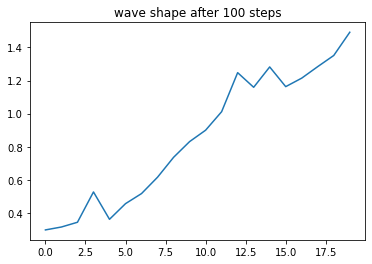

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_100/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_100/model_weights.tf
generator loss:1.0368648759758003
-----------------------
total discriminator loss:0.4917539417709714
average true return:0.5515661316621983
-----------------------


  6%|▋         | 101/1562 [14:36<5:02:06, 12.41s/it]

Training Step: 101
generator loss:1.0132447399921543
-----------------------
total discriminator loss:0.48422617376922567
average true return:0.5386240465463041
-----------------------


  7%|▋         | 102/1562 [14:41<4:07:43, 10.18s/it]

Training Step: 102
generator loss:1.042670578577736
-----------------------
total discriminator loss:0.5043016788348922
average true return:0.5302435222847478
-----------------------


  7%|▋         | 103/1562 [14:46<3:28:50,  8.59s/it]

Training Step: 103
generator loss:1.0428882313158854
-----------------------
total discriminator loss:0.50092105519937
average true return:0.5246509763447131
-----------------------


  7%|▋         | 104/1562 [14:51<3:00:40,  7.44s/it]

Training Step: 104
generator loss:1.076550170430064
-----------------------
total discriminator loss:0.9855639461883141
average true return:0.5161354242684905
-----------------------


  7%|▋         | 105/1562 [14:56<2:42:14,  6.68s/it]

Training Step: 105
event_types: [0, 3, 1, 2, 2, 3, 0, 1, 1, 0, 3, 1, 1, 2, 1, 2, 1, 2, 2, 2]
mad_score: 0.4917625
fid_score: 15214.01076758283
rule_score: 0.6405


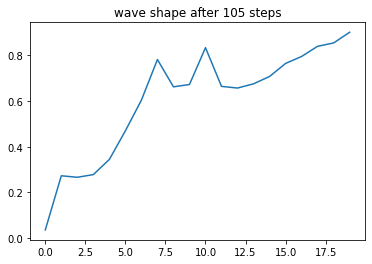

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_105/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_105/model_weights.tf
generator loss:1.049658564549151
-----------------------
total discriminator loss:0.5288311418299101
average true return:0.511939865259821
-----------------------


  7%|▋         | 106/1562 [15:23<5:11:03, 12.82s/it]

Training Step: 106
generator loss:1.0412059563559088
-----------------------
total discriminator loss:0.5228648314214073
average true return:0.5087690815040413
-----------------------


  7%|▋         | 107/1562 [15:28<4:11:50, 10.39s/it]

Training Step: 107
generator loss:1.0456618424186614
-----------------------
total discriminator loss:0.5388651579396613
average true return:0.4955177301249799
-----------------------


  7%|▋         | 108/1562 [15:32<3:30:20,  8.68s/it]

Training Step: 108
generator loss:1.0216596597434768
-----------------------
total discriminator loss:0.5480416363443606
average true return:0.4976503542934004
-----------------------


  7%|▋         | 109/1562 [15:37<2:59:24,  7.41s/it]

Training Step: 109
generator loss:1.0585232528120727
-----------------------
total discriminator loss:0.5636698088045606
average true return:0.49368709158191987
-----------------------


  7%|▋         | 110/1562 [15:41<2:39:18,  6.58s/it]

Training Step: 110
event_types: [1, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2]
mad_score: 0.4979
fid_score: 12161.973185017941
rule_score: 0.625


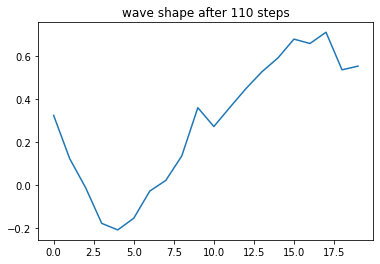

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_110/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_110/model_weights.tf
generator loss:1.029609840898966
-----------------------
total discriminator loss:0.578214705688803
average true return:0.47549822285800697
-----------------------


  7%|▋         | 111/1562 [16:07<4:57:27, 12.30s/it]

Training Step: 111
generator loss:1.0204981933937083
-----------------------
total discriminator loss:0.5690481173795299
average true return:0.4743093564155566
-----------------------


  7%|▋         | 112/1562 [16:12<4:02:57, 10.05s/it]

Training Step: 112
generator loss:0.9947965847160551
-----------------------
total discriminator loss:0.5996244044564817
average true return:0.47973313197771494
-----------------------


  7%|▋         | 113/1562 [16:17<3:24:34,  8.47s/it]

Training Step: 113
generator loss:0.9765563727604756
-----------------------
total discriminator loss:0.5788769982782154
average true return:0.4816822751915488
-----------------------


  7%|▋         | 114/1562 [16:21<2:56:16,  7.30s/it]

Training Step: 114
generator loss:0.9596346004106586
-----------------------
total discriminator loss:0.6028978811835726
average true return:0.4880461403176887
-----------------------


  7%|▋         | 115/1562 [16:26<2:38:33,  6.57s/it]

Training Step: 115
event_types: [0, 2, 1, 2, 2, 2, 1, 2, 2, 1, 0, 1, 2, 1, 2, 1, 2, 3, 0, 2]
mad_score: 0.5065875
fid_score: 10451.467372788507
rule_score: 0.64625


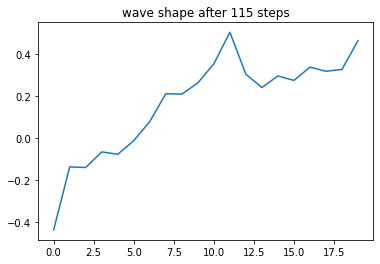

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_115/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_115/model_weights.tf
generator loss:0.9527732095351675
-----------------------
total discriminator loss:0.6171125910003663
average true return:0.48699974549977443
-----------------------


  7%|▋         | 116/1562 [16:53<5:01:40, 12.52s/it]

Training Step: 116
generator loss:0.9093634676936355
-----------------------
total discriminator loss:0.6342410801833549
average true return:0.4886473508902088
-----------------------


  7%|▋         | 117/1562 [16:57<4:05:42, 10.20s/it]

Training Step: 117
generator loss:0.88793328233576
-----------------------
total discriminator loss:0.6394103208103892
average true return:0.4795246161198258
-----------------------


  8%|▊         | 118/1562 [17:02<3:27:09,  8.61s/it]

Training Step: 118
generator loss:0.8646122912795091
-----------------------
total discriminator loss:0.6615443729467394
average true return:0.4808316726688685
-----------------------


  8%|▊         | 119/1562 [17:07<2:59:55,  7.48s/it]

Training Step: 119
generator loss:0.8481815202131476
-----------------------
total discriminator loss:0.6809330763087448
average true return:0.476258697281844
-----------------------


  8%|▊         | 120/1562 [17:12<2:41:31,  6.72s/it]

Training Step: 120
event_types: [3, 2, 2, 2, 3, 2, 2, 0, 2, 1, 0, 0, 2, 1, 2, 0, 1, 2, 2, 0]
mad_score: 0.5137125
fid_score: 9670.798851047508
rule_score: 0.6465


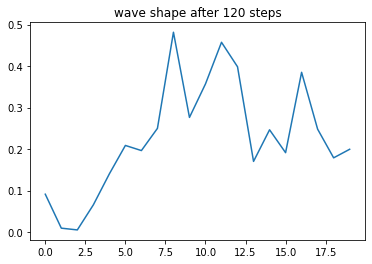

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_120/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_120/model_weights.tf
generator loss:0.8286936904314768
-----------------------
total discriminator loss:0.6737868532061762
average true return:0.4914730703626257
-----------------------


  8%|▊         | 121/1562 [17:39<5:04:15, 12.67s/it]

Training Step: 121
generator loss:0.8061852769714666
-----------------------
total discriminator loss:0.6818921746224875
average true return:0.48746848803385545
-----------------------


  8%|▊         | 122/1562 [17:43<4:07:00, 10.29s/it]

Training Step: 122
generator loss:0.7805905830599389
-----------------------
total discriminator loss:0.7025771791287088
average true return:0.4870633819721192
-----------------------


  8%|▊         | 123/1562 [17:48<3:26:43,  8.62s/it]

Training Step: 123
generator loss:0.7603513668311292
-----------------------
total discriminator loss:0.7266144475274603
average true return:0.48201078857878643
-----------------------


  8%|▊         | 124/1562 [17:53<2:59:45,  7.50s/it]

Training Step: 124
generator loss:0.7355101345174626
-----------------------
total discriminator loss:0.7420425484238327
average true return:0.48483467772956845
-----------------------


  8%|▊         | 125/1562 [17:58<2:39:31,  6.66s/it]

Training Step: 125
event_types: [2, 1, 1, 2, 3, 2, 1, 2, 2, 1, 2, 1, 2, 3, 2, 2, 2, 3, 1, 2]
mad_score: 0.52415
fid_score: 9545.578362092012
rule_score: 0.6525


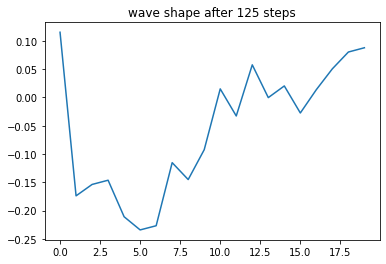

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_125/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_125/model_weights.tf
generator loss:0.7184472652487636
-----------------------
total discriminator loss:0.7280633993418619
average true return:0.5007460199080278
-----------------------


  8%|▊         | 126/1562 [18:24<5:00:40, 12.56s/it]

Training Step: 126
generator loss:0.682068631732383
-----------------------
total discriminator loss:0.7592264364579446
average true return:0.4908060624505177
-----------------------


  8%|▊         | 127/1562 [18:29<4:05:01, 10.24s/it]

Training Step: 127
generator loss:0.6882740766555231
-----------------------
total discriminator loss:0.7448662267034384
average true return:0.5068963519882297
-----------------------


  8%|▊         | 128/1562 [18:33<3:25:05,  8.58s/it]

Training Step: 128
generator loss:0.6761959394414636
-----------------------
total discriminator loss:0.760700365804721
average true return:0.5014714922122364
-----------------------


  8%|▊         | 129/1562 [18:38<2:57:41,  7.44s/it]

Training Step: 129
generator loss:0.6591233980358152
-----------------------
total discriminator loss:0.7641013951446376
average true return:0.500622730902369
-----------------------


  8%|▊         | 130/1562 [18:43<2:38:21,  6.64s/it]

Training Step: 130
event_types: [3, 2, 3, 2, 2, 2, 1, 2, 3, 2, 3, 0, 1, 1, 1, 1, 0, 2, 3, 2]
mad_score: 0.5327
fid_score: 9996.138519765173
rule_score: 0.653


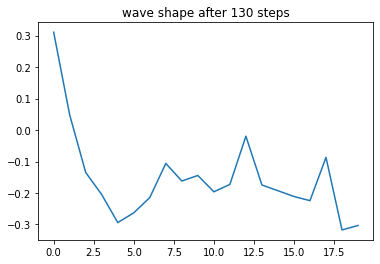

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_130/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_130/model_weights.tf
generator loss:0.6708868973350559
-----------------------
total discriminator loss:0.784179847656935
average true return:0.4927027254950773
-----------------------


  8%|▊         | 131/1562 [19:10<5:01:14, 12.63s/it]

Training Step: 131
generator loss:0.6705983890426441
-----------------------
total discriminator loss:0.7749733887457749
average true return:0.4957005520937088
-----------------------


  8%|▊         | 132/1562 [19:15<4:05:45, 10.31s/it]

Training Step: 132
generator loss:0.6588548403846629
-----------------------
total discriminator loss:0.8062464657882857
average true return:0.48705362986374884
-----------------------


  9%|▊         | 133/1562 [19:19<3:25:34,  8.63s/it]

Training Step: 133
generator loss:0.6601753592900087
-----------------------
total discriminator loss:0.8031773820853386
average true return:0.48717516670149136
-----------------------


  9%|▊         | 134/1562 [19:24<2:57:09,  7.44s/it]

Training Step: 134
generator loss:0.6675743274569924
-----------------------
total discriminator loss:0.7982122714434638
average true return:0.48178623870208825
-----------------------


  9%|▊         | 135/1562 [19:28<2:35:06,  6.52s/it]

Training Step: 135
event_types: [3, 2, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2]
mad_score: 0.54865
fid_score: 10876.291956219484
rule_score: 0.645


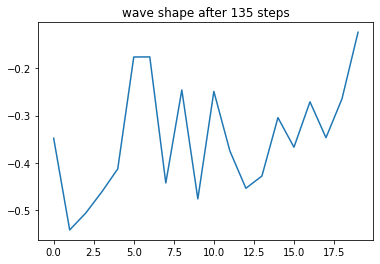

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_135/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_135/model_weights.tf
generator loss:0.6646043509873426
-----------------------
total discriminator loss:0.7984848315524642
average true return:0.47787674595278395
-----------------------


  9%|▊         | 136/1562 [19:53<4:42:47, 11.90s/it]

Training Step: 136
generator loss:0.6651359982650804
-----------------------
total discriminator loss:0.801046192497114
average true return:0.47228364965340675
-----------------------


  9%|▉         | 137/1562 [19:57<3:51:47,  9.76s/it]

Training Step: 137
generator loss:0.6815881501418556
-----------------------
total discriminator loss:0.7981046540490961
average true return:0.4683995646374289
-----------------------


  9%|▉         | 138/1562 [20:02<3:15:47,  8.25s/it]

Training Step: 138
generator loss:0.6749552690525011
-----------------------
total discriminator loss:0.8140871484986651
average true return:0.4641268931220035
-----------------------


  9%|▉         | 139/1562 [20:07<2:49:38,  7.15s/it]

Training Step: 139
generator loss:0.6790717895510561
-----------------------
total discriminator loss:0.7942320339688953
average true return:0.46598652623655296
-----------------------


  9%|▉         | 140/1562 [20:12<2:32:42,  6.44s/it]

Training Step: 140
event_types: [0, 3, 2, 1, 2, 2, 2, 0, 2, 2, 1, 3, 2, 0, 1, 3, 0, 2, 0, 2]
mad_score: 0.565375
fid_score: 12151.304401849564
rule_score: 0.51175


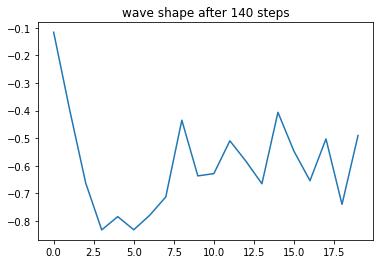

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_140/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_140/model_weights.tf
generator loss:0.6827330915577154
-----------------------
total discriminator loss:0.8029761945481764
average true return:0.46188247025383256
-----------------------


  9%|▉         | 141/1562 [20:38<4:52:50, 12.37s/it]

Training Step: 141
generator loss:0.6881935001063262
-----------------------
total discriminator loss:0.783160648394255
average true return:0.4653399892732156
-----------------------


  9%|▉         | 142/1562 [20:42<3:57:55, 10.05s/it]

Training Step: 142
generator loss:0.6878943308216208
-----------------------
total discriminator loss:0.7771599236334903
average true return:0.4667963992261681
-----------------------


  9%|▉         | 143/1562 [20:47<3:20:17,  8.47s/it]

Training Step: 143
generator loss:0.6943174615826571
-----------------------
total discriminator loss:0.7814120907682267
average true return:0.46173735651280623
-----------------------


  9%|▉         | 144/1562 [20:52<2:53:06,  7.32s/it]

Training Step: 144
generator loss:0.6948812666892593
-----------------------
total discriminator loss:0.6266220652968137
average true return:0.4647457500413319
-----------------------


  9%|▉         | 145/1562 [20:57<2:35:35,  6.59s/it]

Training Step: 145
event_types: [0, 2, 1, 3, 2, 1, 2, 3, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2, 2, 1]
mad_score: 0.5839125
fid_score: 13643.798148232025
rule_score: 0.1435


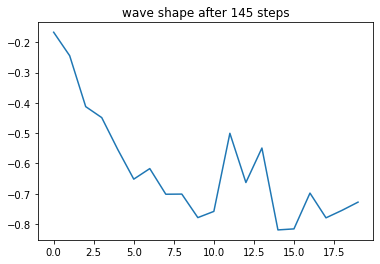

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_145/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_145/model_weights.tf
generator loss:0.6915606403913707
-----------------------
total discriminator loss:0.7802064652838465
average true return:0.4632724223234096
-----------------------


  9%|▉         | 146/1562 [21:22<4:49:41, 12.28s/it]

Training Step: 146
generator loss:0.7080382923359618
-----------------------
total discriminator loss:0.7815000739890361
average true return:0.4622644726440066
-----------------------


  9%|▉         | 147/1562 [21:27<3:55:50, 10.00s/it]

Training Step: 147
generator loss:0.7040288077980941
-----------------------
total discriminator loss:0.6332829673326807
average true return:0.46894757427458633
-----------------------


  9%|▉         | 148/1562 [21:31<3:16:55,  8.36s/it]

Training Step: 148
generator loss:0.6935126514132254
-----------------------
total discriminator loss:0.7634710025109808
average true return:0.4737659774262499
-----------------------


 10%|▉         | 149/1562 [21:36<2:49:45,  7.21s/it]

Training Step: 149
generator loss:0.691719421183469
-----------------------
total discriminator loss:0.7576072616694303
average true return:0.47358686010276213
-----------------------


 10%|▉         | 150/1562 [21:41<2:33:21,  6.52s/it]

Training Step: 150
event_types: [0, 0, 1, 2, 3, 2, 1, 1, 2, 3, 1, 2, 1, 0, 0, 3, 2, 2, 1, 0]
mad_score: 0.60395
fid_score: 15178.727315360604
rule_score: 0.04775


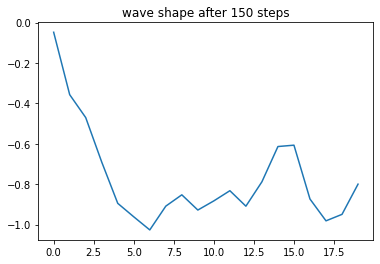

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_150/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_150/model_weights.tf
generator loss:0.6871320583174778
-----------------------
total discriminator loss:0.7619506316440843
average true return:0.4719644605745399
-----------------------


 10%|▉         | 151/1562 [22:07<4:49:15, 12.30s/it]

Training Step: 151
generator loss:0.6820259665726317
-----------------------
total discriminator loss:0.7564073323964202
average true return:0.47684115560541784
-----------------------


 10%|▉         | 152/1562 [22:12<3:56:23, 10.06s/it]

Training Step: 152
generator loss:0.6826734253162292
-----------------------
total discriminator loss:0.760007158774761
average true return:0.48259994569640324
-----------------------


 10%|▉         | 153/1562 [22:16<3:19:28,  8.49s/it]

Training Step: 153
generator loss:0.6852320477796183
-----------------------
total discriminator loss:0.742103451512362
average true return:0.4799059815986358
-----------------------


 10%|▉         | 154/1562 [22:21<2:54:10,  7.42s/it]

Training Step: 154
generator loss:0.6892488713542595
-----------------------
total discriminator loss:0.7420675019424225
average true return:0.4827036759682046
-----------------------


 10%|▉         | 155/1562 [22:26<2:35:44,  6.64s/it]

Training Step: 155
event_types: [3, 1, 2, 0, 2, 2, 2, 2, 2, 3, 2, 3, 2, 0, 2, 2, 2, 0, 2, 2]
mad_score: 0.6286875
fid_score: 16739.43623045834
rule_score: 0.02925


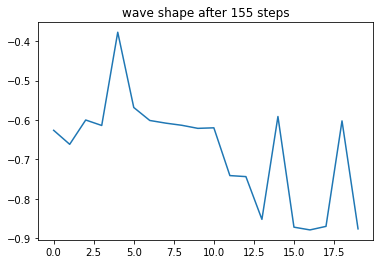

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_155/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_155/model_weights.tf
generator loss:0.6999406993920151
-----------------------
total discriminator loss:0.744071395902186
average true return:0.4820869034601528
-----------------------


 10%|▉         | 156/1562 [22:52<4:48:26, 12.31s/it]

Training Step: 156
generator loss:0.701399171661466
-----------------------
total discriminator loss:0.7455732477812136
average true return:0.4790921344780723
-----------------------


 10%|█         | 157/1562 [22:56<3:54:35, 10.02s/it]

Training Step: 157
generator loss:0.7037803163342238
-----------------------
total discriminator loss:0.7333042136591995
average true return:0.47718510243494694
-----------------------


 10%|█         | 158/1562 [23:01<3:19:28,  8.52s/it]

Training Step: 158
generator loss:0.7065906831679574
-----------------------
total discriminator loss:0.7214925321815316
average true return:0.48233032829082556
-----------------------


 10%|█         | 159/1562 [23:06<2:52:53,  7.39s/it]

Training Step: 159
generator loss:0.7130854005699272
-----------------------
total discriminator loss:0.7159497361460642
average true return:0.48201018519326244
-----------------------


 10%|█         | 160/1562 [23:11<2:33:01,  6.55s/it]

Training Step: 160
event_types: [1, 1, 1, 2, 3, 1, 1, 2, 2, 2, 3, 1, 0, 2, 2, 3, 2, 2, 1, 1]
mad_score: 0.6526375
fid_score: 17956.65318193459
rule_score: 0.023


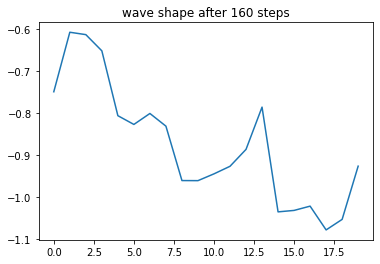

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_160/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_160/model_weights.tf
generator loss:0.7201743081403708
-----------------------
total discriminator loss:0.7067600117672885
average true return:0.4849333196715741
-----------------------


 10%|█         | 161/1562 [23:35<4:38:11, 11.91s/it]

Training Step: 161
generator loss:0.7261604624940241
-----------------------
total discriminator loss:0.7046469113519356
average true return:0.48418553608288756
-----------------------


 10%|█         | 162/1562 [23:40<3:47:42,  9.76s/it]

Training Step: 162
generator loss:0.7398762069651716
-----------------------
total discriminator loss:0.6987339368563487
average true return:0.4813303099135986
-----------------------


 10%|█         | 163/1562 [23:45<3:11:52,  8.23s/it]

Training Step: 163
generator loss:0.7380336834776318
-----------------------
total discriminator loss:0.6908624546694648
average true return:0.4801507098431679
-----------------------


 10%|█         | 164/1562 [23:49<2:47:13,  7.18s/it]

Training Step: 164
generator loss:0.7504132666683951
-----------------------
total discriminator loss:0.6821943064356986
average true return:0.48030837300684437
-----------------------


 11%|█         | 165/1562 [23:54<2:30:10,  6.45s/it]

Training Step: 165
event_types: [1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 0, 0, 1, 2, 0, 2, 1, 0, 0, 1]
mad_score: 0.679375
fid_score: 18784.636709428854
rule_score: 0.02275


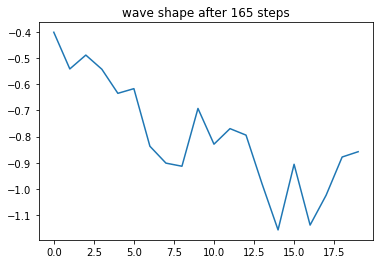

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_165/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_165/model_weights.tf
generator loss:0.7606573595811337
-----------------------
total discriminator loss:0.6810320047137949
average true return:0.48227280132875405
-----------------------


 11%|█         | 166/1562 [24:20<4:46:31, 12.31s/it]

Training Step: 166
generator loss:0.769148819890198
-----------------------
total discriminator loss:0.6711863903329653
average true return:0.4773455445336851
-----------------------


 11%|█         | 167/1562 [24:25<3:52:37, 10.01s/it]

Training Step: 167
generator loss:0.7762376118291392
-----------------------
total discriminator loss:0.6659913375785134
average true return:0.4816813407275479
-----------------------


 11%|█         | 168/1562 [24:29<3:15:08,  8.40s/it]

Training Step: 168
generator loss:0.7853911681486497
-----------------------
total discriminator loss:0.6651026364451571
average true return:0.4800811665364269
-----------------------


 11%|█         | 169/1562 [24:34<2:50:19,  7.34s/it]

Training Step: 169
generator loss:0.7939030639446147
-----------------------
total discriminator loss:0.6527879708681419
average true return:0.4810331696806613
-----------------------


 11%|█         | 170/1562 [24:39<2:33:20,  6.61s/it]

Training Step: 170
event_types: [2, 1, 2, 2, 2, 0, 1, 1, 2, 2, 1, 2, 0, 3, 0, 2, 2, 0, 3, 2]
mad_score: 0.7021875
fid_score: 19016.493832106913
rule_score: 0.02325


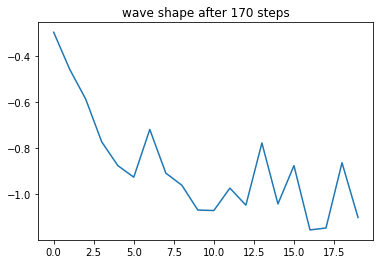

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_170/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_170/model_weights.tf
generator loss:0.795648956127124
-----------------------
total discriminator loss:0.6475583632685237
average true return:0.482807286017657
-----------------------


 11%|█         | 171/1562 [25:05<4:46:52, 12.37s/it]

Training Step: 171
generator loss:0.800423284308815
-----------------------
total discriminator loss:0.6446013801420526
average true return:0.48142859977993924
-----------------------


 11%|█         | 172/1562 [25:10<3:53:42, 10.09s/it]

Training Step: 172
generator loss:0.8075739140260694
-----------------------
total discriminator loss:0.6384741278606733
average true return:0.4833077854424862
-----------------------


 11%|█         | 173/1562 [25:14<3:15:51,  8.46s/it]

Training Step: 173
generator loss:0.8179906565720637
-----------------------
total discriminator loss:0.6345066011958644
average true return:0.4851459074350042
-----------------------


 11%|█         | 174/1562 [25:19<2:50:54,  7.39s/it]

Training Step: 174
generator loss:0.8199983594137019
-----------------------
total discriminator loss:0.6265199897624967
average true return:0.48418382971408225
-----------------------


 11%|█         | 175/1562 [25:24<2:33:43,  6.65s/it]

Training Step: 175
event_types: [3, 2, 3, 3, 1, 1, 1, 0, 1, 3, 1, 1, 2, 1, 1, 0, 1, 1, 0, 2]
mad_score: 0.7220375
fid_score: 18579.922890621066
rule_score: 0.02325


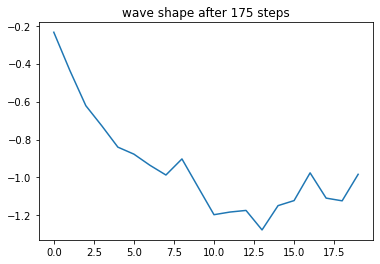

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_175/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_175/model_weights.tf
generator loss:0.8404924439071552
-----------------------
total discriminator loss:0.6245504539218096
average true return:0.48398662122448805
-----------------------


 11%|█▏        | 176/1562 [25:50<4:47:12, 12.43s/it]

Training Step: 176
generator loss:0.8371977849956294
-----------------------
total discriminator loss:0.6180253113652094
average true return:0.481311495824806
-----------------------


 11%|█▏        | 177/1562 [25:55<3:54:14, 10.15s/it]

Training Step: 177
generator loss:0.8523365189374303
-----------------------
total discriminator loss:0.6106494489625054
average true return:0.4847533507031744
-----------------------


 11%|█▏        | 178/1562 [25:59<3:15:51,  8.49s/it]

Training Step: 178
generator loss:0.8545113189480665
-----------------------
total discriminator loss:0.6031310051356689
average true return:0.482147836923286
-----------------------


 11%|█▏        | 179/1562 [26:04<2:50:11,  7.38s/it]

Training Step: 179
generator loss:0.8682307596816545
-----------------------
total discriminator loss:0.6064941512032429
average true return:0.4866697184519493
-----------------------


 12%|█▏        | 180/1562 [26:09<2:32:02,  6.60s/it]

Training Step: 180
event_types: [1, 0, 1, 0, 2, 2, 1, 0, 1, 2, 0, 1, 2, 2, 3, 0, 2, 1, 0, 2]
mad_score: 0.7372
fid_score: 17469.471227635167
rule_score: 0.021


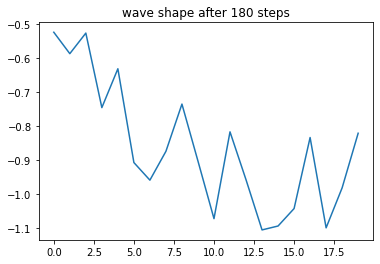

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_180/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_180/model_weights.tf
generator loss:0.8721291821259902
-----------------------
total discriminator loss:0.5953579921790604
average true return:0.48823443743852
-----------------------


 12%|█▏        | 181/1562 [26:35<4:47:19, 12.48s/it]

Training Step: 181
generator loss:0.8739624421074398
-----------------------
total discriminator loss:0.5939539722067047
average true return:0.4870733120340428
-----------------------


 12%|█▏        | 182/1562 [26:40<3:53:33, 10.15s/it]

Training Step: 182
generator loss:0.8845790744271074
-----------------------
total discriminator loss:0.5900565608071082
average true return:0.4862923184157673
-----------------------


 12%|█▏        | 183/1562 [26:45<3:17:24,  8.59s/it]

Training Step: 183
generator loss:0.8972072680181109
-----------------------
total discriminator loss:0.5820213384831306
average true return:0.48781818586740255
-----------------------


 12%|█▏        | 184/1562 [26:50<2:51:56,  7.49s/it]

Training Step: 184
generator loss:0.8958594171302502
-----------------------
total discriminator loss:0.5778123377386402
average true return:0.48820946339102006
-----------------------


 12%|█▏        | 185/1562 [26:55<2:32:37,  6.65s/it]

Training Step: 185
event_types: [3, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 2, 3, 2, 1, 2, 1, 3, 1]
mad_score: 0.746725
fid_score: 15947.888555990745
rule_score: 0.03525


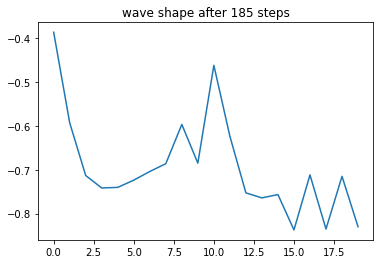

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_185/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_185/model_weights.tf
generator loss:0.9057807369202708
-----------------------
total discriminator loss:0.5791273754148928
average true return:0.4886475311431641
-----------------------


 12%|█▏        | 186/1562 [27:18<4:25:06, 11.56s/it]

Training Step: 186
generator loss:0.9110929275984427
-----------------------
total discriminator loss:0.5742426873249505
average true return:0.4910573257524689
-----------------------


 12%|█▏        | 187/1562 [27:22<3:38:09,  9.52s/it]

Training Step: 187
generator loss:0.9163793515956073
-----------------------
total discriminator loss:0.5727248459781369
average true return:0.49065166335129573
-----------------------


 12%|█▏        | 188/1562 [27:27<3:06:07,  8.13s/it]

Training Step: 188
generator loss:0.9268144169188313
-----------------------
total discriminator loss:0.5606668639330256
average true return:0.49067734404626595
-----------------------


 12%|█▏        | 189/1562 [27:32<2:43:31,  7.15s/it]

Training Step: 189
generator loss:0.9294362402000459
-----------------------
total discriminator loss:0.5563449924005519
average true return:0.49089825768351625
-----------------------


 12%|█▏        | 190/1562 [27:37<2:27:39,  6.46s/it]

Training Step: 190
event_types: [2, 2, 1, 3, 0, 1, 1, 3, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0]
mad_score: 0.7556
fid_score: 14288.517104724424
rule_score: 0.13025


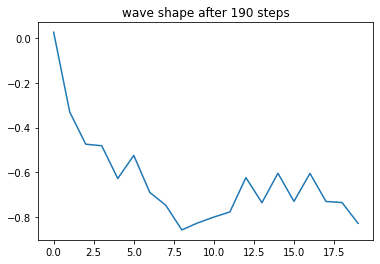

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_190/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_190/model_weights.tf
generator loss:0.9375591926295381
-----------------------
total discriminator loss:0.5661732065615197
average true return:0.48986104569375655
-----------------------


 12%|█▏        | 191/1562 [28:03<4:40:03, 12.26s/it]

Training Step: 191
generator loss:0.9313770229431895
-----------------------
total discriminator loss:0.5696083301975737
average true return:0.4904836276515462
-----------------------


 12%|█▏        | 192/1562 [28:07<3:47:17,  9.95s/it]

Training Step: 192
generator loss:0.9365995688874023
-----------------------
total discriminator loss:0.5484866680958697
average true return:0.4974331777111191
-----------------------


 12%|█▏        | 193/1562 [28:12<3:10:40,  8.36s/it]

Training Step: 193
generator loss:0.9375332341383646
-----------------------
total discriminator loss:0.5577399098619578
average true return:0.4949602056649911
-----------------------


 12%|█▏        | 194/1562 [28:17<2:46:34,  7.31s/it]

Training Step: 194
generator loss:0.9442263732448632
-----------------------
total discriminator loss:0.5467264929498166
average true return:0.49569768686605176
-----------------------


 12%|█▏        | 195/1562 [28:22<2:29:32,  6.56s/it]

Training Step: 195
event_types: [2, 3, 0, 1, 0, 0, 1, 2, 3, 0, 2, 0, 1, 0, 1, 1, 2, 2, 0, 1]
mad_score: 0.7542125
fid_score: 12659.412924119604
rule_score: 0.45175


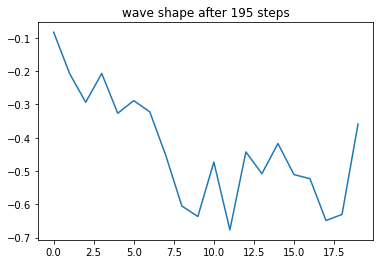

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_195/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_195/model_weights.tf
generator loss:0.949782437155926
-----------------------
total discriminator loss:0.5584727700113672
average true return:0.4947172633178293
-----------------------


 13%|█▎        | 196/1562 [28:48<4:47:03, 12.61s/it]

Training Step: 196
generator loss:0.9537270694040567
-----------------------
total discriminator loss:0.552251335799684
average true return:0.4966746515066922
-----------------------


 13%|█▎        | 197/1562 [28:53<3:52:57, 10.24s/it]

Training Step: 197
generator loss:0.9601989330131345
-----------------------
total discriminator loss:0.5484178485595266
average true return:0.5010739054604186
-----------------------


 13%|█▎        | 198/1562 [28:58<3:15:53,  8.62s/it]

Training Step: 198
generator loss:0.9646051495733545
-----------------------
total discriminator loss:0.5570943853715227
average true return:0.490631982275157
-----------------------


 13%|█▎        | 199/1562 [29:03<2:49:42,  7.47s/it]

Training Step: 199
generator loss:0.9742827382080088
-----------------------
total discriminator loss:0.5503509623042444
average true return:0.4917375464903372
-----------------------


 13%|█▎        | 200/1562 [29:07<2:30:52,  6.65s/it]

Training Step: 200
event_types: [0, 2, 2, 1, 1, 1, 3, 2, 1, 0, 1, 2, 1, 0, 2, 1, 1, 1, 2, 1]
mad_score: 0.75345
fid_score: 11277.080361828284
rule_score: 0.55425


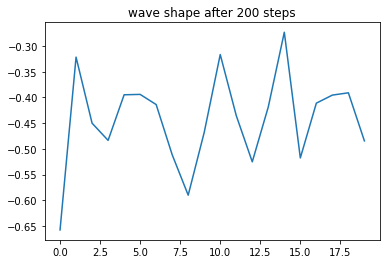

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_200/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_200/model_weights.tf
generator loss:0.9873808393889221
-----------------------
total discriminator loss:0.5470818261525024
average true return:0.49284648376730744
-----------------------


 13%|█▎        | 201/1562 [29:33<4:41:31, 12.41s/it]

Training Step: 201
generator loss:0.9838393263916879
-----------------------
total discriminator loss:0.5470039039345064
average true return:0.4928278670515205
-----------------------


 13%|█▎        | 202/1562 [29:38<3:52:00, 10.24s/it]

Training Step: 202
generator loss:0.9899249132283354
-----------------------
total discriminator loss:0.5549510720976633
average true return:0.49337308081075637
-----------------------


 13%|█▎        | 203/1562 [29:43<3:15:10,  8.62s/it]

Training Step: 203
generator loss:0.9676105866401801
-----------------------
total discriminator loss:0.5456270297057757
average true return:0.502212250660873
-----------------------


 13%|█▎        | 204/1562 [29:48<2:48:28,  7.44s/it]

Training Step: 204
generator loss:0.973602538247749
-----------------------
total discriminator loss:0.5530016116897618
average true return:0.488647156122359
-----------------------


 13%|█▎        | 205/1562 [29:53<2:29:29,  6.61s/it]

Training Step: 205
event_types: [2, 2, 2, 2, 1, 1, 3, 1, 2, 0, 1, 2, 2, 1, 1, 1, 0, 2, 3, 1]
mad_score: 0.7469875
fid_score: 10239.297125490757
rule_score: 0.5535


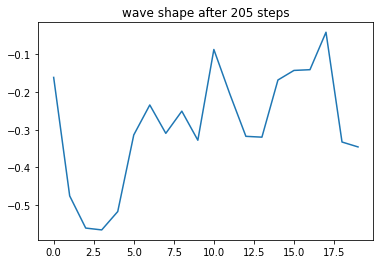

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_205/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_205/model_weights.tf
generator loss:0.9715757487279398
-----------------------
total discriminator loss:0.5678220083138243
average true return:0.49680736729758945
-----------------------


 13%|█▎        | 206/1562 [30:18<4:37:43, 12.29s/it]

Training Step: 206
generator loss:0.9613306763812013
-----------------------
total discriminator loss:0.562808860970184
average true return:0.5016717105127395
-----------------------


 13%|█▎        | 207/1562 [30:23<3:47:04, 10.05s/it]

Training Step: 207
generator loss:0.9675493768481054
-----------------------
total discriminator loss:0.5740362238046408
average true return:0.4937032852846667
-----------------------


 13%|█▎        | 208/1562 [30:28<3:11:57,  8.51s/it]

Training Step: 208
generator loss:0.9735813830976527
-----------------------
total discriminator loss:0.5725107143460261
average true return:0.49810769077654554
-----------------------


 13%|█▎        | 209/1562 [30:33<2:46:26,  7.38s/it]

Training Step: 209
generator loss:0.9704912517438761
-----------------------
total discriminator loss:0.5620004280207094
average true return:0.49885327452641703
-----------------------


 13%|█▎        | 210/1562 [30:37<2:28:52,  6.61s/it]

Training Step: 210
event_types: [1, 2, 2, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 2, 2, 0, 3, 1, 2]
mad_score: 0.7417625
fid_score: 9605.692761419396
rule_score: 0.55075


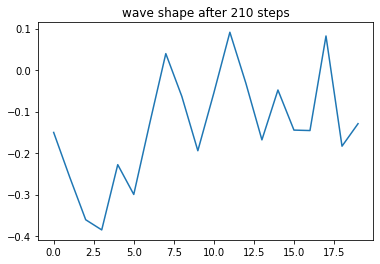

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_210/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_210/model_weights.tf
generator loss:0.9530203496381511
-----------------------
total discriminator loss:0.5755574023191241
average true return:0.49783145808614365
-----------------------


 14%|█▎        | 211/1562 [31:03<4:35:09, 12.22s/it]

Training Step: 211
generator loss:0.9554838784602276
-----------------------
total discriminator loss:0.5989498011388692
average true return:0.4938759564976265
-----------------------


 14%|█▎        | 212/1562 [31:06<3:36:14,  9.61s/it]

Training Step: 212
generator loss:0.9629863788766337
-----------------------
total discriminator loss:0.6054914552622201
average true return:0.4807354775281314
-----------------------


 14%|█▎        | 213/1562 [31:11<3:01:46,  8.09s/it]

Training Step: 213
generator loss:0.9499445518007933
-----------------------
total discriminator loss:0.6268361043975715
average true return:0.476218634278439
-----------------------


 14%|█▎        | 214/1562 [31:15<2:38:09,  7.04s/it]

Training Step: 214
generator loss:0.9676418627251228
-----------------------
total discriminator loss:0.6184785736531249
average true return:0.487514983257916
-----------------------


 14%|█▍        | 215/1562 [31:20<2:22:21,  6.34s/it]

Training Step: 215
event_types: [1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 1, 0, 1, 1, 1, 2, 2, 1, 0]
mad_score: 0.7273625
fid_score: 9421.125087036015
rule_score: 0.559


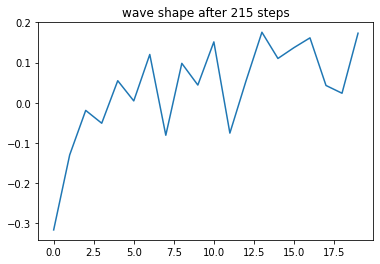

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_215/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_215/model_weights.tf
generator loss:0.9270325078411288
-----------------------
total discriminator loss:0.6419957735519916
average true return:0.47471890098523695
-----------------------


 14%|█▍        | 216/1562 [31:47<4:39:30, 12.46s/it]

Training Step: 216
generator loss:0.92176560330815
-----------------------
total discriminator loss:0.6194352375535376
average true return:0.491105240050879
-----------------------


 14%|█▍        | 217/1562 [31:52<3:48:17, 10.18s/it]

Training Step: 217
generator loss:0.9127526039825583
-----------------------
total discriminator loss:0.6506312335362048
average true return:0.47490282550344065
-----------------------


 14%|█▍        | 218/1562 [31:56<3:11:35,  8.55s/it]

Training Step: 218
generator loss:0.8921496776799117
-----------------------
total discriminator loss:0.6577162453136833
average true return:0.47861683951163125
-----------------------


 14%|█▍        | 219/1562 [32:01<2:47:48,  7.50s/it]

Training Step: 219
generator loss:0.898275476538313
-----------------------
total discriminator loss:0.6450560840232247
average true return:0.4879607364005069
-----------------------


 14%|█▍        | 220/1562 [32:06<2:29:38,  6.69s/it]

Training Step: 220
event_types: [1, 2, 3, 2, 3, 2, 0, 2, 2, 2, 1, 0, 0, 1, 2, 0, 3, 1, 2, 1]
mad_score: 0.7152875
fid_score: 9678.495395877331
rule_score: 0.55825


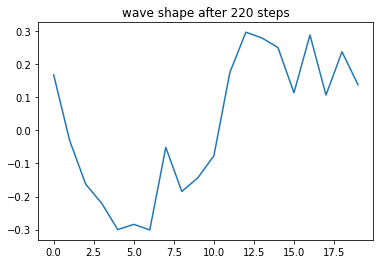

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_220/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_220/model_weights.tf
generator loss:0.8921168128855406
-----------------------
total discriminator loss:0.6840286564741782
average true return:0.4904381386564863
-----------------------


 14%|█▍        | 221/1562 [32:33<4:40:28, 12.55s/it]

Training Step: 221
generator loss:0.8721762099178487
-----------------------
total discriminator loss:0.657298784702268
average true return:0.48254542285601976
-----------------------


 14%|█▍        | 222/1562 [32:37<3:47:18, 10.18s/it]

Training Step: 222
generator loss:0.8716723375834264
-----------------------
total discriminator loss:0.7034910300574639
average true return:0.4763371209197868
-----------------------


 14%|█▍        | 223/1562 [32:42<3:10:52,  8.55s/it]

Training Step: 223
generator loss:0.8763353985846982
-----------------------
total discriminator loss:0.7232526778260024
average true return:0.4514005075016617
-----------------------


 14%|█▍        | 224/1562 [32:47<2:44:52,  7.39s/it]

Training Step: 224
generator loss:0.8572154588425476
-----------------------
total discriminator loss:0.718182569368316
average true return:0.45570220103056597
-----------------------


 14%|█▍        | 225/1562 [32:51<2:27:43,  6.63s/it]

Training Step: 225
event_types: [0, 2, 2, 3, 3, 1, 2, 2, 2, 3, 1, 0, 2, 1, 3, 1, 1, 2, 0, 1]
mad_score: 0.6988625
fid_score: 10383.885833423243
rule_score: 0.5595


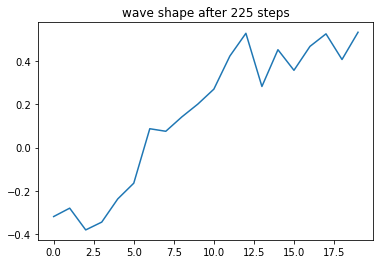

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_225/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_225/model_weights.tf
generator loss:0.859232868072306
-----------------------
total discriminator loss:0.715740742240034
average true return:0.4444635402194511
-----------------------


 14%|█▍        | 226/1562 [33:18<4:41:05, 12.62s/it]

Training Step: 226
generator loss:0.8927519837850989
-----------------------
total discriminator loss:0.7058418148219576
average true return:0.45449660649528045
-----------------------


 15%|█▍        | 227/1562 [33:23<3:48:57, 10.29s/it]

Training Step: 227
generator loss:0.8664775700448875
-----------------------
total discriminator loss:0.726418289712585
average true return:0.43284745517660494
-----------------------


 15%|█▍        | 228/1562 [33:28<3:12:05,  8.64s/it]

Training Step: 228
generator loss:0.8693855022783168
-----------------------
total discriminator loss:0.7109231129399811
average true return:0.43719733012969964
-----------------------


 15%|█▍        | 229/1562 [33:32<2:45:21,  7.44s/it]

Training Step: 229
generator loss:0.864026452626697
-----------------------
total discriminator loss:0.7213100978549306
average true return:0.45819414801631453
-----------------------


 15%|█▍        | 230/1562 [33:37<2:28:53,  6.71s/it]

Training Step: 230
event_types: [3, 2, 0, 1, 1, 1, 0, 2, 1, 0, 1, 2, 1, 0, 2, 2, 0, 3, 2, 2]
mad_score: 0.675625
fid_score: 11421.921386979751
rule_score: 0.57025


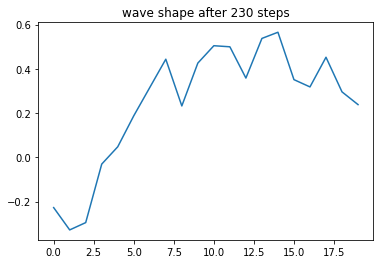

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_230/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_230/model_weights.tf
generator loss:0.8595635368209485
-----------------------
total discriminator loss:0.7061868300184313
average true return:0.45889042399736435
-----------------------


 15%|█▍        | 231/1562 [34:04<4:40:29, 12.64s/it]

Training Step: 231
generator loss:0.8581991235261128
-----------------------
total discriminator loss:0.7063215004321464
average true return:0.45935060658502314
-----------------------


 15%|█▍        | 232/1562 [34:09<3:47:47, 10.28s/it]

Training Step: 232
generator loss:0.8475212970474261
-----------------------
total discriminator loss:0.7024906391222846
average true return:0.456341457758766
-----------------------


 15%|█▍        | 233/1562 [34:13<3:10:54,  8.62s/it]

Training Step: 233
generator loss:0.8514035763578658
-----------------------
total discriminator loss:0.6985786891209025
average true return:0.45227901523752834
-----------------------


 15%|█▍        | 234/1562 [34:18<2:43:06,  7.37s/it]

Training Step: 234
generator loss:0.8594682605211219
-----------------------
total discriminator loss:0.6879421751554601
average true return:0.4533629516450633
-----------------------


 15%|█▌        | 235/1562 [34:23<2:26:11,  6.61s/it]

Training Step: 235
event_types: [0, 2, 2, 0, 2, 1, 0, 1, 2, 1, 3, 2, 0, 2, 1, 2, 1, 2, 3, 2]
mad_score: 0.65275
fid_score: 12497.62558828882
rule_score: 0.5695


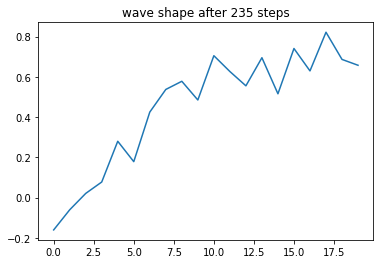

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_235/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_235/model_weights.tf
generator loss:0.8541864798211201
-----------------------
total discriminator loss:0.6796791868812372
average true return:0.45523689312662285
-----------------------


 15%|█▌        | 236/1562 [34:48<4:31:36, 12.29s/it]

Training Step: 236
generator loss:0.841685358095233
-----------------------
total discriminator loss:0.6693438472994995
average true return:0.45742340025134365
-----------------------


 15%|█▌        | 237/1562 [34:53<3:39:37,  9.95s/it]

Training Step: 237
generator loss:0.8354186664793313
-----------------------
total discriminator loss:0.6536539714840742
average true return:0.4731937498391535
-----------------------


 15%|█▌        | 238/1562 [34:55<2:49:10,  7.67s/it]

Training Step: 238
generator loss:0.8446138856702571
-----------------------


 15%|█▌        | 239/1562 [34:57<2:13:47,  6.07s/it]

total discriminator loss:0.6455649047285995
average true return:0.47520354594281294
-----------------------
Training Step: 239
generator loss:0.8481098696816675
-----------------------
total discriminator loss:0.6405013729864305
average true return:0.4744608801232597
-----------------------


 15%|█▌        | 240/1562 [35:00<1:49:12,  4.96s/it]

Training Step: 240
event_types: [3, 3, 0, 2, 2, 0, 2, 1, 3, 2, 1, 2, 0, 1, 2, 1, 0, 2, 1, 2]
mad_score: 0.6278
fid_score: 13230.276109016148
rule_score: 0.5785


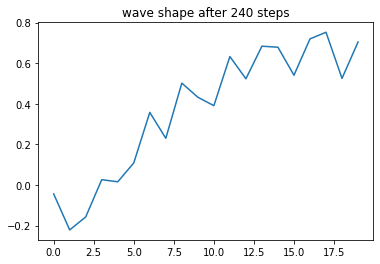

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_240/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_240/model_weights.tf
generator loss:0.8505279423270253
-----------------------


 15%|█▌        | 241/1562 [35:13<2:46:38,  7.57s/it]

total discriminator loss:0.6424067664158772
average true return:0.4870507503503515
-----------------------
Training Step: 241
generator loss:0.8410977432813747
-----------------------
total discriminator loss:0.6363252935909279
average true return:0.48680567849689604
-----------------------


 15%|█▌        | 242/1562 [35:16<2:11:19,  5.97s/it]

Training Step: 242
generator loss:0.8609063741838852
-----------------------
total discriminator loss:0.6189810117280006
average true return:0.49216563251997936
-----------------------


 16%|█▌        | 243/1562 [35:18<1:47:02,  4.87s/it]

Training Step: 243
generator loss:0.8627850158806036
-----------------------
total discriminator loss:0.8042393633986291
average true return:0.4967849351555088
-----------------------


 16%|█▌        | 244/1562 [35:20<1:31:48,  4.18s/it]

Training Step: 244
generator loss:0.8523674663805663
-----------------------
total discriminator loss:0.6123206313185081
average true return:0.5048435771406962
-----------------------


 16%|█▌        | 245/1562 [35:23<1:19:39,  3.63s/it]

Training Step: 245
event_types: [2, 2, 1, 1, 1, 0, 2, 2, 2, 2, 1, 3, 1, 2, 1, 2, 1, 1, 1, 2]
mad_score: 0.6057875
fid_score: 13335.314683365246
rule_score: 0.59875


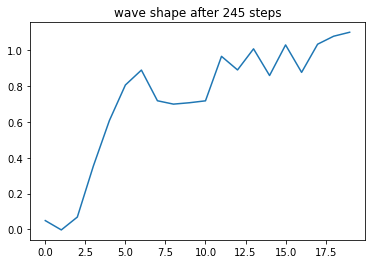

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_245/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_245/model_weights.tf
generator loss:0.855387886333898
-----------------------
total discriminator loss:0.5995219498986297
average true return:0.4971112123958757
-----------------------


 16%|█▌        | 246/1562 [35:37<2:28:54,  6.79s/it]

Training Step: 246
generator loss:0.8510102002863227
-----------------------
total discriminator loss:0.5900463528013531
average true return:0.49946611666827245
-----------------------


 16%|█▌        | 247/1562 [35:39<1:59:54,  5.47s/it]

Training Step: 247
generator loss:0.8606480188214591
-----------------------
total discriminator loss:0.5834751388236337
average true return:0.5046624521858243
-----------------------


 16%|█▌        | 248/1562 [35:42<1:39:59,  4.57s/it]

Training Step: 248
generator loss:0.8698392386443168
-----------------------
total discriminator loss:0.5943132608487105
average true return:0.5045915633339021
-----------------------


 16%|█▌        | 249/1562 [35:44<1:25:04,  3.89s/it]

Training Step: 249
generator loss:0.852120065132117
-----------------------
total discriminator loss:0.5751249106691618
average true return:0.5064103772590942
-----------------------


 16%|█▌        | 250/1562 [35:46<1:13:24,  3.36s/it]

Training Step: 250
event_types: [3, 1, 3, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0]
mad_score: 0.5856375
fid_score: 12883.271822343519
rule_score: 0.601


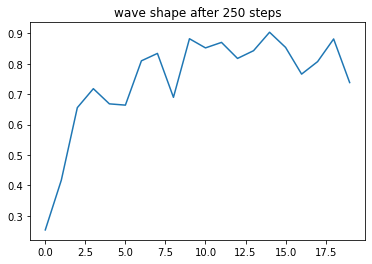

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_250/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_250/model_weights.tf
generator loss:0.8795078591175445
-----------------------
total discriminator loss:0.5877631954644122
average true return:0.4996493725097131
-----------------------


 16%|█▌        | 251/1562 [36:10<3:25:30,  9.41s/it]

Training Step: 251
generator loss:0.8816647694768273
-----------------------
total discriminator loss:0.5792584286663778
average true return:0.5023132168074786
-----------------------


 16%|█▌        | 252/1562 [36:14<2:54:32,  7.99s/it]

Training Step: 252
generator loss:0.9210653926680381
-----------------------
total discriminator loss:0.5789816253169262
average true return:0.49641285773433935
-----------------------


 16%|█▌        | 253/1562 [36:19<2:33:53,  7.05s/it]

Training Step: 253
generator loss:0.9208577936431103
-----------------------
total discriminator loss:0.8729123865645079
average true return:0.4944179714208064
-----------------------


 16%|█▋        | 254/1562 [36:24<2:19:45,  6.41s/it]

Training Step: 254
generator loss:0.9293257432850743
-----------------------
total discriminator loss:0.5698182344072862
average true return:0.4925058722322149
-----------------------


 16%|█▋        | 255/1562 [36:29<2:07:55,  5.87s/it]

Training Step: 255
event_types: [1, 3, 2, 2, 2, 1, 2, 0, 2, 2, 2, 3, 2, 0, 2, 1, 2, 0, 2, 2]
mad_score: 0.5686125
fid_score: 12073.986142501632
rule_score: 0.61425


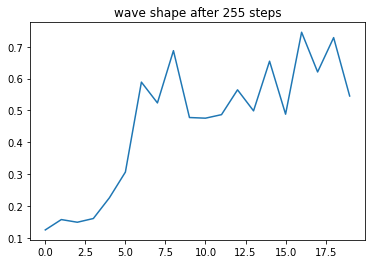

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_255/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_255/model_weights.tf
generator loss:0.9236207210585811
-----------------------
total discriminator loss:0.573246883987133
average true return:0.49179759205047435
-----------------------


 16%|█▋        | 256/1562 [36:55<4:20:39, 11.98s/it]

Training Step: 256
generator loss:0.945266899571729
-----------------------
total discriminator loss:0.5715272814137786
average true return:0.48788642678905997
-----------------------


 16%|█▋        | 257/1562 [37:00<3:33:34,  9.82s/it]

Training Step: 257
generator loss:0.9474483972641117
-----------------------
total discriminator loss:0.5673003355859034
average true return:0.49002295902544296
-----------------------


 17%|█▋        | 258/1562 [37:05<3:00:20,  8.30s/it]

Training Step: 258
generator loss:0.9512580807685886
-----------------------
total discriminator loss:0.5667125179751094
average true return:0.47988252010997023
-----------------------


 17%|█▋        | 259/1562 [37:10<2:38:45,  7.31s/it]

Training Step: 259
generator loss:0.9454382832960225
-----------------------
total discriminator loss:0.5693382293987332
average true return:0.48989898392822184
-----------------------


 17%|█▋        | 260/1562 [37:14<2:20:43,  6.49s/it]

Training Step: 260
event_types: [0, 2, 3, 1, 1, 2, 3, 2, 2, 3, 2, 1, 0, 3, 1, 1, 0, 1, 0, 2]
mad_score: 0.5585625
fid_score: 11240.380085374918
rule_score: 0.6185


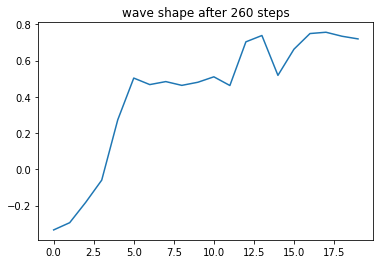

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_260/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_260/model_weights.tf
generator loss:0.949130636909748
-----------------------
total discriminator loss:0.56395186743263
average true return:0.48176152243951786
-----------------------


 17%|█▋        | 261/1562 [37:41<4:31:50, 12.54s/it]

Training Step: 261
generator loss:0.9512303843504589
-----------------------
total discriminator loss:0.5696514818129886
average true return:0.48837760492382476
-----------------------


 17%|█▋        | 262/1562 [37:46<3:41:20, 10.22s/it]

Training Step: 262
generator loss:0.9273098159229399
-----------------------
total discriminator loss:0.56336177609338
average true return:0.48414519317508764
-----------------------


 17%|█▋        | 263/1562 [37:50<3:05:48,  8.58s/it]

Training Step: 263
generator loss:0.9367782974402785
-----------------------
total discriminator loss:0.5834093436638594
average true return:0.4967332803749527
-----------------------


 17%|█▋        | 264/1562 [37:55<2:40:38,  7.43s/it]

Training Step: 264
generator loss:0.9408017986912355
-----------------------
total discriminator loss:0.5645633765957314
average true return:0.4927232052231877
-----------------------


 17%|█▋        | 265/1562 [38:00<2:22:05,  6.57s/it]

Training Step: 265
event_types: [2, 0, 3, 1, 0, 3, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 1, 0, 2, 1]
mad_score: 0.5524125
fid_score: 10443.562977801597
rule_score: 0.6225


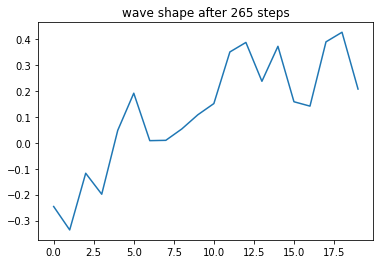

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_265/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_265/model_weights.tf
generator loss:0.9317090838182298
-----------------------
total discriminator loss:0.5724084856504233
average true return:0.4951630763389535
-----------------------


 17%|█▋        | 266/1562 [38:26<4:32:13, 12.60s/it]

Training Step: 266
generator loss:0.9341794441370572
-----------------------
total discriminator loss:0.565906324229957
average true return:0.495013432028546
-----------------------


 17%|█▋        | 267/1562 [38:31<3:42:02, 10.29s/it]

Training Step: 267
generator loss:0.9466793514528111
-----------------------
total discriminator loss:0.5647502358907659
average true return:0.4966780788143844
-----------------------


 17%|█▋        | 268/1562 [38:36<3:06:29,  8.65s/it]

Training Step: 268
generator loss:0.9255668174112892
-----------------------
total discriminator loss:0.571729107372912
average true return:0.48864048457878956
-----------------------


 17%|█▋        | 269/1562 [38:41<2:41:20,  7.49s/it]

Training Step: 269
generator loss:0.9242143457248004
-----------------------
total discriminator loss:0.8531160478718354
average true return:0.5012580623411628
-----------------------


 17%|█▋        | 270/1562 [38:45<2:22:22,  6.61s/it]

Training Step: 270
event_types: [0, 2, 2, 2, 2, 1, 3, 2, 2, 0, 1, 3, 2, 3, 1, 2, 1, 0, 2, 1]
mad_score: 0.5493125
fid_score: 9795.791292719165
rule_score: 0.628


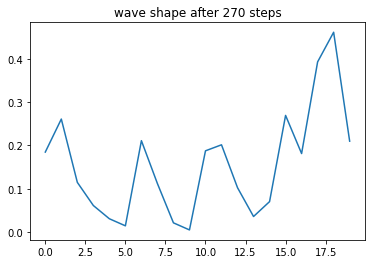

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_270/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_270/model_weights.tf
generator loss:0.9142022111381604
-----------------------
total discriminator loss:0.5715440501925797
average true return:0.5058905357582879
-----------------------


 17%|█▋        | 271/1562 [39:12<4:28:37, 12.48s/it]

Training Step: 271
generator loss:0.893146549260466
-----------------------
total discriminator loss:0.5782081051265884
average true return:0.5034571817385994
-----------------------


 17%|█▋        | 272/1562 [39:16<3:38:43, 10.17s/it]

Training Step: 272
generator loss:0.8932159046849215
-----------------------
total discriminator loss:0.5822421591739583
average true return:0.5044817832435704
-----------------------


 17%|█▋        | 273/1562 [39:21<3:04:22,  8.58s/it]

Training Step: 273
generator loss:0.8874177665158208
-----------------------
total discriminator loss:0.5926401695492092
average true return:0.5092222711283938
-----------------------


 18%|█▊        | 274/1562 [39:25<2:32:44,  7.12s/it]

Training Step: 274
generator loss:0.877762708647706
-----------------------
total discriminator loss:0.5901395692607376
average true return:0.5067188346478315
-----------------------


 18%|█▊        | 275/1562 [39:30<2:16:25,  6.36s/it]

Training Step: 275
event_types: [2, 2, 1, 0, 2, 1, 1, 0, 2, 0, 1, 0, 1, 2, 1, 0, 2, 1, 2, 1]
mad_score: 0.550325
fid_score: 9308.52453204622
rule_score: 0.61775


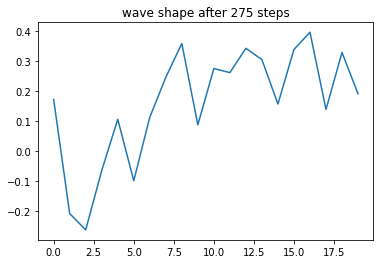

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_275/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_275/model_weights.tf
generator loss:0.8680435257377552
-----------------------
total discriminator loss:0.5982255628376356
average true return:0.5033065304242617
-----------------------


 18%|█▊        | 276/1562 [39:54<4:14:21, 11.87s/it]

Training Step: 276
generator loss:0.88628276600489
-----------------------
total discriminator loss:0.6014425747855489
average true return:0.501269188869013
-----------------------


 18%|█▊        | 277/1562 [39:59<3:28:02,  9.71s/it]

Training Step: 277
generator loss:0.8825173031269156
-----------------------
total discriminator loss:0.8284768471003843
average true return:0.49669153541819644
-----------------------


 18%|█▊        | 278/1562 [40:04<2:56:24,  8.24s/it]

Training Step: 278
generator loss:0.8858620801142045
-----------------------
total discriminator loss:0.6149183671620901
average true return:0.4973769391864377
-----------------------


 18%|█▊        | 279/1562 [40:09<2:34:20,  7.22s/it]

Training Step: 279
generator loss:0.8624159998251202
-----------------------
total discriminator loss:0.6116913262404409
average true return:0.49700619918723404
-----------------------


 18%|█▊        | 280/1562 [40:14<2:19:33,  6.53s/it]

Training Step: 280
event_types: [2, 3, 2, 0, 1, 1, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 3, 3, 3, 2]
mad_score: 0.5502625
fid_score: 9018.370577306023
rule_score: 0.60875


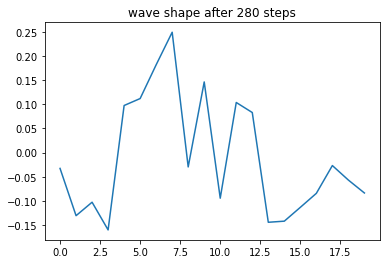

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_280/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_280/model_weights.tf
generator loss:0.8417332491310509
-----------------------
total discriminator loss:0.6199604609092869
average true return:0.5000620547999314
-----------------------


 18%|█▊        | 281/1562 [40:40<4:26:18, 12.47s/it]

Training Step: 281
generator loss:0.839555065106324
-----------------------
total discriminator loss:0.6479177952511983
average true return:0.4885526042646556
-----------------------


 18%|█▊        | 282/1562 [40:45<3:37:14, 10.18s/it]

Training Step: 282
generator loss:0.8262873598943224
-----------------------
total discriminator loss:0.6351573192376028
average true return:0.48986400525766344
-----------------------


 18%|█▊        | 283/1562 [40:49<3:02:29,  8.56s/it]

Training Step: 283
generator loss:0.8789468745030458
-----------------------
total discriminator loss:0.6486811474012231
average true return:0.48819664354835224
-----------------------


 18%|█▊        | 284/1562 [40:54<2:38:20,  7.43s/it]

Training Step: 284
generator loss:0.8158586794084421
-----------------------
total discriminator loss:0.6441612546275675
average true return:0.49477870024150483
-----------------------


 18%|█▊        | 285/1562 [40:59<2:20:33,  6.60s/it]

Training Step: 285
event_types: [2, 1, 1, 2, 0, 2, 2, 1, 2, 2, 0, 0, 2, 1, 2, 2, 3, 2, 2, 2]
mad_score: 0.5550875
fid_score: 8942.094959357517
rule_score: 0.61175


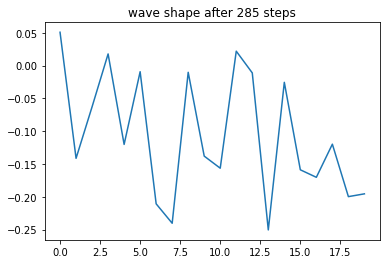

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_285/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_285/model_weights.tf
generator loss:0.8322107958981373
-----------------------
total discriminator loss:0.6435812674197896
average true return:0.49391690132480687
-----------------------


 18%|█▊        | 286/1562 [41:25<4:23:42, 12.40s/it]

Training Step: 286
generator loss:0.8142186855315774
-----------------------
total discriminator loss:0.6623350672913749
average true return:0.508466987512327
-----------------------


 18%|█▊        | 287/1562 [41:30<3:34:07, 10.08s/it]

Training Step: 287
generator loss:0.7879870185922362
-----------------------
total discriminator loss:0.6579882437556283
average true return:0.5093142991027405
-----------------------


 18%|█▊        | 288/1562 [41:34<3:01:10,  8.53s/it]

Training Step: 288
generator loss:0.7601314149456706
-----------------------
total discriminator loss:0.660941976475651
average true return:0.5107366834413964
-----------------------


 19%|█▊        | 289/1562 [41:39<2:37:45,  7.44s/it]

Training Step: 289
generator loss:0.7804242482672064
-----------------------
total discriminator loss:0.6812726204011121
average true return:0.5029484733584759
-----------------------


 19%|█▊        | 290/1562 [41:44<2:20:49,  6.64s/it]

Training Step: 290
event_types: [1, 2, 0, 2, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 3, 0, 1, 1, 3, 1]
mad_score: 0.5607375
fid_score: 9107.214339026443
rule_score: 0.60075


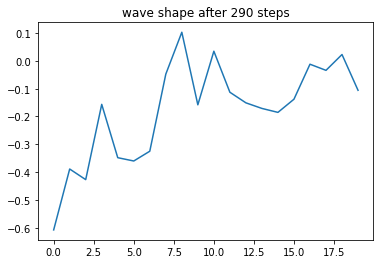

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_290/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_290/model_weights.tf
generator loss:0.808425269979127
-----------------------
total discriminator loss:0.6653372361157093
average true return:0.5060181948389315
-----------------------


 19%|█▊        | 291/1562 [42:10<4:23:39, 12.45s/it]

Training Step: 291
generator loss:0.7818656776094024
-----------------------
total discriminator loss:0.6689010275469229
average true return:0.5081587202137521
-----------------------


 19%|█▊        | 292/1562 [42:15<3:35:14, 10.17s/it]

Training Step: 292
generator loss:0.818829271770647
-----------------------
total discriminator loss:0.6782184561588644
average true return:0.5059400445140938
-----------------------


 19%|█▉        | 293/1562 [42:20<3:01:10,  8.57s/it]

Training Step: 293
generator loss:0.8140118157117421
-----------------------
total discriminator loss:0.6843855429828688
average true return:0.4975309936752909
-----------------------


 19%|█▉        | 294/1562 [42:25<2:37:37,  7.46s/it]

Training Step: 294
generator loss:0.8057929108288786
-----------------------
total discriminator loss:0.816896481362255
average true return:0.5007762561730043
-----------------------


 19%|█▉        | 295/1562 [42:29<2:20:21,  6.65s/it]

Training Step: 295
event_types: [1, 3, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 3, 1, 2, 0, 2, 1, 0]
mad_score: 0.568825
fid_score: 9506.416743410791
rule_score: 0.59175


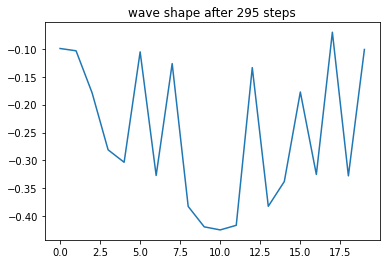

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_295/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_295/model_weights.tf
generator loss:0.8276547783272772
-----------------------
total discriminator loss:0.6634689033367812
average true return:0.4946050625698254
-----------------------


 19%|█▉        | 296/1562 [42:56<4:26:19, 12.62s/it]

Training Step: 296
generator loss:0.8446164517534237
-----------------------
total discriminator loss:0.6654744459477728
average true return:0.49848165116043675
-----------------------


 19%|█▉        | 297/1562 [43:01<3:36:28, 10.27s/it]

Training Step: 297
generator loss:0.8282644231812212
-----------------------
total discriminator loss:0.6704130897029095
average true return:0.49497265055540696
-----------------------


 19%|█▉        | 298/1562 [43:06<3:01:46,  8.63s/it]

Training Step: 298
generator loss:0.8095582229304663
-----------------------
total discriminator loss:0.6746027073329924
average true return:0.48358186181149737
-----------------------


 19%|█▉        | 299/1562 [43:10<2:36:51,  7.45s/it]

Training Step: 299
generator loss:0.8402349657999468
-----------------------
total discriminator loss:0.6599367821634962
average true return:0.4965053995839189
-----------------------


 19%|█▉        | 300/1562 [43:15<2:18:59,  6.61s/it]

Training Step: 300
event_types: [3, 2, 1, 2, 0, 2, 3, 3, 1, 0, 1, 1, 0, 3, 0, 2, 1, 2, 0, 2]
mad_score: 0.5753125
fid_score: 10123.297978986127
rule_score: 0.58775


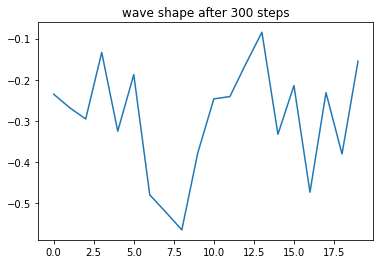

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_300/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_300/model_weights.tf
generator loss:0.8284702596278539
-----------------------
total discriminator loss:0.6355410458964198
average true return:0.5130541141292382
-----------------------


 19%|█▉        | 301/1562 [43:40<4:17:12, 12.24s/it]

Training Step: 301
generator loss:0.8297112415710447
-----------------------
total discriminator loss:0.6386354997583674
average true return:0.5097646181278034
-----------------------


 19%|█▉        | 302/1562 [43:45<3:30:07, 10.01s/it]

Training Step: 302
generator loss:0.8640651364122975
-----------------------
total discriminator loss:0.609946393794403
average true return:0.523174416376402
-----------------------


 19%|█▉        | 303/1562 [43:50<2:56:59,  8.43s/it]

Training Step: 303
generator loss:0.8764515890160741
-----------------------
total discriminator loss:0.6205618270567229
average true return:0.5036695291042739
-----------------------


 19%|█▉        | 304/1562 [43:55<2:35:17,  7.41s/it]

Training Step: 304
generator loss:0.890231884525884
-----------------------
total discriminator loss:0.6279749910321721
average true return:0.49189210459577937
-----------------------


 20%|█▉        | 305/1562 [44:00<2:17:53,  6.58s/it]

Training Step: 305
event_types: [1, 1, 2, 3, 1, 2, 1, 0, 2, 1, 0, 3, 2, 2, 3, 3, 1, 2, 0, 1]
mad_score: 0.5799875
fid_score: 10926.234321557342
rule_score: 0.49025


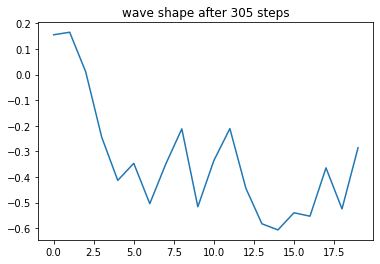

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_305/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_305/model_weights.tf
generator loss:0.9215701147617674
-----------------------
total discriminator loss:0.8695904444609557
average true return:0.49269326475250763
-----------------------


 20%|█▉        | 306/1562 [44:26<4:20:46, 12.46s/it]

Training Step: 306
generator loss:0.9146189045968791
-----------------------
total discriminator loss:0.5834361513255271
average true return:0.5017688270862223
-----------------------


 20%|█▉        | 307/1562 [44:30<3:32:17, 10.15s/it]

Training Step: 307
generator loss:0.9330737918993306
-----------------------
total discriminator loss:0.5721146428090114
average true return:0.5123808513899675
-----------------------


 20%|█▉        | 308/1562 [44:35<2:59:12,  8.57s/it]

Training Step: 308
generator loss:0.8849186280032182
-----------------------
total discriminator loss:0.594601167120365
average true return:0.506891362861262
-----------------------


 20%|█▉        | 309/1562 [44:40<2:35:19,  7.44s/it]

Training Step: 309
generator loss:0.9447487025349135
-----------------------
total discriminator loss:0.9354587583204151
average true return:0.5132069508596584
-----------------------


 20%|█▉        | 310/1562 [44:45<2:19:03,  6.66s/it]

Training Step: 310
event_types: [1, 1, 3, 1, 2, 1, 1, 3, 2, 2, 2, 3, 1, 2, 0, 2, 3, 3, 3, 2]
mad_score: 0.5894875
fid_score: 11741.47913241915
rule_score: 0.28975


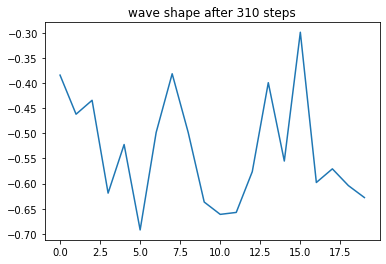

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_310/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_310/model_weights.tf
generator loss:0.9379508728885522
-----------------------
total discriminator loss:0.5603866852162214
average true return:0.5181406246189156
-----------------------


 20%|█▉        | 311/1562 [45:11<4:18:38, 12.40s/it]

Training Step: 311
generator loss:0.9523544866078328
-----------------------
total discriminator loss:0.529729211211543
average true return:0.5231808908986793
-----------------------


 20%|█▉        | 312/1562 [45:16<3:30:26, 10.10s/it]

Training Step: 312
generator loss:0.9527912831591729
-----------------------
total discriminator loss:0.5614066336807859
average true return:0.5068740562177568
-----------------------


 20%|██        | 313/1562 [45:20<2:57:23,  8.52s/it]

Training Step: 313
generator loss:0.9597561934132286
-----------------------
total discriminator loss:0.534497683717104
average true return:0.5276750067555892
-----------------------


 20%|██        | 314/1562 [45:25<2:34:58,  7.45s/it]

Training Step: 314
generator loss:0.9683419184230857
-----------------------
total discriminator loss:0.5434458565558972
average true return:0.5185182547553575
-----------------------


 20%|██        | 315/1562 [45:30<2:18:18,  6.65s/it]

Training Step: 315
event_types: [0, 3, 1, 2, 0, 2, 3, 1, 3, 2, 1, 2, 0, 2, 3, 0, 2, 2, 3, 3]
mad_score: 0.5989125
fid_score: 12510.870808144307
rule_score: 0.1535


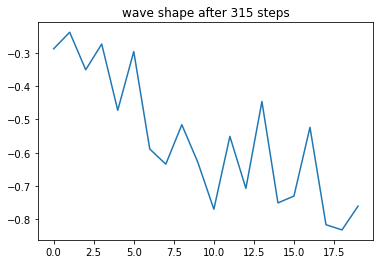

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_315/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_315/model_weights.tf
generator loss:0.9785276729657709
-----------------------
total discriminator loss:0.5338668178158213
average true return:0.5112615781100596
-----------------------


 20%|██        | 316/1562 [45:56<4:18:24, 12.44s/it]

Training Step: 316
generator loss:1.0263765766253288
-----------------------
total discriminator loss:0.525200459149217
average true return:0.5134449069453537
-----------------------


 20%|██        | 317/1562 [46:01<3:29:21, 10.09s/it]

Training Step: 317
generator loss:1.041880322446047
-----------------------
total discriminator loss:0.52288265701167
average true return:0.5117123570643248
-----------------------


 20%|██        | 318/1562 [46:06<2:57:05,  8.54s/it]

Training Step: 318
generator loss:1.0814490490189854
-----------------------
total discriminator loss:0.5246083561576725
average true return:0.4972798582382466
-----------------------


 20%|██        | 319/1562 [46:11<2:34:33,  7.46s/it]

Training Step: 319
generator loss:1.105951268299357
-----------------------
total discriminator loss:0.5139629044479059
average true return:0.48970053020197524
-----------------------


 20%|██        | 320/1562 [46:15<2:16:01,  6.57s/it]

Training Step: 320
event_types: [3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 0, 1, 3, 3, 2, 3, 0, 2, 2]
mad_score: 0.60335
fid_score: 12996.0855920406
rule_score: 0.10175


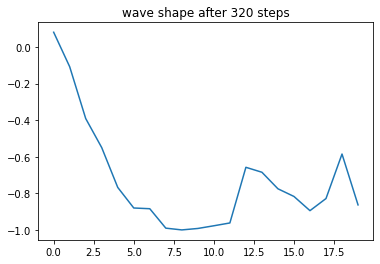

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_320/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_320/model_weights.tf
generator loss:1.13452608830818
-----------------------
total discriminator loss:0.47872964077551705
average true return:0.5106494357767237
-----------------------


 21%|██        | 321/1562 [46:41<4:13:19, 12.25s/it]

Training Step: 321
generator loss:1.1486986555045156
-----------------------
total discriminator loss:0.49167951089586653
average true return:0.4988159801145137
-----------------------


 21%|██        | 322/1562 [46:45<3:26:49, 10.01s/it]

Training Step: 322
generator loss:1.1541729703942358
-----------------------
total discriminator loss:0.49425617356987495
average true return:0.5016983072510348
-----------------------


 21%|██        | 323/1562 [46:50<2:54:50,  8.47s/it]

Training Step: 323
generator loss:1.148533114915598
-----------------------
total discriminator loss:0.5043618714795883
average true return:0.5088285768575092
-----------------------


 21%|██        | 324/1562 [46:55<2:31:42,  7.35s/it]

Training Step: 324
generator loss:1.141336801105806
-----------------------
total discriminator loss:0.46904394675972433
average true return:0.5127459958554565
-----------------------


 21%|██        | 325/1562 [47:00<2:15:15,  6.56s/it]

Training Step: 325
event_types: [1, 1, 2, 1, 2, 1, 2, 3, 2, 2, 0, 2, 2, 3, 2, 3, 3, 3, 3, 0]
mad_score: 0.6105
fid_score: 13108.159590127645
rule_score: 0.0855


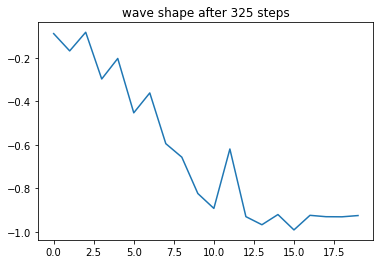

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_325/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_325/model_weights.tf
generator loss:1.1911210466410163
-----------------------


 21%|██        | 326/1562 [47:22<3:55:25, 11.43s/it]

total discriminator loss:0.43822307355742285
average true return:0.5151167876183248
-----------------------
Training Step: 326
generator loss:1.2137939543788794
-----------------------
total discriminator loss:0.44471818489623804
average true return:0.5179653706393843
-----------------------


 21%|██        | 327/1562 [47:26<3:08:14,  9.15s/it]

Training Step: 327
generator loss:1.2925785009050927
-----------------------
total discriminator loss:1.2139602493982562
average true return:0.5088758144333818
-----------------------


 21%|██        | 328/1562 [47:31<2:41:38,  7.86s/it]

Training Step: 328
generator loss:1.2680117285460402
-----------------------
total discriminator loss:0.4451693893674238
average true return:0.5136513363772293
-----------------------


 21%|██        | 329/1562 [47:36<2:23:25,  6.98s/it]

Training Step: 329
generator loss:1.2350533491289308
-----------------------
total discriminator loss:0.4420176713472953
average true return:0.515330716987616
-----------------------


 21%|██        | 330/1562 [47:41<2:10:50,  6.37s/it]

Training Step: 330
event_types: [1, 3, 2, 2, 2, 1, 3, 2, 1, 1, 2, 3, 2, 1, 3, 2, 2, 1, 2, 0]
mad_score: 0.6106125
fid_score: 12703.87334971149
rule_score: 0.11525


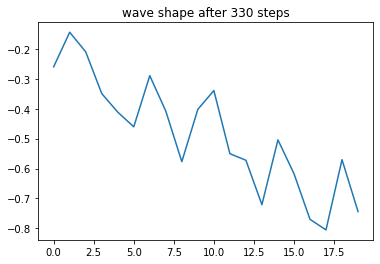

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_330/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_330/model_weights.tf
generator loss:1.2782235924787821
-----------------------
total discriminator loss:0.43401905948493613
average true return:0.5229386855545564
-----------------------


 21%|██        | 331/1562 [48:07<4:11:07, 12.24s/it]

Training Step: 331
generator loss:1.343343225132056
-----------------------
total discriminator loss:0.43285101229695555
average true return:0.505944226331821
-----------------------


 21%|██▏       | 332/1562 [48:12<3:24:32,  9.98s/it]

Training Step: 332
generator loss:1.3883712127345298
-----------------------
total discriminator loss:0.43514196612924294
average true return:0.4916642480371327
-----------------------


 21%|██▏       | 333/1562 [48:16<2:52:23,  8.42s/it]

Training Step: 333
generator loss:1.416903463327408
-----------------------
total discriminator loss:0.4597669833598685
average true return:0.48935230021174225
-----------------------


 21%|██▏       | 334/1562 [48:21<2:27:25,  7.20s/it]

Training Step: 334
generator loss:1.4314944014911277
-----------------------
total discriminator loss:0.4197510402962882
average true return:0.47173932609970815
-----------------------


 21%|██▏       | 335/1562 [48:26<2:12:20,  6.47s/it]

Training Step: 335
event_types: [1, 3, 2, 1, 1, 2, 2, 2, 2, 3, 3, 3, 1, 2, 2, 3, 0, 0, 2, 3]
mad_score: 0.6106
fid_score: 11978.018535920914
rule_score: 0.188


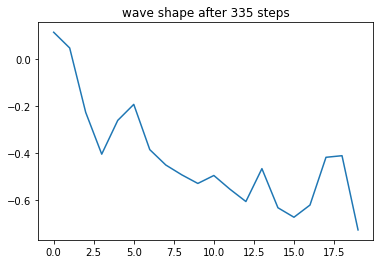

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_335/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_335/model_weights.tf
generator loss:1.4616084520993078
-----------------------
total discriminator loss:0.4470340140939376
average true return:0.47321661843286156
-----------------------


 22%|██▏       | 336/1562 [48:51<4:11:08, 12.29s/it]

Training Step: 336
generator loss:1.4467992302656465
-----------------------
total discriminator loss:0.4261641567928932
average true return:0.4984031685530559
-----------------------


 22%|██▏       | 337/1562 [48:56<3:24:21, 10.01s/it]

Training Step: 337
generator loss:1.38124974514721
-----------------------
total discriminator loss:0.446744222473731
average true return:0.4963572766952104
-----------------------


 22%|██▏       | 338/1562 [49:01<2:53:19,  8.50s/it]

Training Step: 338
generator loss:1.3499318547234087
-----------------------
total discriminator loss:0.43929762011092444
average true return:0.5150901866750421
-----------------------


 22%|██▏       | 339/1562 [49:06<2:29:55,  7.36s/it]

Training Step: 339
generator loss:1.35646786270718
-----------------------
total discriminator loss:0.4246371677134452
average true return:0.5308159823538154
-----------------------


 22%|██▏       | 340/1562 [49:10<2:13:34,  6.56s/it]

Training Step: 340
event_types: [2, 3, 2, 1, 1, 2, 2, 3, 2, 2, 1, 2, 3, 3, 2, 0, 2, 3, 2, 3]
mad_score: 0.6038875
fid_score: 11197.632752866013
rule_score: 0.334


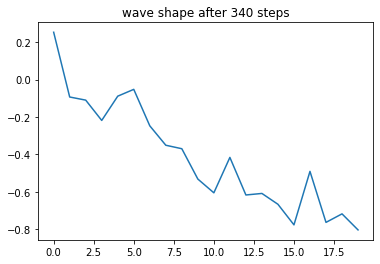

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_340/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_340/model_weights.tf
generator loss:1.3338577935521987
-----------------------
total discriminator loss:0.4239282975918217
average true return:0.5073425992849117
-----------------------


 22%|██▏       | 341/1562 [49:37<4:13:52, 12.48s/it]

Training Step: 341
generator loss:1.4432444386982095
-----------------------
total discriminator loss:0.4490907960914511
average true return:0.49272934478604935
-----------------------


 22%|██▏       | 342/1562 [49:41<3:26:09, 10.14s/it]

Training Step: 342
generator loss:1.4904506778368523
-----------------------
total discriminator loss:0.42435546997230106
average true return:0.5038260708219806
-----------------------


 22%|██▏       | 343/1562 [49:46<2:53:48,  8.56s/it]

Training Step: 343
generator loss:1.5232493696897396
-----------------------
total discriminator loss:0.4130497814596028
average true return:0.4927966572363681
-----------------------


 22%|██▏       | 344/1562 [49:51<2:31:31,  7.46s/it]

Training Step: 344
generator loss:1.5306009882963596
-----------------------
total discriminator loss:0.4483998625655596
average true return:0.4747016716512046
-----------------------


 22%|██▏       | 345/1562 [49:56<2:14:02,  6.61s/it]

Training Step: 345
event_types: [3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 3, 2, 3, 1, 1, 0, 0, 3]
mad_score: 0.5966875
fid_score: 10383.458216874546
rule_score: 0.46325


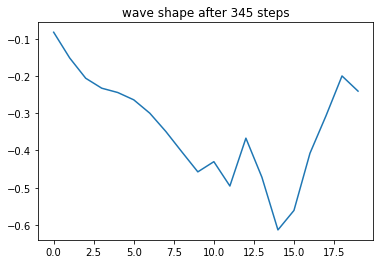

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_345/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_345/model_weights.tf
generator loss:1.6236555074687247
-----------------------
total discriminator loss:0.45196909086922316
average true return:0.4765688846715766
-----------------------


 22%|██▏       | 346/1562 [50:22<4:13:57, 12.53s/it]

Training Step: 346
generator loss:1.555632997525997
-----------------------
total discriminator loss:0.42805442946788574
average true return:0.46500030224780503
-----------------------


 22%|██▏       | 347/1562 [50:27<3:26:13, 10.18s/it]

Training Step: 347
generator loss:1.5790093989090366
-----------------------
total discriminator loss:1.3585833405345331
average true return:0.47551582494000566
-----------------------


 22%|██▏       | 348/1562 [50:31<2:52:03,  8.50s/it]

Training Step: 348
generator loss:1.5241952731129835
-----------------------
total discriminator loss:0.40384498246244
average true return:0.48871841717929326
-----------------------


 22%|██▏       | 349/1562 [50:36<2:29:40,  7.40s/it]

Training Step: 349
generator loss:1.4176399367349082
-----------------------
total discriminator loss:0.4351097394211089
average true return:0.5076354969883904
-----------------------


 22%|██▏       | 350/1562 [50:41<2:12:50,  6.58s/it]

Training Step: 350
event_types: [3, 3, 0, 1, 3, 2, 2, 3, 2, 2, 0, 0, 2, 0, 1, 3, 2, 3, 3, 1]
mad_score: 0.5890875
fid_score: 9730.463820783736
rule_score: 0.51625


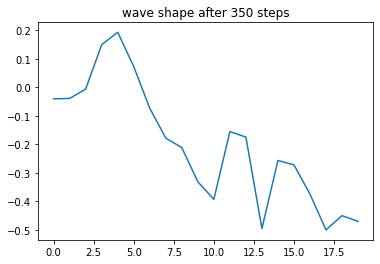

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_350/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_350/model_weights.tf
generator loss:1.381438406984632
-----------------------
total discriminator loss:0.43715202283236654
average true return:0.5176026670842662
-----------------------


 22%|██▏       | 351/1562 [51:07<4:09:28, 12.36s/it]

Training Step: 351
generator loss:1.3955833019844737
-----------------------
total discriminator loss:0.45551331477541235
average true return:0.5081123408954307
-----------------------


 23%|██▎       | 352/1562 [51:11<3:22:27, 10.04s/it]

Training Step: 352
generator loss:1.3857918941647225
-----------------------
total discriminator loss:0.4388826909563227
average true return:0.5061316459991455
-----------------------


 23%|██▎       | 353/1562 [51:15<2:44:28,  8.16s/it]

Training Step: 353
generator loss:1.475836727833495
-----------------------
total discriminator loss:1.271097007407092
average true return:0.48827453128378495
-----------------------


 23%|██▎       | 354/1562 [51:20<2:23:38,  7.13s/it]

Training Step: 354
generator loss:1.5022829122781405
-----------------------
total discriminator loss:0.4899353722712859
average true return:0.5024993680906616
-----------------------


 23%|██▎       | 355/1562 [51:25<2:08:25,  6.38s/it]

Training Step: 355
event_types: [2, 2, 2, 2, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 1, 1]
mad_score: 0.576525
fid_score: 9273.517649738787
rule_score: 0.53375


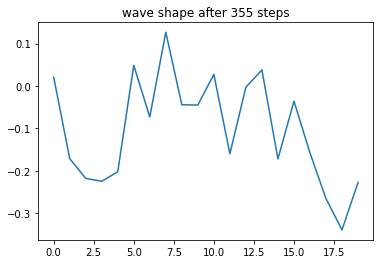

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_355/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_355/model_weights.tf
generator loss:1.4950151764733923
-----------------------
total discriminator loss:0.5077653921414496
average true return:0.46123622560343464
-----------------------


 23%|██▎       | 356/1562 [51:51<4:07:32, 12.32s/it]

Training Step: 356
generator loss:1.4859077093348054
-----------------------
total discriminator loss:0.48378394013728776
average true return:0.444229495956118
-----------------------


 23%|██▎       | 357/1562 [51:56<3:22:02, 10.06s/it]

Training Step: 357
generator loss:1.35837159777072
-----------------------
total discriminator loss:0.45266553377040264
average true return:0.48496167073351615
-----------------------


 23%|██▎       | 358/1562 [52:00<2:50:11,  8.48s/it]

Training Step: 358
generator loss:1.288612105149521
-----------------------
total discriminator loss:0.5058366187180215
average true return:0.5400477346379071
-----------------------


 23%|██▎       | 359/1562 [52:05<2:27:00,  7.33s/it]

Training Step: 359
generator loss:1.1914574537501226
-----------------------
total discriminator loss:0.4827405350566204
average true return:0.5042400529679999
-----------------------


 23%|██▎       | 360/1562 [52:10<2:10:32,  6.52s/it]

Training Step: 360
event_types: [0, 3, 1, 2, 2, 3, 2, 2, 0, 3, 2, 2, 2, 1, 3, 0, 1, 2, 1, 3]
mad_score: 0.56735
fid_score: 8997.493646743496
rule_score: 0.5485


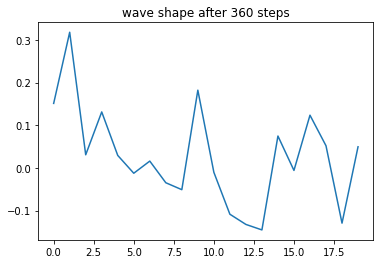

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_360/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_360/model_weights.tf
generator loss:1.236156692132436
-----------------------
total discriminator loss:0.4968067248694901
average true return:0.5264941404639478
-----------------------


 23%|██▎       | 361/1562 [52:36<4:08:56, 12.44s/it]

Training Step: 361
generator loss:1.2246170349408878
-----------------------
total discriminator loss:0.5102645678139579
average true return:0.5413084688121408
-----------------------


 23%|██▎       | 362/1562 [52:40<3:22:06, 10.11s/it]

Training Step: 362
generator loss:1.2528246690328735
-----------------------
total discriminator loss:0.4865670586010933
average true return:0.5071077419903143
-----------------------


 23%|██▎       | 363/1562 [52:45<2:49:03,  8.46s/it]

Training Step: 363
generator loss:1.3007356017341225
-----------------------
total discriminator loss:0.47781851096138195
average true return:0.4769009207556545
-----------------------


 23%|██▎       | 364/1562 [52:50<2:26:40,  7.35s/it]

Training Step: 364
generator loss:1.3044639870080958
-----------------------
total discriminator loss:0.48701122561475124
average true return:0.4634927844883441
-----------------------


 23%|██▎       | 365/1562 [52:55<2:11:18,  6.58s/it]

Training Step: 365
event_types: [1, 2, 1, 2, 2, 3, 0, 2, 2, 2, 0, 1, 2, 3, 1, 2, 0, 2, 0, 3]
mad_score: 0.5512125
fid_score: 8992.03946318516
rule_score: 0.566


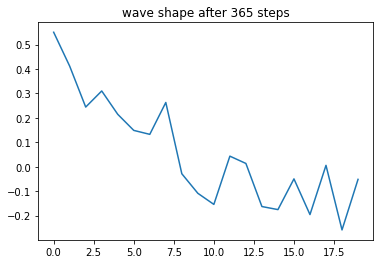

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_365/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_365/model_weights.tf
generator loss:1.3189971676522287
-----------------------
total discriminator loss:0.4964252801918726
average true return:0.4719882933037822
-----------------------


 23%|██▎       | 366/1562 [53:21<4:08:51, 12.48s/it]

Training Step: 366
generator loss:1.3132338230862377
-----------------------
total discriminator loss:0.5096476022019046
average true return:0.49771119824082183
-----------------------


 23%|██▎       | 367/1562 [53:26<3:23:07, 10.20s/it]

Training Step: 367
generator loss:1.2525158299150347
-----------------------
total discriminator loss:0.49535495067175306
average true return:0.500608432479464
-----------------------


 24%|██▎       | 368/1562 [53:31<2:50:36,  8.57s/it]

Training Step: 368
generator loss:1.2704125496810756
-----------------------
total discriminator loss:1.1423298480039992
average true return:0.49071532670182966
-----------------------


 24%|██▎       | 369/1562 [53:35<2:27:40,  7.43s/it]

Training Step: 369
generator loss:1.2023842116046772
-----------------------
total discriminator loss:1.0911544279250358
average true return:0.5312652985326943
-----------------------


 24%|██▎       | 370/1562 [53:40<2:12:04,  6.65s/it]

Training Step: 370
event_types: [2, 2, 2, 0, 1, 2, 2, 0, 3, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.5382375
fid_score: 9268.657685359916
rule_score: 0.5905


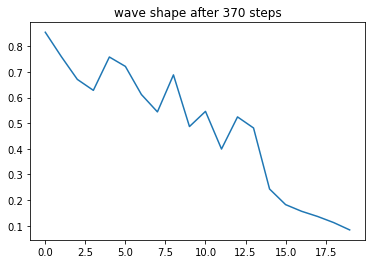

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_370/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_370/model_weights.tf
generator loss:1.1070185483361694
-----------------------
total discriminator loss:0.5042304896035494
average true return:0.526587687654289
-----------------------


 24%|██▍       | 371/1562 [54:07<4:10:57, 12.64s/it]

Training Step: 371
generator loss:1.085130904107797
-----------------------
total discriminator loss:0.5216785173883369
average true return:0.5266775713656605
-----------------------


 24%|██▍       | 372/1562 [54:12<3:23:43, 10.27s/it]

Training Step: 372
generator loss:1.1184302094398986
-----------------------
total discriminator loss:0.521420449047209
average true return:0.5201856901966759
-----------------------


 24%|██▍       | 373/1562 [54:16<2:49:01,  8.53s/it]

Training Step: 373
generator loss:1.1735777887534788
-----------------------
total discriminator loss:0.5091384572096368
average true return:0.5092065879284271
-----------------------


 24%|██▍       | 374/1562 [54:21<2:27:07,  7.43s/it]

Training Step: 374
generator loss:1.2496424969589535
-----------------------
total discriminator loss:1.025296302050905
average true return:0.46804823505252063
-----------------------


 24%|██▍       | 375/1562 [54:26<2:11:02,  6.62s/it]

Training Step: 375
event_types: [2, 2, 2, 2, 0, 3, 1, 3, 2, 1, 1, 2, 2, 3, 2, 0, 1, 3, 2, 0]
mad_score: 0.5256
fid_score: 9876.358651788692
rule_score: 0.60975


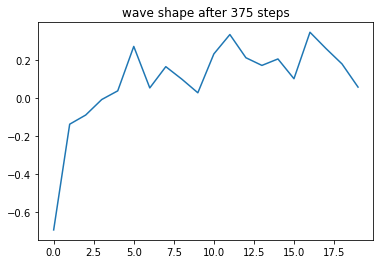

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_375/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_375/model_weights.tf
generator loss:1.2425444596445883
-----------------------
total discriminator loss:0.5182801494788025
average true return:0.4546262467534261
-----------------------


 24%|██▍       | 376/1562 [54:51<4:01:31, 12.22s/it]

Training Step: 376
generator loss:1.1939629600428407
-----------------------
total discriminator loss:0.5095117581303344
average true return:0.46013462980744924
-----------------------


 24%|██▍       | 377/1562 [54:55<3:16:01,  9.93s/it]

Training Step: 377
generator loss:1.176710857828076
-----------------------
total discriminator loss:0.5179903690092758
average true return:0.47806164802784307
-----------------------


 24%|██▍       | 378/1562 [55:00<2:43:38,  8.29s/it]

Training Step: 378
generator loss:1.0632127878637037
-----------------------
total discriminator loss:0.5100077373594504
average true return:0.4987613643436346
-----------------------


 24%|██▍       | 379/1562 [55:03<2:15:24,  6.87s/it]

Training Step: 379
generator loss:1.0588969670143111
-----------------------
total discriminator loss:0.5231252850676977
average true return:0.5063036897350938
-----------------------


 24%|██▍       | 380/1562 [55:08<2:02:28,  6.22s/it]

Training Step: 380
event_types: [0, 1, 2, 2, 2, 3, 2, 2, 1, 2, 2, 3, 2, 2, 2, 3, 1, 2, 1, 0]
mad_score: 0.510175
fid_score: 10868.232359060143
rule_score: 0.6155


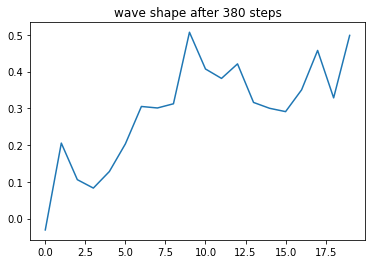

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_380/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_380/model_weights.tf
generator loss:1.0804693538464454
-----------------------
total discriminator loss:0.4882113301413287
average true return:0.5075782823074608
-----------------------


 24%|██▍       | 381/1562 [55:35<4:02:09, 12.30s/it]

Training Step: 381
generator loss:1.0641709373798691
-----------------------
total discriminator loss:0.49675570560818344
average true return:0.5135047370129366
-----------------------


 24%|██▍       | 382/1562 [55:39<3:17:52, 10.06s/it]

Training Step: 382
generator loss:1.1057566667538183
-----------------------
total discriminator loss:0.494925540773903
average true return:0.49335537279610886
-----------------------


 25%|██▍       | 383/1562 [55:44<2:46:04,  8.45s/it]

Training Step: 383
generator loss:1.1792631976428805
-----------------------
total discriminator loss:0.4704432721711925
average true return:0.49102734342303733
-----------------------


 25%|██▍       | 384/1562 [55:49<2:23:31,  7.31s/it]

Training Step: 384
generator loss:1.2201449229733856
-----------------------
total discriminator loss:0.47991452206941104
average true return:0.4979526323882343
-----------------------


 25%|██▍       | 385/1562 [55:54<2:08:15,  6.54s/it]

Training Step: 385
event_types: [2, 0, 3, 0, 2, 1, 2, 0, 2, 1, 0, 3, 2, 2, 1, 2, 2, 3, 0, 2]
mad_score: 0.4993125
fid_score: 12175.099518734512
rule_score: 0.63225


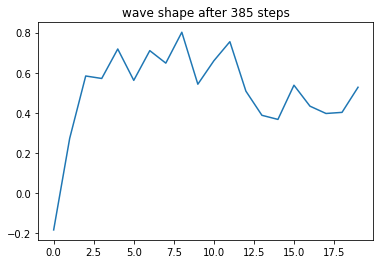

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_385/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_385/model_weights.tf
generator loss:1.3233796703445466
-----------------------
total discriminator loss:0.457650918587441
average true return:0.4782512052637222
-----------------------


 25%|██▍       | 386/1562 [56:20<4:06:58, 12.60s/it]

Training Step: 386
generator loss:1.3478573938000538
-----------------------
total discriminator loss:0.4463696581285119
average true return:0.4654895037898781
-----------------------


 25%|██▍       | 387/1562 [56:25<3:20:23, 10.23s/it]

Training Step: 387
generator loss:1.4066959162940036
-----------------------
total discriminator loss:0.43117972954470385
average true return:0.4709648793933422
-----------------------


 25%|██▍       | 388/1562 [56:30<2:47:47,  8.58s/it]

Training Step: 388
generator loss:1.3971560280391757
-----------------------
total discriminator loss:0.4235481149265613
average true return:0.4909381422882214
-----------------------


 25%|██▍       | 389/1562 [56:35<2:25:48,  7.46s/it]

Training Step: 389
generator loss:1.4577362354366135
-----------------------
total discriminator loss:0.41134706711517244
average true return:0.48666922907937404
-----------------------


 25%|██▍       | 390/1562 [56:39<2:08:56,  6.60s/it]

Training Step: 390
event_types: [0, 0, 2, 1, 0, 2, 3, 2, 0, 2, 1, 0, 2, 2, 0, 2, 2, 3, 2, 2]
mad_score: 0.4933125
fid_score: 13527.291490137342
rule_score: 0.647


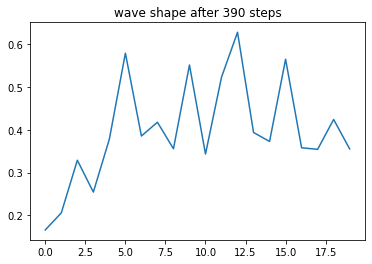

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_390/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_390/model_weights.tf
generator loss:1.4321773268748237
-----------------------
total discriminator loss:0.4014205147517219
average true return:0.494228617898238
-----------------------


 25%|██▌       | 391/1562 [57:05<4:01:55, 12.40s/it]

Training Step: 391
generator loss:1.5069379329889339
-----------------------
total discriminator loss:0.38844882194045227
average true return:0.5001408174723894
-----------------------


 25%|██▌       | 392/1562 [57:10<3:17:36, 10.13s/it]

Training Step: 392
generator loss:1.518075459093753
-----------------------
total discriminator loss:0.39654234806373345
average true return:0.5122535388471474
-----------------------


 25%|██▌       | 393/1562 [57:15<2:46:14,  8.53s/it]

Training Step: 393
generator loss:1.5349466538634209
-----------------------
total discriminator loss:0.37419747179587726
average true return:0.5037971297997955
-----------------------


 25%|██▌       | 394/1562 [57:20<2:25:36,  7.48s/it]

Training Step: 394
generator loss:1.6844477325576497
-----------------------
total discriminator loss:0.3718388436814845
average true return:0.5047163643364311
-----------------------


 25%|██▌       | 395/1562 [57:25<2:10:54,  6.73s/it]

Training Step: 395
event_types: [2, 3, 2, 2, 1, 0, 2, 2, 1, 1, 3, 2, 0, 2, 1, 2, 1, 2, 0, 2]
mad_score: 0.5064875
fid_score: 14129.440988804987
rule_score: 0.6375


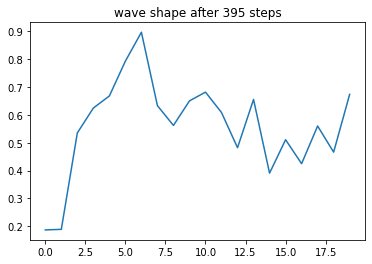

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_395/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_395/model_weights.tf
generator loss:1.7629355522157577
-----------------------
total discriminator loss:0.34732784505166625
average true return:0.4859355737849789
-----------------------


 25%|██▌       | 396/1562 [57:51<4:03:55, 12.55s/it]

Training Step: 396
generator loss:1.7505856510047209
-----------------------
total discriminator loss:0.3805287691964736
average true return:0.4914159761122767
-----------------------


 25%|██▌       | 397/1562 [57:56<3:17:50, 10.19s/it]

Training Step: 397
generator loss:1.785419637557022
-----------------------
total discriminator loss:1.6301657554228615
average true return:0.4936699147555914
-----------------------


 25%|██▌       | 398/1562 [58:00<2:45:29,  8.53s/it]

Training Step: 398
generator loss:1.7825568713913382
-----------------------
total discriminator loss:0.36649450911484627
average true return:0.5019751412378075
-----------------------


 26%|██▌       | 399/1562 [58:05<2:23:39,  7.41s/it]

Training Step: 399
generator loss:1.7453126869925093
-----------------------
total discriminator loss:0.364000355898755
average true return:0.5071203902873411
-----------------------


 26%|██▌       | 400/1562 [58:10<2:09:04,  6.66s/it]

Training Step: 400
event_types: [2, 0, 1, 0, 1, 0, 1, 2, 2, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2]
mad_score: 0.5272875
fid_score: 13480.676525626019
rule_score: 0.63475


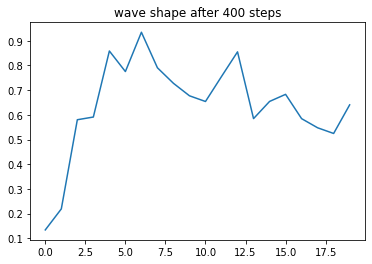

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_400/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_400/model_weights.tf
generator loss:1.6890848399381804
-----------------------
total discriminator loss:0.3722347618474367
average true return:0.5270639594540403
-----------------------


 26%|██▌       | 401/1562 [58:36<4:04:15, 12.62s/it]

Training Step: 401
generator loss:1.6247692050693212
-----------------------
total discriminator loss:0.37731793708869
average true return:0.5181693754048511
-----------------------


 26%|██▌       | 402/1562 [58:41<3:16:55, 10.19s/it]

Training Step: 402
generator loss:1.6633410435549725
-----------------------
total discriminator loss:0.3609853629133393
average true return:0.5163726239975146
-----------------------


 26%|██▌       | 403/1562 [58:45<2:43:48,  8.48s/it]

Training Step: 403
generator loss:1.7030530607832848
-----------------------
total discriminator loss:0.35196161163244255
average true return:0.5215682209091669
-----------------------


 26%|██▌       | 404/1562 [58:50<2:21:18,  7.32s/it]

Training Step: 404
generator loss:1.7159612859484654
-----------------------
total discriminator loss:0.3629593810325585
average true return:0.505610760992224
-----------------------


 26%|██▌       | 405/1562 [58:54<1:59:21,  6.19s/it]

Training Step: 405
event_types: [0, 1, 0, 1, 2, 2, 2, 0, 0, 1, 1, 2, 1, 2, 2, 0, 3, 1, 2, 3]
mad_score: 0.5597
fid_score: 12219.113295075647
rule_score: 0.62625


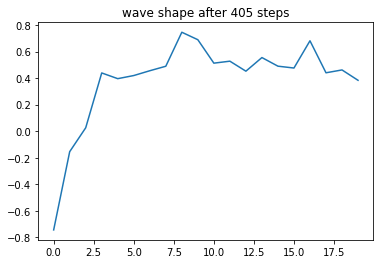

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_405/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_405/model_weights.tf
generator loss:1.7781712877879632
-----------------------
total discriminator loss:0.37670468306583305
average true return:0.5140612462069469
-----------------------


 26%|██▌       | 406/1562 [59:21<4:00:20, 12.47s/it]

Training Step: 406
generator loss:1.8520044087045662
-----------------------
total discriminator loss:0.3667402112999425
average true return:0.49340948236652576
-----------------------


 26%|██▌       | 407/1562 [59:26<3:16:47, 10.22s/it]

Training Step: 407
generator loss:1.7892461383204474
-----------------------
total discriminator loss:0.37345250895450893
average true return:0.4813950624724608
-----------------------


 26%|██▌       | 408/1562 [59:31<2:45:14,  8.59s/it]

Training Step: 408
generator loss:1.8335935050155772
-----------------------
total discriminator loss:0.3684198334087374
average true return:0.4925168794818975
-----------------------


 26%|██▌       | 409/1562 [59:35<2:23:23,  7.46s/it]

Training Step: 409
generator loss:1.793197399147757
-----------------------
total discriminator loss:0.36419344266264664
average true return:0.4885593003123713
-----------------------


 26%|██▌       | 410/1562 [59:40<2:07:23,  6.63s/it]

Training Step: 410
event_types: [2, 1, 1, 0, 2, 3, 0, 1, 2, 1, 0, 1, 1, 1, 1, 0, 2, 2, 3, 0]
mad_score: 0.5947625
fid_score: 10923.192871388215
rule_score: 0.598


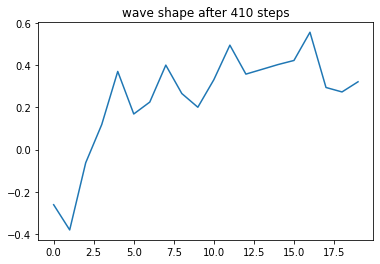

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_410/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_410/model_weights.tf
generator loss:1.7522453794225514
-----------------------
total discriminator loss:0.3958293148369266
average true return:0.5148523704532937
-----------------------


 26%|██▋       | 411/1562 [1:00:06<3:58:51, 12.45s/it]

Training Step: 411
generator loss:1.6839081101494207
-----------------------
total discriminator loss:1.5647650859514863
average true return:0.5038041026850373
-----------------------


 26%|██▋       | 412/1562 [1:00:11<3:14:50, 10.17s/it]

Training Step: 412
generator loss:1.6765806904561504
-----------------------
total discriminator loss:0.3633536623644308
average true return:0.5080107954072952
-----------------------


 26%|██▋       | 413/1562 [1:00:15<2:42:30,  8.49s/it]

Training Step: 413
generator loss:1.6612926989990768
-----------------------
total discriminator loss:0.35041030397584977
average true return:0.5068837975185871
-----------------------


 27%|██▋       | 414/1562 [1:00:20<2:20:48,  7.36s/it]

Training Step: 414
generator loss:1.6301361391434113
-----------------------
total discriminator loss:0.39268976426302543
average true return:0.5172466533575334
-----------------------


 27%|██▋       | 415/1562 [1:00:25<2:06:12,  6.60s/it]

Training Step: 415
event_types: [1, 1, 2, 1, 0, 0, 2, 2, 2, 3, 2, 0, 2, 1, 3, 2, 2, 1, 2, 0]
mad_score: 0.627675
fid_score: 9917.66948723782
rule_score: 0.5785


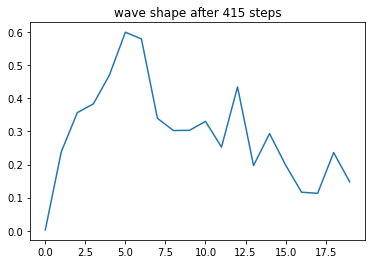

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_415/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_415/model_weights.tf
generator loss:1.6202929373833799
-----------------------
total discriminator loss:1.497685349948892
average true return:0.5049100986674224
-----------------------


 27%|██▋       | 416/1562 [1:00:52<4:03:03, 12.73s/it]

Training Step: 416
generator loss:1.575550046139273
-----------------------
total discriminator loss:0.3741378544606858
average true return:0.5043259797465748
-----------------------


 27%|██▋       | 417/1562 [1:00:57<3:17:22, 10.34s/it]

Training Step: 417
generator loss:1.5914967321536158
-----------------------
total discriminator loss:0.3797283744954126
average true return:0.4811319127593851
-----------------------


 27%|██▋       | 418/1562 [1:01:02<2:45:13,  8.67s/it]

Training Step: 418
generator loss:1.5084584985158507
-----------------------
total discriminator loss:0.4013153933416304
average true return:0.49357853486838194
-----------------------


 27%|██▋       | 419/1562 [1:01:07<2:25:05,  7.62s/it]

Training Step: 419
generator loss:1.4918823544746371
-----------------------
total discriminator loss:0.41271415397161926
average true return:0.5017480277040052
-----------------------


 27%|██▋       | 420/1562 [1:01:12<2:09:04,  6.78s/it]

Training Step: 420
event_types: [0, 1, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 1, 2, 2, 3, 2]
mad_score: 0.6506875
fid_score: 9273.668693841497
rule_score: 0.55275


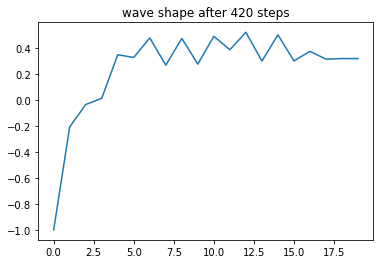

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_420/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_420/model_weights.tf
generator loss:1.4323094678769772
-----------------------
total discriminator loss:0.3843798163609725
average true return:0.5130865364401405
-----------------------


 27%|██▋       | 421/1562 [1:01:38<4:01:18, 12.69s/it]

Training Step: 421
generator loss:1.3502235075285007
-----------------------
total discriminator loss:0.4228403507240871
average true return:0.5299377699796917
-----------------------


 27%|██▋       | 422/1562 [1:01:43<3:15:55, 10.31s/it]

Training Step: 422
generator loss:1.346530488680708
-----------------------
total discriminator loss:0.40499760106800586
average true return:0.5336147167149693
-----------------------


 27%|██▋       | 423/1562 [1:01:48<2:44:25,  8.66s/it]

Training Step: 423
generator loss:1.3191995501462799
-----------------------
total discriminator loss:0.4145729565334358
average true return:0.5418994810471762
-----------------------


 27%|██▋       | 424/1562 [1:01:53<2:23:31,  7.57s/it]

Training Step: 424
generator loss:1.339526658807674
-----------------------
total discriminator loss:1.2968099267371134
average true return:0.521640088951969
-----------------------


 27%|██▋       | 425/1562 [1:01:57<2:06:15,  6.66s/it]

Training Step: 425
event_types: [3, 0, 2, 3, 3, 0, 2, 2, 1, 0, 2, 1, 0, 1, 1, 2, 0, 1, 1, 3]
mad_score: 0.6747375
fid_score: 8931.49785262593
rule_score: 0.5375


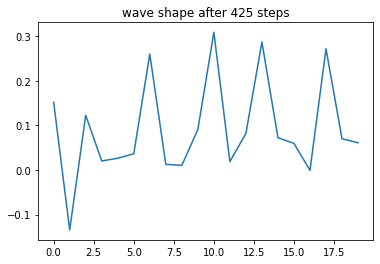

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_425/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_425/model_weights.tf
generator loss:1.4231271056314188
-----------------------
total discriminator loss:0.4221126492698646
average true return:0.4943074159725459
-----------------------


 27%|██▋       | 426/1562 [1:02:23<3:56:54, 12.51s/it]

Training Step: 426
generator loss:1.42852495492758
-----------------------
total discriminator loss:0.3957847480505869
average true return:0.4957134966014661
-----------------------


 27%|██▋       | 427/1562 [1:02:28<3:11:08, 10.10s/it]

Training Step: 427
generator loss:1.3521431961689567
-----------------------
total discriminator loss:0.428276491628219
average true return:0.4933681067024126
-----------------------


 27%|██▋       | 428/1562 [1:02:32<2:38:49,  8.40s/it]

Training Step: 428
generator loss:1.3785627622464836
-----------------------
total discriminator loss:0.41309065914479615
average true return:0.517908927284852
-----------------------


 27%|██▋       | 429/1562 [1:02:37<2:16:26,  7.23s/it]

Training Step: 429
generator loss:1.3183272744828942
-----------------------
total discriminator loss:0.43312110181077673
average true return:0.5140980643302187
-----------------------


 28%|██▊       | 430/1562 [1:02:41<2:01:21,  6.43s/it]

Training Step: 430
event_types: [1, 2, 1, 0, 1, 3, 0, 1, 1, 1, 1, 2, 2, 1, 0, 2, 3, 1, 0, 0]
mad_score: 0.6903625
fid_score: 8806.154734493412
rule_score: 0.51725


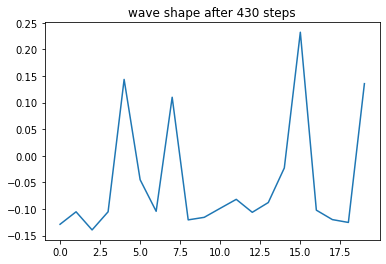

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_430/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_430/model_weights.tf
generator loss:1.3221635768740736
-----------------------
total discriminator loss:0.4069788287865541
average true return:0.5171336883364064
-----------------------


 28%|██▊       | 431/1562 [1:03:07<3:47:48, 12.09s/it]

Training Step: 431
generator loss:1.3120189717688016
-----------------------
total discriminator loss:0.40469794564799355
average true return:0.5111321069931946
-----------------------


 28%|██▊       | 432/1562 [1:03:11<3:06:07,  9.88s/it]

Training Step: 432
generator loss:1.345853347871417
-----------------------
total discriminator loss:0.4105491984777461
average true return:0.5069890896632481
-----------------------


 28%|██▊       | 433/1562 [1:03:16<2:36:34,  8.32s/it]

Training Step: 433
generator loss:1.3393436242427867
-----------------------
total discriminator loss:0.40921579192493396
average true return:0.5112145378085342
-----------------------


 28%|██▊       | 434/1562 [1:03:21<2:15:50,  7.23s/it]

Training Step: 434
generator loss:1.31689128619987
-----------------------
total discriminator loss:0.4128579293558931
average true return:0.521901301515418
-----------------------


 28%|██▊       | 435/1562 [1:03:26<2:02:58,  6.55s/it]

Training Step: 435
event_types: [0, 1, 3, 0, 1, 2, 2, 1, 3, 2, 3, 2, 0, 1, 0, 3, 1, 2, 1, 0]
mad_score: 0.704975
fid_score: 8801.167776893566
rule_score: 0.49375


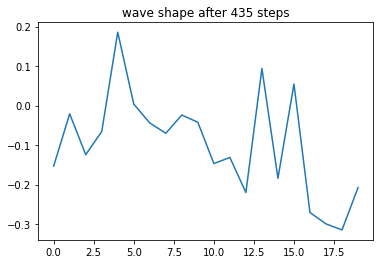

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_435/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_435/model_weights.tf
generator loss:1.3661655342445695
-----------------------
total discriminator loss:0.4187796501752563
average true return:0.5188384163768965
-----------------------


 28%|██▊       | 436/1562 [1:03:52<3:54:04, 12.47s/it]

Training Step: 436
generator loss:1.4079587162617504
-----------------------
total discriminator loss:0.39323406116924675
average true return:0.5158580369707417
-----------------------


 28%|██▊       | 437/1562 [1:03:57<3:11:02, 10.19s/it]

Training Step: 437
generator loss:1.447721145626097
-----------------------
total discriminator loss:0.3930274158535568
average true return:0.5107020350487788
-----------------------


 28%|██▊       | 438/1562 [1:04:02<2:40:28,  8.57s/it]

Training Step: 438
generator loss:1.4584151823336695
-----------------------
total discriminator loss:0.3903007600648666
average true return:0.49499953173046995
-----------------------


 28%|██▊       | 439/1562 [1:04:06<2:18:52,  7.42s/it]

Training Step: 439
generator loss:1.514174152129459
-----------------------
total discriminator loss:1.4015526397428912
average true return:0.49651106426969116
-----------------------


 28%|██▊       | 440/1562 [1:04:11<2:03:18,  6.59s/it]

Training Step: 440
event_types: [0, 1, 0, 2, 1, 0, 2, 1, 2, 2, 0, 3, 0, 1, 3, 2, 1, 1, 0, 3]
mad_score: 0.720175
fid_score: 8906.818779107896
rule_score: 0.47975


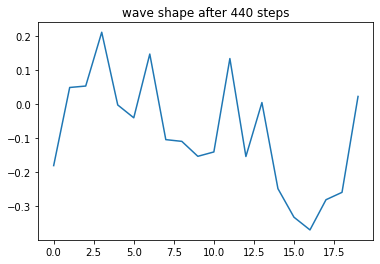

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_440/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_440/model_weights.tf
generator loss:1.5365869316539311
-----------------------
total discriminator loss:0.405794757360205
average true return:0.47794861250152043
-----------------------


 28%|██▊       | 441/1562 [1:04:37<3:54:12, 12.54s/it]

Training Step: 441
generator loss:1.5114659192775668
-----------------------
total discriminator loss:0.3907875841795958
average true return:0.49502928963954895
-----------------------


 28%|██▊       | 442/1562 [1:04:42<3:10:15, 10.19s/it]

Training Step: 442
generator loss:1.4672256357276883
-----------------------
total discriminator loss:0.41202360317334147
average true return:0.5004958077374971
-----------------------


 28%|██▊       | 443/1562 [1:04:47<2:40:15,  8.59s/it]

Training Step: 443
generator loss:1.4263332589803073
-----------------------
total discriminator loss:0.3873422938813082
average true return:0.5236663161919355
-----------------------


 28%|██▊       | 444/1562 [1:04:52<2:19:36,  7.49s/it]

Training Step: 444
generator loss:1.3864483940877608
-----------------------
total discriminator loss:0.3649762462446056
average true return:0.5314552819936742
-----------------------


 28%|██▊       | 445/1562 [1:04:57<2:03:59,  6.66s/it]

Training Step: 445
event_types: [2, 1, 2, 1, 2, 2, 3, 3, 1, 0, 2, 1, 1, 3, 3, 0, 1, 1, 0, 1]
mad_score: 0.7277875
fid_score: 9085.882282960576
rule_score: 0.47075


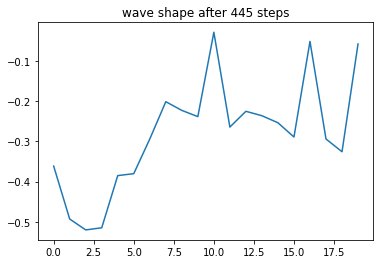

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_445/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_445/model_weights.tf
generator loss:1.3858586409084976
-----------------------
total discriminator loss:0.40008269126859586
average true return:0.5318470063980103
-----------------------


 29%|██▊       | 446/1562 [1:05:23<3:53:30, 12.55s/it]

Training Step: 446
generator loss:1.4532236242796404
-----------------------
total discriminator loss:0.3713172279341248
average true return:0.5225313664696569
-----------------------


 29%|██▊       | 447/1562 [1:05:28<3:10:01, 10.23s/it]

Training Step: 447
generator loss:1.5345364847943226
-----------------------
total discriminator loss:0.3829023228158415
average true return:0.5029611784739803
-----------------------


 29%|██▊       | 448/1562 [1:05:33<2:40:11,  8.63s/it]

Training Step: 448
generator loss:1.6131566150083372
-----------------------
total discriminator loss:0.37625929029591987
average true return:0.495986413127555
-----------------------


 29%|██▊       | 449/1562 [1:05:38<2:20:09,  7.56s/it]

Training Step: 449
generator loss:1.6514565704029631
-----------------------
total discriminator loss:0.3825649253270216
average true return:0.4812984982354923
-----------------------


 29%|██▉       | 450/1562 [1:05:42<2:04:19,  6.71s/it]

Training Step: 450
event_types: [2, 0, 1, 3, 2, 2, 2, 1, 2, 1, 0, 3, 0, 1, 1, 0, 2, 1, 1, 3]
mad_score: 0.735225
fid_score: 9319.662581572462
rule_score: 0.46075


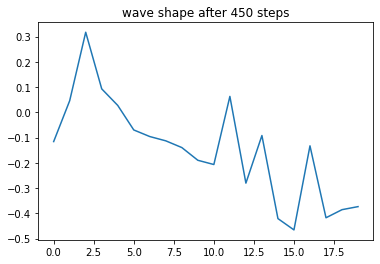

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_450/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_450/model_weights.tf
generator loss:1.6579118829211987
-----------------------
total discriminator loss:0.35967876477802174
average true return:0.49264705089479066
-----------------------


 29%|██▉       | 451/1562 [1:06:09<3:52:48, 12.57s/it]

Training Step: 451
generator loss:1.5875192525839406
-----------------------
total discriminator loss:0.37173806373813145
average true return:0.4981443327898143
-----------------------


 29%|██▉       | 452/1562 [1:06:13<3:08:37, 10.20s/it]

Training Step: 452
generator loss:1.517258296866864
-----------------------
total discriminator loss:0.36659009241939056
average true return:0.5221584400830447
-----------------------


 29%|██▉       | 453/1562 [1:06:18<2:37:46,  8.54s/it]

Training Step: 453
generator loss:1.48501263985161
-----------------------
total discriminator loss:0.37163980304376554
average true return:0.5380109719039059
-----------------------


 29%|██▉       | 454/1562 [1:06:23<2:15:11,  7.32s/it]

Training Step: 454
generator loss:1.5239816445402254
-----------------------
total discriminator loss:0.33311131290387364
average true return:0.5381446470081706
-----------------------


 29%|██▉       | 455/1562 [1:06:27<1:58:54,  6.45s/it]

Training Step: 455
event_types: [3, 2, 0, 2, 2, 1, 0, 1, 1, 2, 2, 2, 3, 1, 2, 3, 1, 0, 1, 1]
mad_score: 0.7451125
fid_score: 9578.148521126723
rule_score: 0.44


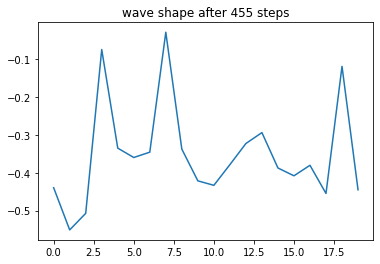

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_455/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_455/model_weights.tf
generator loss:1.6031240241208804
-----------------------
total discriminator loss:0.3626623143305914
average true return:0.5155775046913225
-----------------------


 29%|██▉       | 456/1562 [1:06:52<3:42:31, 12.07s/it]

Training Step: 456
generator loss:1.6719734995921902
-----------------------
total discriminator loss:0.3743743954048774
average true return:0.5117732921770055
-----------------------


 29%|██▉       | 457/1562 [1:06:57<3:01:26,  9.85s/it]

Training Step: 457
generator loss:1.695543987548333
-----------------------
total discriminator loss:1.6557845323854372
average true return:0.5102310835057658
-----------------------


 29%|██▉       | 458/1562 [1:07:02<2:33:13,  8.33s/it]

Training Step: 458
generator loss:1.7217145995190477
-----------------------
total discriminator loss:0.34723716695538787
average true return:0.5108886166678424
-----------------------


 29%|██▉       | 459/1562 [1:07:06<2:13:04,  7.24s/it]

Training Step: 459
generator loss:1.7155429081947309
-----------------------
total discriminator loss:1.6167743197662068
average true return:0.5021885337628592
-----------------------


 29%|██▉       | 460/1562 [1:07:11<1:59:18,  6.50s/it]

Training Step: 460
event_types: [2, 2, 1, 0, 2, 3, 1, 0, 3, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1]
mad_score: 0.7493625
fid_score: 9835.617768161712
rule_score: 0.44675


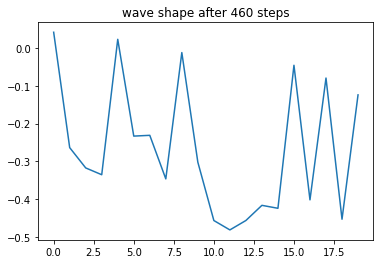

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_460/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_460/model_weights.tf
generator loss:1.685461026673369
-----------------------
total discriminator loss:0.3415740544720901
average true return:0.5061286765363222
-----------------------


 30%|██▉       | 461/1562 [1:07:37<3:46:26, 12.34s/it]

Training Step: 461
generator loss:1.6745338309691657
-----------------------
total discriminator loss:0.3702501030530188
average true return:0.5048597779621986
-----------------------


 30%|██▉       | 462/1562 [1:07:42<3:05:51, 10.14s/it]

Training Step: 462
generator loss:1.7191471714973496
-----------------------
total discriminator loss:0.3620279303519026
average true return:0.4913569025946086
-----------------------


 30%|██▉       | 463/1562 [1:07:47<2:37:39,  8.61s/it]

Training Step: 463
generator loss:1.6728194712409439
-----------------------
total discriminator loss:0.3537810840019881
average true return:0.5005895986839994
-----------------------


 30%|██▉       | 464/1562 [1:07:52<2:16:40,  7.47s/it]

Training Step: 464
generator loss:1.6675595007961912
-----------------------
total discriminator loss:1.5132608169861785
average true return:0.5087668476690592
-----------------------


 30%|██▉       | 465/1562 [1:07:57<2:02:01,  6.67s/it]

Training Step: 465
event_types: [2, 1, 2, 2, 2, 1, 1, 3, 3, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1]
mad_score: 0.7553375
fid_score: 10183.652352818986
rule_score: 0.41075


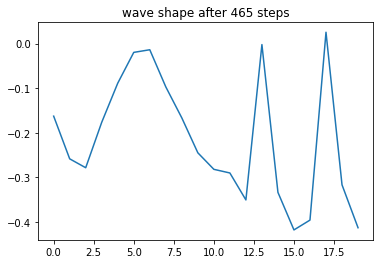

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_465/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_465/model_weights.tf
generator loss:1.5390712265648263
-----------------------
total discriminator loss:0.35999119219970543
average true return:0.526475173152015
-----------------------


 30%|██▉       | 466/1562 [1:08:23<3:50:50, 12.64s/it]

Training Step: 466
generator loss:1.4386906304961489
-----------------------
total discriminator loss:0.3628801960893713
average true return:0.5178589448077726
-----------------------


 30%|██▉       | 467/1562 [1:08:28<3:07:04, 10.25s/it]

Training Step: 467
generator loss:1.498217251918419
-----------------------
total discriminator loss:0.3957777024756783
average true return:0.521810729438174
-----------------------


 30%|██▉       | 468/1562 [1:08:33<2:36:06,  8.56s/it]

Training Step: 468
generator loss:1.5609174500621426
-----------------------
total discriminator loss:0.3491957576289243
average true return:0.504011592129503
-----------------------


 30%|███       | 469/1562 [1:08:37<2:16:12,  7.48s/it]

Training Step: 469
generator loss:1.6945792056095228
-----------------------
total discriminator loss:0.3787956166141362
average true return:0.47339416853804933
-----------------------


 30%|███       | 470/1562 [1:08:42<2:00:52,  6.64s/it]

Training Step: 470
event_types: [3, 0, 1, 0, 1, 1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2]
mad_score: 0.7623625
fid_score: 10574.954476315841
rule_score: 0.306


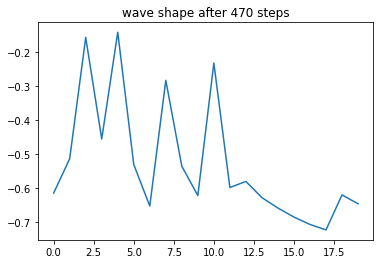

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_470/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_470/model_weights.tf
generator loss:1.7294961659310992
-----------------------
total discriminator loss:0.38098251914124626
average true return:0.4700264734573232
-----------------------


 30%|███       | 471/1562 [1:09:09<3:48:48, 12.58s/it]

Training Step: 471
generator loss:1.6785400874025411
-----------------------
total discriminator loss:0.3788612068671615
average true return:0.4728920096650824
-----------------------


 30%|███       | 472/1562 [1:09:13<3:05:49, 10.23s/it]

Training Step: 472
generator loss:1.706012253916153
-----------------------
total discriminator loss:0.3730071637816026
average true return:0.4857275008985187
-----------------------


 30%|███       | 473/1562 [1:09:18<2:35:15,  8.55s/it]

Training Step: 473
generator loss:1.630771158950418
-----------------------
total discriminator loss:0.358960195520261
average true return:0.48599580377548796
-----------------------


 30%|███       | 474/1562 [1:09:23<2:16:27,  7.53s/it]

Training Step: 474
generator loss:1.5797856050930257
-----------------------
total discriminator loss:0.3518741527463588
average true return:0.5034046169187623
-----------------------


 30%|███       | 475/1562 [1:09:28<2:00:49,  6.67s/it]

Training Step: 475
event_types: [1, 0, 1, 0, 2, 1, 0, 2, 1, 2, 2, 0, 1, 1, 1, 2, 1, 3, 1, 0]
mad_score: 0.7746125
fid_score: 11115.291699472702
rule_score: 0.17375


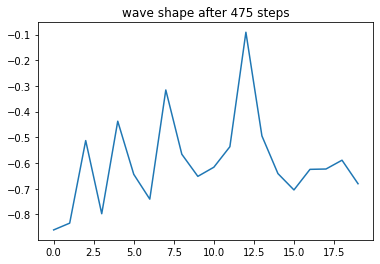

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_475/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_475/model_weights.tf
generator loss:1.5470913494493281
-----------------------
total discriminator loss:0.3789090465871968
average true return:0.5159221392476803
-----------------------


 30%|███       | 476/1562 [1:09:53<3:43:56, 12.37s/it]

Training Step: 476
generator loss:1.5837872895385938
-----------------------
total discriminator loss:0.34115420772850785
average true return:0.5116555884857332
-----------------------


 31%|███       | 477/1562 [1:09:58<3:03:36, 10.15s/it]

Training Step: 477
generator loss:1.5989960075412308
-----------------------
total discriminator loss:0.35867647107001277
average true return:0.5084261424524552
-----------------------


 31%|███       | 478/1562 [1:10:03<2:34:36,  8.56s/it]

Training Step: 478
generator loss:1.644900907387396
-----------------------
total discriminator loss:0.36459374977039033
average true return:0.5037421940424713
-----------------------


 31%|███       | 479/1562 [1:10:08<2:12:59,  7.37s/it]

Training Step: 479
generator loss:1.7047214471289909
-----------------------
total discriminator loss:0.34469322624476173
average true return:0.49900564362396926
-----------------------


 31%|███       | 480/1562 [1:10:12<1:57:54,  6.54s/it]

Training Step: 480
event_types: [3, 0, 1, 0, 1, 1, 0, 2, 0, 1, 3, 2, 1, 0, 1, 1, 1, 0, 3, 1]
mad_score: 0.7858375
fid_score: 11687.395211116822
rule_score: 0.08625


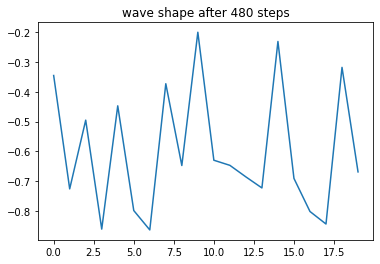

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_480/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_480/model_weights.tf
generator loss:1.764878238129467
-----------------------
total discriminator loss:0.377165870732753
average true return:0.4979931455823218
-----------------------


 31%|███       | 481/1562 [1:10:37<3:34:54, 11.93s/it]

Training Step: 481
generator loss:1.7985195061479964
-----------------------
total discriminator loss:0.3585963600645099
average true return:0.496722466058109
-----------------------


 31%|███       | 482/1562 [1:10:42<2:55:48,  9.77s/it]

Training Step: 482
generator loss:1.7779552206852174
-----------------------
total discriminator loss:0.34213642821035256
average true return:0.49205297978035534
-----------------------


 31%|███       | 483/1562 [1:10:46<2:28:11,  8.24s/it]

Training Step: 483
generator loss:1.8137872567340252
-----------------------
total discriminator loss:0.34664392600996274
average true return:0.50672643623349
-----------------------


 31%|███       | 484/1562 [1:10:51<2:09:43,  7.22s/it]

Training Step: 484
generator loss:1.7949149609252766
-----------------------
total discriminator loss:0.34343607986306346
average true return:0.5032078504566386
-----------------------


 31%|███       | 485/1562 [1:10:56<1:55:45,  6.45s/it]

Training Step: 485
event_types: [0, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1, 0, 3, 1, 1, 0, 2, 1, 1, 0]
mad_score: 0.7864375
fid_score: 12062.43560237996
rule_score: 0.0585


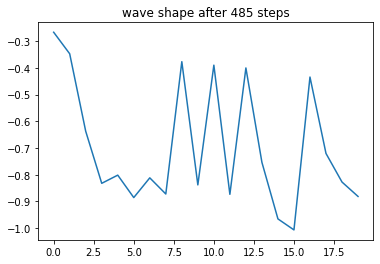

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_485/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_485/model_weights.tf
generator loss:1.8241914463416922
-----------------------
total discriminator loss:1.7340416123236198
average true return:0.5087031533822075
-----------------------


 31%|███       | 486/1562 [1:11:21<3:37:40, 12.14s/it]

Training Step: 486
generator loss:1.74729492723902
-----------------------
total discriminator loss:0.3411023024685713
average true return:0.5234625209830097
-----------------------


 31%|███       | 487/1562 [1:11:26<2:58:34,  9.97s/it]

Training Step: 487
generator loss:1.7345086762009296
-----------------------
total discriminator loss:0.36601901257658487
average true return:0.5105890693544621
-----------------------


 31%|███       | 488/1562 [1:11:31<2:30:24,  8.40s/it]

Training Step: 488
generator loss:1.754002423164343
-----------------------
total discriminator loss:0.36183041933106874
average true return:0.5233462144449355
-----------------------


 31%|███▏      | 489/1562 [1:11:36<2:10:43,  7.31s/it]

Training Step: 489
generator loss:1.7605172882636166
-----------------------
total discriminator loss:0.34289760353807425
average true return:0.519158011223479
-----------------------


 31%|███▏      | 490/1562 [1:11:41<1:58:20,  6.62s/it]

Training Step: 490
event_types: [3, 1, 0, 2, 1, 3, 3, 1, 1, 0, 3, 2, 1, 0, 1, 3, 1, 2, 1, 0]
mad_score: 0.7913125
fid_score: 12156.229671511894
rule_score: 0.048


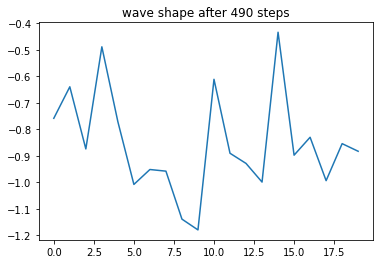

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_490/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_490/model_weights.tf
generator loss:1.7945153268511351
-----------------------
total discriminator loss:0.3193607721116284
average true return:0.5115888463420432
-----------------------


 31%|███▏      | 491/1562 [1:12:07<3:41:41, 12.42s/it]

Training Step: 491
generator loss:1.8068598233569397
-----------------------
total discriminator loss:0.3443801881134091
average true return:0.5092171493812154
-----------------------


 31%|███▏      | 492/1562 [1:12:11<3:00:46, 10.14s/it]

Training Step: 492
generator loss:1.8836991026570824
-----------------------
total discriminator loss:0.31397680114967375
average true return:0.502189740060797
-----------------------


 32%|███▏      | 493/1562 [1:12:16<2:32:04,  8.54s/it]

Training Step: 493
generator loss:1.9137558789746036
-----------------------
total discriminator loss:0.3412333137630499
average true return:0.49383505286267615
-----------------------


 32%|███▏      | 494/1562 [1:12:21<2:13:38,  7.51s/it]

Training Step: 494
generator loss:1.9013772882162518
-----------------------
total discriminator loss:0.3341604442358118
average true return:0.48074713509647776
-----------------------


 32%|███▏      | 495/1562 [1:12:26<1:59:14,  6.71s/it]

Training Step: 495
event_types: [2, 1, 2, 2, 1, 0, 1, 1, 1, 0, 2, 1, 0, 1, 3, 2, 2, 1, 0, 2]
mad_score: 0.7881375
fid_score: 12067.977657962576
rule_score: 0.0515


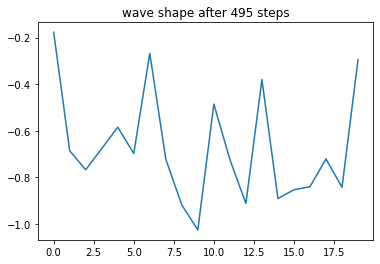

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_495/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_495/model_weights.tf
generator loss:1.8972992463601637
-----------------------
total discriminator loss:0.3445133984066605
average true return:0.49571906625222606
-----------------------


 32%|███▏      | 496/1562 [1:12:52<3:43:23, 12.57s/it]

Training Step: 496
generator loss:1.8776161358538395
-----------------------
total discriminator loss:1.7403509484392292
average true return:0.5047180924180099
-----------------------


 32%|███▏      | 497/1562 [1:12:57<3:01:34, 10.23s/it]

Training Step: 497
generator loss:1.804317268594643
-----------------------
total discriminator loss:0.34275720690285993
average true return:0.514792530400783
-----------------------


 32%|███▏      | 498/1562 [1:13:02<2:32:02,  8.57s/it]

Training Step: 498
generator loss:1.7642053446692052
-----------------------
total discriminator loss:0.3460498926358787
average true return:0.5189535811500885
-----------------------


 32%|███▏      | 499/1562 [1:13:07<2:12:33,  7.48s/it]

Training Step: 499
generator loss:1.7131650631916846
-----------------------
total discriminator loss:0.3409435601711604
average true return:0.5208352466598865
-----------------------


 32%|███▏      | 500/1562 [1:13:11<1:56:47,  6.60s/it]

Training Step: 500
event_types: [0, 3, 2, 3, 1, 0, 1, 2, 0, 3, 1, 0, 3, 1, 0, 3, 1, 0, 1, 0]
mad_score: 0.78425
fid_score: 11746.964347642552
rule_score: 0.05925


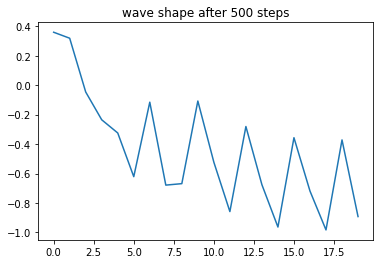

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_500/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_500/model_weights.tf
generator loss:1.7138200567287352
-----------------------
total discriminator loss:0.3549652021815541
average true return:0.5175556182427652
-----------------------


 32%|███▏      | 501/1562 [1:13:37<3:38:44, 12.37s/it]

Training Step: 501
generator loss:1.7976171803699423
-----------------------
total discriminator loss:0.34146140070089603
average true return:0.5077312409966188
-----------------------


 32%|███▏      | 502/1562 [1:13:42<2:58:13, 10.09s/it]

Training Step: 502
generator loss:1.845053320472381
-----------------------
total discriminator loss:0.3480456844947154
average true return:0.4982626832962596
-----------------------


 32%|███▏      | 503/1562 [1:13:47<2:30:06,  8.50s/it]

Training Step: 503
generator loss:1.870307289963894
-----------------------
total discriminator loss:0.32870905081159163
average true return:0.49024903623800703
-----------------------


 32%|███▏      | 504/1562 [1:13:51<2:08:15,  7.27s/it]

Training Step: 504
generator loss:1.898906432827205
-----------------------
total discriminator loss:0.3587820179071305
average true return:0.4838691955019101
-----------------------


 32%|███▏      | 505/1562 [1:13:56<1:55:23,  6.55s/it]

Training Step: 505
event_types: [2, 0, 2, 0, 2, 1, 0, 3, 2, 1, 1, 0, 1, 0, 1, 0, 3, 1, 3, 1]
mad_score: 0.784475
fid_score: 11472.303400349776
rule_score: 0.062


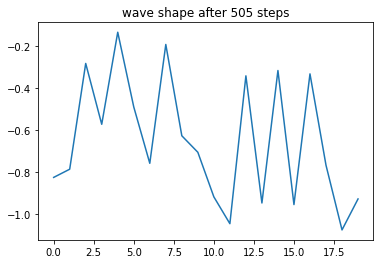

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_505/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_505/model_weights.tf
generator loss:1.9329041627647503
-----------------------
total discriminator loss:1.6642464659835374
average true return:0.48243207799003496
-----------------------


 32%|███▏      | 506/1562 [1:14:20<3:27:30, 11.79s/it]

Training Step: 506
generator loss:1.9581586498407397
-----------------------
total discriminator loss:0.3497058945554135
average true return:0.4722706897143981
-----------------------


 32%|███▏      | 507/1562 [1:14:25<2:50:25,  9.69s/it]

Training Step: 507
generator loss:1.9023756491698254
-----------------------
total discriminator loss:0.34546032116836994
average true return:0.4767694686823755
-----------------------


 33%|███▎      | 508/1562 [1:14:29<2:22:48,  8.13s/it]

Training Step: 508
generator loss:1.8672068462855411
-----------------------
total discriminator loss:0.32738675744582413
average true return:0.4824942271584313
-----------------------


 33%|███▎      | 509/1562 [1:14:34<2:04:51,  7.11s/it]

Training Step: 509
generator loss:1.761815843517665
-----------------------
total discriminator loss:0.3523999963278386
average true return:0.49241856716866206
-----------------------


 33%|███▎      | 510/1562 [1:14:39<1:52:08,  6.40s/it]

Training Step: 510
event_types: [1, 3, 2, 1, 3, 1, 2, 3, 0, 1, 0, 1, 0, 2, 1, 0, 3, 1, 3, 3]
mad_score: 0.7843125
fid_score: 11137.218401545146
rule_score: 0.06975


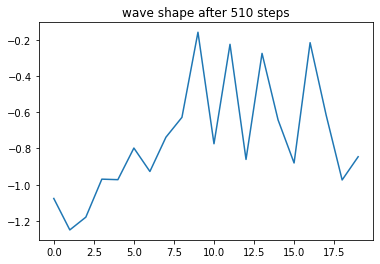

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_510/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_510/model_weights.tf
generator loss:1.7121585134716102
-----------------------
total discriminator loss:0.3366337422511402
average true return:0.5001542785146149
-----------------------


 33%|███▎      | 511/1562 [1:15:05<3:34:32, 12.25s/it]

Training Step: 511
generator loss:1.6455618392147318
-----------------------
total discriminator loss:0.3502675337452118
average true return:0.5141756470259657
-----------------------


 33%|███▎      | 512/1562 [1:15:10<2:55:03, 10.00s/it]

Training Step: 512
generator loss:1.675764534731853
-----------------------
total discriminator loss:0.36452742781167236
average true return:0.512144107827726
-----------------------


 33%|███▎      | 513/1562 [1:15:14<2:27:33,  8.44s/it]

Training Step: 513
generator loss:1.658807129590211
-----------------------
total discriminator loss:0.34632254829197584
average true return:0.5156529003320638
-----------------------


 33%|███▎      | 514/1562 [1:15:19<2:08:50,  7.38s/it]

Training Step: 514
generator loss:1.7092112339406014
-----------------------
total discriminator loss:0.32995845563602205
average true return:0.5062880846005084
-----------------------


 33%|███▎      | 515/1562 [1:15:24<1:57:02,  6.71s/it]

Training Step: 515
event_types: [3, 1, 0, 1, 3, 1, 1, 1, 1, 0, 3, 1, 1, 1, 0, 2, 1, 1, 0, 2]
mad_score: 0.7842875
fid_score: 10794.42210586699
rule_score: 0.074


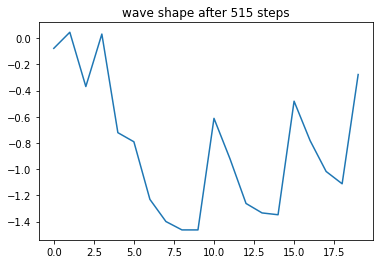

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_515/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_515/model_weights.tf
generator loss:1.7407933747149844
-----------------------
total discriminator loss:0.3516876320619446
average true return:0.4964714340690849
-----------------------


 33%|███▎      | 516/1562 [1:15:50<3:37:34, 12.48s/it]

Training Step: 516
generator loss:1.7998554366400823
-----------------------
total discriminator loss:0.34955677802508767
average true return:0.4984808983175153
-----------------------


 33%|███▎      | 517/1562 [1:15:55<2:57:45, 10.21s/it]

Training Step: 517
generator loss:1.8587351630392608
-----------------------
total discriminator loss:0.3458752478346101
average true return:0.49000666635724865
-----------------------


 33%|███▎      | 518/1562 [1:16:00<2:29:22,  8.58s/it]

Training Step: 518
generator loss:1.890454708303444
-----------------------
total discriminator loss:0.33399021266704665
average true return:0.49242530597696854
-----------------------


 33%|███▎      | 519/1562 [1:16:05<2:09:24,  7.44s/it]

Training Step: 519
generator loss:1.8764863391111077
-----------------------
total discriminator loss:0.3343711646273907
average true return:0.48754699755135955
-----------------------


 33%|███▎      | 520/1562 [1:16:10<1:55:17,  6.64s/it]

Training Step: 520
event_types: [1, 2, 0, 2, 3, 1, 1, 0, 1, 2, 2, 1, 3, 1, 0, 1, 0, 1, 0, 1]
mad_score: 0.7842125
fid_score: 10455.025509197025
rule_score: 0.07525


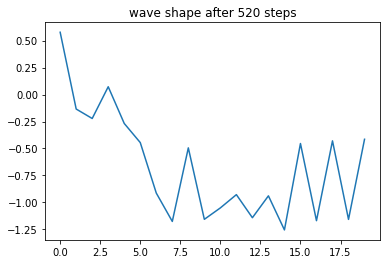

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_520/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_520/model_weights.tf
generator loss:1.897513672835014
-----------------------
total discriminator loss:0.3586846075504399
average true return:0.48848802957496085
-----------------------


 33%|███▎      | 521/1562 [1:16:35<3:35:10, 12.40s/it]

Training Step: 521
generator loss:1.8750528122772563
-----------------------
total discriminator loss:0.35619646463748383
average true return:0.49276547884564526
-----------------------


 33%|███▎      | 522/1562 [1:16:40<2:55:47, 10.14s/it]

Training Step: 522
generator loss:1.8939692938720611
-----------------------
total discriminator loss:0.34284542769497217
average true return:0.4995760930908991
-----------------------


 33%|███▎      | 523/1562 [1:16:45<2:26:46,  8.48s/it]

Training Step: 523
generator loss:1.8145236315474949
-----------------------
total discriminator loss:0.3541217599897247
average true return:0.49793235189967056
-----------------------


 34%|███▎      | 524/1562 [1:16:50<2:07:20,  7.36s/it]

Training Step: 524
generator loss:1.7881166042019192
-----------------------
total discriminator loss:0.3484137785877928
average true return:0.5124856426102818
-----------------------


 34%|███▎      | 525/1562 [1:16:54<1:53:29,  6.57s/it]

Training Step: 525
event_types: [0, 1, 2, 0, 1, 2, 0, 2, 3, 0, 2, 1, 3, 3, 0, 2, 2, 0, 1, 1]
mad_score: 0.7833375
fid_score: 9943.462152334669
rule_score: 0.08525


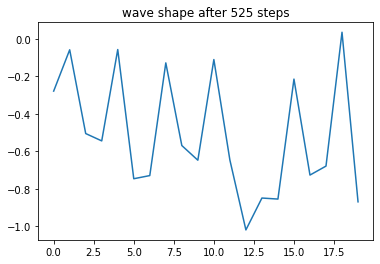

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_525/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_525/model_weights.tf
generator loss:1.747133134650579
-----------------------
total discriminator loss:0.30918000789412614
average true return:0.5170806536601558
-----------------------


 34%|███▎      | 526/1562 [1:17:20<3:32:57, 12.33s/it]

Training Step: 526
generator loss:1.8088745742980548
-----------------------
total discriminator loss:0.2990954450119705
average true return:0.5192971091175025
-----------------------


 34%|███▎      | 527/1562 [1:17:25<2:53:42, 10.07s/it]

Training Step: 527
generator loss:1.8404123008719147
-----------------------
total discriminator loss:0.34075384164193884
average true return:0.5086363089792
-----------------------


 34%|███▍      | 528/1562 [1:17:30<2:26:50,  8.52s/it]

Training Step: 528
generator loss:1.884676389966491
-----------------------
total discriminator loss:0.33982622333983653
average true return:0.5081510538011977
-----------------------


 34%|███▍      | 529/1562 [1:17:35<2:08:07,  7.44s/it]

Training Step: 529
generator loss:1.9384218704456613
-----------------------
total discriminator loss:0.3303544338151071
average true return:0.5030673766522974
-----------------------


 34%|███▍      | 530/1562 [1:17:40<1:54:19,  6.65s/it]

Training Step: 530
event_types: [0, 1, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 2, 0, 1, 3, 0, 1, 2, 1]
mad_score: 0.7771625
fid_score: 9091.832501838811
rule_score: 0.107


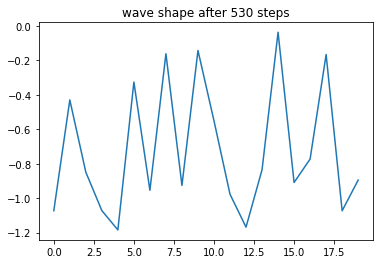

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_530/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_530/model_weights.tf
generator loss:1.9510867204007631
-----------------------
total discriminator loss:0.32912468167061715
average true return:0.5010174974800895
-----------------------


 34%|███▍      | 531/1562 [1:18:04<3:26:53, 12.04s/it]

Training Step: 531
generator loss:1.9885903142302372
-----------------------
total discriminator loss:0.3426996813676021
average true return:0.4913595689139739
-----------------------


 34%|███▍      | 532/1562 [1:18:07<2:41:56,  9.43s/it]

Training Step: 532
generator loss:1.96783861766265
-----------------------
total discriminator loss:0.32932033390507087
average true return:0.49242134694616413
-----------------------


 34%|███▍      | 533/1562 [1:18:10<2:05:23,  7.31s/it]

Training Step: 533
generator loss:1.9889610894913172
-----------------------
total discriminator loss:0.34080882738682683
average true return:0.5095305890468222
-----------------------


 34%|███▍      | 534/1562 [1:18:12<1:39:48,  5.83s/it]

Training Step: 534
generator loss:1.9485598166440037
-----------------------
total discriminator loss:0.3122268940562045
average true return:0.5025931395600008
-----------------------


 34%|███▍      | 535/1562 [1:18:15<1:21:46,  4.78s/it]

Training Step: 535
event_types: [0, 3, 1, 1, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 0, 0, 3, 0, 1, 0]
mad_score: 0.7660875
fid_score: 8172.83237573629
rule_score: 0.131


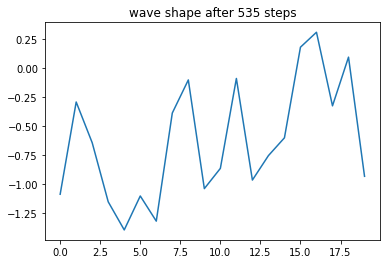

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_535/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_535/model_weights.tf
generator loss:1.9451679401913606
-----------------------
total discriminator loss:0.3420719585309256
average true return:0.5120707567311065
-----------------------


 34%|███▍      | 536/1562 [1:18:28<2:06:26,  7.39s/it]

Training Step: 536
generator loss:1.8566012436232384
-----------------------
total discriminator loss:0.33865042316675803
average true return:0.5021342235906878
-----------------------


 34%|███▍      | 537/1562 [1:18:30<1:40:14,  5.87s/it]

Training Step: 537
generator loss:1.8752068182925243
-----------------------
total discriminator loss:0.34422086805325147
average true return:0.5211743040991499
-----------------------


 34%|███▍      | 538/1562 [1:18:33<1:22:10,  4.82s/it]

Training Step: 538
generator loss:1.9490656781608293
-----------------------
total discriminator loss:0.31809150511614237
average true return:0.5108201265162117
-----------------------


 35%|███▍      | 539/1562 [1:18:35<1:09:34,  4.08s/it]

Training Step: 539
generator loss:1.9643735690733037
-----------------------


 35%|███▍      | 540/1562 [1:18:37<59:36,  3.50s/it]  

total discriminator loss:0.3546685448002178
average true return:0.5090871847089182
-----------------------
Training Step: 540
event_types: [2, 0, 0, 1, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0]
mad_score: 0.7580625
fid_score: 7054.330674787992
rule_score: 0.1595


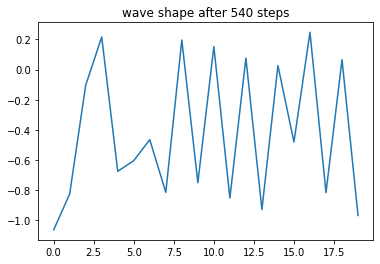

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_540/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_540/model_weights.tf
generator loss:1.9968430931611443
-----------------------
total discriminator loss:0.343461645116444
average true return:0.5055524973521005
-----------------------


 35%|███▍      | 541/1562 [1:18:50<1:48:50,  6.40s/it]

Training Step: 541
generator loss:2.0312895944586113
-----------------------
total discriminator loss:0.3189008023650317
average true return:0.506458600873871
-----------------------


 35%|███▍      | 542/1562 [1:18:53<1:28:05,  5.18s/it]

Training Step: 542
generator loss:2.054065167068906
-----------------------
total discriminator loss:0.34189071168543217
average true return:0.49859127407231835
-----------------------


 35%|███▍      | 543/1562 [1:18:55<1:13:31,  4.33s/it]

Training Step: 543
generator loss:2.060924704728194
-----------------------
total discriminator loss:0.3318013995429056
average true return:0.48665762257708634
-----------------------


 35%|███▍      | 544/1562 [1:18:58<1:03:49,  3.76s/it]

Training Step: 544
generator loss:2.0737571445696545
-----------------------
total discriminator loss:1.8518400304541611
average true return:0.4938510949311516
-----------------------


 35%|███▍      | 545/1562 [1:19:00<56:55,  3.36s/it]  

Training Step: 545
event_types: [3, 2, 2, 3, 1, 0, 2, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 3, 2, 3]
mad_score: 0.7487125
fid_score: 6026.531924210594
rule_score: 0.183


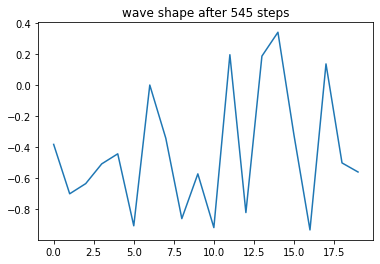

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_545/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_545/model_weights.tf
generator loss:1.9746827606316604
-----------------------
total discriminator loss:0.31548984804732705
average true return:0.5048508763586866
-----------------------


 35%|███▍      | 546/1562 [1:19:13<1:44:13,  6.15s/it]

Training Step: 546
generator loss:1.8620486036156942
-----------------------
total discriminator loss:0.3483623501180511
average true return:0.5209491495797542
-----------------------


 35%|███▌      | 547/1562 [1:19:15<1:24:49,  5.01s/it]

Training Step: 547
generator loss:1.8132822651097995
-----------------------
total discriminator loss:0.3270975748487234
average true return:0.5161477674541722
-----------------------


 35%|███▌      | 548/1562 [1:19:17<1:11:12,  4.21s/it]

Training Step: 548
generator loss:1.8782685715731495
-----------------------
total discriminator loss:0.33757134226748975
average true return:0.5246734843338182
-----------------------


 35%|███▌      | 549/1562 [1:19:20<1:01:52,  3.67s/it]

Training Step: 549
generator loss:1.9197045987694934
-----------------------
total discriminator loss:0.3475312934934235
average true return:0.49210127256043124
-----------------------


 35%|███▌      | 550/1562 [1:19:22<56:31,  3.35s/it]  

Training Step: 550
event_types: [1, 0, 1, 1, 0, 2, 0, 2, 0, 1, 3, 0, 1, 2, 0, 0, 1, 0, 1, 0]
mad_score: 0.7337625
fid_score: 4929.712014980125
rule_score: 0.22125


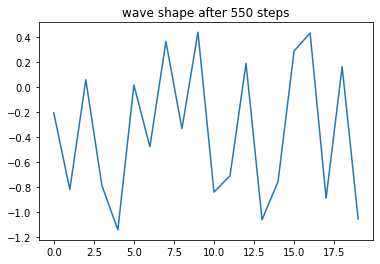

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_550/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_550/model_weights.tf
generator loss:2.003942590382379
-----------------------
total discriminator loss:0.33575768752473084
average true return:0.4980299788278767
-----------------------


 35%|███▌      | 551/1562 [1:19:36<1:49:28,  6.50s/it]

Training Step: 551
generator loss:1.9955970722677185
-----------------------
total discriminator loss:0.33608937315084314
average true return:0.4871413603416317
-----------------------


 35%|███▌      | 552/1562 [1:19:39<1:29:22,  5.31s/it]

Training Step: 552
generator loss:1.9753526101688688
-----------------------


 35%|███▌      | 553/1562 [1:19:41<1:13:25,  4.37s/it]

total discriminator loss:0.3299749759509386
average true return:0.4961364878534188
-----------------------
Training Step: 553
generator loss:1.9934528505071878
-----------------------


 35%|███▌      | 554/1562 [1:19:43<1:01:19,  3.65s/it]

total discriminator loss:0.3285281470883402
average true return:0.4977110182415383
-----------------------
Training Step: 554
generator loss:2.0144356667962873
-----------------------
total discriminator loss:0.3519549733710733
average true return:0.4790523436584537
-----------------------


 36%|███▌      | 555/1562 [1:19:45<54:25,  3.24s/it]  

Training Step: 555
event_types: [2, 0, 3, 2, 0, 1, 0, 1, 0, 3, 1, 0, 1, 1, 2, 0, 1, 3, 0, 1]
mad_score: 0.7214125
fid_score: 3936.4574898051196
rule_score: 0.2465


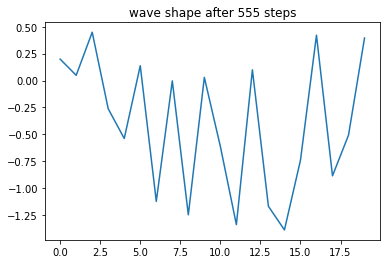

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_555/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_555/model_weights.tf
generator loss:1.9591912432211105
-----------------------
total discriminator loss:0.3587224500987337
average true return:0.5072530134087643
-----------------------


 36%|███▌      | 556/1562 [1:19:59<1:48:04,  6.45s/it]

Training Step: 556
generator loss:1.9651487798943714
-----------------------
total discriminator loss:0.3693383378355624
average true return:0.4884771206916778
-----------------------


 36%|███▌      | 557/1562 [1:20:01<1:27:23,  5.22s/it]

Training Step: 557
generator loss:1.9406988413142656
-----------------------
total discriminator loss:0.3682047319067628
average true return:0.498170589477282
-----------------------


 36%|███▌      | 558/1562 [1:20:04<1:12:58,  4.36s/it]

Training Step: 558
generator loss:1.898009535590512
-----------------------
total discriminator loss:0.3297128336706429
average true return:0.49323382299576174
-----------------------


 36%|███▌      | 559/1562 [1:20:06<1:02:53,  3.76s/it]

Training Step: 559
generator loss:1.8424055791632974
-----------------------
total discriminator loss:0.379337096251476
average true return:0.4972179559410568
-----------------------


 36%|███▌      | 560/1562 [1:20:08<55:40,  3.33s/it]  

Training Step: 560
event_types: [3, 1, 2, 2, 1, 2, 0, 0, 2, 0, 2, 3, 1, 1, 0, 3, 1, 0, 2, 3]
mad_score: 0.710775
fid_score: 3053.1113928201735
rule_score: 0.25875


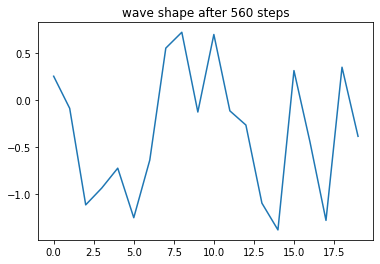

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_560/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_560/model_weights.tf
generator loss:1.8385281229594408
-----------------------


 36%|███▌      | 561/1562 [1:20:21<1:43:59,  6.23s/it]

total discriminator loss:0.357668114491324
average true return:0.5054306047823878
-----------------------
Training Step: 561
generator loss:1.8293520668280467
-----------------------
total discriminator loss:0.3513359109744727
average true return:0.49319040096504196
-----------------------


 36%|███▌      | 562/1562 [1:20:24<1:24:33,  5.07s/it]

Training Step: 562
generator loss:1.8764318269969658
-----------------------
total discriminator loss:0.3462180582727429
average true return:0.5040999513986757
-----------------------


 36%|███▌      | 563/1562 [1:20:26<1:10:47,  4.25s/it]

Training Step: 563
generator loss:1.901129697795032
-----------------------
total discriminator loss:0.35273990300183744
average true return:0.491210778472816
-----------------------


 36%|███▌      | 564/1562 [1:20:29<1:01:26,  3.69s/it]

Training Step: 564
generator loss:1.9694612715033768
-----------------------
total discriminator loss:0.3671326507478113
average true return:0.4742951474833257
-----------------------


 36%|███▌      | 565/1562 [1:20:31<54:59,  3.31s/it]  

Training Step: 565
event_types: [0, 2, 3, 2, 2, 1, 0, 1, 2, 2, 2, 3, 1, 0, 2, 1, 0, 2, 2, 2]
mad_score: 0.69505
fid_score: 2190.391463416434
rule_score: 0.29075


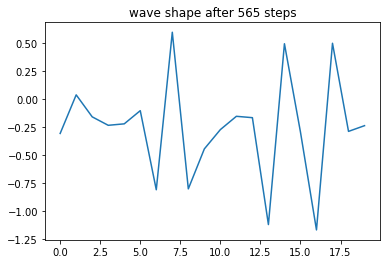

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_565/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_565/model_weights.tf
generator loss:1.9652366014061717
-----------------------


 36%|███▌      | 566/1562 [1:20:45<1:46:27,  6.41s/it]

total discriminator loss:0.38489817267014526
average true return:0.47126230673501135
-----------------------
Training Step: 566
generator loss:1.9028356491709366
-----------------------


 36%|███▋      | 567/1562 [1:20:47<1:24:17,  5.08s/it]

total discriminator loss:0.3759556297583607
average true return:0.49374605908064995
-----------------------
Training Step: 567
generator loss:1.7964908911764086
-----------------------


 36%|███▋      | 568/1562 [1:20:49<1:10:03,  4.23s/it]

total discriminator loss:0.39690415072045704
average true return:0.4972251707050054
-----------------------
Training Step: 568
generator loss:1.7724769495556738
-----------------------
total discriminator loss:0.383054669144092
average true return:0.5044607131228651
-----------------------


 36%|███▋      | 569/1562 [1:20:51<1:01:06,  3.69s/it]

Training Step: 569
generator loss:1.745883083461647
-----------------------


 36%|███▋      | 570/1562 [1:20:54<54:18,  3.28s/it]  

total discriminator loss:0.3837339720447305
average true return:0.5065142991269829
-----------------------
Training Step: 570
event_types: [1, 0, 1, 3, 0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 0, 2, 3, 1, 2, 2]
mad_score: 0.6822125
fid_score: 1474.8470537423434
rule_score: 0.299


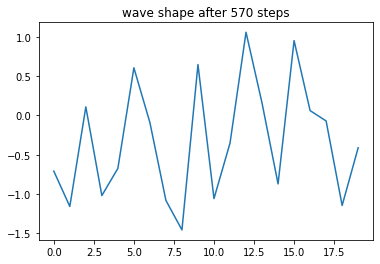

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_570/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_570/model_weights.tf
generator loss:1.8210897104712709
-----------------------
total discriminator loss:0.38318470638037927
average true return:0.5035188397810981
-----------------------


 37%|███▋      | 571/1562 [1:21:07<1:45:39,  6.40s/it]

Training Step: 571
generator loss:1.7976018836318906
-----------------------
total discriminator loss:1.5560190615703977
average true return:0.5093163954917259
-----------------------


 37%|███▋      | 572/1562 [1:21:10<1:25:27,  5.18s/it]

Training Step: 572
generator loss:1.5049205073229737
-----------------------
total discriminator loss:0.4393069828531576
average true return:0.5359632901404701
-----------------------


 37%|███▋      | 573/1562 [1:21:12<1:11:04,  4.31s/it]

Training Step: 573
generator loss:1.4888379822456872
-----------------------
total discriminator loss:0.45516638928264797
average true return:0.5554670201373828
-----------------------


 37%|███▋      | 574/1562 [1:21:14<1:01:15,  3.72s/it]

Training Step: 574
generator loss:1.6582061209772752
-----------------------


 37%|███▋      | 575/1562 [1:21:17<54:06,  3.29s/it]  

total discriminator loss:0.45394152955940087
average true return:0.5070637002542755
-----------------------
Training Step: 575
event_types: [2, 3, 3, 2, 1, 0, 3, 0, 1, 2, 1, 0, 2, 2, 0, 2, 3, 0, 2, 0]
mad_score: 0.6597
fid_score: 838.2816109377011
rule_score: 0.31725


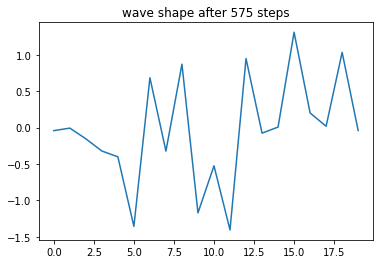

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_575/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_575/model_weights.tf
generator loss:1.7674950053006078
-----------------------
total discriminator loss:0.42108332531691367
average true return:0.49257520189361625
-----------------------


 37%|███▋      | 576/1562 [1:21:30<1:43:28,  6.30s/it]

Training Step: 576
generator loss:1.9233622263989334
-----------------------
total discriminator loss:0.45213435639529753
average true return:0.43522352278930143
-----------------------


 37%|███▋      | 577/1562 [1:21:32<1:23:55,  5.11s/it]

Training Step: 577
generator loss:1.8713671570664743
-----------------------
total discriminator loss:0.4722371418050021
average true return:0.41232739540453456
-----------------------


 37%|███▋      | 578/1562 [1:21:35<1:10:10,  4.28s/it]

Training Step: 578
generator loss:1.6188246812167928
-----------------------
total discriminator loss:0.480838373553536
average true return:0.4850836794198037
-----------------------


 37%|███▋      | 579/1562 [1:21:37<1:01:38,  3.76s/it]

Training Step: 579
generator loss:1.3604450016451277
-----------------------
total discriminator loss:0.4867499822192984
average true return:0.5672122780088145
-----------------------


 37%|███▋      | 580/1562 [1:21:39<54:44,  3.35s/it]  

Training Step: 580
event_types: [2, 1, 0, 2, 2, 0, 2, 0, 2, 1, 0, 2, 2, 3, 0, 3, 2, 2, 0, 2]
mad_score: 0.6434625
fid_score: 515.593070203897
rule_score: 0.33075


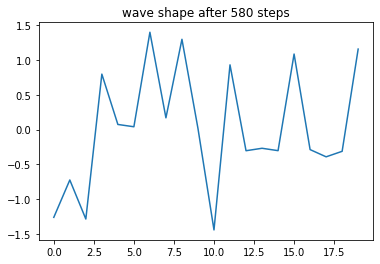

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_580/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_580/model_weights.tf
generator loss:1.324073424861401
-----------------------
total discriminator loss:0.5094803657636617
average true return:0.55410259329776
-----------------------


 37%|███▋      | 581/1562 [1:21:52<1:41:20,  6.20s/it]

Training Step: 581
generator loss:1.4269756203386412
-----------------------
total discriminator loss:0.48070743029669133
average true return:0.5160766098743208
-----------------------


 37%|███▋      | 582/1562 [1:21:55<1:22:29,  5.05s/it]

Training Step: 582
generator loss:1.5896020144364864
-----------------------
total discriminator loss:0.5144526894101165
average true return:0.49128397070000107
-----------------------


 37%|███▋      | 583/1562 [1:21:57<1:09:11,  4.24s/it]

Training Step: 583
generator loss:1.6415459956236051
-----------------------
total discriminator loss:1.33160589767392
average true return:0.48357026242624496
-----------------------


 37%|███▋      | 584/1562 [1:21:59<59:47,  3.67s/it]  

Training Step: 584
generator loss:1.5650254411041937
-----------------------


 37%|███▋      | 585/1562 [1:22:02<53:08,  3.26s/it]

total discriminator loss:0.5063039139517262
average true return:0.4581467849267127
-----------------------
Training Step: 585
event_types: [3, 2, 0, 2, 2, 0, 2, 0, 2, 3, 2, 2, 2, 1, 0, 2, 1, 2, 0, 2]
mad_score: 0.6217625
fid_score: 450.566657544887
rule_score: 0.355


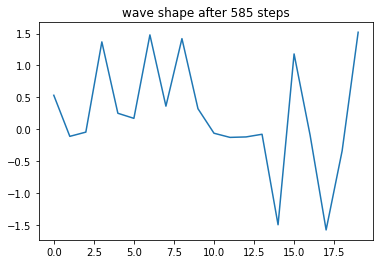

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_585/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_585/model_weights.tf
generator loss:1.3266583222796533
-----------------------
total discriminator loss:0.6032086936271942
average true return:0.49745224282256284
-----------------------


 38%|███▊      | 586/1562 [1:22:15<1:44:05,  6.40s/it]

Training Step: 586
generator loss:1.1753959470932749
-----------------------
total discriminator loss:0.6042127987337347
average true return:0.5369430351636517
-----------------------


 38%|███▊      | 587/1562 [1:22:18<1:24:05,  5.17s/it]

Training Step: 587
generator loss:1.1981380836397517
-----------------------
total discriminator loss:0.6678590857765759
average true return:0.5376065212420658
-----------------------


 38%|███▊      | 588/1562 [1:22:20<1:10:09,  4.32s/it]

Training Step: 588
generator loss:1.1205264623991784
-----------------------


 38%|███▊      | 589/1562 [1:22:22<58:30,  3.61s/it]  

total discriminator loss:0.6439113656555981
average true return:0.5392239489209627
-----------------------
Training Step: 589
generator loss:1.0572565252140578
-----------------------


 38%|███▊      | 590/1562 [1:22:24<51:22,  3.17s/it]

total discriminator loss:0.6643696953584322
average true return:0.5397978158098267
-----------------------
Training Step: 590
event_types: [1, 2, 2, 2, 1, 3, 2, 0, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 3]
mad_score: 0.60035
fid_score: 833.8110220893061
rule_score: 0.3685


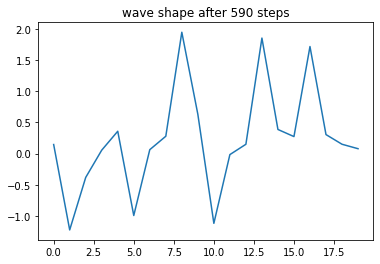

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_590/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_590/model_weights.tf
generator loss:1.1910051277192866
-----------------------
total discriminator loss:0.6493705810706358
average true return:0.505048012356875
-----------------------


 38%|███▊      | 591/1562 [1:22:38<1:42:55,  6.36s/it]

Training Step: 591
generator loss:1.1875581985135801
-----------------------
total discriminator loss:0.6321477654463066
average true return:0.5094045323973281
-----------------------


 38%|███▊      | 592/1562 [1:22:40<1:23:31,  5.17s/it]

Training Step: 592
generator loss:1.16688276732938
-----------------------
total discriminator loss:0.7238386730376878
average true return:0.5083568755013576
-----------------------


 38%|███▊      | 593/1562 [1:22:43<1:09:48,  4.32s/it]

Training Step: 593
generator loss:1.0319823477067276
-----------------------
total discriminator loss:0.7206717082922267
average true return:0.5551393647164165
-----------------------


 38%|███▊      | 594/1562 [1:22:45<1:00:38,  3.76s/it]

Training Step: 594
generator loss:0.9425982883085223
-----------------------
total discriminator loss:0.7116370835700341
average true return:0.5370164050057233
-----------------------


 38%|███▊      | 595/1562 [1:22:47<53:39,  3.33s/it]  

Training Step: 595
event_types: [1, 0, 2, 1, 2, 0, 3, 1, 1, 0, 2, 2, 1, 0, 2, 1, 2, 2, 1, 0]
mad_score: 0.5785375
fid_score: 1840.6420237028863
rule_score: 0.40725


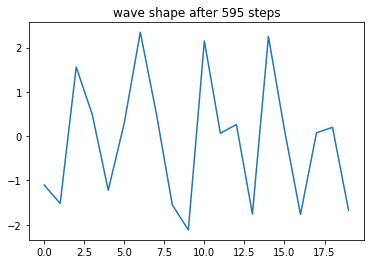

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_595/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_595/model_weights.tf
generator loss:0.775018126935334
-----------------------
total discriminator loss:0.7307895039851386
average true return:0.5885115502597504
-----------------------


 38%|███▊      | 596/1562 [1:23:00<1:40:02,  6.21s/it]

Training Step: 596
generator loss:0.7056835539173214
-----------------------
total discriminator loss:0.757990769951516
average true return:0.6247746339207729
-----------------------


 38%|███▊      | 597/1562 [1:23:03<1:21:21,  5.06s/it]

Training Step: 597
generator loss:0.6314228414812413
-----------------------
total discriminator loss:0.7514423357367452
average true return:0.6016305653787396
-----------------------


 38%|███▊      | 598/1562 [1:23:05<1:08:16,  4.25s/it]

Training Step: 598
generator loss:0.6410342743804747
-----------------------
total discriminator loss:0.7241406158286203
average true return:0.6190866868339775
-----------------------


 38%|███▊      | 599/1562 [1:23:07<59:01,  3.68s/it]  

Training Step: 599
generator loss:0.6501895943362188
-----------------------
total discriminator loss:0.765012752515104
average true return:0.6085741905395682
-----------------------


 38%|███▊      | 600/1562 [1:23:10<52:35,  3.28s/it]

Training Step: 600
event_types: [3, 0, 1, 2, 2, 2, 0, 2, 1, 0, 2, 1, 0, 2, 2, 2, 2, 2, 3, 1]
mad_score: 0.5693
fid_score: 3419.5030367246045
rule_score: 0.39275


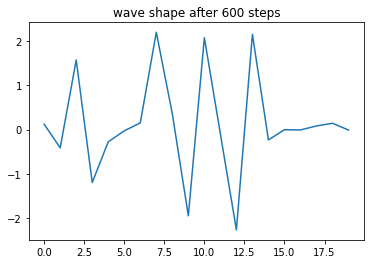

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_600/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_600/model_weights.tf
generator loss:0.6810281461749145
-----------------------
total discriminator loss:0.7418355759776696
average true return:0.5880538596630049
-----------------------


 38%|███▊      | 601/1562 [1:23:24<1:42:39,  6.41s/it]

Training Step: 601
generator loss:0.6642064576101506
-----------------------


 39%|███▊      | 602/1562 [1:23:26<1:21:51,  5.12s/it]

total discriminator loss:0.7480460224119726
average true return:0.5819120607564359
-----------------------
Training Step: 602
generator loss:0.6626957899716255
-----------------------
total discriminator loss:0.7892334279452009
average true return:0.591980940641894
-----------------------


 39%|███▊      | 603/1562 [1:23:28<1:07:15,  4.21s/it]

Training Step: 603
generator loss:0.6310508301407771
-----------------------
total discriminator loss:0.7468657020468776
average true return:0.5854174208709692
-----------------------


 39%|███▊      | 604/1562 [1:23:30<58:12,  3.65s/it]  

Training Step: 604
generator loss:0.6374046532027936
-----------------------
total discriminator loss:0.786162296063016
average true return:0.5882161151061502
-----------------------


 39%|███▊      | 605/1562 [1:23:32<52:04,  3.26s/it]

Training Step: 605
event_types: [2, 1, 1, 1, 0, 2, 2, 2, 2, 3, 2, 0, 2, 2, 2, 2, 1, 1, 0, 1]
mad_score: 0.56605
fid_score: 5708.374647186657
rule_score: 0.39775


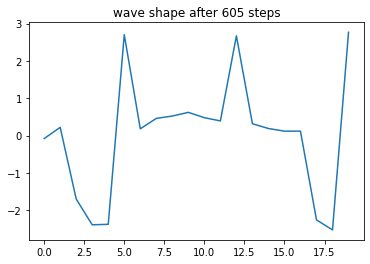

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_605/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_605/model_weights.tf
generator loss:0.6014499077109514
-----------------------
total discriminator loss:0.7463874746487671
average true return:0.5848022694708417
-----------------------


 39%|███▉      | 606/1562 [1:23:46<1:43:36,  6.50s/it]

Training Step: 606
generator loss:0.6783134863746546
-----------------------
total discriminator loss:0.7471214531917505
average true return:0.5763073209039604
-----------------------


 39%|███▉      | 607/1562 [1:23:49<1:23:43,  5.26s/it]

Training Step: 607
generator loss:0.6127151677010214
-----------------------
total discriminator loss:0.7434564904843781
average true return:0.5797088348863683
-----------------------


 39%|███▉      | 608/1562 [1:23:51<1:09:35,  4.38s/it]

Training Step: 608
generator loss:0.5813815850738147
-----------------------
total discriminator loss:0.7595361624039032
average true return:0.580206027630378
-----------------------


 39%|███▉      | 609/1562 [1:23:53<59:48,  3.77s/it]  

Training Step: 609
generator loss:0.6147685782887568
-----------------------
total discriminator loss:0.7649162886683019
average true return:0.5809518009714731
-----------------------


 39%|███▉      | 610/1562 [1:23:56<52:52,  3.33s/it]

Training Step: 610
event_types: [2, 0, 2, 2, 0, 2, 1, 1, 0, 2, 1, 2, 2, 0, 2, 0, 2, 1, 1, 0]
mad_score: 0.568375
fid_score: 8589.31488584609
rule_score: 0.3915


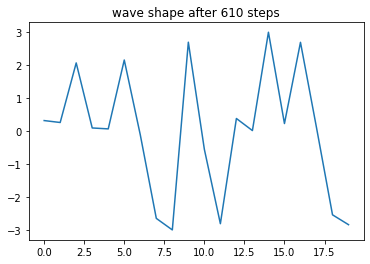

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_610/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_610/model_weights.tf
generator loss:0.5938792081189547
-----------------------
total discriminator loss:0.7226785790775938
average true return:0.5587045178632541
-----------------------


 39%|███▉      | 611/1562 [1:24:09<1:39:52,  6.30s/it]

Training Step: 611
generator loss:0.5822338849205984
-----------------------
total discriminator loss:0.7421553721153514
average true return:0.567620174853859
-----------------------


 39%|███▉      | 612/1562 [1:24:11<1:21:01,  5.12s/it]

Training Step: 612
generator loss:0.5758832814929613
-----------------------
total discriminator loss:0.7562811382641736
average true return:0.5630928627919254
-----------------------


 39%|███▉      | 613/1562 [1:24:14<1:07:54,  4.29s/it]

Training Step: 613
generator loss:0.5840873409383318
-----------------------
total discriminator loss:0.7401514586250197
average true return:0.5570907365969296
-----------------------


 39%|███▉      | 614/1562 [1:24:16<58:34,  3.71s/it]  

Training Step: 614
generator loss:0.5389784132220847
-----------------------
total discriminator loss:0.7371647124993327
average true return:0.5626911718391701
-----------------------


 39%|███▉      | 615/1562 [1:24:18<51:59,  3.29s/it]

Training Step: 615
event_types: [0, 1, 2, 2, 0, 1, 1, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 0, 3]
mad_score: 0.5738375
fid_score: 11690.489183055552
rule_score: 0.3275


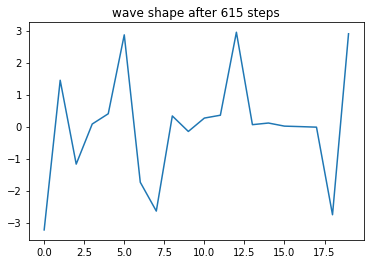

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_615/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_615/model_weights.tf
generator loss:0.5691628377607354
-----------------------
total discriminator loss:0.7642696739852681
average true return:0.5656808138181072
-----------------------


 39%|███▉      | 616/1562 [1:24:31<1:37:50,  6.21s/it]

Training Step: 616
generator loss:0.5906665278388659
-----------------------
total discriminator loss:0.7526375078837738
average true return:0.5520581003954218
-----------------------


 40%|███▉      | 617/1562 [1:24:34<1:19:28,  5.05s/it]

Training Step: 617
generator loss:0.5698501290902921
-----------------------
total discriminator loss:0.7495214573214443
average true return:0.5495473236181172
-----------------------


 40%|███▉      | 618/1562 [1:24:36<1:06:46,  4.24s/it]

Training Step: 618
generator loss:0.5705177647934923
-----------------------
total discriminator loss:0.7546691346865284
average true return:0.5584266590767524
-----------------------


 40%|███▉      | 619/1562 [1:24:39<58:12,  3.70s/it]  

Training Step: 619
generator loss:0.5879310627125087
-----------------------
total discriminator loss:0.735893442560662
average true return:0.5534940009610005
-----------------------


 40%|███▉      | 620/1562 [1:24:41<51:50,  3.30s/it]

Training Step: 620
event_types: [2, 2, 1, 0, 2, 2, 2, 2, 1, 0, 3, 0, 2, 1, 0, 2, 0, 2, 2, 0]
mad_score: 0.5851875
fid_score: 15107.190935537046
rule_score: 0.23175


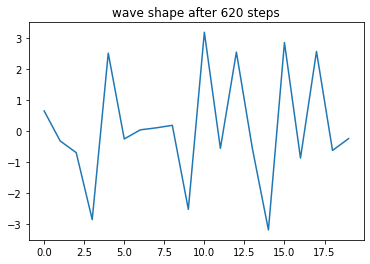

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_620/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_620/model_weights.tf
generator loss:0.5956665073163578
-----------------------
total discriminator loss:0.7426615752053993
average true return:0.5518977108098533
-----------------------


 40%|███▉      | 621/1562 [1:24:55<1:41:09,  6.45s/it]

Training Step: 621
generator loss:0.5837691099411333
-----------------------
total discriminator loss:0.7337981487631082
average true return:0.5475745774245357
-----------------------


 40%|███▉      | 622/1562 [1:24:57<1:21:43,  5.22s/it]

Training Step: 622
generator loss:0.5852698341932363
-----------------------


 40%|███▉      | 623/1562 [1:24:59<1:07:58,  4.34s/it]

total discriminator loss:0.7470284720926605
average true return:0.5575435706352612
-----------------------
Training Step: 623
generator loss:0.5955499527357064
-----------------------


 40%|███▉      | 624/1562 [1:25:02<57:31,  3.68s/it]  

total discriminator loss:0.7463984175837642
average true return:0.5479368769653525
-----------------------
Training Step: 624
generator loss:0.5863593514544525
-----------------------
total discriminator loss:0.7297749045771897
average true return:0.5434657208371256
-----------------------


 40%|████      | 625/1562 [1:25:04<49:37,  3.18s/it]

Training Step: 625
event_types: [3, 1, 0, 2, 1, 3, 1, 0, 3, 3, 0, 2, 2, 0, 3, 2, 2, 2, 2, 0]
mad_score: 0.596725
fid_score: 18374.86111309469
rule_score: 0.16475


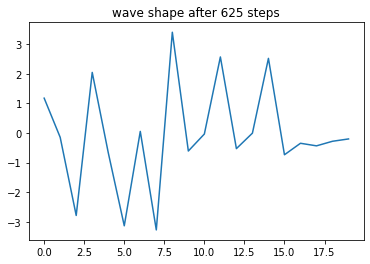

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_625/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_625/model_weights.tf
generator loss:0.5814392678156767
-----------------------
total discriminator loss:0.7243575960497521
average true return:0.5429829377508775
-----------------------


 40%|████      | 626/1562 [1:25:17<1:38:48,  6.33s/it]

Training Step: 626
generator loss:0.5901483851269016
-----------------------
total discriminator loss:0.7250082442510628
average true return:0.5517043241477113
-----------------------


 40%|████      | 627/1562 [1:25:20<1:20:13,  5.15s/it]

Training Step: 627
generator loss:0.5797195716043411
-----------------------
total discriminator loss:0.7245335767690745
average true return:0.5484936251993184
-----------------------


 40%|████      | 628/1562 [1:25:22<1:08:14,  4.38s/it]

Training Step: 628
generator loss:0.59184000114089
-----------------------
total discriminator loss:0.7212897318625912
average true return:0.5438379246039159
-----------------------


 40%|████      | 629/1562 [1:25:25<58:45,  3.78s/it]  

Training Step: 629
generator loss:0.5962965836269596
-----------------------
total discriminator loss:0.7250422752506844
average true return:0.5518309355244346
-----------------------


 40%|████      | 630/1562 [1:25:27<51:56,  3.34s/it]

Training Step: 630
event_types: [0, 2, 1, 0, 2, 2, 1, 0, 2, 2, 3, 0, 2, 0, 1, 0, 2, 1, 1, 0]
mad_score: 0.6111875
fid_score: 21759.836754814973
rule_score: 0.1185


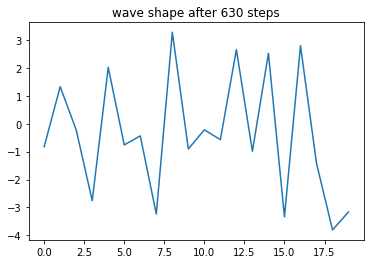

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_630/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_630/model_weights.tf
generator loss:0.5999908257768294
-----------------------
total discriminator loss:0.7099689466541861
average true return:0.5461179060096976
-----------------------


 40%|████      | 631/1562 [1:25:40<1:37:34,  6.29s/it]

Training Step: 631
generator loss:0.6086848403802367
-----------------------
total discriminator loss:0.7125811721072208
average true return:0.5472473645558049
-----------------------


 40%|████      | 632/1562 [1:25:42<1:19:20,  5.12s/it]

Training Step: 632
generator loss:0.6014924101117762
-----------------------
total discriminator loss:0.7095205539539382
average true return:0.5462001845374097
-----------------------


 41%|████      | 633/1562 [1:25:45<1:06:39,  4.30s/it]

Training Step: 633
generator loss:0.6115356168042401
-----------------------
total discriminator loss:0.7127859531832518
average true return:0.542044172146941
-----------------------


 41%|████      | 634/1562 [1:25:47<57:46,  3.74s/it]  

Training Step: 634
generator loss:0.6157355401530804
-----------------------
total discriminator loss:0.6989048207627605
average true return:0.5468381151860277
-----------------------


 41%|████      | 635/1562 [1:25:50<51:30,  3.33s/it]

Training Step: 635
event_types: [2, 1, 0, 1, 3, 2, 2, 1, 0, 2, 2, 2, 1, 0, 3, 2, 3, 2, 0, 1]
mad_score: 0.62135
fid_score: 24537.530041102054
rule_score: 0.09775


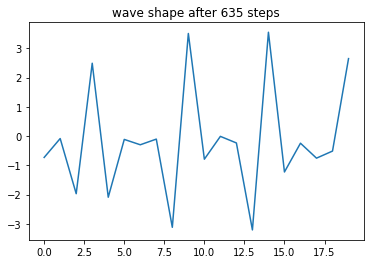

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_635/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_635/model_weights.tf
generator loss:0.6263927851188114
-----------------------
total discriminator loss:0.6940011369499682
average true return:0.5377321925442218
-----------------------


 41%|████      | 636/1562 [1:26:03<1:39:05,  6.42s/it]

Training Step: 636
generator loss:0.6210314208489955
-----------------------


 41%|████      | 637/1562 [1:26:05<1:19:26,  5.15s/it]

total discriminator loss:0.6972939095441499
average true return:0.5432716572652392
-----------------------
Training Step: 637
generator loss:0.6292631783729056
-----------------------


 41%|████      | 638/1562 [1:26:07<1:04:36,  4.20s/it]

total discriminator loss:0.6861743548951511
average true return:0.5474713608212695
-----------------------
Training Step: 638
generator loss:0.6372555100260582
-----------------------
total discriminator loss:0.6857501206801526
average true return:0.5387381946862001
-----------------------


 41%|████      | 639/1562 [1:26:10<55:44,  3.62s/it]  

Training Step: 639
generator loss:0.6371641588789295
-----------------------
total discriminator loss:0.6872907464891798
average true return:0.5445994075469323
-----------------------


 41%|████      | 640/1562 [1:26:12<49:53,  3.25s/it]

Training Step: 640
event_types: [0, 1, 0, 2, 2, 2, 1, 0, 1, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 1]
mad_score: 0.6347875
fid_score: 26932.712050348946
rule_score: 0.08825


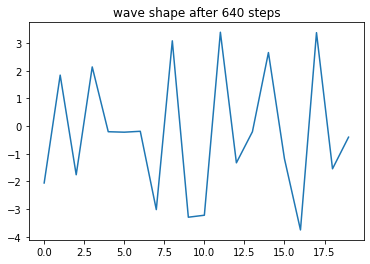

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_640/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_640/model_weights.tf
generator loss:0.6385113663006126
-----------------------
total discriminator loss:0.6780661802851082
average true return:0.5440937972925864
-----------------------


 41%|████      | 641/1562 [1:26:26<1:38:18,  6.40s/it]

Training Step: 641
generator loss:0.6502244403573776
-----------------------
total discriminator loss:0.6854302475949637
average true return:0.5491513555933797
-----------------------


 41%|████      | 642/1562 [1:26:28<1:19:46,  5.20s/it]

Training Step: 642
generator loss:0.6548334382541753
-----------------------
total discriminator loss:0.6730569151974557
average true return:0.5425436492323782
-----------------------


 41%|████      | 643/1562 [1:26:31<1:06:39,  4.35s/it]

Training Step: 643
generator loss:0.6567075879916341
-----------------------
total discriminator loss:0.725641711394085
average true return:0.5380923197043284
-----------------------


 41%|████      | 644/1562 [1:26:33<57:50,  3.78s/it]  

Training Step: 644
generator loss:0.6638734429184778
-----------------------
total discriminator loss:0.6757404710198441
average true return:0.5404213844706875
-----------------------


 41%|████▏     | 645/1562 [1:26:35<51:19,  3.36s/it]

Training Step: 645
event_types: [1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 0, 2, 0, 2, 2, 1, 0]
mad_score: 0.6475875
fid_score: 29208.998612616695
rule_score: 0.0915


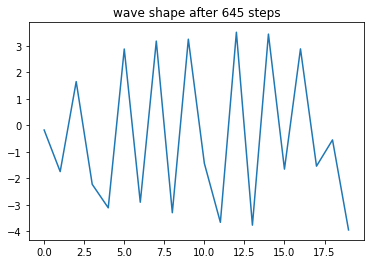

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_645/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_645/model_weights.tf
generator loss:0.6732335723497664
-----------------------
total discriminator loss:0.664522441226839
average true return:0.5375830013150307
-----------------------


 41%|████▏     | 646/1562 [1:26:49<1:35:56,  6.28s/it]

Training Step: 646
generator loss:0.668281193940743
-----------------------
total discriminator loss:0.668472269244536
average true return:0.537232199075969
-----------------------


 41%|████▏     | 647/1562 [1:26:51<1:17:50,  5.10s/it]

Training Step: 647
generator loss:0.6837891738975115
-----------------------
total discriminator loss:0.6590095989240202
average true return:0.5336492576366968
-----------------------


 41%|████▏     | 648/1562 [1:26:53<1:05:20,  4.29s/it]

Training Step: 648
generator loss:0.7039690441495434
-----------------------
total discriminator loss:0.6566673030957333
average true return:0.5265116107841086
-----------------------


 42%|████▏     | 649/1562 [1:26:56<56:32,  3.72s/it]  

Training Step: 649
generator loss:0.7046336271633782
-----------------------
total discriminator loss:0.6565473074772055
average true return:0.5336245954878458
-----------------------


 42%|████▏     | 650/1562 [1:26:58<50:13,  3.30s/it]

Training Step: 650
event_types: [0, 2, 1, 1, 0, 2, 2, 1, 0, 3, 0, 1, 1, 2, 2, 1, 0, 3, 0, 2]
mad_score: 0.6591875
fid_score: 31242.065587638957
rule_score: 0.07725


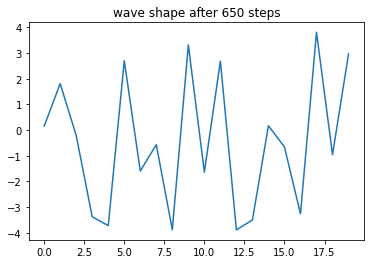

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_650/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_650/model_weights.tf
generator loss:0.6939072001147244
-----------------------


 42%|████▏     | 651/1562 [1:27:11<1:34:55,  6.25s/it]

total discriminator loss:0.6539215786806833
average true return:0.5240076280142649
-----------------------
Training Step: 651
generator loss:0.7025780419783152
-----------------------
total discriminator loss:0.650965824663976
average true return:0.5256896405858202
-----------------------


 42%|████▏     | 652/1562 [1:27:13<1:16:33,  5.05s/it]

Training Step: 652
generator loss:0.7126716585325872
-----------------------
total discriminator loss:0.6446285055663499
average true return:0.5205205556437016
-----------------------


 42%|████▏     | 653/1562 [1:27:16<1:04:20,  4.25s/it]

Training Step: 653
generator loss:0.715591508718252
-----------------------
total discriminator loss:0.6364565345905948
average true return:0.5252107207241825
-----------------------


 42%|████▏     | 654/1562 [1:27:18<55:41,  3.68s/it]  

Training Step: 654
generator loss:0.7288344074699012
-----------------------
total discriminator loss:0.6440066658027649
average true return:0.5241708672903862
-----------------------


 42%|████▏     | 655/1562 [1:27:20<49:39,  3.29s/it]

Training Step: 655
event_types: [2, 0, 2, 1, 0, 2, 2, 1, 0, 2, 1, 0, 3, 2, 2, 0, 1, 2, 2, 1]
mad_score: 0.6694875
fid_score: 32328.623501612576
rule_score: 0.0775


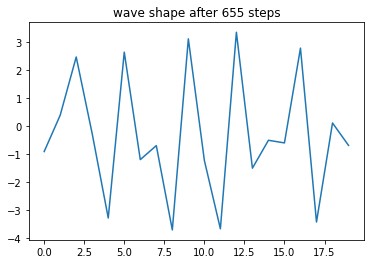

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_655/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_655/model_weights.tf
generator loss:0.734409802806282
-----------------------
total discriminator loss:0.6357217204584493
average true return:0.5189085595671731
-----------------------


 42%|████▏     | 656/1562 [1:27:35<1:38:25,  6.52s/it]

Training Step: 656
generator loss:0.7375448860440892
-----------------------
total discriminator loss:0.621349447077751
average true return:0.5252518545522921
-----------------------


 42%|████▏     | 657/1562 [1:27:37<1:20:27,  5.33s/it]

Training Step: 657
generator loss:0.7631065785782822
-----------------------
total discriminator loss:0.6304974440089022
average true return:0.5254067580937878
-----------------------


 42%|████▏     | 658/1562 [1:27:39<1:06:52,  4.44s/it]

Training Step: 658
generator loss:0.7472466296076727
-----------------------


 42%|████▏     | 659/1562 [1:27:42<57:20,  3.81s/it]  

total discriminator loss:0.6179175151133218
average true return:0.5246686236053407
-----------------------
Training Step: 659
generator loss:0.7642697922668111
-----------------------


 42%|████▏     | 660/1562 [1:27:44<48:59,  3.26s/it]

total discriminator loss:0.61581554967759
average true return:0.5274503850723536
-----------------------
Training Step: 660
event_types: [2, 1, 0, 3, 1, 0, 2, 1, 0, 2, 2, 1, 0, 3, 1, 0, 2, 0, 3, 1]
mad_score: 0.68275
fid_score: 33640.938740366604
rule_score: 0.0795


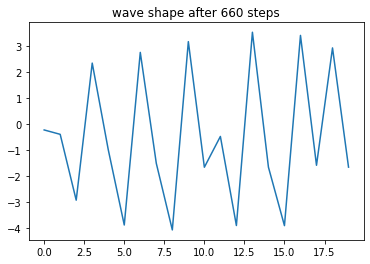

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_660/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_660/model_weights.tf
generator loss:0.7551055738671626
-----------------------
total discriminator loss:0.6066441857416289
average true return:0.52776780795206
-----------------------


 42%|████▏     | 661/1562 [1:27:57<1:34:57,  6.32s/it]

Training Step: 661
generator loss:0.7619548561568512
-----------------------
total discriminator loss:0.5920158515676384
average true return:0.5305416551986355
-----------------------


 42%|████▏     | 662/1562 [1:28:00<1:16:58,  5.13s/it]

Training Step: 662
generator loss:0.7593594973675016
-----------------------
total discriminator loss:0.6021995403726338
average true return:0.5326061410719238
-----------------------


 42%|████▏     | 663/1562 [1:28:02<1:04:31,  4.31s/it]

Training Step: 663
generator loss:0.7859704262528178
-----------------------
total discriminator loss:0.5810682937284763
average true return:0.5375441213330919
-----------------------


 43%|████▎     | 664/1562 [1:28:04<55:54,  3.74s/it]  

Training Step: 664
generator loss:0.77881642118108
-----------------------
total discriminator loss:0.5878524729596246
average true return:0.5325664862786192
-----------------------


 43%|████▎     | 665/1562 [1:28:07<49:41,  3.32s/it]

Training Step: 665
event_types: [2, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 1, 0, 2, 1]
mad_score: 0.6966125
fid_score: 34372.25338491552
rule_score: 0.07775


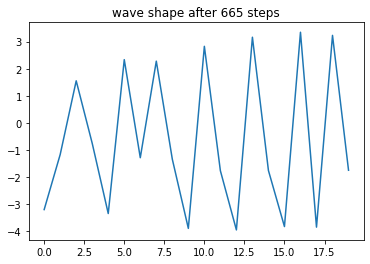

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_665/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_665/model_weights.tf
generator loss:0.7961578652909942
-----------------------
total discriminator loss:0.577001156047336
average true return:0.5345170233337815
-----------------------


 43%|████▎     | 666/1562 [1:28:19<1:31:15,  6.11s/it]

Training Step: 666
generator loss:0.79412846058935
-----------------------
total discriminator loss:0.586086081865064
average true return:0.5355615924567908
-----------------------


 43%|████▎     | 667/1562 [1:28:22<1:14:21,  4.99s/it]

Training Step: 667
generator loss:0.8103897217963452
-----------------------
total discriminator loss:0.5775749540825119
average true return:0.5390639734937646
-----------------------


 43%|████▎     | 668/1562 [1:28:24<1:02:38,  4.20s/it]

Training Step: 668
generator loss:0.8057816113411549
-----------------------
total discriminator loss:0.571211739636925
average true return:0.5431113497250164
-----------------------


 43%|████▎     | 669/1562 [1:28:27<54:52,  3.69s/it]  

Training Step: 669
generator loss:0.833284885588781
-----------------------
total discriminator loss:0.5611109535200167
average true return:0.539292271906352
-----------------------


 43%|████▎     | 670/1562 [1:28:29<49:01,  3.30s/it]

Training Step: 670
event_types: [0, 1, 1, 0, 2, 1, 1, 0, 3, 1, 0, 1, 0, 2, 2, 0, 3, 1, 0, 2]
mad_score: 0.706025
fid_score: 33990.04259802029
rule_score: 0.06725


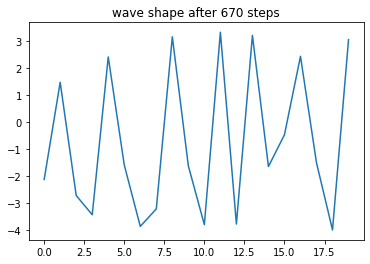

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_670/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_670/model_weights.tf
generator loss:0.8220572276025404
-----------------------
total discriminator loss:0.5565000758949177
average true return:0.5479486497387615
-----------------------


 43%|████▎     | 671/1562 [1:28:43<1:35:14,  6.41s/it]

Training Step: 671
generator loss:0.861391559026793
-----------------------
total discriminator loss:0.560783473736072
average true return:0.5447776642132547
-----------------------


 43%|████▎     | 672/1562 [1:28:45<1:16:59,  5.19s/it]

Training Step: 672
generator loss:0.8789702308488172
-----------------------


 43%|████▎     | 673/1562 [1:28:47<1:02:54,  4.25s/it]

total discriminator loss:0.5456785427330992
average true return:0.5354103296005606
-----------------------
Training Step: 673
generator loss:0.8831183447410235
-----------------------
total discriminator loss:0.535857302333241
average true return:0.5386524511115853
-----------------------


 43%|████▎     | 674/1562 [1:28:49<53:31,  3.62s/it]  

Training Step: 674
generator loss:0.8947365349853091
-----------------------
total discriminator loss:0.5347853640975546
average true return:0.529741357985846
-----------------------


 43%|████▎     | 675/1562 [1:28:52<47:51,  3.24s/it]

Training Step: 675
event_types: [2, 1, 0, 2, 1, 0, 1, 1, 0, 2, 0, 2, 2, 1, 0, 3, 2, 2, 2, 1]
mad_score: 0.71425
fid_score: 32771.9033675188
rule_score: 0.06325


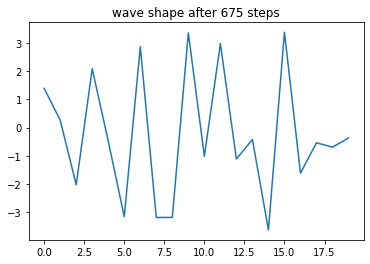

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_675/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_675/model_weights.tf
generator loss:0.9168624738391264
-----------------------
total discriminator loss:0.5269863555431269
average true return:0.5271039255675376
-----------------------


 43%|████▎     | 676/1562 [1:29:05<1:34:02,  6.37s/it]

Training Step: 676
generator loss:0.9218448490024242
-----------------------
total discriminator loss:0.522441653936331
average true return:0.5304571396520725
-----------------------


 43%|████▎     | 677/1562 [1:29:08<1:16:18,  5.17s/it]

Training Step: 677
generator loss:0.9086664584841291
-----------------------
total discriminator loss:0.5174051794035636
average true return:0.5304048805788562
-----------------------


 43%|████▎     | 678/1562 [1:29:10<1:03:43,  4.32s/it]

Training Step: 678
generator loss:0.9682625592869556
-----------------------
total discriminator loss:0.5156258129779507
average true return:0.5318975506765168
-----------------------


 43%|████▎     | 679/1562 [1:29:12<54:55,  3.73s/it]  

Training Step: 679
generator loss:0.9769984735874584
-----------------------
total discriminator loss:0.5164539739683602
average true return:0.5239727826146173
-----------------------


 44%|████▎     | 680/1562 [1:29:15<48:47,  3.32s/it]

Training Step: 680
event_types: [1, 0, 2, 2, 3, 2, 3, 2, 2, 0, 2, 2, 0, 3, 1, 1, 0, 3, 2, 1]
mad_score: 0.7222875
fid_score: 31356.33343882773
rule_score: 0.05625


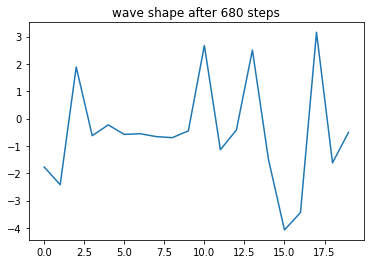

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_680/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_680/model_weights.tf
generator loss:0.9771413986873614
-----------------------
total discriminator loss:0.5227045135321708
average true return:0.5282711110989706
-----------------------


 44%|████▎     | 681/1562 [1:29:28<1:32:42,  6.31s/it]

Training Step: 681
generator loss:0.9659928203912236
-----------------------
total discriminator loss:0.5037469645616659
average true return:0.540822154382198
-----------------------


 44%|████▎     | 682/1562 [1:29:30<1:15:15,  5.13s/it]

Training Step: 682
generator loss:0.9854196311127422
-----------------------
total discriminator loss:0.48657002600089017
average true return:0.53263671917141
-----------------------


 44%|████▎     | 683/1562 [1:29:33<1:03:02,  4.30s/it]

Training Step: 683
generator loss:1.0020801197777727
-----------------------
total discriminator loss:0.4967907238687836
average true return:0.5343339969144933
-----------------------


 44%|████▍     | 684/1562 [1:29:35<54:42,  3.74s/it]  

Training Step: 684
generator loss:1.0200129747306228
-----------------------
total discriminator loss:0.5106785486837732
average true return:0.5396997160499852
-----------------------


 44%|████▍     | 685/1562 [1:29:38<49:38,  3.40s/it]

Training Step: 685
event_types: [2, 2, 1, 0, 3, 1, 0, 3, 1, 2, 0, 3, 0, 2, 0, 2, 2, 1, 0, 3]
mad_score: 0.7263
fid_score: 28740.34767504167
rule_score: 0.05025


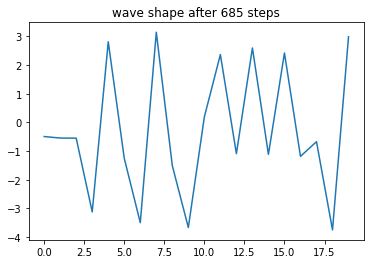

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_685/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_685/model_weights.tf
generator loss:0.9903985652097191
-----------------------


 44%|████▍     | 686/1562 [1:29:51<1:33:24,  6.40s/it]

total discriminator loss:0.5046949270838532
average true return:0.5385283454312577
-----------------------
Training Step: 686
generator loss:1.0273102686208486
-----------------------


 44%|████▍     | 687/1562 [1:29:53<1:14:00,  5.07s/it]

total discriminator loss:0.491513099066507
average true return:0.535917936797212
-----------------------
Training Step: 687
generator loss:1.0303333791441405
-----------------------
total discriminator loss:0.48979669858351826
average true return:0.5173500656926425
-----------------------


 44%|████▍     | 688/1562 [1:29:55<1:01:52,  4.25s/it]

Training Step: 688
generator loss:1.0543276408517983
-----------------------
total discriminator loss:0.5028755709563497
average true return:0.5293456956348399
-----------------------


 44%|████▍     | 689/1562 [1:29:58<53:36,  3.68s/it]  

Training Step: 689
generator loss:1.0542567113353072
-----------------------
total discriminator loss:0.48245683171704246
average true return:0.53115279856584
-----------------------


 44%|████▍     | 690/1562 [1:30:00<47:42,  3.28s/it]

Training Step: 690
event_types: [0, 1, 3, 1, 2, 1, 1, 0, 3, 2, 0, 3, 1, 0, 2, 1, 0, 3, 1, 0]
mad_score: 0.728075
fid_score: 25739.687562546893
rule_score: 0.055


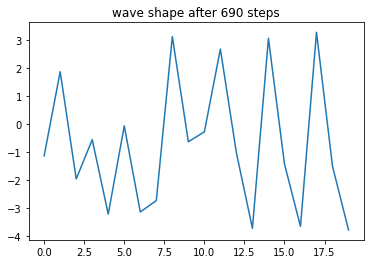

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_690/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_690/model_weights.tf
generator loss:1.070821294707357
-----------------------
total discriminator loss:0.5069989297812956
average true return:0.5323968368707865
-----------------------


 44%|████▍     | 691/1562 [1:30:14<1:33:15,  6.42s/it]

Training Step: 691
generator loss:1.051648496515266
-----------------------
total discriminator loss:0.48902914363642636
average true return:0.5410940686294321
-----------------------


 44%|████▍     | 692/1562 [1:30:16<1:15:18,  5.19s/it]

Training Step: 692
generator loss:1.101702323373329
-----------------------
total discriminator loss:0.5076894276349041
average true return:0.5230631154160394
-----------------------


 44%|████▍     | 693/1562 [1:30:19<1:02:52,  4.34s/it]

Training Step: 693
generator loss:1.0565151379342221
-----------------------
total discriminator loss:0.49431918724614754
average true return:0.5296982616943485
-----------------------


 44%|████▍     | 694/1562 [1:30:21<54:32,  3.77s/it]  

Training Step: 694
generator loss:1.0628628280128027
-----------------------


 44%|████▍     | 695/1562 [1:30:23<47:40,  3.30s/it]

total discriminator loss:0.5213230567294158
average true return:0.5244468995905548
-----------------------
Training Step: 695
event_types: [0, 3, 1, 0, 3, 0, 3, 1, 1, 0, 3, 0, 2, 1, 0, 1, 0, 2, 3, 3]
mad_score: 0.7249125
fid_score: 22080.817819686694
rule_score: 0.059


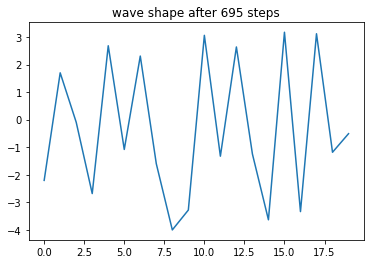

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_695/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_695/model_weights.tf
generator loss:1.08781974707124
-----------------------
total discriminator loss:0.486890749742548
average true return:0.544045745807813
-----------------------


 45%|████▍     | 696/1562 [1:30:36<1:30:34,  6.28s/it]

Training Step: 696
generator loss:1.0699383578106638
-----------------------
total discriminator loss:0.5111963971521907
average true return:0.5484609643979319
-----------------------


 45%|████▍     | 697/1562 [1:30:39<1:13:41,  5.11s/it]

Training Step: 697
generator loss:1.1033867780359659
-----------------------
total discriminator loss:1.1065078647368383
average true return:0.5402961183094231
-----------------------


 45%|████▍     | 698/1562 [1:30:41<1:01:36,  4.28s/it]

Training Step: 698
generator loss:1.1177952857783795
-----------------------
total discriminator loss:0.49992701491586744
average true return:0.5199665564110119
-----------------------


 45%|████▍     | 699/1562 [1:30:44<53:12,  3.70s/it]  

Training Step: 699
generator loss:1.1169902290851206
-----------------------
total discriminator loss:0.5204572786815553
average true return:0.5260049280708425
-----------------------


 45%|████▍     | 700/1562 [1:30:46<47:21,  3.30s/it]

Training Step: 700
event_types: [0, 3, 1, 0, 2, 2, 1, 0, 3, 1, 0, 3, 1, 0, 3, 3, 2, 1, 0, 3]
mad_score: 0.71585
fid_score: 18051.379708943026
rule_score: 0.07025


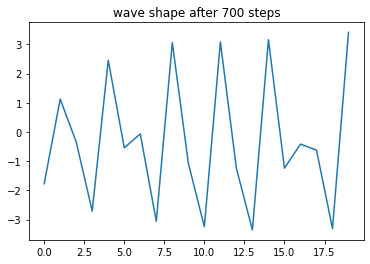

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_700/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_700/model_weights.tf
generator loss:1.1374350308567425
-----------------------
total discriminator loss:0.5094770919620366
average true return:0.5225489222189907
-----------------------


 45%|████▍     | 701/1562 [1:30:59<1:28:14,  6.15s/it]

Training Step: 701
generator loss:1.1421520191542829
-----------------------
total discriminator loss:0.5300870020258484
average true return:0.5127436860076949
-----------------------


 45%|████▍     | 702/1562 [1:31:01<1:11:47,  5.01s/it]

Training Step: 702
generator loss:1.122863354177339
-----------------------
total discriminator loss:0.5446559269611324
average true return:0.512977505869552
-----------------------


 45%|████▌     | 703/1562 [1:31:03<1:00:14,  4.21s/it]

Training Step: 703
generator loss:1.1096356452575513
-----------------------
total discriminator loss:0.5671243333135727
average true return:0.4946480171402246
-----------------------


 45%|████▌     | 704/1562 [1:31:06<52:18,  3.66s/it]  

Training Step: 704
generator loss:1.0716110776647243
-----------------------
total discriminator loss:0.5546094047048518
average true return:0.5162347324494846
-----------------------


 45%|████▌     | 705/1562 [1:31:09<49:14,  3.45s/it]

Training Step: 705
event_types: [2, 1, 0, 3, 2, 2, 2, 2, 3, 3, 1, 1, 0, 2, 2, 3, 2, 3, 1, 0]
mad_score: 0.70785
fid_score: 14375.301966234969
rule_score: 0.08675


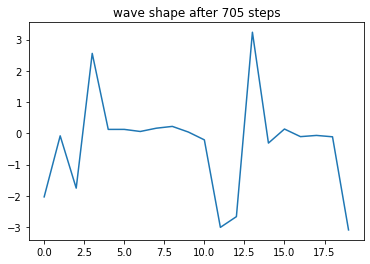

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_705/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_705/model_weights.tf
generator loss:1.0754922478648803
-----------------------
total discriminator loss:0.5910909033492446
average true return:0.5081253760984739
-----------------------


 45%|████▌     | 706/1562 [1:31:36<2:30:42, 10.56s/it]

Training Step: 706
generator loss:1.077699606528615
-----------------------
total discriminator loss:0.5812971277240809
average true return:0.5050776959634226
-----------------------


 45%|████▌     | 707/1562 [1:31:41<2:06:17,  8.86s/it]

Training Step: 707
generator loss:0.9892677566460931
-----------------------
total discriminator loss:0.5780227556780044
average true return:0.5185486277104696
-----------------------


 45%|████▌     | 708/1562 [1:31:45<1:48:11,  7.60s/it]

Training Step: 708
generator loss:0.984342212795473
-----------------------
total discriminator loss:0.5757974941498085
average true return:0.5239264853732741
-----------------------


 45%|████▌     | 709/1562 [1:31:50<1:35:52,  6.74s/it]

Training Step: 709
generator loss:0.9921459401144
-----------------------
total discriminator loss:0.5797540734427591
average true return:0.5253639668559513
-----------------------


 45%|████▌     | 710/1562 [1:31:55<1:26:26,  6.09s/it]

Training Step: 710
event_types: [0, 1, 1, 0, 2, 2, 1, 1, 1, 0, 3, 1, 0, 3, 3, 0, 2, 2, 3, 2]
mad_score: 0.6940125
fid_score: 11106.504086850957
rule_score: 0.09575


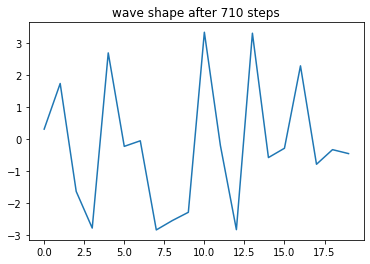

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_710/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_710/model_weights.tf
generator loss:0.9408507160104955
-----------------------
total discriminator loss:0.5909337874044976
average true return:0.5350220643102952
-----------------------


 46%|████▌     | 711/1562 [1:32:21<2:52:31, 12.16s/it]

Training Step: 711
generator loss:0.8925196402511795
-----------------------
total discriminator loss:0.6090901272894411
average true return:0.5531824602874492
-----------------------


 46%|████▌     | 712/1562 [1:32:26<2:21:28,  9.99s/it]

Training Step: 712
generator loss:0.8291969287265173
-----------------------
total discriminator loss:0.6228874290493918
average true return:0.5296251825270915
-----------------------


 46%|████▌     | 713/1562 [1:32:31<1:59:23,  8.44s/it]

Training Step: 713
generator loss:0.8130403258556858
-----------------------
total discriminator loss:0.6341943109119645
average true return:0.5520188784386972
-----------------------


 46%|████▌     | 714/1562 [1:32:36<1:43:56,  7.35s/it]

Training Step: 714
generator loss:0.8288653765300206
-----------------------
total discriminator loss:0.6536326531827139
average true return:0.5518769599205717
-----------------------


 46%|████▌     | 715/1562 [1:32:40<1:32:50,  6.58s/it]

Training Step: 715
event_types: [0, 3, 2, 2, 1, 2, 1, 1, 0, 3, 1, 2, 3, 2, 1, 0, 3, 1, 0, 3]
mad_score: 0.6805125
fid_score: 8392.109991167974
rule_score: 0.11375


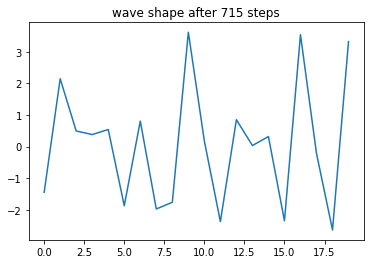

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_715/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_715/model_weights.tf
generator loss:0.8323434916084398
-----------------------
total discriminator loss:0.6583489155279423
average true return:0.5385377024359903
-----------------------


 46%|████▌     | 716/1562 [1:33:06<2:54:50, 12.40s/it]

Training Step: 716
generator loss:0.8148575906978901
-----------------------
total discriminator loss:0.6669790470557866
average true return:0.5291040886447582
-----------------------


 46%|████▌     | 717/1562 [1:33:11<2:22:28, 10.12s/it]

Training Step: 717
generator loss:0.7797502304935466
-----------------------
total discriminator loss:0.6482683118961098
average true return:0.5179222014407694
-----------------------


 46%|████▌     | 718/1562 [1:33:16<1:59:57,  8.53s/it]

Training Step: 718
generator loss:0.7851722962485205
-----------------------
total discriminator loss:0.6790889498710249
average true return:0.5140841669610077
-----------------------


 46%|████▌     | 719/1562 [1:33:21<1:44:04,  7.41s/it]

Training Step: 719
generator loss:0.8053897797489334
-----------------------
total discriminator loss:0.6790140185865603
average true return:0.517018570806288
-----------------------


 46%|████▌     | 720/1562 [1:33:26<1:33:27,  6.66s/it]

Training Step: 720
event_types: [2, 0, 3, 1, 1, 0, 3, 0, 2, 2, 2, 1, 0, 3, 2, 1, 2, 3, 1, 0]
mad_score: 0.665575
fid_score: 6289.588328909088
rule_score: 0.105


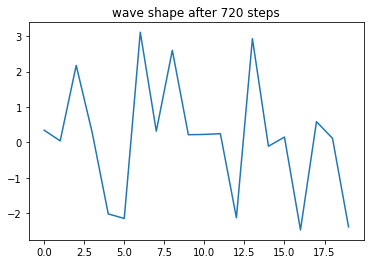

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_720/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_720/model_weights.tf
generator loss:0.7820553097265279
-----------------------
total discriminator loss:0.6790012045608099
average true return:0.5125400453330896
-----------------------


 46%|████▌     | 721/1562 [1:33:52<2:55:33, 12.52s/it]

Training Step: 721
generator loss:0.7530864441448252
-----------------------
total discriminator loss:0.6918607430928493
average true return:0.5244362474410127
-----------------------


 46%|████▌     | 722/1562 [1:33:57<2:22:14, 10.16s/it]

Training Step: 722
generator loss:0.7180203624355783
-----------------------
total discriminator loss:0.7084550296970862
average true return:0.5329106093338416
-----------------------


 46%|████▋     | 723/1562 [1:34:01<1:59:59,  8.58s/it]

Training Step: 723
generator loss:0.7045595827845952
-----------------------
total discriminator loss:0.6991395253670548
average true return:0.5243588168969949
-----------------------


 46%|████▋     | 724/1562 [1:34:06<1:43:48,  7.43s/it]

Training Step: 724
generator loss:0.7088218989850039
-----------------------
total discriminator loss:0.7011119140983412
average true return:0.5310571867770818
-----------------------


 46%|████▋     | 725/1562 [1:34:11<1:32:31,  6.63s/it]

Training Step: 725
event_types: [3, 1, 2, 3, 1, 0, 2, 1, 2, 2, 2, 0, 1, 2, 3, 0, 2, 2, 2, 2]
mad_score: 0.6468625
fid_score: 4714.094737137318
rule_score: 0.12175


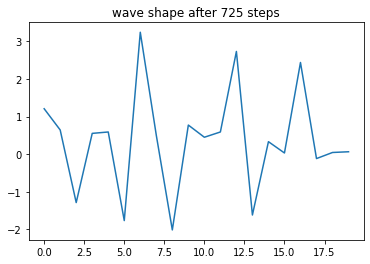

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_725/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_725/model_weights.tf
generator loss:0.6926742911294768
-----------------------
total discriminator loss:0.6978126988173095
average true return:0.5491678527337795
-----------------------


 46%|████▋     | 726/1562 [1:34:37<2:54:00, 12.49s/it]

Training Step: 726
generator loss:0.6887949793281398
-----------------------
total discriminator loss:0.6964279811634395
average true return:0.537836659938972
-----------------------


 47%|████▋     | 727/1562 [1:34:42<2:20:08, 10.07s/it]

Training Step: 727
generator loss:0.6680193243873194
-----------------------
total discriminator loss:0.6977701992259098
average true return:0.540532752127015
-----------------------


 47%|████▋     | 728/1562 [1:34:46<1:57:07,  8.43s/it]

Training Step: 728
generator loss:0.6794113180111818
-----------------------
total discriminator loss:0.6905472722928787
average true return:0.5265032320488205
-----------------------


 47%|████▋     | 729/1562 [1:34:51<1:40:40,  7.25s/it]

Training Step: 729
generator loss:0.6975585085352141
-----------------------
total discriminator loss:0.7004224497682363
average true return:0.5331567468607155
-----------------------


 47%|████▋     | 730/1562 [1:34:55<1:29:08,  6.43s/it]

Training Step: 730
event_types: [0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 3, 2, 2, 1, 0, 3, 3, 2, 3, 0]
mad_score: 0.6296625
fid_score: 3641.381846419543
rule_score: 0.1405


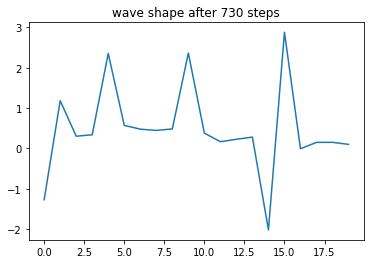

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_730/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_730/model_weights.tf
generator loss:0.695631301323365
-----------------------
total discriminator loss:0.6886719660410203
average true return:0.5292816158114582
-----------------------


 47%|████▋     | 731/1562 [1:35:20<2:46:44, 12.04s/it]

Training Step: 731
generator loss:0.7056118729895297
-----------------------
total discriminator loss:0.6877667811819839
average true return:0.5133872143203743
-----------------------


 47%|████▋     | 732/1562 [1:35:26<2:19:10, 10.06s/it]

Training Step: 732
generator loss:0.7404696299076595
-----------------------
total discriminator loss:0.6742111992791923
average true return:0.5120280161749069
-----------------------


 47%|████▋     | 733/1562 [1:35:30<1:56:55,  8.46s/it]

Training Step: 733
generator loss:0.7291095325086989
-----------------------
total discriminator loss:0.6721863802649486
average true return:0.5051176586479782
-----------------------


 47%|████▋     | 734/1562 [1:35:35<1:42:09,  7.40s/it]

Training Step: 734
generator loss:0.7329661462523807
-----------------------
total discriminator loss:0.6642012926170293
average true return:0.5102814716622579
-----------------------


 47%|████▋     | 735/1562 [1:35:40<1:32:09,  6.69s/it]

Training Step: 735
event_types: [2, 0, 3, 0, 2, 2, 1, 0, 2, 2, 2, 3, 2, 3, 1, 2, 1, 0, 3, 1]
mad_score: 0.6173125
fid_score: 3139.7014686686307
rule_score: 0.1385


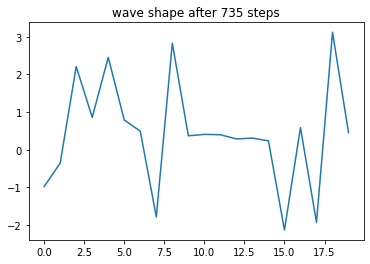

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_735/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_735/model_weights.tf
generator loss:0.7522802637645951
-----------------------
total discriminator loss:0.6688128675692135
average true return:0.49905889108612134
-----------------------


 47%|████▋     | 736/1562 [1:36:06<2:50:54, 12.42s/it]

Training Step: 736
generator loss:0.7455832738203405
-----------------------
total discriminator loss:0.6590023639047341
average true return:0.4986330660034437
-----------------------


 47%|████▋     | 737/1562 [1:36:11<2:19:39, 10.16s/it]

Training Step: 737
generator loss:0.7924867285935038
-----------------------
total discriminator loss:0.6590431018015068
average true return:0.4927097715308657
-----------------------


 47%|████▋     | 738/1562 [1:36:16<1:57:44,  8.57s/it]

Training Step: 738
generator loss:0.7898874547930036
-----------------------
total discriminator loss:0.654295363883681
average true return:0.4919721649132489
-----------------------


 47%|████▋     | 739/1562 [1:36:21<1:41:46,  7.42s/it]

Training Step: 739
generator loss:0.7828721255647246
-----------------------
total discriminator loss:0.6436801905527106
average true return:0.49115350213708975
-----------------------


 47%|████▋     | 740/1562 [1:36:25<1:30:54,  6.64s/it]

Training Step: 740
event_types: [2, 2, 1, 0, 2, 1, 2, 3, 2, 2, 3, 3, 2, 2, 0, 2, 2, 3, 3, 2]
mad_score: 0.6031
fid_score: 2786.037607481025
rule_score: 0.14325


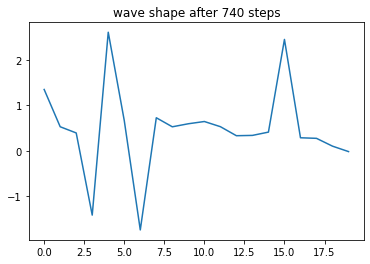

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_740/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_740/model_weights.tf
generator loss:0.7856109570832157
-----------------------
total discriminator loss:0.6543696923485283
average true return:0.49571380078169824
-----------------------


 47%|████▋     | 741/1562 [1:36:51<2:50:21, 12.45s/it]

Training Step: 741
generator loss:0.7917388842946749
-----------------------
total discriminator loss:0.633721233530669
average true return:0.4958623391548526
-----------------------


 48%|████▊     | 742/1562 [1:36:56<2:18:55, 10.17s/it]

Training Step: 742
generator loss:0.7967234834536954
-----------------------
total discriminator loss:0.6442461248649949
average true return:0.4946525773829711
-----------------------


 48%|████▊     | 743/1562 [1:37:01<1:57:05,  8.58s/it]

Training Step: 743
generator loss:0.8137761403472569
-----------------------
total discriminator loss:0.6410387098583874
average true return:0.498788667047238
-----------------------


 48%|████▊     | 744/1562 [1:37:06<1:41:27,  7.44s/it]

Training Step: 744
generator loss:0.8076295343859452
-----------------------
total discriminator loss:0.618611914122489
average true return:0.5057091189331882
-----------------------


 48%|████▊     | 745/1562 [1:37:11<1:30:27,  6.64s/it]

Training Step: 745
event_types: [1, 0, 2, 0, 3, 2, 2, 1, 2, 1, 0, 3, 3, 1, 1, 0, 3, 1, 2, 3]
mad_score: 0.5972
fid_score: 2501.054134953566
rule_score: 0.15575


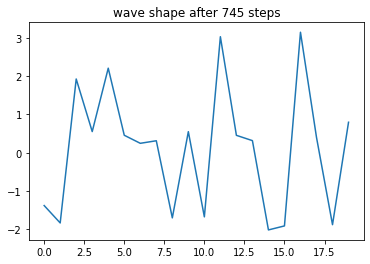

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_745/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_745/model_weights.tf
generator loss:0.8112094322444326
-----------------------
total discriminator loss:0.6184306116518932
average true return:0.4930108401807187
-----------------------


 48%|████▊     | 746/1562 [1:37:37<2:51:58, 12.65s/it]

Training Step: 746
generator loss:0.8104860825173654
-----------------------
total discriminator loss:0.6095100340872274
average true return:0.5150224970442061
-----------------------


 48%|████▊     | 747/1562 [1:37:42<2:19:52, 10.30s/it]

Training Step: 747
generator loss:0.815012010788226
-----------------------
total discriminator loss:0.8043771000455213
average true return:0.5048804152201869
-----------------------


 48%|████▊     | 748/1562 [1:37:47<1:57:04,  8.63s/it]

Training Step: 748
generator loss:0.8134775240202156
-----------------------
total discriminator loss:0.6057876175471582
average true return:0.5108415213645128
-----------------------


 48%|████▊     | 749/1562 [1:37:52<1:40:43,  7.43s/it]

Training Step: 749
generator loss:0.8126554195405244
-----------------------
total discriminator loss:0.5976483841381323
average true return:0.5127787264757645
-----------------------


 48%|████▊     | 750/1562 [1:37:57<1:30:37,  6.70s/it]

Training Step: 750
event_types: [2, 1, 0, 2, 3, 3, 2, 2, 3, 1, 2, 2, 3, 2, 2, 2, 3, 3, 2, 0]
mad_score: 0.5933875
fid_score: 2292.2911038377124
rule_score: 0.166


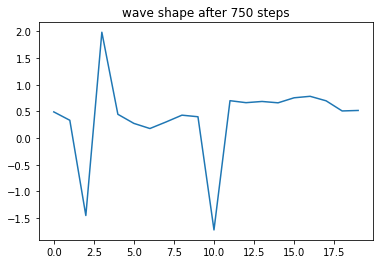

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_750/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_750/model_weights.tf
generator loss:0.8249042162636167
-----------------------
total discriminator loss:0.608180624170106
average true return:0.5135502591273743
-----------------------


 48%|████▊     | 751/1562 [1:38:22<2:46:04, 12.29s/it]

Training Step: 751
generator loss:0.819638147661763
-----------------------
total discriminator loss:0.5876221512005548
average true return:0.522804818145796
-----------------------


 48%|████▊     | 752/1562 [1:38:27<2:14:50,  9.99s/it]

Training Step: 752
generator loss:0.8088768384235276
-----------------------
total discriminator loss:0.5965459074822842
average true return:0.5208803526041264
-----------------------


 48%|████▊     | 753/1562 [1:38:31<1:53:30,  8.42s/it]

Training Step: 753
generator loss:0.8326235949333756
-----------------------
total discriminator loss:0.6030897138282115
average true return:0.5098228413508901
-----------------------


 48%|████▊     | 754/1562 [1:38:36<1:37:22,  7.23s/it]

Training Step: 754
generator loss:0.8641980094801862
-----------------------
total discriminator loss:0.6043864344813834
average true return:0.49930803418096015
-----------------------


 48%|████▊     | 755/1562 [1:38:40<1:26:56,  6.46s/it]

Training Step: 755
event_types: [1, 1, 1, 0, 3, 1, 0, 3, 2, 2, 3, 1, 0, 3, 2, 2, 2, 2, 3, 2]
mad_score: 0.595125
fid_score: 1935.9799307798185
rule_score: 0.173


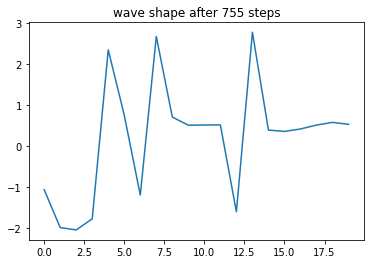

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_755/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_755/model_weights.tf
generator loss:0.8724138546129567
-----------------------
total discriminator loss:0.5965973015172861
average true return:0.5057244936035645
-----------------------


 48%|████▊     | 756/1562 [1:39:06<2:42:51, 12.12s/it]

Training Step: 756
generator loss:0.8867337902201454
-----------------------
total discriminator loss:0.5860949154369226
average true return:0.5007665128752105
-----------------------


 48%|████▊     | 757/1562 [1:39:11<2:13:27,  9.95s/it]

Training Step: 757
generator loss:0.9052713624782208
-----------------------
total discriminator loss:0.578917901051859
average true return:0.49520399513890634
-----------------------


 49%|████▊     | 758/1562 [1:39:15<1:52:03,  8.36s/it]

Training Step: 758
generator loss:0.9519740321610288
-----------------------
total discriminator loss:0.5743047613244692
average true return:0.4923489090765364
-----------------------


 49%|████▊     | 759/1562 [1:39:20<1:37:14,  7.27s/it]

Training Step: 759
generator loss:0.944104318073818
-----------------------
total discriminator loss:0.5848627498755671
average true return:0.4947180133409095
-----------------------


 49%|████▊     | 760/1562 [1:39:25<1:27:27,  6.54s/it]

Training Step: 760
event_types: [1, 0, 2, 3, 2, 2, 1, 1, 2, 3, 3, 2, 0, 2, 2, 3, 3, 2, 3, 2]
mad_score: 0.601775
fid_score: 1531.1436167268917
rule_score: 0.162


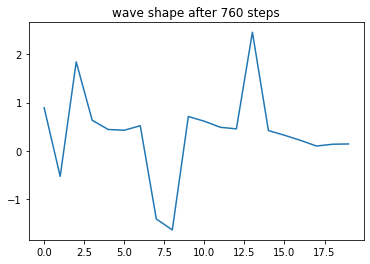

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_760/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_760/model_weights.tf
generator loss:0.9463060375642451
-----------------------
total discriminator loss:0.5972042014162504
average true return:0.4889063226833006
-----------------------


 49%|████▊     | 761/1562 [1:39:52<2:47:56, 12.58s/it]

Training Step: 761
generator loss:0.9551635403489175
-----------------------
total discriminator loss:0.5602806565174777
average true return:0.4953805131614144
-----------------------


 49%|████▉     | 762/1562 [1:39:56<2:16:25, 10.23s/it]

Training Step: 762
generator loss:0.9511869221910825
-----------------------
total discriminator loss:0.5872092687721449
average true return:0.48292276195052336
-----------------------


 49%|████▉     | 763/1562 [1:40:01<1:54:48,  8.62s/it]

Training Step: 763
generator loss:0.9472058048027976
-----------------------
total discriminator loss:0.6064327107202464
average true return:0.48465566487622375
-----------------------


 49%|████▉     | 764/1562 [1:40:06<1:39:40,  7.49s/it]

Training Step: 764
generator loss:0.9705551763366426
-----------------------
total discriminator loss:0.6036146287481384
average true return:0.48387559832070115
-----------------------


 49%|████▉     | 765/1562 [1:40:11<1:28:16,  6.65s/it]

Training Step: 765
event_types: [3, 2, 1, 2, 1, 0, 3, 2, 2, 1, 2, 3, 1, 0, 3, 2, 2, 3, 3, 3]
mad_score: 0.6107875
fid_score: 1125.0125445568658
rule_score: 0.17275


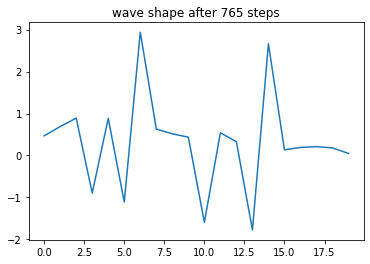

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_765/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_765/model_weights.tf
generator loss:0.9147060082476617
-----------------------
total discriminator loss:0.6151170614194158
average true return:0.48683172385815665
-----------------------


 49%|████▉     | 766/1562 [1:40:36<2:43:31, 12.33s/it]

Training Step: 766
generator loss:0.8774207050491427
-----------------------
total discriminator loss:0.6080365775938743
average true return:0.5171212430318004
-----------------------


 49%|████▉     | 767/1562 [1:40:41<2:13:30, 10.08s/it]

Training Step: 767
generator loss:0.905992661940743
-----------------------
total discriminator loss:0.6137135171699379
average true return:0.5109626505195197
-----------------------


 49%|████▉     | 768/1562 [1:40:46<1:52:25,  8.50s/it]

Training Step: 768
generator loss:0.888929513569474
-----------------------
total discriminator loss:0.6104587513536818
average true return:0.5044005841041503
-----------------------


 49%|████▉     | 769/1562 [1:40:51<1:38:10,  7.43s/it]

Training Step: 769
generator loss:0.8985900092413718
-----------------------
total discriminator loss:0.6263210148493108
average true return:0.49706582576399366
-----------------------


 49%|████▉     | 770/1562 [1:40:56<1:27:23,  6.62s/it]

Training Step: 770
event_types: [2, 2, 0, 2, 3, 2, 2, 3, 2, 1, 0, 3, 2, 1, 2, 2, 1, 0, 3, 2]
mad_score: 0.620325
fid_score: 796.2523441775315
rule_score: 0.18075


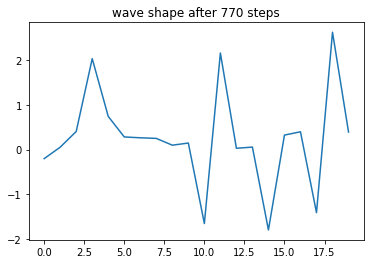

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_770/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_770/model_weights.tf
generator loss:0.9063519467315471
-----------------------
total discriminator loss:0.6422716720465482
average true return:0.4992788033291207
-----------------------


 49%|████▉     | 771/1562 [1:41:21<2:43:05, 12.37s/it]

Training Step: 771
generator loss:0.9433221737335098
-----------------------
total discriminator loss:0.6527404515567479
average true return:0.4813653683163862
-----------------------


 49%|████▉     | 772/1562 [1:41:26<2:12:49, 10.09s/it]

Training Step: 772
generator loss:0.8965572558163158
-----------------------
total discriminator loss:0.6212871645577993
average true return:0.48799272858820286
-----------------------


 49%|████▉     | 773/1562 [1:41:31<1:51:35,  8.49s/it]

Training Step: 773
generator loss:0.9299457929629609
-----------------------
total discriminator loss:0.8781104000468577
average true return:0.4858068533576696
-----------------------


 50%|████▉     | 774/1562 [1:41:36<1:37:14,  7.40s/it]

Training Step: 774
generator loss:0.9007800879813164
-----------------------
total discriminator loss:0.6580494887530991
average true return:0.4928612270096596
-----------------------


 50%|████▉     | 775/1562 [1:41:41<1:27:12,  6.65s/it]

Training Step: 775
event_types: [3, 3, 2, 3, 2, 2, 0, 1, 2, 2, 1, 0, 3, 2, 3, 2, 3, 0, 3, 2]
mad_score: 0.632925
fid_score: 599.6133112943407
rule_score: 0.1635


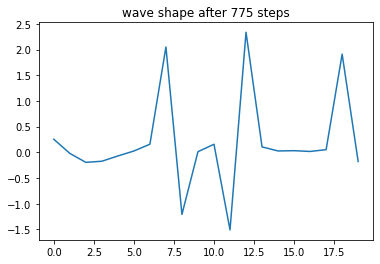

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_775/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_775/model_weights.tf
generator loss:0.8751291610220252
-----------------------
total discriminator loss:0.6761428568206602
average true return:0.5002993116563429
-----------------------


 50%|████▉     | 776/1562 [1:42:08<2:46:54, 12.74s/it]

Training Step: 776
generator loss:0.846446814627025
-----------------------
total discriminator loss:0.6418048972771495
average true return:0.49121750089067795
-----------------------


 50%|████▉     | 777/1562 [1:42:12<2:14:49, 10.31s/it]

Training Step: 777
generator loss:0.8709915008059275
-----------------------
total discriminator loss:0.653692907675925
average true return:0.4808172720259044
-----------------------


 50%|████▉     | 778/1562 [1:42:17<1:53:20,  8.67s/it]

Training Step: 778
generator loss:0.898584305588339
-----------------------
total discriminator loss:0.6793388657976415
average true return:0.4870171463960837
-----------------------


 50%|████▉     | 779/1562 [1:42:22<1:37:12,  7.45s/it]

Training Step: 779
generator loss:0.9186497130282282
-----------------------
total discriminator loss:0.6865822666307859
average true return:0.4609019982350396
-----------------------


 50%|████▉     | 780/1562 [1:42:26<1:24:50,  6.51s/it]

Training Step: 780
event_types: [3, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 3, 2, 3, 0, 3, 1, 0]
mad_score: 0.6450125
fid_score: 483.4348292300871
rule_score: 0.15575


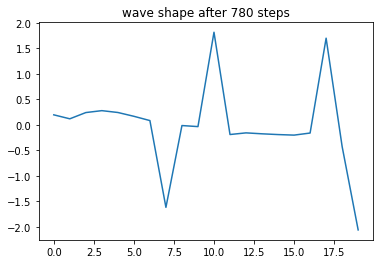

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_780/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_780/model_weights.tf
generator loss:0.9110763912479865
-----------------------
total discriminator loss:0.6774906135649439
average true return:0.4539982861904822
-----------------------


 50%|█████     | 781/1562 [1:42:51<2:35:08, 11.92s/it]

Training Step: 781
generator loss:0.9070414505307869
-----------------------
total discriminator loss:0.6550353468705045
average true return:0.4905167587930072
-----------------------


 50%|█████     | 782/1562 [1:42:55<2:07:07,  9.78s/it]

Training Step: 782
generator loss:0.871189664560392
-----------------------
total discriminator loss:0.7098326079362833
average true return:0.4461694924121429
-----------------------


 50%|█████     | 783/1562 [1:43:00<1:47:31,  8.28s/it]

Training Step: 783
generator loss:0.852555192643146
-----------------------
total discriminator loss:0.6843272876666842
average true return:0.4622435752599253
-----------------------


 50%|█████     | 784/1562 [1:43:05<1:33:23,  7.20s/it]

Training Step: 784
generator loss:0.8319898295541481
-----------------------
total discriminator loss:0.6816636930433906
average true return:0.48351731364981365
-----------------------


 50%|█████     | 785/1562 [1:43:09<1:23:02,  6.41s/it]

Training Step: 785
event_types: [2, 2, 2, 2, 2, 2, 1, 1, 2, 3, 0, 2, 2, 2, 0, 0, 3, 1, 2, 0]
mad_score: 0.653875
fid_score: 558.5275997474344
rule_score: 0.16175


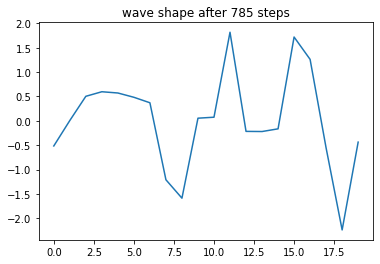

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_785/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_785/model_weights.tf
generator loss:0.8173663341542469
-----------------------
total discriminator loss:0.7036809978269907
average true return:0.48264645521293104
-----------------------


 50%|█████     | 786/1562 [1:43:35<2:37:43, 12.19s/it]

Training Step: 786
generator loss:0.7851345933719879
-----------------------
total discriminator loss:0.7191741835033651
average true return:0.47827863446954866
-----------------------


 50%|█████     | 787/1562 [1:43:40<2:10:30, 10.10s/it]

Training Step: 787
generator loss:0.7681884506966028
-----------------------
total discriminator loss:0.7000557911307584
average true return:0.48867688887798577
-----------------------


 50%|█████     | 788/1562 [1:43:45<1:50:20,  8.55s/it]

Training Step: 788
generator loss:0.7583456744662032
-----------------------
total discriminator loss:0.6999139319988783
average true return:0.4921468571248375
-----------------------


 51%|█████     | 789/1562 [1:43:50<1:35:52,  7.44s/it]

Training Step: 789
generator loss:0.7670843570323671
-----------------------
total discriminator loss:0.6947742314418737
average true return:0.48953591054279266
-----------------------


 51%|█████     | 790/1562 [1:43:55<1:25:58,  6.68s/it]

Training Step: 790
event_types: [2, 1, 1, 0, 3, 2, 2, 2, 1, 0, 3, 3, 2, 3, 2, 0, 2, 3, 2, 0]
mad_score: 0.6581125
fid_score: 677.5058764294297
rule_score: 0.1695


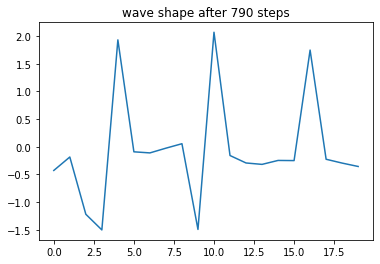

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_790/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_790/model_weights.tf
generator loss:0.7815950869297117
-----------------------
total discriminator loss:0.7075421010351826
average true return:0.48243603907158306
-----------------------


 51%|█████     | 791/1562 [1:44:21<2:41:00, 12.53s/it]

Training Step: 791
generator loss:0.7411948393171308
-----------------------
total discriminator loss:0.6962635280159364
average true return:0.48731254555586007
-----------------------


 51%|█████     | 792/1562 [1:44:26<2:11:08, 10.22s/it]

Training Step: 792
generator loss:0.7735307872076111
-----------------------
total discriminator loss:0.6908851787209089
average true return:0.498300621199226
-----------------------


 51%|█████     | 793/1562 [1:44:31<1:50:05,  8.59s/it]

Training Step: 793
generator loss:0.7643454462961572
-----------------------
total discriminator loss:0.6806121842065543
average true return:0.4898459863462922
-----------------------


 51%|█████     | 794/1562 [1:44:35<1:34:51,  7.41s/it]

Training Step: 794
generator loss:0.7854236327125415
-----------------------
total discriminator loss:0.673285422040673
average true return:0.4874922462527861
-----------------------


 51%|█████     | 795/1562 [1:44:40<1:24:47,  6.63s/it]

Training Step: 795
event_types: [1, 0, 2, 2, 1, 1, 1, 0, 3, 2, 2, 2, 2, 0, 2, 3, 2, 1, 0, 1]
mad_score: 0.665925
fid_score: 884.3961882228483
rule_score: 0.1745


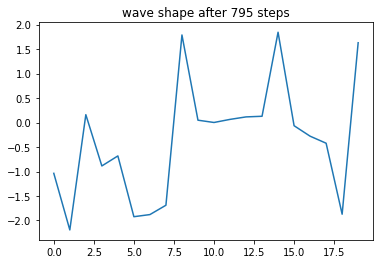

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_795/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_795/model_weights.tf
generator loss:0.8161183356219688
-----------------------
total discriminator loss:0.685282287996624
average true return:0.468055622771817
-----------------------


 51%|█████     | 796/1562 [1:45:06<2:37:59, 12.38s/it]

Training Step: 796
generator loss:0.8214135051919722
-----------------------
total discriminator loss:0.6801954201427229
average true return:0.4776181673233726
-----------------------


 51%|█████     | 797/1562 [1:45:11<2:09:04, 10.12s/it]

Training Step: 797
generator loss:0.8231240085575307
-----------------------
total discriminator loss:0.6699825455254446
average true return:0.46248666277437206
-----------------------


 51%|█████     | 798/1562 [1:45:16<1:48:35,  8.53s/it]

Training Step: 798
generator loss:0.8541283022534714
-----------------------
total discriminator loss:0.6679336080263988
average true return:0.47004315464914476
-----------------------


 51%|█████     | 799/1562 [1:45:20<1:34:15,  7.41s/it]

Training Step: 799
generator loss:0.8495374422931201
-----------------------
total discriminator loss:0.6794170748271313
average true return:0.46819894075761875
-----------------------


 51%|█████     | 800/1562 [1:45:25<1:23:17,  6.56s/it]

Training Step: 800
event_types: [1, 0, 2, 0, 1, 1, 0, 2, 2, 3, 3, 3, 2, 1, 0, 3, 2, 2, 1, 1]
mad_score: 0.6686
fid_score: 1101.1203312130424
rule_score: 0.175


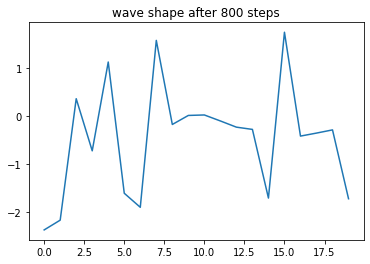

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_800/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_800/model_weights.tf
generator loss:0.8457829576210425
-----------------------
total discriminator loss:0.7489662221057317
average true return:0.45783996411204797
-----------------------


 51%|█████▏    | 801/1562 [1:45:51<2:37:42, 12.43s/it]

Training Step: 801
generator loss:0.8526167537955152
-----------------------
total discriminator loss:0.6639389708910076
average true return:0.47195379178586455
-----------------------


 51%|█████▏    | 802/1562 [1:45:56<2:08:17, 10.13s/it]

Training Step: 802
generator loss:0.8304028613710386
-----------------------
total discriminator loss:0.6570554053004171
average true return:0.48211215891472425
-----------------------


 51%|█████▏    | 803/1562 [1:46:01<1:47:05,  8.47s/it]

Training Step: 803
generator loss:0.8308605967970635
-----------------------
total discriminator loss:0.6630958682124409
average true return:0.47465874197995694
-----------------------


 51%|█████▏    | 804/1562 [1:46:05<1:33:27,  7.40s/it]

Training Step: 804
generator loss:0.8445174209995111
-----------------------
total discriminator loss:0.6425714962255895
average true return:0.4636001581872037
-----------------------


 52%|█████▏    | 805/1562 [1:46:10<1:23:59,  6.66s/it]

Training Step: 805
event_types: [1, 2, 1, 0, 1, 0, 3, 0, 3, 2, 2, 3, 1, 0, 1, 0, 3, 2, 1, 0]
mad_score: 0.6678125
fid_score: 1243.5394692807945
rule_score: 0.1815


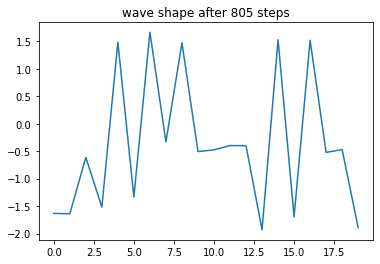

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_805/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_805/model_weights.tf
generator loss:0.8384731658676237
-----------------------
total discriminator loss:0.6528609711586004
average true return:0.47001193719330864
-----------------------


 52%|█████▏    | 806/1562 [1:46:34<2:28:53, 11.82s/it]

Training Step: 806
generator loss:0.8043960023722443
-----------------------
total discriminator loss:0.6534883458826681
average true return:0.4789266732768881
-----------------------


 52%|█████▏    | 807/1562 [1:46:39<2:01:48,  9.68s/it]

Training Step: 807
generator loss:0.8460290249114625
-----------------------
total discriminator loss:0.6493561503230648
average true return:0.4882146160124069
-----------------------


 52%|█████▏    | 808/1562 [1:46:44<1:43:27,  8.23s/it]

Training Step: 808
generator loss:0.8535429630833109
-----------------------
total discriminator loss:0.6384855529148552
average true return:0.49171810044587155
-----------------------


 52%|█████▏    | 809/1562 [1:46:48<1:30:03,  7.18s/it]

Training Step: 809
generator loss:0.8567719027238683
-----------------------
total discriminator loss:0.6285097002216502
average true return:0.4769780933373654
-----------------------


 52%|█████▏    | 810/1562 [1:46:53<1:20:38,  6.43s/it]

Training Step: 810
event_types: [1, 3, 3, 2, 2, 3, 3, 2, 0, 3, 0, 2, 1, 0, 2, 2, 3, 3, 2, 3]
mad_score: 0.6658625
fid_score: 1346.3669960566967
rule_score: 0.1805


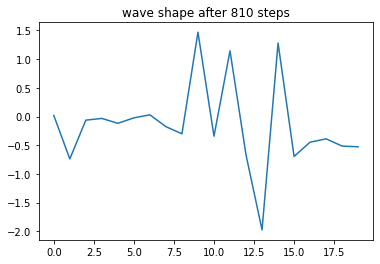

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_810/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_810/model_weights.tf
generator loss:0.840045415877148
-----------------------
total discriminator loss:0.6230790514900009
average true return:0.48679498481415107
-----------------------


 52%|█████▏    | 811/1562 [1:47:20<2:35:37, 12.43s/it]

Training Step: 811
generator loss:0.8778253335330078
-----------------------
total discriminator loss:0.6377338390844554
average true return:0.49243143703990344
-----------------------


 52%|█████▏    | 812/1562 [1:47:24<2:06:30, 10.12s/it]

Training Step: 812
generator loss:0.8353833752132509
-----------------------
total discriminator loss:0.635078618598303
average true return:0.49990836824546525
-----------------------


 52%|█████▏    | 813/1562 [1:47:29<1:46:36,  8.54s/it]

Training Step: 813
generator loss:0.866163882138526
-----------------------
total discriminator loss:0.625861680789075
average true return:0.495378344489911
-----------------------


 52%|█████▏    | 814/1562 [1:47:34<1:31:20,  7.33s/it]

Training Step: 814
generator loss:0.9206500881783188
-----------------------
total discriminator loss:0.6120937267750151
average true return:0.48676350769701343
-----------------------


 52%|█████▏    | 815/1562 [1:47:39<1:22:18,  6.61s/it]

Training Step: 815
event_types: [2, 3, 1, 2, 2, 3, 3, 0, 3, 2, 1, 0, 1, 0, 2, 3, 2, 1, 0, 1]
mad_score: 0.6595
fid_score: 1339.8072438146796
rule_score: 0.20275


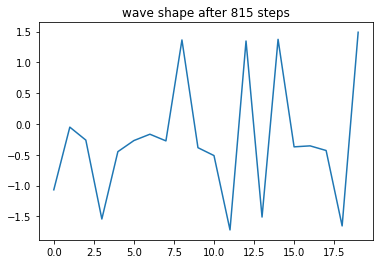

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_815/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_815/model_weights.tf
generator loss:0.8979586859558496
-----------------------
total discriminator loss:0.6129342633894372
average true return:0.49497288051243726
-----------------------


 52%|█████▏    | 816/1562 [1:48:05<2:35:55, 12.54s/it]

Training Step: 816
generator loss:0.9386914141336817
-----------------------
total discriminator loss:0.6187506394257349
average true return:0.48662177105565074
-----------------------


 52%|█████▏    | 817/1562 [1:48:10<2:05:59, 10.15s/it]

Training Step: 817
generator loss:0.9395732409356691
-----------------------
total discriminator loss:0.6180665547304643
average true return:0.4739861536059172
-----------------------


 52%|█████▏    | 818/1562 [1:48:14<1:45:59,  8.55s/it]

Training Step: 818
generator loss:0.959734512876212
-----------------------
total discriminator loss:0.6101235124305738
average true return:0.48156799501831804
-----------------------


 52%|█████▏    | 819/1562 [1:48:20<1:33:37,  7.56s/it]

Training Step: 819
generator loss:0.9806124453862637
-----------------------
total discriminator loss:0.595896629071101
average true return:0.46867331686872427
-----------------------


 52%|█████▏    | 820/1562 [1:48:24<1:23:08,  6.72s/it]

Training Step: 820
event_types: [2, 1, 2, 2, 0, 3, 1, 0, 1, 1, 0, 3, 1, 0, 3, 1, 0, 3, 2, 2]
mad_score: 0.6553875
fid_score: 1274.9131862052702
rule_score: 0.21125


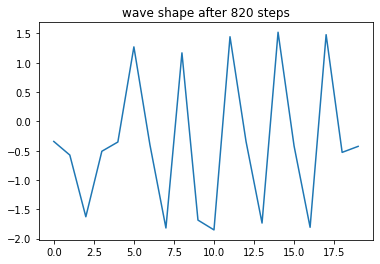

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_820/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_820/model_weights.tf
generator loss:0.9530400628305113
-----------------------
total discriminator loss:0.5996874659744855
average true return:0.463095179516823
-----------------------


 53%|█████▎    | 821/1562 [1:48:51<2:34:54, 12.54s/it]

Training Step: 821
generator loss:0.9872845341215638
-----------------------
total discriminator loss:0.596152601852741
average true return:0.4627244697155083
-----------------------


 53%|█████▎    | 822/1562 [1:48:55<2:06:00, 10.22s/it]

Training Step: 822
generator loss:0.9468757349041719
-----------------------
total discriminator loss:0.6047448398525623
average true return:0.4794031640468283
-----------------------


 53%|█████▎    | 823/1562 [1:49:00<1:46:11,  8.62s/it]

Training Step: 823
generator loss:0.9504093925382155
-----------------------
total discriminator loss:0.594044515045443
average true return:0.4707194109227717
-----------------------


 53%|█████▎    | 824/1562 [1:49:05<1:31:49,  7.47s/it]

Training Step: 824
generator loss:0.9630609576460499
-----------------------
total discriminator loss:0.6033107283054697
average true return:0.4927226764694784
-----------------------


 53%|█████▎    | 825/1562 [1:49:10<1:22:27,  6.71s/it]

Training Step: 825
event_types: [1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 0, 3, 2, 3, 2, 0, 2, 1, 2]
mad_score: 0.647625
fid_score: 1137.8557163974008
rule_score: 0.235


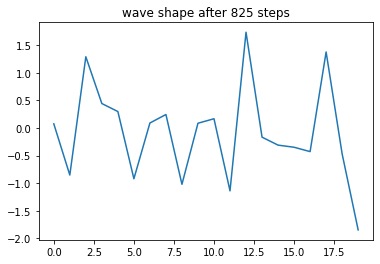

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_825/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_825/model_weights.tf
generator loss:0.947677927387983
-----------------------
total discriminator loss:0.6379446585838238
average true return:0.49724972446875837
-----------------------


 53%|█████▎    | 826/1562 [1:49:37<2:35:31, 12.68s/it]

Training Step: 826
generator loss:0.9224069047673785
-----------------------
total discriminator loss:0.6283262243980805
average true return:0.5114955932603636
-----------------------


 53%|█████▎    | 827/1562 [1:49:41<2:06:17, 10.31s/it]

Training Step: 827
generator loss:0.8860189988709681
-----------------------
total discriminator loss:0.5907234375849402
average true return:0.5201325342458811
-----------------------


 53%|█████▎    | 828/1562 [1:49:46<1:45:26,  8.62s/it]

Training Step: 828
generator loss:0.8968747522074687
-----------------------
total discriminator loss:0.589621717511642
average true return:0.510175438101176
-----------------------


 53%|█████▎    | 829/1562 [1:49:51<1:31:01,  7.45s/it]

Training Step: 829
generator loss:0.8455390612310056
-----------------------
total discriminator loss:0.5985121922248944
average true return:0.5152377196039302
-----------------------


 53%|█████▎    | 830/1562 [1:49:55<1:20:24,  6.59s/it]

Training Step: 830
event_types: [2, 0, 3, 1, 0, 3, 2, 0, 2, 0, 2, 2, 0, 2, 1, 2, 0, 3, 2, 3]
mad_score: 0.6355125
fid_score: 932.8802373801045
rule_score: 0.26325


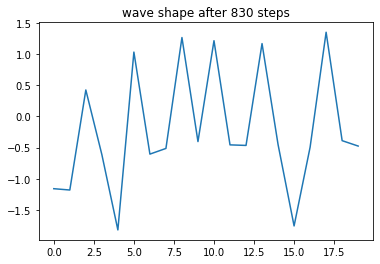

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_830/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_830/model_weights.tf
generator loss:0.9189639793504338
-----------------------
total discriminator loss:0.5897241914900606
average true return:0.5082866884276729
-----------------------


 53%|█████▎    | 831/1562 [1:50:21<2:28:39, 12.20s/it]

Training Step: 831
generator loss:0.8820954017446018
-----------------------
total discriminator loss:0.6230774621095857
average true return:0.5121328173173727
-----------------------


 53%|█████▎    | 832/1562 [1:50:24<1:57:19,  9.64s/it]

Training Step: 832
generator loss:0.8948467949238395
-----------------------
total discriminator loss:0.6160013781285781
average true return:0.49812306781997173
-----------------------


 53%|█████▎    | 833/1562 [1:50:29<1:40:29,  8.27s/it]

Training Step: 833
generator loss:0.9073379384864928
-----------------------
total discriminator loss:0.5960438694560295
average true return:0.4949378839491402
-----------------------


 53%|█████▎    | 834/1562 [1:50:34<1:27:09,  7.18s/it]

Training Step: 834
generator loss:0.8760276222864684
-----------------------
total discriminator loss:0.6433361834804856
average true return:0.5034072682837616
-----------------------


 53%|█████▎    | 835/1562 [1:50:39<1:17:54,  6.43s/it]

Training Step: 835
event_types: [3, 2, 2, 1, 1, 0, 2, 3, 2, 2, 1, 0, 2, 0, 2, 2, 2, 3, 2, 2]
mad_score: 0.6225625
fid_score: 733.6084697347725
rule_score: 0.28275


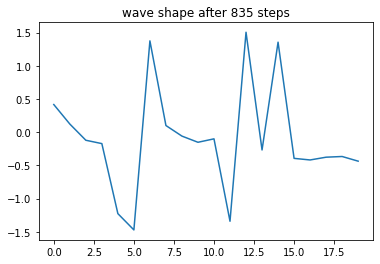

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_835/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_835/model_weights.tf
generator loss:0.8770590565897349
-----------------------
total discriminator loss:0.625645471280661
average true return:0.5097063683565934
-----------------------


 54%|█████▎    | 836/1562 [1:51:04<2:27:52, 12.22s/it]

Training Step: 836
generator loss:0.8884251058520866
-----------------------
total discriminator loss:0.6103494444142028
average true return:0.5085598671913649
-----------------------


 54%|█████▎    | 837/1562 [1:51:09<2:00:47, 10.00s/it]

Training Step: 837
generator loss:0.8519183767224496
-----------------------
total discriminator loss:0.6441711328174526
average true return:0.5185151857453745
-----------------------


 54%|█████▎    | 838/1562 [1:51:14<1:41:25,  8.40s/it]

Training Step: 838
generator loss:0.8493137426614884
-----------------------
total discriminator loss:0.647673429048646
average true return:0.5145912356076052
-----------------------


 54%|█████▎    | 839/1562 [1:51:19<1:27:44,  7.28s/it]

Training Step: 839
generator loss:0.840302680352534
-----------------------
total discriminator loss:0.6613247094260837
average true return:0.5056883313359541
-----------------------


 54%|█████▍    | 840/1562 [1:51:23<1:18:59,  6.56s/it]

Training Step: 840
event_types: [2, 2, 3, 1, 0, 2, 2, 0, 2, 1, 2, 1, 0, 3, 0, 2, 3, 2, 0, 3]
mad_score: 0.6109125
fid_score: 576.0318692299079
rule_score: 0.314


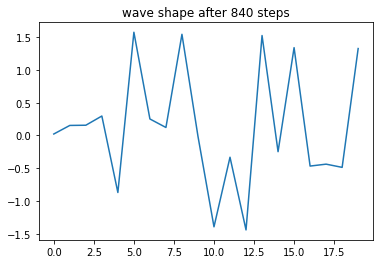

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_840/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_840/model_weights.tf
generator loss:0.7835352257935794
-----------------------
total discriminator loss:0.7986688029528066
average true return:0.5214065202693967
-----------------------


 54%|█████▍    | 841/1562 [1:51:50<2:29:22, 12.43s/it]

Training Step: 841
generator loss:0.7726649464574249
-----------------------
total discriminator loss:0.6444281016705723
average true return:0.5371723948701445
-----------------------


 54%|█████▍    | 842/1562 [1:51:54<2:01:38, 10.14s/it]

Training Step: 842
generator loss:0.7709334444850857
-----------------------
total discriminator loss:0.6338077271291209
average true return:0.5276048283259096
-----------------------


 54%|█████▍    | 843/1562 [1:51:59<1:42:31,  8.56s/it]

Training Step: 843
generator loss:0.7633028096112
-----------------------
total discriminator loss:0.6599925010332532
average true return:0.5324726693228162
-----------------------


 54%|█████▍    | 844/1562 [1:52:04<1:29:09,  7.45s/it]

Training Step: 844
generator loss:0.7571650383535355
-----------------------
total discriminator loss:0.6524285073551666
average true return:0.523201640737506
-----------------------


 54%|█████▍    | 845/1562 [1:52:09<1:18:51,  6.60s/it]

Training Step: 845
event_types: [1, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 0, 2, 0, 2, 2, 0, 2, 3, 2]
mad_score: 0.6012625
fid_score: 495.5892010460229
rule_score: 0.335


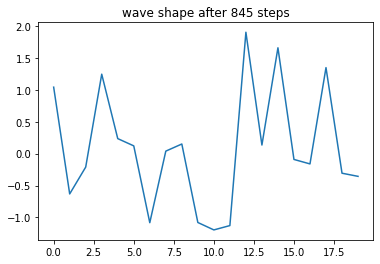

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_845/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_845/model_weights.tf
generator loss:0.7508397276074307
-----------------------
total discriminator loss:0.6549286360778455
average true return:0.5194503316543824
-----------------------


 54%|█████▍    | 846/1562 [1:52:35<2:29:27, 12.52s/it]

Training Step: 846
generator loss:0.7737766801764988
-----------------------
total discriminator loss:0.6581355437944998
average true return:0.5123103814144012
-----------------------


 54%|█████▍    | 847/1562 [1:52:40<2:02:45, 10.30s/it]

Training Step: 847
generator loss:0.7717468566714715
-----------------------
total discriminator loss:0.6452699256541536
average true return:0.5121938987692203
-----------------------


 54%|█████▍    | 848/1562 [1:52:45<1:42:38,  8.62s/it]

Training Step: 848
generator loss:0.7883587641709059
-----------------------
total discriminator loss:0.6711936579611374
average true return:0.5026066081295597
-----------------------


 54%|█████▍    | 849/1562 [1:52:50<1:28:53,  7.48s/it]

Training Step: 849
generator loss:0.8195719803007244
-----------------------
total discriminator loss:0.6551374573252444
average true return:0.4838871573746188
-----------------------


 54%|█████▍    | 850/1562 [1:52:54<1:17:57,  6.57s/it]

Training Step: 850
event_types: [0, 1, 0, 2, 0, 1, 1, 0, 2, 3, 0, 1, 2, 3, 1, 0, 2, 0, 3, 1]
mad_score: 0.5883375
fid_score: 472.32709452643866
rule_score: 0.34975


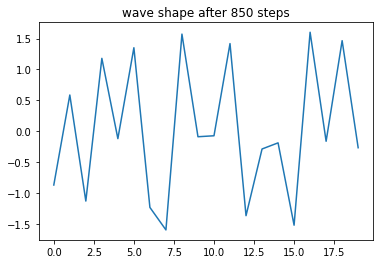

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_850/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_850/model_weights.tf
generator loss:0.8086180305027673
-----------------------
total discriminator loss:0.6530424796772473
average true return:0.4838353813799233
-----------------------


 54%|█████▍    | 851/1562 [1:53:20<2:26:47, 12.39s/it]

Training Step: 851
generator loss:0.838508248104022
-----------------------
total discriminator loss:0.6475622077975354
average true return:0.48254572344632607
-----------------------


 55%|█████▍    | 852/1562 [1:53:25<1:59:35, 10.11s/it]

Training Step: 852
generator loss:0.8430019536417414
-----------------------
total discriminator loss:0.6581939676980234
average true return:0.4677685436209212
-----------------------


 55%|█████▍    | 853/1562 [1:53:30<1:40:21,  8.49s/it]

Training Step: 853
generator loss:0.8656588225572458
-----------------------
total discriminator loss:0.6421114015769229
average true return:0.46989355399462834
-----------------------


 55%|█████▍    | 854/1562 [1:53:34<1:27:29,  7.41s/it]

Training Step: 854
generator loss:0.8621738314691756
-----------------------
total discriminator loss:0.6505388178132809
average true return:0.4603523373131401
-----------------------


 55%|█████▍    | 855/1562 [1:53:40<1:19:02,  6.71s/it]

Training Step: 855
event_types: [1, 2, 0, 3, 2, 0, 2, 2, 2, 3, 1, 0, 3, 2, 2, 3, 1, 0, 3, 2]
mad_score: 0.5759375
fid_score: 524.8588346638749
rule_score: 0.37175


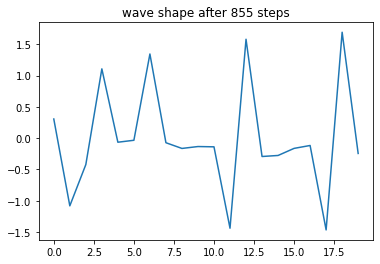

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_855/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_855/model_weights.tf
generator loss:0.8656051751843395
-----------------------
total discriminator loss:0.6401258350211454
average true return:0.4637009412942631
-----------------------


 55%|█████▍    | 856/1562 [1:54:05<2:25:53, 12.40s/it]

Training Step: 856
generator loss:0.9064511144683172
-----------------------
total discriminator loss:0.633778846466372
average true return:0.465323867643031
-----------------------


 55%|█████▍    | 857/1562 [1:54:10<1:58:12, 10.06s/it]

Training Step: 857
generator loss:0.9231117039786512
-----------------------
total discriminator loss:0.6239854931254935
average true return:0.4527838968496556
-----------------------


 55%|█████▍    | 858/1562 [1:54:13<1:34:13,  8.03s/it]

Training Step: 858
generator loss:0.9577309527061854
-----------------------
total discriminator loss:0.6221418648103036
average true return:0.4503006134173283
-----------------------


 55%|█████▍    | 859/1562 [1:54:18<1:22:43,  7.06s/it]

Training Step: 859
generator loss:0.961585701676016
-----------------------
total discriminator loss:0.6132503827767436
average true return:0.448263696141043
-----------------------


 55%|█████▌    | 860/1562 [1:54:23<1:14:19,  6.35s/it]

Training Step: 860
event_types: [0, 2, 1, 0, 2, 2, 2, 3, 1, 0, 1, 0, 3, 3, 2, 0, 3, 2, 2, 1]
mad_score: 0.5707625
fid_score: 583.6898222564691
rule_score: 0.373


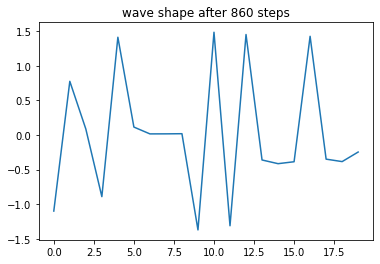

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_860/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_860/model_weights.tf
generator loss:0.9967104886810263
-----------------------
total discriminator loss:0.6002395913864708
average true return:0.436216096794058
-----------------------


 55%|█████▌    | 861/1562 [1:54:50<2:26:32, 12.54s/it]

Training Step: 861
generator loss:1.0457218760575793
-----------------------
total discriminator loss:0.595239808202841
average true return:0.4433520801937417
-----------------------


 55%|█████▌    | 862/1562 [1:54:55<1:59:41, 10.26s/it]

Training Step: 862
generator loss:1.0915986956325643
-----------------------
total discriminator loss:0.5852740268481441
average true return:0.4380073424281111
-----------------------


 55%|█████▌    | 863/1562 [1:54:59<1:40:03,  8.59s/it]

Training Step: 863
generator loss:1.1026770572833775
-----------------------
total discriminator loss:0.5919338428422307
average true return:0.42273203632892487
-----------------------


 55%|█████▌    | 864/1562 [1:55:04<1:25:45,  7.37s/it]

Training Step: 864
generator loss:1.1498858476700007
-----------------------
total discriminator loss:0.5763185606356127
average true return:0.4281716852754905
-----------------------


 55%|█████▌    | 865/1562 [1:55:08<1:16:17,  6.57s/it]

Training Step: 865
event_types: [2, 2, 1, 2, 1, 0, 3, 2, 3, 1, 2, 0, 2, 2, 1, 0, 3, 0, 3, 2]
mad_score: 0.5691125
fid_score: 644.1401921528266
rule_score: 0.3715


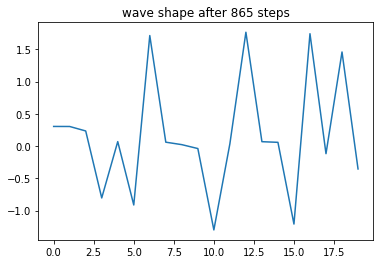

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_865/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_865/model_weights.tf
generator loss:1.1473306140863144
-----------------------
total discriminator loss:0.5651811795631834
average true return:0.4366563901081464
-----------------------


 55%|█████▌    | 866/1562 [1:55:34<2:23:25, 12.36s/it]

Training Step: 866
generator loss:1.1256192044383226
-----------------------
total discriminator loss:0.553466105501736
average true return:0.4278011275249047
-----------------------


 56%|█████▌    | 867/1562 [1:55:39<1:56:42, 10.08s/it]

Training Step: 867
generator loss:1.1508580862780444
-----------------------
total discriminator loss:0.5417383067956587
average true return:0.440713881222216
-----------------------


 56%|█████▌    | 868/1562 [1:55:44<1:38:05,  8.48s/it]

Training Step: 868
generator loss:1.1243037416317216
-----------------------
total discriminator loss:0.5422185558410455
average true return:0.44855896318490185
-----------------------


 56%|█████▌    | 869/1562 [1:55:49<1:26:21,  7.48s/it]

Training Step: 869
generator loss:1.1670993088795139
-----------------------
total discriminator loss:0.5557616397145986
average true return:0.4682331939208757
-----------------------


 56%|█████▌    | 870/1562 [1:55:54<1:16:36,  6.64s/it]

Training Step: 870
event_types: [2, 1, 0, 3, 0, 2, 2, 2, 2, 1, 0, 2, 0, 3, 2, 2, 2, 3, 0, 3]
mad_score: 0.5730375
fid_score: 684.1278834159848
rule_score: 0.35075


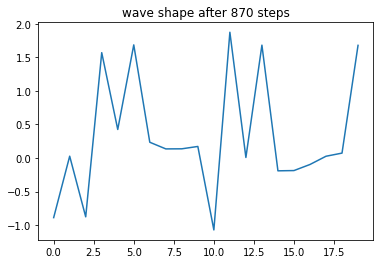

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_870/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_870/model_weights.tf
generator loss:1.0743036264599062
-----------------------
total discriminator loss:0.5405060053778334
average true return:0.4736395183689033
-----------------------


 56%|█████▌    | 871/1562 [1:56:19<2:22:40, 12.39s/it]

Training Step: 871
generator loss:1.0532529034122788
-----------------------
total discriminator loss:0.9814646687482123
average true return:0.5013140267206202
-----------------------


 56%|█████▌    | 872/1562 [1:56:24<1:56:06, 10.10s/it]

Training Step: 872
generator loss:1.001246910565862
-----------------------
total discriminator loss:0.5329712064820742
average true return:0.5064305010414072
-----------------------


 56%|█████▌    | 873/1562 [1:56:29<1:37:37,  8.50s/it]

Training Step: 873
generator loss:0.969957770503057
-----------------------
total discriminator loss:0.5183328608655147
average true return:0.529345751253133
-----------------------


 56%|█████▌    | 874/1562 [1:56:34<1:24:38,  7.38s/it]

Training Step: 874
generator loss:0.9680359459046528
-----------------------
total discriminator loss:0.5439597912330056
average true return:0.5503266347401359
-----------------------


 56%|█████▌    | 875/1562 [1:56:38<1:15:22,  6.58s/it]

Training Step: 875
event_types: [2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 0, 3, 2, 1, 0, 3, 0]
mad_score: 0.58085
fid_score: 664.5528572158387
rule_score: 0.3255


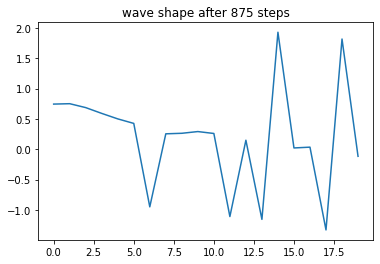

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_875/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_875/model_weights.tf
generator loss:0.9737746390540288
-----------------------
total discriminator loss:0.51774020221222
average true return:0.52665317640302
-----------------------


 56%|█████▌    | 876/1562 [1:57:05<2:25:07, 12.69s/it]

Training Step: 876
generator loss:0.9679065609522399
-----------------------
total discriminator loss:0.5506886735694467
average true return:0.5283983876625665
-----------------------


 56%|█████▌    | 877/1562 [1:57:10<1:57:29, 10.29s/it]

Training Step: 877
generator loss:1.0086292376176091
-----------------------
total discriminator loss:0.5376033597228548
average true return:0.509741676449257
-----------------------


 56%|█████▌    | 878/1562 [1:57:15<1:37:41,  8.57s/it]

Training Step: 878
generator loss:1.0461149933897695
-----------------------
total discriminator loss:0.5406436888595882
average true return:0.5037860425704885
-----------------------


 56%|█████▋    | 879/1562 [1:57:19<1:24:21,  7.41s/it]

Training Step: 879
generator loss:1.1248745127648438
-----------------------
total discriminator loss:0.5376656451654362
average true return:0.48919637059879395
-----------------------


 56%|█████▋    | 880/1562 [1:57:24<1:15:56,  6.68s/it]

Training Step: 880
event_types: [2, 1, 0, 2, 2, 3, 1, 1, 0, 1, 2, 0, 2, 2, 1, 0, 2, 1, 0, 1]
mad_score: 0.593025
fid_score: 695.1947924052392
rule_score: 0.291


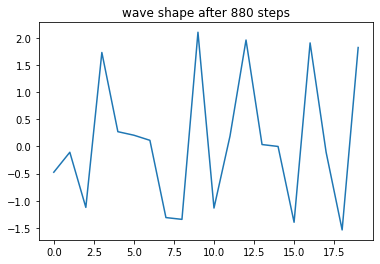

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_880/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_880/model_weights.tf
generator loss:1.1639119818318924
-----------------------
total discriminator loss:0.5251493528734069
average true return:0.48741639160709715
-----------------------


 56%|█████▋    | 881/1562 [1:57:51<2:22:47, 12.58s/it]

Training Step: 881
generator loss:1.1418231573383677
-----------------------
total discriminator loss:0.5362792891259577
average true return:0.47255776185616927
-----------------------


 56%|█████▋    | 882/1562 [1:57:55<1:55:31, 10.19s/it]

Training Step: 882
generator loss:1.1813225849223077
-----------------------
total discriminator loss:0.5360551811706766
average true return:0.48658414672553557
-----------------------


 57%|█████▋    | 883/1562 [1:58:00<1:36:15,  8.51s/it]

Training Step: 883
generator loss:1.1556443602655324
-----------------------
total discriminator loss:0.5358731620439645
average true return:0.5205382778803862
-----------------------


 57%|█████▋    | 884/1562 [1:58:04<1:21:23,  7.20s/it]

Training Step: 884
generator loss:1.1005518779591354
-----------------------
total discriminator loss:0.5084838948976238
average true return:0.5096730466108762
-----------------------


 57%|█████▋    | 885/1562 [1:58:06<1:04:48,  5.74s/it]

Training Step: 885
event_types: [3, 2, 1, 1, 0, 2, 1, 2, 2, 2, 1, 0, 3, 2, 2, 2, 1, 0, 3, 2]
mad_score: 0.60975
fid_score: 756.7147638516027
rule_score: 0.261


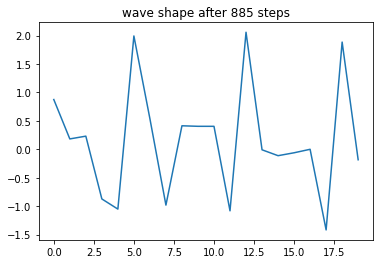

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_885/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_885/model_weights.tf
generator loss:1.0817551608308444
-----------------------
total discriminator loss:0.5389354228470032
average true return:0.5234874741311852
-----------------------


 57%|█████▋    | 886/1562 [1:58:19<1:28:37,  7.87s/it]

Training Step: 886
generator loss:1.0757850720797077
-----------------------
total discriminator loss:0.9793307796507413
average true return:0.5345021577532811
-----------------------


 57%|█████▋    | 887/1562 [1:58:22<1:09:54,  6.21s/it]

Training Step: 887
generator loss:1.0651469853235334
-----------------------
total discriminator loss:0.5242942213439626
average true return:0.532724565948905
-----------------------


 57%|█████▋    | 888/1562 [1:58:24<56:49,  5.06s/it]  

Training Step: 888
generator loss:1.029637431563493
-----------------------
total discriminator loss:0.5402220659968945
average true return:0.5284324355436678
-----------------------


 57%|█████▋    | 889/1562 [1:58:26<47:33,  4.24s/it]

Training Step: 889
generator loss:1.0858874247399326
-----------------------
total discriminator loss:0.5205945583857676
average true return:0.5102442853887208
-----------------------


 57%|█████▋    | 890/1562 [1:58:29<41:13,  3.68s/it]

Training Step: 890
event_types: [0, 3, 2, 1, 2, 0, 3, 2, 1, 2, 3, 2, 1, 0, 3, 1, 0, 2, 2, 1]
mad_score: 0.6283125
fid_score: 835.0385509752487
rule_score: 0.23125


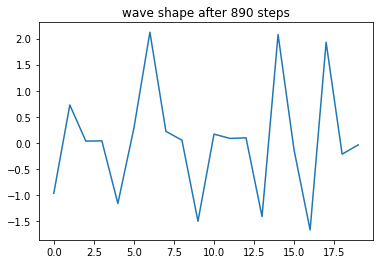

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_890/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_890/model_weights.tf
generator loss:1.1226402349032814
-----------------------


 57%|█████▋    | 891/1562 [1:58:42<1:14:54,  6.70s/it]

total discriminator loss:0.5379289536490575
average true return:0.5092797000341978
-----------------------
Training Step: 891
generator loss:1.134572698879275
-----------------------
total discriminator loss:0.5511280546809245
average true return:0.5035718142714176
-----------------------


 57%|█████▋    | 892/1562 [1:58:45<1:00:09,  5.39s/it]

Training Step: 892
generator loss:1.1561417851550408
-----------------------


 57%|█████▋    | 893/1562 [1:58:47<49:03,  4.40s/it]  

total discriminator loss:0.5625024719703094
average true return:0.4835694603610834
-----------------------
Training Step: 893
generator loss:1.124633563575007
-----------------------
total discriminator loss:0.5466350327849562
average true return:0.48809609530467923
-----------------------


 57%|█████▋    | 894/1562 [1:58:49<41:29,  3.73s/it]

Training Step: 894
generator loss:1.1936696755475587
-----------------------
total discriminator loss:0.5685623672804956
average true return:0.48792210705174566
-----------------------


 57%|█████▋    | 895/1562 [1:58:51<36:45,  3.31s/it]

Training Step: 895
event_types: [3, 1, 0, 2, 2, 2, 2, 1, 1, 0, 2, 0, 2, 1, 0, 2, 2, 2, 1, 0]
mad_score: 0.6425375
fid_score: 1023.0544021691043
rule_score: 0.2095


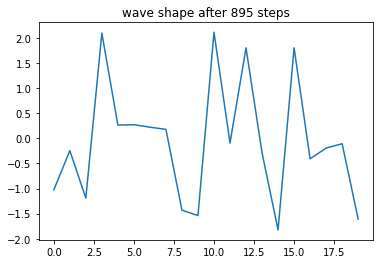

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_895/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_895/model_weights.tf
generator loss:1.1691239064933872
-----------------------
total discriminator loss:0.5352415078097991
average true return:0.48428531176439116
-----------------------


 57%|█████▋    | 896/1562 [1:59:05<1:12:40,  6.55s/it]

Training Step: 896
generator loss:1.1435358424604165
-----------------------
total discriminator loss:0.5335587993035984
average true return:0.4975999459423182
-----------------------


 57%|█████▋    | 897/1562 [1:59:08<58:44,  5.30s/it]  

Training Step: 897
generator loss:1.1451617742835114
-----------------------
total discriminator loss:0.5365145366052613
average true return:0.49690790246250793
-----------------------


 57%|█████▋    | 898/1562 [1:59:10<48:50,  4.41s/it]

Training Step: 898
generator loss:1.1802598753578875
-----------------------
total discriminator loss:0.5456205488977479
average true return:0.49995057994916203
-----------------------


 58%|█████▊    | 899/1562 [1:59:12<41:51,  3.79s/it]

Training Step: 899
generator loss:1.0819077165371835
-----------------------
total discriminator loss:0.5380979683513314
average true return:0.48777103436882097
-----------------------


 58%|█████▊    | 900/1562 [1:59:15<36:58,  3.35s/it]

Training Step: 900
event_types: [2, 0, 1, 0, 2, 2, 2, 1, 2, 2, 3, 0, 2, 0, 2, 3, 1, 2, 2, 1]
mad_score: 0.66055
fid_score: 1386.4164551293793
rule_score: 0.1705


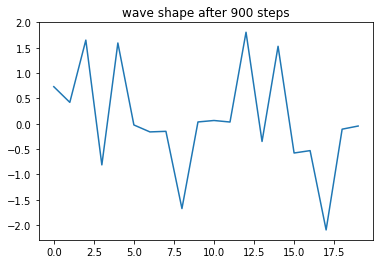

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_900/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_900/model_weights.tf
generator loss:1.1541148899360096
-----------------------
total discriminator loss:0.5342427587974035
average true return:0.4905825241472618
-----------------------


 58%|█████▊    | 901/1562 [1:59:28<1:09:02,  6.27s/it]

Training Step: 901
generator loss:1.165299290496829
-----------------------
total discriminator loss:0.5193042780123016
average true return:0.49517884387156286
-----------------------


 58%|█████▊    | 902/1562 [1:59:30<56:02,  5.09s/it]  

Training Step: 902
generator loss:1.132540082280495
-----------------------
total discriminator loss:0.5204684898182339
average true return:0.4900568705566689
-----------------------


 58%|█████▊    | 903/1562 [1:59:33<47:02,  4.28s/it]

Training Step: 903
generator loss:1.1313477536601058
-----------------------
total discriminator loss:0.5268897134159947
average true return:0.5056567972042914
-----------------------


 58%|█████▊    | 904/1562 [1:59:35<40:32,  3.70s/it]

Training Step: 904
generator loss:1.1627120109144826
-----------------------
total discriminator loss:0.5168711359409401
average true return:0.4813417264970766
-----------------------


 58%|█████▊    | 905/1562 [1:59:38<36:57,  3.37s/it]

Training Step: 905
event_types: [2, 0, 3, 2, 2, 3, 2, 2, 2, 2, 1, 1, 0, 3, 2, 2, 2, 3, 1, 0]
mad_score: 0.6726125
fid_score: 1798.328039360448
rule_score: 0.13975


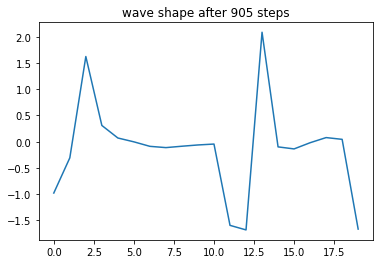

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_905/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_905/model_weights.tf
generator loss:1.0850263503058848
-----------------------


 58%|█████▊    | 906/1562 [1:59:51<1:10:07,  6.41s/it]

total discriminator loss:0.5210560497739728
average true return:0.513699494046494
-----------------------
Training Step: 906
generator loss:1.095808412781223
-----------------------


 58%|█████▊    | 907/1562 [1:59:53<55:26,  5.08s/it]  

total discriminator loss:0.5147744774871693
average true return:0.5208221283329639
-----------------------
Training Step: 907
generator loss:1.0625526054674252
-----------------------
total discriminator loss:0.5196896349719151
average true return:0.5133655360738784
-----------------------


 58%|█████▊    | 908/1562 [1:59:55<46:17,  4.25s/it]

Training Step: 908
generator loss:1.1197716442011219
-----------------------
total discriminator loss:0.5065111676301108
average true return:0.5148737940448742
-----------------------


 58%|█████▊    | 909/1562 [1:59:58<40:02,  3.68s/it]

Training Step: 909
generator loss:1.2084842058269714
-----------------------
total discriminator loss:0.5374967868974577
average true return:0.5118756999162386
-----------------------


 58%|█████▊    | 910/1562 [2:00:00<35:43,  3.29s/it]

Training Step: 910
event_types: [0, 2, 2, 1, 1, 0, 2, 1, 1, 0, 3, 1, 0, 1, 1, 0, 3, 1, 0, 2]
mad_score: 0.681525
fid_score: 2267.108169611616
rule_score: 0.12525


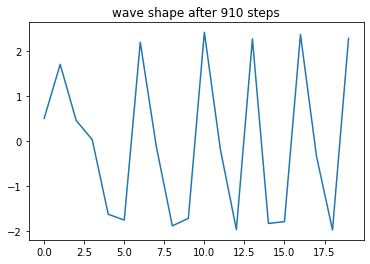

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_910/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_910/model_weights.tf
generator loss:1.1175171518351825
-----------------------
total discriminator loss:0.516393017705344
average true return:0.4971485110306987
-----------------------


 58%|█████▊    | 911/1562 [2:00:14<1:09:40,  6.42s/it]

Training Step: 911
generator loss:1.2247433927282463
-----------------------
total discriminator loss:0.4958591624522197
average true return:0.499585697177212
-----------------------


 58%|█████▊    | 912/1562 [2:00:16<56:13,  5.19s/it]  

Training Step: 912
generator loss:1.2045438710288803
-----------------------
total discriminator loss:0.4954576225272579
average true return:0.4976075465730865
-----------------------


 58%|█████▊    | 913/1562 [2:00:18<46:48,  4.33s/it]

Training Step: 913
generator loss:1.2124977030465298
-----------------------
total discriminator loss:0.4817643809324253
average true return:0.5060351408704912
-----------------------


 59%|█████▊    | 914/1562 [2:00:21<40:21,  3.74s/it]

Training Step: 914
generator loss:1.2136176039420428
-----------------------


 59%|█████▊    | 915/1562 [2:00:23<35:23,  3.28s/it]

total discriminator loss:0.4980992403436628
average true return:0.5075280182614872
-----------------------
Training Step: 915
event_types: [2, 3, 3, 0, 3, 3, 2, 0, 1, 1, 0, 3, 1, 0, 2, 1, 0, 2, 0, 3]
mad_score: 0.6850125
fid_score: 2769.437873734176
rule_score: 0.12


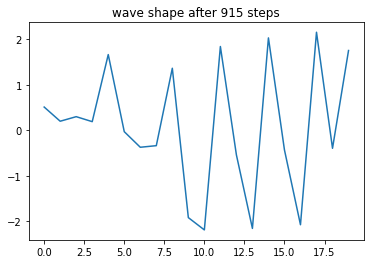

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_915/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_915/model_weights.tf
generator loss:1.1515489304890543
-----------------------
total discriminator loss:0.50791336210956
average true return:0.5380276695414983
-----------------------


 59%|█████▊    | 916/1562 [2:00:36<1:07:22,  6.26s/it]

Training Step: 916
generator loss:1.2141986688800555
-----------------------
total discriminator loss:0.49304381087909954
average true return:0.5117369000989636
-----------------------


 59%|█████▊    | 917/1562 [2:00:39<54:41,  5.09s/it]  

Training Step: 917
generator loss:1.171347487437322
-----------------------
total discriminator loss:0.4854907331443423
average true return:0.5266670788349359
-----------------------


 59%|█████▉    | 918/1562 [2:00:41<45:49,  4.27s/it]

Training Step: 918
generator loss:1.1897967112479715
-----------------------
total discriminator loss:0.4977697463369321
average true return:0.5405427826311816
-----------------------


 59%|█████▉    | 919/1562 [2:00:43<39:56,  3.73s/it]

Training Step: 919
generator loss:1.2088112495954797
-----------------------
total discriminator loss:0.4878894123495106
average true return:0.523032235472914
-----------------------


 59%|█████▉    | 920/1562 [2:00:46<35:28,  3.32s/it]

Training Step: 920
event_types: [1, 0, 2, 3, 2, 2, 2, 0, 2, 2, 1, 1, 0, 2, 3, 1, 0, 3, 0, 3]
mad_score: 0.693675
fid_score: 3321.2248585007933
rule_score: 0.1115


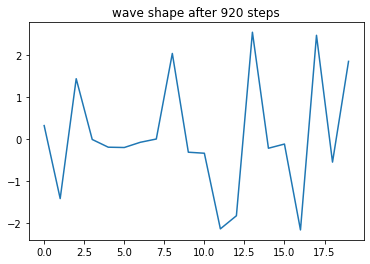

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_920/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_920/model_weights.tf
generator loss:1.2842972854007624
-----------------------
total discriminator loss:0.4789762574541868
average true return:0.5106437039802143
-----------------------


 59%|█████▉    | 921/1562 [2:00:59<1:05:42,  6.15s/it]

Training Step: 921
generator loss:1.261776984900472
-----------------------
total discriminator loss:0.4834852568841601
average true return:0.4948984530230738
-----------------------


 59%|█████▉    | 922/1562 [2:01:01<53:31,  5.02s/it]  

Training Step: 922
generator loss:1.31582131841257
-----------------------
total discriminator loss:0.47611960215887605
average true return:0.48547880881193056
-----------------------


 59%|█████▉    | 923/1562 [2:01:03<44:49,  4.21s/it]

Training Step: 923
generator loss:1.2575462205181176
-----------------------
total discriminator loss:0.4986451907999131
average true return:0.5358024109154513
-----------------------


 59%|█████▉    | 924/1562 [2:01:06<38:47,  3.65s/it]

Training Step: 924
generator loss:1.2710468205968284
-----------------------
total discriminator loss:0.47293747023524735
average true return:0.5296133106907421
-----------------------


 59%|█████▉    | 925/1562 [2:01:08<34:39,  3.27s/it]

Training Step: 925
event_types: [0, 2, 2, 3, 2, 1, 3, 2, 3, 3, 3, 0, 2, 1, 0, 3, 3, 2, 3, 1]
mad_score: 0.6914375
fid_score: 3709.9749675727626
rule_score: 0.111


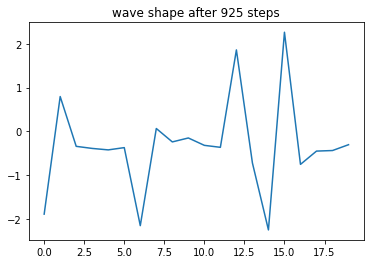

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_925/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_925/model_weights.tf
generator loss:1.2721793214691886
-----------------------
total discriminator loss:0.46058288526915664
average true return:0.5251619814213229
-----------------------


 59%|█████▉    | 926/1562 [2:01:22<1:08:54,  6.50s/it]

Training Step: 926
generator loss:1.2787800433500243
-----------------------
total discriminator loss:0.46048238625179216
average true return:0.5108092733930463
-----------------------


 59%|█████▉    | 927/1562 [2:01:24<55:34,  5.25s/it]  

Training Step: 927
generator loss:1.2947406871290588
-----------------------


 59%|█████▉    | 928/1562 [2:01:27<46:01,  4.36s/it]

total discriminator loss:0.476812968072985
average true return:0.4973142616600679
-----------------------
Training Step: 928
generator loss:1.4252232574804828
-----------------------


 59%|█████▉    | 929/1562 [2:01:29<38:24,  3.64s/it]

total discriminator loss:0.43653514640788244
average true return:0.5155908827049814
-----------------------
Training Step: 929
generator loss:1.4397102152099217
-----------------------
total discriminator loss:0.4345537827098225
average true return:0.4888738893661102
-----------------------


 60%|█████▉    | 930/1562 [2:01:31<33:53,  3.22s/it]

Training Step: 930
event_types: [2, 0, 3, 0, 1, 0, 3, 2, 1, 0, 3, 1, 0, 3, 2, 3, 2, 1, 0, 3]
mad_score: 0.69205
fid_score: 4038.2411853872154
rule_score: 0.1045


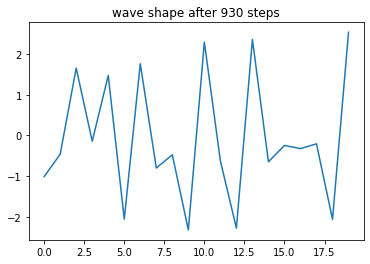

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_930/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_930/model_weights.tf
generator loss:1.3976760960616648
-----------------------
total discriminator loss:0.45383930870253886
average true return:0.5165546592223565
-----------------------


 60%|█████▉    | 931/1562 [2:01:45<1:07:37,  6.43s/it]

Training Step: 931
generator loss:1.4341052167777457
-----------------------
total discriminator loss:0.446258112395521
average true return:0.4981100120731008
-----------------------


 60%|█████▉    | 932/1562 [2:01:47<54:41,  5.21s/it]  

Training Step: 932
generator loss:1.4305013005596048
-----------------------
total discriminator loss:0.43649312019816466
average true return:0.4960101886208355
-----------------------


 60%|█████▉    | 933/1562 [2:01:49<45:42,  4.36s/it]

Training Step: 933
generator loss:1.4607860755613535
-----------------------
total discriminator loss:0.4328573446686858
average true return:0.506683709329436
-----------------------


 60%|█████▉    | 934/1562 [2:01:52<39:24,  3.77s/it]

Training Step: 934
generator loss:1.5533044179258995
-----------------------
total discriminator loss:0.4244952908514531
average true return:0.5211679976471946
-----------------------


 60%|█████▉    | 935/1562 [2:01:54<34:54,  3.34s/it]

Training Step: 935
event_types: [1, 0, 2, 2, 2, 2, 2, 1, 0, 3, 1, 0, 3, 0, 3, 2, 2, 2, 0, 3]
mad_score: 0.6911125
fid_score: 4083.37745377548
rule_score: 0.10875


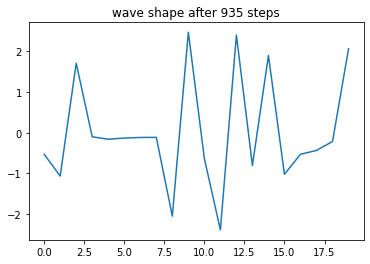

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_935/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_935/model_weights.tf
generator loss:1.527901390739392
-----------------------
total discriminator loss:0.4305946945575718
average true return:0.47362585339179925
-----------------------


 60%|█████▉    | 936/1562 [2:02:07<1:05:09,  6.24s/it]

Training Step: 936
generator loss:1.5856937728753566
-----------------------
total discriminator loss:0.39478223745582564
average true return:0.48321294099503254
-----------------------


 60%|█████▉    | 937/1562 [2:02:10<52:58,  5.09s/it]  

Training Step: 937
generator loss:1.542118002040962
-----------------------
total discriminator loss:0.4095503957824986
average true return:0.5044111813035891
-----------------------


 60%|██████    | 938/1562 [2:02:12<44:21,  4.26s/it]

Training Step: 938
generator loss:1.4789711217518478
-----------------------
total discriminator loss:0.40554378052106205
average true return:0.5292518026099612
-----------------------


 60%|██████    | 939/1562 [2:02:14<38:31,  3.71s/it]

Training Step: 939
generator loss:1.4667982439027643
-----------------------


 60%|██████    | 940/1562 [2:02:17<34:19,  3.31s/it]

total discriminator loss:0.3928747566399577
average true return:0.5184699617875562
-----------------------
Training Step: 940
event_types: [3, 1, 2, 0, 2, 2, 1, 0, 3, 2, 0, 3, 3, 2, 3, 1, 0, 3, 1, 0]
mad_score: 0.686825
fid_score: 3903.2402634901728
rule_score: 0.10725


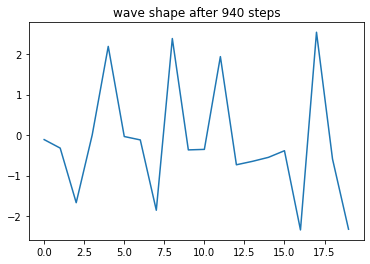

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_940/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_940/model_weights.tf
generator loss:1.543329408693109
-----------------------
total discriminator loss:0.39500901233668795
average true return:0.5058231088968463
-----------------------


 60%|██████    | 941/1562 [2:02:30<1:06:35,  6.43s/it]

Training Step: 941
generator loss:1.6806233444100427
-----------------------


 60%|██████    | 942/1562 [2:02:33<52:58,  5.13s/it]  

total discriminator loss:0.38218196795824244
average true return:0.48986601674966357
-----------------------
Training Step: 942
generator loss:1.7425368692665808
-----------------------
total discriminator loss:0.37641404047566174
average true return:0.4758146922421383
-----------------------


 60%|██████    | 943/1562 [2:02:35<43:30,  4.22s/it]

Training Step: 943
generator loss:1.588545702758682
-----------------------
total discriminator loss:0.38920756850569527
average true return:0.5256589717269565
-----------------------


 60%|██████    | 944/1562 [2:02:37<37:54,  3.68s/it]

Training Step: 944
generator loss:1.5607831624524056
-----------------------
total discriminator loss:0.3812928185299055
average true return:0.5392317187675648
-----------------------


 60%|██████    | 945/1562 [2:02:39<33:42,  3.28s/it]

Training Step: 945
event_types: [2, 0, 3, 2, 1, 2, 1, 0, 2, 2, 3, 1, 0, 3, 2, 1, 0, 3, 1, 0]
mad_score: 0.678625
fid_score: 3395.554478695446
rule_score: 0.1065


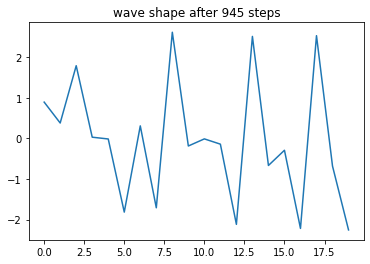

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_945/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_945/model_weights.tf
generator loss:1.6349186037201697
-----------------------
total discriminator loss:0.37674712737090993
average true return:0.5019224938178779
-----------------------


 61%|██████    | 946/1562 [2:02:53<1:05:37,  6.39s/it]

Training Step: 946
generator loss:1.7781372789924303
-----------------------
total discriminator loss:0.36103814684463353
average true return:0.4736495765857608
-----------------------


 61%|██████    | 947/1562 [2:02:55<53:05,  5.18s/it]  

Training Step: 947
generator loss:1.8487792083080445
-----------------------
total discriminator loss:0.39545251153205424
average true return:0.48091785399530707
-----------------------


 61%|██████    | 948/1562 [2:02:58<44:16,  4.33s/it]

Training Step: 948
generator loss:1.7696478586150768
-----------------------
total discriminator loss:0.3716829503158683
average true return:0.4958357704883287
-----------------------


 61%|██████    | 949/1562 [2:03:00<38:03,  3.73s/it]

Training Step: 949
generator loss:1.7072703861706824
-----------------------
total discriminator loss:0.38156469858185615
average true return:0.5193640011418121
-----------------------


 61%|██████    | 950/1562 [2:03:02<33:47,  3.31s/it]

Training Step: 950
event_types: [0, 0, 2, 2, 1, 2, 0, 3, 2, 1, 0, 3, 1, 1, 0, 3, 2, 2, 1, 0]
mad_score: 0.67115
fid_score: 2597.5562814698123
rule_score: 0.12375


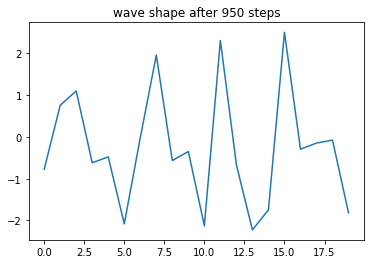

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_950/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_950/model_weights.tf
generator loss:1.7466051310765427
-----------------------
total discriminator loss:0.35206954876726704
average true return:0.507387641012782
-----------------------


 61%|██████    | 951/1562 [2:03:15<1:03:14,  6.21s/it]

Training Step: 951
generator loss:1.8829795875805844
-----------------------
total discriminator loss:0.37662895803831276
average true return:0.49624898888467195
-----------------------


 61%|██████    | 952/1562 [2:03:18<51:27,  5.06s/it]  

Training Step: 952
generator loss:1.9284185118838517
-----------------------
total discriminator loss:0.3822883919946102
average true return:0.4595838734243313
-----------------------


 61%|██████    | 953/1562 [2:03:20<43:08,  4.25s/it]

Training Step: 953
generator loss:1.8971090084437932
-----------------------
total discriminator loss:0.39154757652889327
average true return:0.508523852392675
-----------------------


 61%|██████    | 954/1562 [2:03:22<37:19,  3.68s/it]

Training Step: 954
generator loss:1.9189232852663833
-----------------------
total discriminator loss:0.3675118573817155
average true return:0.5055513134664273
-----------------------


 61%|██████    | 955/1562 [2:03:25<33:14,  3.29s/it]

Training Step: 955
event_types: [1, 2, 1, 3, 2, 1, 2, 2, 2, 3, 1, 0, 3, 3, 3, 0, 2, 1, 0, 2]
mad_score: 0.6637375
fid_score: 1915.2365863207774
rule_score: 0.141


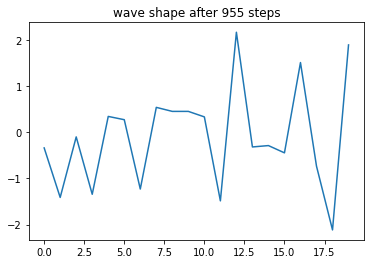

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_955/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_955/model_weights.tf
generator loss:2.0285196572407473
-----------------------
total discriminator loss:0.3900864590599973
average true return:0.47155108985166694
-----------------------


 61%|██████    | 956/1562 [2:03:39<1:05:03,  6.44s/it]

Training Step: 956
generator loss:1.8785005773609293
-----------------------
total discriminator loss:0.38853430501537417
average true return:0.5357724867293925
-----------------------


 61%|██████▏   | 957/1562 [2:03:41<52:29,  5.21s/it]  

Training Step: 957
generator loss:2.054853125187879
-----------------------
total discriminator loss:0.3510036926913093
average true return:0.47543656268330536
-----------------------


 61%|██████▏   | 958/1562 [2:03:43<43:50,  4.36s/it]

Training Step: 958
generator loss:2.088198067086875
-----------------------
total discriminator loss:0.35531481633997763
average true return:0.46196278759068343
-----------------------


 61%|██████▏   | 959/1562 [2:03:46<37:42,  3.75s/it]

Training Step: 959
generator loss:1.8964011995535686
-----------------------
total discriminator loss:1.7419240913864642
average true return:0.5109811712122518
-----------------------


 61%|██████▏   | 960/1562 [2:03:48<33:30,  3.34s/it]

Training Step: 960
event_types: [1, 0, 2, 2, 0, 2, 2, 3, 2, 3, 1, 1, 0, 3, 2, 1, 0, 3, 2, 1]
mad_score: 0.663875
fid_score: 1288.3050631626872
rule_score: 0.13325


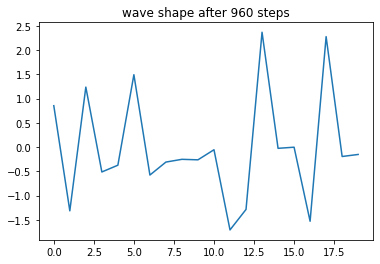

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_960/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_960/model_weights.tf
generator loss:1.1367233126235865
-----------------------
total discriminator loss:0.462216466740222
average true return:0.6245522980618965
-----------------------


 62%|██████▏   | 961/1562 [2:04:02<1:04:50,  6.47s/it]

Training Step: 961
generator loss:1.4229607199620031
-----------------------
total discriminator loss:0.451516381680307
average true return:0.5989737474416272
-----------------------


 62%|██████▏   | 962/1562 [2:04:04<52:19,  5.23s/it]  

Training Step: 962
generator loss:1.9366325359563588
-----------------------
total discriminator loss:0.37943312334941
average true return:0.46482397029634553
-----------------------


 62%|██████▏   | 963/1562 [2:04:06<43:30,  4.36s/it]

Training Step: 963
generator loss:2.295486987329848
-----------------------


 62%|██████▏   | 964/1562 [2:04:09<36:44,  3.69s/it]

total discriminator loss:0.5188880164111562
average true return:0.3460967821103526
-----------------------
Training Step: 964
generator loss:2.007822500506735
-----------------------
total discriminator loss:0.41277921800595563
average true return:0.45654938303914566
-----------------------


 62%|██████▏   | 965/1562 [2:04:11<31:35,  3.18s/it]

Training Step: 965
event_types: [2, 2, 3, 2, 1, 0, 2, 2, 3, 3, 2, 3, 1, 0, 2, 3, 2, 3, 1, 1]
mad_score: 0.651625
fid_score: 784.1418412535388
rule_score: 0.14925


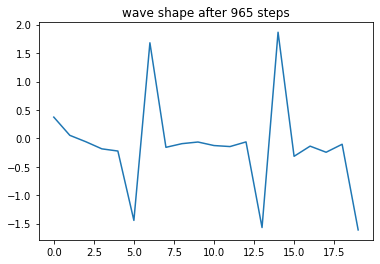

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_965/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_965/model_weights.tf
generator loss:1.3811721809956918
-----------------------
total discriminator loss:0.428730498162635
average true return:0.5772080086671492
-----------------------


 62%|██████▏   | 966/1562 [2:04:24<1:02:51,  6.33s/it]

Training Step: 966
generator loss:1.1360821607328315
-----------------------
total discriminator loss:0.4857425194358382
average true return:0.6254677014527246
-----------------------


 62%|██████▏   | 967/1562 [2:04:27<50:55,  5.14s/it]  

Training Step: 967
generator loss:1.2951412974840084
-----------------------


 62%|██████▏   | 968/1562 [2:04:29<42:33,  4.30s/it]

total discriminator loss:1.4628578076268894
average true return:0.5870200402199552
-----------------------
Training Step: 968
generator loss:1.1730874274479486
-----------------------
total discriminator loss:0.4317186378466056
average true return:0.5799649130802209
-----------------------


 62%|██████▏   | 969/1562 [2:04:31<37:10,  3.76s/it]

Training Step: 969
generator loss:1.3407281999481304
-----------------------
total discriminator loss:0.44423667529749805
average true return:0.5564424406936787
-----------------------


 62%|██████▏   | 970/1562 [2:04:34<32:50,  3.33s/it]

Training Step: 970
event_types: [2, 1, 0, 2, 0, 2, 1, 1, 0, 3, 2, 1, 0, 3, 1, 2, 1, 0, 3, 1]
mad_score: 0.6450375
fid_score: 531.2347740554409
rule_score: 0.1595


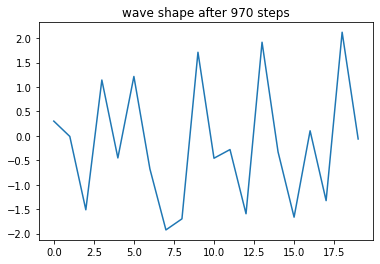

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_970/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_970/model_weights.tf
generator loss:1.7049701673524502
-----------------------
total discriminator loss:0.4450519015453256
average true return:0.48613098822674355
-----------------------


 62%|██████▏   | 971/1562 [2:04:47<1:01:20,  6.23s/it]

Training Step: 971
generator loss:1.9485243953534646
-----------------------
total discriminator loss:0.42827092063623995
average true return:0.4128851874683834
-----------------------


 62%|██████▏   | 972/1562 [2:04:49<49:48,  5.07s/it]  

Training Step: 972
generator loss:2.06384636044187
-----------------------
total discriminator loss:0.43884290733949655
average true return:0.39254073155027447
-----------------------


 62%|██████▏   | 973/1562 [2:04:52<41:47,  4.26s/it]

Training Step: 973
generator loss:1.9218666268272173
-----------------------
total discriminator loss:0.43537868298816274
average true return:0.4142971972256665
-----------------------


 62%|██████▏   | 974/1562 [2:04:54<36:04,  3.68s/it]

Training Step: 974
generator loss:1.6887381745289414
-----------------------
total discriminator loss:0.4266111525707862
average true return:0.4736839535272528
-----------------------


 62%|██████▏   | 975/1562 [2:04:56<32:07,  3.28s/it]

Training Step: 975
event_types: [1, 2, 0, 3, 0, 2, 3, 2, 2, 1, 1, 0, 3, 2, 1, 1, 0, 3, 2, 3]
mad_score: 0.6393625
fid_score: 484.09839890570436
rule_score: 0.1525


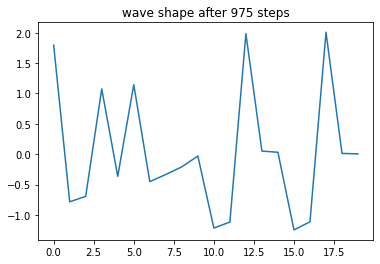

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_975/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_975/model_weights.tf
generator loss:1.5241256701855288
-----------------------
total discriminator loss:0.43594859509599426
average true return:0.5213487495751321
-----------------------


 62%|██████▏   | 976/1562 [2:05:10<1:02:38,  6.41s/it]

Training Step: 976
generator loss:1.3202897470801145
-----------------------


 63%|██████▎   | 977/1562 [2:05:12<50:18,  5.16s/it]  

total discriminator loss:0.43772808963328413
average true return:0.5356847502638388
-----------------------
Training Step: 977
generator loss:1.534320995366079
-----------------------


 63%|██████▎   | 978/1562 [2:05:14<40:53,  4.20s/it]

total discriminator loss:0.42242202611460666
average true return:0.5188475606586278
-----------------------
Training Step: 978
generator loss:1.6480476162156696
-----------------------
total discriminator loss:1.3718784386605223
average true return:0.49346401821376246
-----------------------


 63%|██████▎   | 979/1562 [2:05:16<35:07,  3.61s/it]

Training Step: 979
generator loss:1.5171627646942796
-----------------------
total discriminator loss:0.411641332037764
average true return:0.5176574040708039
-----------------------


 63%|██████▎   | 980/1562 [2:05:19<31:23,  3.24s/it]

Training Step: 980
event_types: [1, 0, 1, 0, 2, 2, 0, 3, 2, 1, 0, 3, 0, 2, 2, 3, 1, 2, 3, 3]
mad_score: 0.6331375
fid_score: 573.420594412988
rule_score: 0.16575


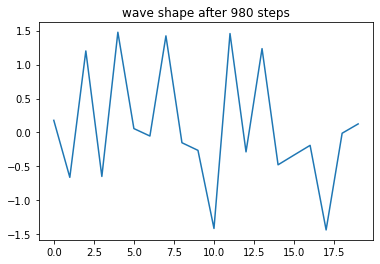

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_980/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_980/model_weights.tf
generator loss:1.4172554235655515
-----------------------
total discriminator loss:0.4175981260490782
average true return:0.5203883834647713
-----------------------


 63%|██████▎   | 981/1562 [2:05:33<1:02:13,  6.43s/it]

Training Step: 981
generator loss:1.4631369427295835
-----------------------
total discriminator loss:0.4352736332064462
average true return:0.5184060156891923
-----------------------


 63%|██████▎   | 982/1562 [2:05:35<50:46,  5.25s/it]  

Training Step: 982
generator loss:1.667560999552621
-----------------------
total discriminator loss:0.4260018435037872
average true return:0.46951970214534866
-----------------------


 63%|██████▎   | 983/1562 [2:05:38<44:00,  4.56s/it]

Training Step: 983
generator loss:1.7527932285348862
-----------------------
total discriminator loss:0.42710877872415365
average true return:0.4492631067548872
-----------------------


 63%|██████▎   | 984/1562 [2:05:40<37:30,  3.89s/it]

Training Step: 984
generator loss:1.7675780679058677
-----------------------
total discriminator loss:0.4385128947902079
average true return:0.4517316085748704
-----------------------


 63%|██████▎   | 985/1562 [2:05:43<32:58,  3.43s/it]

Training Step: 985
event_types: [1, 0, 3, 2, 2, 2, 1, 1, 2, 3, 0, 2, 2, 2, 3, 2, 1, 0, 3, 2]
mad_score: 0.63005
fid_score: 701.7772557496644
rule_score: 0.183


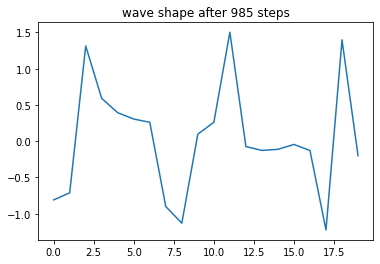

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_985/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_985/model_weights.tf
generator loss:1.6564378917842655
-----------------------
total discriminator loss:0.41185276635848733
average true return:0.461264469005637
-----------------------


 63%|██████▎   | 986/1562 [2:05:56<1:00:32,  6.31s/it]

Training Step: 986
generator loss:1.57980830680307
-----------------------
total discriminator loss:0.42180126213879365
average true return:0.4955764375884267
-----------------------


 63%|██████▎   | 987/1562 [2:05:58<49:05,  5.12s/it]  

Training Step: 987
generator loss:1.4192094207159844
-----------------------
total discriminator loss:0.4192461583335042
average true return:0.4955623093163497
-----------------------


 63%|██████▎   | 988/1562 [2:06:00<41:00,  4.29s/it]

Training Step: 988
generator loss:1.5247581515073996
-----------------------
total discriminator loss:0.4247833379531444
average true return:0.49936228439198194
-----------------------


 63%|██████▎   | 989/1562 [2:06:03<35:19,  3.70s/it]

Training Step: 989
generator loss:1.5331777458722877
-----------------------
total discriminator loss:0.4118833090444515
average true return:0.48933283297415864
-----------------------


 63%|██████▎   | 990/1562 [2:06:05<31:33,  3.31s/it]

Training Step: 990
event_types: [2, 0, 2, 1, 1, 1, 0, 3, 2, 3, 2, 0, 3, 1, 0, 3, 2, 3, 0, 3]
mad_score: 0.6246
fid_score: 845.733792470755
rule_score: 0.17425


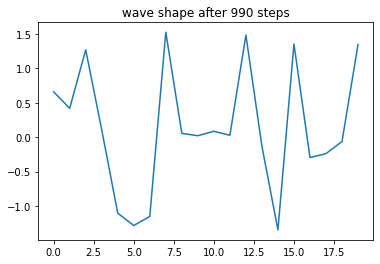

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_990/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_990/model_weights.tf
generator loss:1.4997612693615419
-----------------------


 63%|██████▎   | 991/1562 [2:06:18<59:37,  6.27s/it]

total discriminator loss:0.40187594716916386
average true return:0.4913486113972799
-----------------------
Training Step: 991
generator loss:1.5981728446861523
-----------------------
total discriminator loss:0.3904022879690494
average true return:0.5027235180295847
-----------------------


 64%|██████▎   | 992/1562 [2:06:21<48:02,  5.06s/it]

Training Step: 992
generator loss:1.6663603196179935
-----------------------
total discriminator loss:0.4248903876212238
average true return:0.46666532171006125
-----------------------


 64%|██████▎   | 993/1562 [2:06:23<40:13,  4.24s/it]

Training Step: 993
generator loss:1.6957299111197148
-----------------------
total discriminator loss:1.4519218644283605
average true return:0.4816929115965768
-----------------------


 64%|██████▎   | 994/1562 [2:06:25<35:06,  3.71s/it]

Training Step: 994
generator loss:1.482150980474961
-----------------------
total discriminator loss:0.3906458504425321
average true return:0.5214017748697306
-----------------------


 64%|██████▎   | 995/1562 [2:06:28<31:10,  3.30s/it]

Training Step: 995
event_types: [0, 3, 3, 2, 1, 1, 1, 0, 3, 1, 1, 0, 2, 3, 2, 2, 1, 2, 0, 3]
mad_score: 0.6249
fid_score: 1036.4924887081531
rule_score: 0.18575


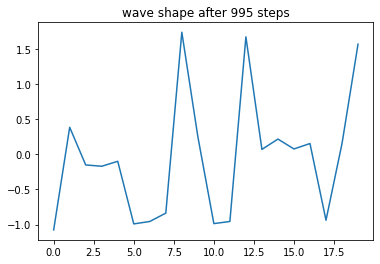

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_995/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_995/model_weights.tf
generator loss:1.4398276691295635
-----------------------
total discriminator loss:0.4112831401597799
average true return:0.529847868706254
-----------------------


 64%|██████▍   | 996/1562 [2:06:41<1:00:43,  6.44s/it]

Training Step: 996
generator loss:1.4615579789254625
-----------------------
total discriminator loss:0.4146231386742468
average true return:0.5254321153921551
-----------------------


 64%|██████▍   | 997/1562 [2:06:44<49:00,  5.20s/it]  

Training Step: 997
generator loss:1.5457184385157383
-----------------------
total discriminator loss:0.397830429246145
average true return:0.491587780626237
-----------------------


 64%|██████▍   | 998/1562 [2:06:46<40:45,  4.34s/it]

Training Step: 998
generator loss:1.6836556662400688
-----------------------
total discriminator loss:0.4062236060000669
average true return:0.4730282854228409
-----------------------


 64%|██████▍   | 999/1562 [2:06:48<35:01,  3.73s/it]

Training Step: 999
generator loss:1.6687834176875223
-----------------------


 64%|██████▍   | 1000/1562 [2:06:50<30:04,  3.21s/it]

total discriminator loss:0.40353588367067467
average true return:0.4702997281553044
-----------------------
Training Step: 1000
event_types: [2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 3, 1, 0, 3, 0, 3, 1, 0]
mad_score: 0.619775
fid_score: 1208.230905528338
rule_score: 0.201


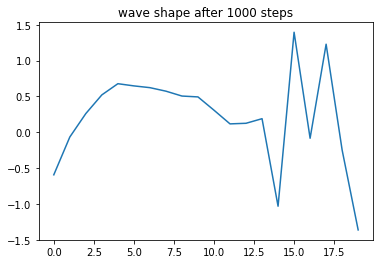

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1000/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1000/model_weights.tf
generator loss:1.6699486977373685
-----------------------
total discriminator loss:0.4082422090929285
average true return:0.48580533103938117
-----------------------


 64%|██████▍   | 1001/1562 [2:07:04<59:01,  6.31s/it]

Training Step: 1001
generator loss:1.6081462638333983
-----------------------
total discriminator loss:1.4796946848024393
average true return:0.5060371073413645
-----------------------


 64%|██████▍   | 1002/1562 [2:07:06<47:55,  5.14s/it]

Training Step: 1002
generator loss:1.3207677314810828
-----------------------
total discriminator loss:0.42160995917221833
average true return:0.5621261510561528
-----------------------


 64%|██████▍   | 1003/1562 [2:07:09<40:14,  4.32s/it]

Training Step: 1003
generator loss:1.2361158060930357
-----------------------
total discriminator loss:0.4133072646745487
average true return:0.5674545927953456
-----------------------


 64%|██████▍   | 1004/1562 [2:07:11<34:45,  3.74s/it]

Training Step: 1004
generator loss:1.3211769218166984
-----------------------
total discriminator loss:0.4046587927810934
average true return:0.55497172343301
-----------------------


 64%|██████▍   | 1005/1562 [2:07:14<30:52,  3.33s/it]

Training Step: 1005
event_types: [0, 2, 0, 2, 2, 1, 2, 3, 2, 2, 2, 3, 2, 2, 3, 1, 2, 3, 0, 3]
mad_score: 0.6160875
fid_score: 1407.2670251857444
rule_score: 0.19825


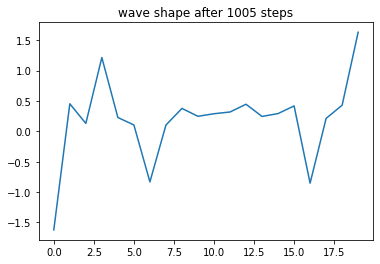

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1005/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1005/model_weights.tf
generator loss:1.4506560765650562
-----------------------
total discriminator loss:0.4072571984556779
average true return:0.51880493736054
-----------------------


 64%|██████▍   | 1006/1562 [2:07:26<57:33,  6.21s/it]

Training Step: 1006
generator loss:1.5754661257274019
-----------------------


 64%|██████▍   | 1007/1562 [2:07:29<46:41,  5.05s/it]

total discriminator loss:0.42883376477729745
average true return:0.46426685900826675
-----------------------
Training Step: 1007
generator loss:1.6600104383011287
-----------------------
total discriminator loss:1.3419188546048715
average true return:0.4482606288682176
-----------------------


 65%|██████▍   | 1008/1562 [2:07:31<39:06,  4.24s/it]

Training Step: 1008
generator loss:1.679522709539933
-----------------------
total discriminator loss:0.47528863637606034
average true return:0.41392763832862844
-----------------------


 65%|██████▍   | 1009/1562 [2:07:33<33:46,  3.66s/it]

Training Step: 1009
generator loss:1.5767670804758165
-----------------------
total discriminator loss:0.46624947517326043
average true return:0.42961407390305184
-----------------------


 65%|██████▍   | 1010/1562 [2:07:36<30:09,  3.28s/it]

Training Step: 1010
event_types: [2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 0, 2, 1, 2, 0, 3, 2, 1]
mad_score: 0.61305
fid_score: 1584.4434408110533
rule_score: 0.20675


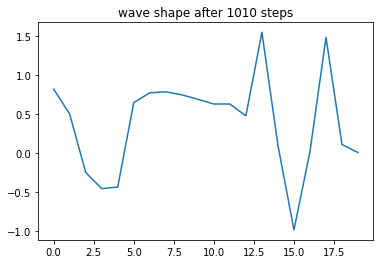

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1010/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1010/model_weights.tf
generator loss:1.4398428129178624
-----------------------
total discriminator loss:0.4401626079965486
average true return:0.47846901240815787
-----------------------


 65%|██████▍   | 1011/1562 [2:07:50<1:01:01,  6.64s/it]

Training Step: 1011
generator loss:1.2605183424814967
-----------------------
total discriminator loss:0.42113499524892395
average true return:0.5366392285800454
-----------------------


 65%|██████▍   | 1012/1562 [2:07:53<49:06,  5.36s/it]  

Training Step: 1012
generator loss:1.1300376282117233
-----------------------


 65%|██████▍   | 1013/1562 [2:07:55<39:44,  4.34s/it]

total discriminator loss:0.4166993689890628
average true return:0.5735229367607693
-----------------------
Training Step: 1013
generator loss:1.0092125121749371
-----------------------


 65%|██████▍   | 1014/1562 [2:07:57<33:32,  3.67s/it]

total discriminator loss:0.47302560186458553
average true return:0.6123534951312934
-----------------------
Training Step: 1014
generator loss:1.0247078883438299
-----------------------
total discriminator loss:0.4426524084811717
average true return:0.604496857127126
-----------------------


 65%|██████▍   | 1015/1562 [2:07:59<29:50,  3.27s/it]

Training Step: 1015
event_types: [1, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 3, 3, 2, 3, 3, 0]
mad_score: 0.6035875
fid_score: 1866.4617404517658
rule_score: 0.216


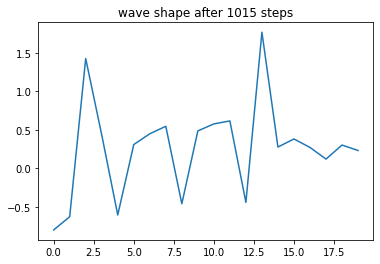

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1015/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1015/model_weights.tf
generator loss:1.104406677047976
-----------------------
total discriminator loss:0.45566093712484756
average true return:0.5992168838977494
-----------------------


 65%|██████▌   | 1016/1562 [2:08:13<58:33,  6.43s/it]

Training Step: 1016
generator loss:1.159385925335199
-----------------------
total discriminator loss:0.4271108198966753
average true return:0.5644334182538276
-----------------------


 65%|██████▌   | 1017/1562 [2:08:15<47:21,  5.21s/it]

Training Step: 1017
generator loss:1.3017301616571277
-----------------------
total discriminator loss:0.4369476406732357
average true return:0.5171135730181766
-----------------------


 65%|██████▌   | 1018/1562 [2:08:18<39:25,  4.35s/it]

Training Step: 1018
generator loss:1.5703249271115485
-----------------------
total discriminator loss:0.40372219926514075
average true return:0.46974276750357474
-----------------------


 65%|██████▌   | 1019/1562 [2:08:20<34:05,  3.77s/it]

Training Step: 1019
generator loss:1.6333679906217116
-----------------------
total discriminator loss:0.3999362353883235
average true return:0.46452689847855777
-----------------------


 65%|██████▌   | 1020/1562 [2:08:22<30:03,  3.33s/it]

Training Step: 1020
event_types: [3, 2, 2, 1, 1, 0, 3, 1, 0, 2, 3, 2, 3, 2, 3, 2, 3, 3, 0, 3]
mad_score: 0.5944625
fid_score: 2059.723721301208
rule_score: 0.2465


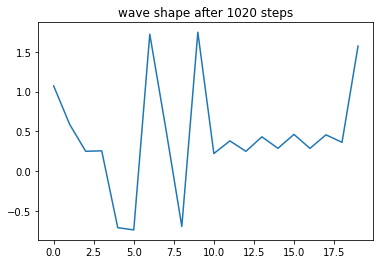

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1020/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1020/model_weights.tf
generator loss:1.7026196994298977
-----------------------
total discriminator loss:0.3997238084593481
average true return:0.474373887750394
-----------------------


 65%|██████▌   | 1021/1562 [2:08:35<56:21,  6.25s/it]

Training Step: 1021
generator loss:1.645977594240683
-----------------------
total discriminator loss:0.3918110803306501
average true return:0.480531455163015
-----------------------


 65%|██████▌   | 1022/1562 [2:08:38<45:40,  5.08s/it]

Training Step: 1022
generator loss:1.5463551433207212
-----------------------
total discriminator loss:0.3875594497862491
average true return:0.507548019935132
-----------------------


 65%|██████▌   | 1023/1562 [2:08:40<38:18,  4.26s/it]

Training Step: 1023
generator loss:1.517367085615378
-----------------------
total discriminator loss:0.3947652800644986
average true return:0.5285389801799494
-----------------------


 66%|██████▌   | 1024/1562 [2:08:42<33:06,  3.69s/it]

Training Step: 1024
generator loss:1.5126541805757374
-----------------------
total discriminator loss:0.3896375354604501
average true return:0.5449258319115524
-----------------------


 66%|██████▌   | 1025/1562 [2:08:45<29:32,  3.30s/it]

Training Step: 1025
event_types: [0, 3, 1, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 1, 0, 3, 3, 1, 1, 0]
mad_score: 0.5883125
fid_score: 2343.1824621432165
rule_score: 0.22325


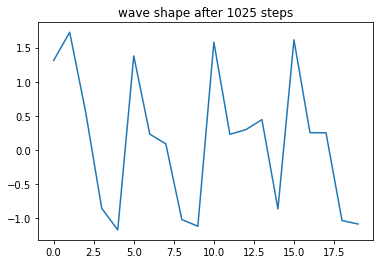

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1025/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1025/model_weights.tf
generator loss:1.5447084330382306
-----------------------


 66%|██████▌   | 1026/1562 [2:08:58<56:23,  6.31s/it]

total discriminator loss:0.3996002112257953
average true return:0.5229544348637155
-----------------------
Training Step: 1026
generator loss:1.6883148283148073
-----------------------
total discriminator loss:0.3948059286967801
average true return:0.49172409367334974
-----------------------


 66%|██████▌   | 1027/1562 [2:09:00<45:07,  5.06s/it]

Training Step: 1027
generator loss:1.8227176873675788
-----------------------
total discriminator loss:0.3814498220346651
average true return:0.493888117441653
-----------------------


 66%|██████▌   | 1028/1562 [2:09:03<37:45,  4.24s/it]

Training Step: 1028
generator loss:1.948418382424605
-----------------------
total discriminator loss:1.691221785525912
average true return:0.4806986832421082
-----------------------


 66%|██████▌   | 1029/1562 [2:09:05<32:38,  3.67s/it]

Training Step: 1029
generator loss:1.822554164254879
-----------------------
total discriminator loss:0.39066069295168254
average true return:0.4934737701754687
-----------------------


 66%|██████▌   | 1030/1562 [2:09:07<29:05,  3.28s/it]

Training Step: 1030
event_types: [1, 1, 0, 3, 2, 1, 0, 3, 2, 2, 3, 2, 1, 0, 3, 2, 0, 3, 2, 0]
mad_score: 0.5783125
fid_score: 2656.627883807876
rule_score: 0.2455


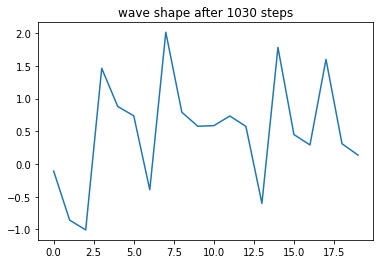

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1030/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1030/model_weights.tf
generator loss:1.730273575677984
-----------------------
total discriminator loss:0.3814835760025339
average true return:0.5114363522733549
-----------------------


 66%|██████▌   | 1031/1562 [2:09:21<57:02,  6.44s/it]

Training Step: 1031
generator loss:1.6511190414033872
-----------------------
total discriminator loss:1.6166632005031958
average true return:0.5150140211010024
-----------------------


 66%|██████▌   | 1032/1562 [2:09:24<46:02,  5.21s/it]

Training Step: 1032
generator loss:1.5529599721701899
-----------------------
total discriminator loss:0.3557977526261758
average true return:0.5305081644598824
-----------------------


 66%|██████▌   | 1033/1562 [2:09:26<38:19,  4.35s/it]

Training Step: 1033
generator loss:1.5483578525935613
-----------------------
total discriminator loss:0.3812916678708022
average true return:0.5260817728562155
-----------------------


 66%|██████▌   | 1034/1562 [2:09:28<32:53,  3.74s/it]

Training Step: 1034
generator loss:1.5109850101488085
-----------------------


 66%|██████▋   | 1035/1562 [2:09:30<28:20,  3.23s/it]

total discriminator loss:0.4067954639057785
average true return:0.5349685390031436
-----------------------
Training Step: 1035
event_types: [2, 1, 3, 3, 2, 2, 2, 1, 0, 2, 2, 2, 2, 3, 1, 0, 3, 3, 2, 2]
mad_score: 0.5702375
fid_score: 2831.1906686676484
rule_score: 0.26425


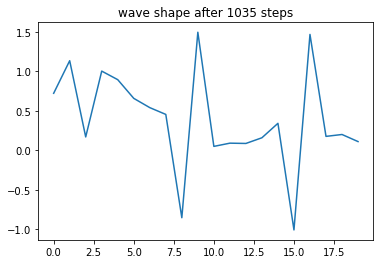

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1035/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1035/model_weights.tf
generator loss:1.5422723494254962
-----------------------
total discriminator loss:0.3889039633742566
average true return:0.5447535874084696
-----------------------


 66%|██████▋   | 1036/1562 [2:09:44<55:37,  6.35s/it]

Training Step: 1036
generator loss:1.5317995420895216
-----------------------
total discriminator loss:0.38683489941234583
average true return:0.5140222897760268
-----------------------


 66%|██████▋   | 1037/1562 [2:09:46<45:02,  5.15s/it]

Training Step: 1037
generator loss:1.5994096265114988
-----------------------
total discriminator loss:0.38931485783908815
average true return:0.503751721865956
-----------------------


 66%|██████▋   | 1038/1562 [2:09:49<37:41,  4.32s/it]

Training Step: 1038
generator loss:1.586209653781765
-----------------------
total discriminator loss:0.396876593535782
average true return:0.48760551878672675
-----------------------


 67%|██████▋   | 1039/1562 [2:09:51<32:33,  3.74s/it]

Training Step: 1039
generator loss:1.599945540058098
-----------------------
total discriminator loss:0.40478825807770513
average true return:0.4797516519962564
-----------------------


 67%|██████▋   | 1040/1562 [2:09:53<28:53,  3.32s/it]

Training Step: 1040
event_types: [3, 1, 1, 0, 3, 2, 1, 0, 3, 3, 2, 0, 3, 2, 2, 1, 0, 3, 2, 2]
mad_score: 0.55685
fid_score: 3167.1925275210033
rule_score: 0.26575


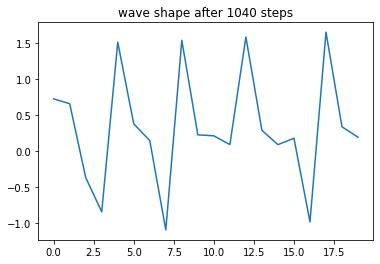

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1040/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1040/model_weights.tf
generator loss:1.6074977929136303
-----------------------
total discriminator loss:0.3834684710206083
average true return:0.49492054793706186
-----------------------


 67%|██████▋   | 1041/1562 [2:10:06<54:25,  6.27s/it]

Training Step: 1041
generator loss:1.554356465497415
-----------------------
total discriminator loss:0.37672565982895295
average true return:0.5189056987758013
-----------------------


 67%|██████▋   | 1042/1562 [2:10:09<44:13,  5.10s/it]

Training Step: 1042
generator loss:1.5093800955617536
-----------------------
total discriminator loss:0.38409153534233165
average true return:0.519358548511957
-----------------------


 67%|██████▋   | 1043/1562 [2:10:11<36:59,  4.28s/it]

Training Step: 1043
generator loss:1.468677104957115
-----------------------


 67%|██████▋   | 1044/1562 [2:10:14<32:11,  3.73s/it]

total discriminator loss:0.3806089848526553
average true return:0.5178279802545352
-----------------------
Training Step: 1044
generator loss:1.5056272029937554
-----------------------
total discriminator loss:0.39553688506320717
average true return:0.5283189548067935
-----------------------


 67%|██████▋   | 1045/1562 [2:10:16<28:39,  3.33s/it]

Training Step: 1045
event_types: [2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 1, 0, 3, 2, 2, 2]
mad_score: 0.5502375
fid_score: 3364.3322449514867
rule_score: 0.2875


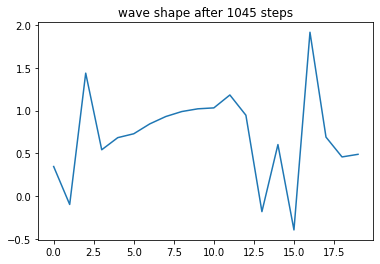

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1045/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1045/model_weights.tf
generator loss:1.5084316098110049
-----------------------
total discriminator loss:0.3686681121471902
average true return:0.5254012612075846
-----------------------


 67%|██████▋   | 1046/1562 [2:10:30<55:45,  6.48s/it]

Training Step: 1046
generator loss:1.6032124976552522
-----------------------
total discriminator loss:0.3894088174238143
average true return:0.5093864964214125
-----------------------


 67%|██████▋   | 1047/1562 [2:10:32<45:01,  5.25s/it]

Training Step: 1047
generator loss:1.6210600627347562
-----------------------


 67%|██████▋   | 1048/1562 [2:10:34<36:49,  4.30s/it]

total discriminator loss:0.39511489653362963
average true return:0.508496626423181
-----------------------
Training Step: 1048
generator loss:1.6948990437843634
-----------------------
total discriminator loss:0.3940914420332735
average true return:0.493671262580063
-----------------------


 67%|██████▋   | 1049/1562 [2:10:36<31:00,  3.63s/it]

Training Step: 1049
generator loss:1.7977909219939185
-----------------------
total discriminator loss:1.5270074529779762
average true return:0.49025425829041275
-----------------------


 67%|██████▋   | 1050/1562 [2:10:39<27:35,  3.23s/it]

Training Step: 1050
event_types: [2, 1, 2, 1, 0, 2, 2, 1, 1, 1, 0, 3, 2, 2, 2, 3, 3, 2, 3, 3]
mad_score: 0.544175
fid_score: 3616.4784323790627
rule_score: 0.2665


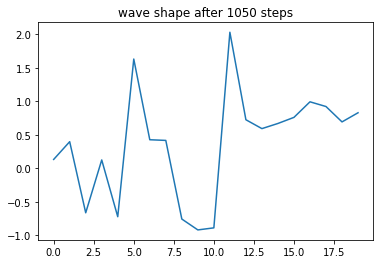

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1050/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1050/model_weights.tf
generator loss:1.8676897217456458
-----------------------
total discriminator loss:0.40177969975458916
average true return:0.47465427990907916
-----------------------


 67%|██████▋   | 1051/1562 [2:10:53<54:46,  6.43s/it]

Training Step: 1051
generator loss:1.8581614703246145
-----------------------
total discriminator loss:1.5205975751280747
average true return:0.4501502599665571
-----------------------


 67%|██████▋   | 1052/1562 [2:10:55<44:09,  5.19s/it]

Training Step: 1052
generator loss:1.951745564803677
-----------------------


 67%|██████▋   | 1053/1562 [2:10:57<36:52,  4.35s/it]

total discriminator loss:0.41013902234195065
average true return:0.4239674525320098
-----------------------
Training Step: 1053
generator loss:1.8393807582219464
-----------------------
total discriminator loss:0.42495611605863937
average true return:0.419709846057048
-----------------------


 67%|██████▋   | 1054/1562 [2:11:00<31:44,  3.75s/it]

Training Step: 1054
generator loss:1.6458534739047703
-----------------------
total discriminator loss:0.3895344634921779
average true return:0.4714854691101601
-----------------------


 68%|██████▊   | 1055/1562 [2:11:02<28:07,  3.33s/it]

Training Step: 1055
event_types: [2, 3, 2, 1, 1, 1, 0, 3, 3, 2, 3, 3, 2, 1, 2, 3, 3, 2, 2, 3]
mad_score: 0.538925
fid_score: 3965.155173413304
rule_score: 0.261


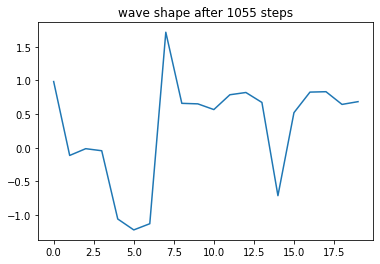

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1055/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1055/model_weights.tf
generator loss:1.5320841467761455
-----------------------
total discriminator loss:0.4155391372546893
average true return:0.5056410496722452
-----------------------


 68%|██████▊   | 1056/1562 [2:11:15<53:10,  6.31s/it]

Training Step: 1056
generator loss:1.4198758543115155
-----------------------
total discriminator loss:0.39195172078229257
average true return:0.5540637489648683
-----------------------


 68%|██████▊   | 1057/1562 [2:11:18<43:07,  5.12s/it]

Training Step: 1057
generator loss:1.3539794445322626
-----------------------
total discriminator loss:0.39718341746184527
average true return:0.5713413190515613
-----------------------


 68%|██████▊   | 1058/1562 [2:11:20<36:06,  4.30s/it]

Training Step: 1058
generator loss:1.2979592885944613
-----------------------
total discriminator loss:0.412496157880741
average true return:0.5713947559187185
-----------------------


 68%|██████▊   | 1059/1562 [2:11:22<31:08,  3.72s/it]

Training Step: 1059
generator loss:1.3302688147074244
-----------------------
total discriminator loss:0.4043365078649258
average true return:0.5561167113043678
-----------------------


 68%|██████▊   | 1060/1562 [2:11:25<27:38,  3.30s/it]

Training Step: 1060
event_types: [2, 3, 2, 2, 2, 1, 0, 3, 2, 0, 3, 2, 3, 3, 2, 0, 2, 2, 1, 0]
mad_score: 0.536525
fid_score: 4315.725299539696
rule_score: 0.26


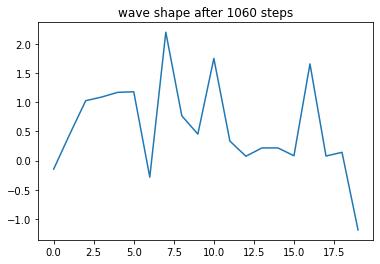

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1060/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1060/model_weights.tf
generator loss:1.3820847109793386
-----------------------


 68%|██████▊   | 1061/1562 [2:11:38<53:49,  6.45s/it]

total discriminator loss:1.4660150002167565
average true return:0.5415150411008918
-----------------------
Training Step: 1061
generator loss:1.5062151494478468
-----------------------
total discriminator loss:1.4104532269389525
average true return:0.5021598151116847
-----------------------


 68%|██████▊   | 1062/1562 [2:11:41<42:50,  5.14s/it]

Training Step: 1062
generator loss:1.5487058799907265
-----------------------
total discriminator loss:1.295940163359651
average true return:0.456839918610779
-----------------------


 68%|██████▊   | 1063/1562 [2:11:43<35:46,  4.30s/it]

Training Step: 1063
generator loss:1.6805912514101484
-----------------------
total discriminator loss:0.4930664611491265
average true return:0.3721861022121874
-----------------------


 68%|██████▊   | 1064/1562 [2:11:45<30:54,  3.72s/it]

Training Step: 1064
generator loss:1.6625749540068624
-----------------------
total discriminator loss:0.5430861584951769
average true return:0.3500103157267428
-----------------------


 68%|██████▊   | 1065/1562 [2:11:48<27:21,  3.30s/it]

Training Step: 1065
event_types: [3, 2, 2, 3, 2, 0, 3, 2, 2, 1, 0, 3, 2, 2, 3, 2, 3, 3, 1, 0]
mad_score: 0.5304625
fid_score: 4693.328887473886
rule_score: 0.254


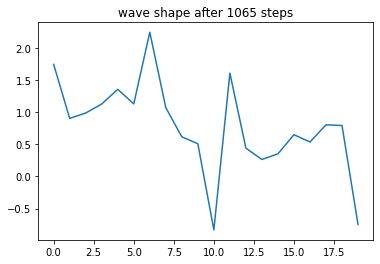

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1065/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1065/model_weights.tf
generator loss:1.6046933825061243
-----------------------
total discriminator loss:0.5241378314121741
average true return:0.37762264097947795
-----------------------


 68%|██████▊   | 1066/1562 [2:12:01<53:11,  6.43s/it]

Training Step: 1066
generator loss:1.4409477872868868
-----------------------
total discriminator loss:0.48178755707898147
average true return:0.42729785332339093
-----------------------


 68%|██████▊   | 1067/1562 [2:12:04<42:56,  5.21s/it]

Training Step: 1067
generator loss:1.3206654874842876
-----------------------
total discriminator loss:0.4338985159694106
average true return:0.5063553993689438
-----------------------


 68%|██████▊   | 1068/1562 [2:12:06<36:45,  4.46s/it]

Training Step: 1068
generator loss:1.158028656273556
-----------------------
total discriminator loss:0.4317594134881409
average true return:0.5590493779506736
-----------------------


 68%|██████▊   | 1069/1562 [2:12:09<31:45,  3.87s/it]

Training Step: 1069
generator loss:1.022416688515627
-----------------------


 69%|██████▊   | 1070/1562 [2:12:11<27:24,  3.34s/it]

total discriminator loss:0.4344487179581129
average true return:0.5918327981742706
-----------------------
Training Step: 1070
event_types: [2, 2, 0, 3, 2, 3, 0, 3, 2, 2, 0, 3, 2, 2, 1, 0, 3, 2, 2, 3]
mad_score: 0.5304375
fid_score: 5167.370867944063
rule_score: 0.24825


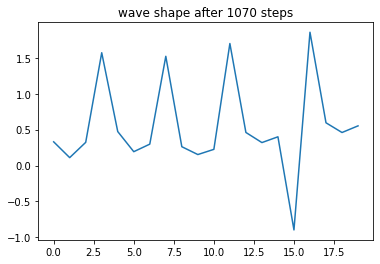

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1070/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1070/model_weights.tf
generator loss:0.9079195600478613
-----------------------
total discriminator loss:0.4939945374912974
average true return:0.6258819705996971
-----------------------


 69%|██████▊   | 1071/1562 [2:12:25<52:41,  6.44s/it]

Training Step: 1071
generator loss:0.9343929011223893
-----------------------


 69%|██████▊   | 1072/1562 [2:12:27<42:31,  5.21s/it]

total discriminator loss:0.4873274194789328
average true return:0.6335056806521565
-----------------------
Training Step: 1072
generator loss:0.932367917434045
-----------------------
total discriminator loss:0.48204905148550026
average true return:0.6309376049124096
-----------------------


 69%|██████▊   | 1073/1562 [2:12:29<35:33,  4.36s/it]

Training Step: 1073
generator loss:0.9914619505829577
-----------------------
total discriminator loss:0.43186443020073273
average true return:0.5950265386638969
-----------------------


 69%|██████▉   | 1074/1562 [2:12:32<30:35,  3.76s/it]

Training Step: 1074
generator loss:1.100655649121535
-----------------------
total discriminator loss:0.43618109013413464
average true return:0.584920099370529
-----------------------


 69%|██████▉   | 1075/1562 [2:12:34<27:04,  3.34s/it]

Training Step: 1075
event_types: [2, 1, 2, 0, 3, 2, 1, 2, 1, 0, 3, 2, 3, 2, 3, 1, 2, 2, 3, 3]
mad_score: 0.532925
fid_score: 5484.49502388161
rule_score: 0.23225


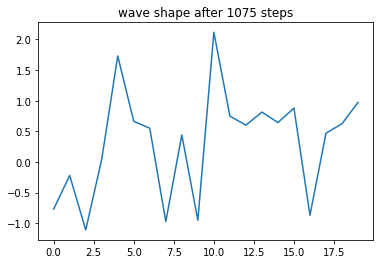

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1075/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1075/model_weights.tf
generator loss:1.205133347568161
-----------------------
total discriminator loss:0.42304324317048186
average true return:0.5413819833220914
-----------------------


 69%|██████▉   | 1076/1562 [2:12:47<50:08,  6.19s/it]

Training Step: 1076
generator loss:1.2673175747146728
-----------------------
total discriminator loss:0.418296742763469
average true return:0.5245003530073518
-----------------------


 69%|██████▉   | 1077/1562 [2:12:49<40:39,  5.03s/it]

Training Step: 1077
generator loss:1.3722289682456768
-----------------------
total discriminator loss:0.4249593091818731
average true return:0.49316668855860046
-----------------------


 69%|██████▉   | 1078/1562 [2:12:52<34:04,  4.22s/it]

Training Step: 1078
generator loss:1.4227049492283437
-----------------------


 69%|██████▉   | 1079/1562 [2:12:54<29:25,  3.66s/it]

total discriminator loss:0.43076478909091853
average true return:0.4783902642873846
-----------------------
Training Step: 1079
generator loss:1.4718495512238015
-----------------------
total discriminator loss:0.4058858662145757
average true return:0.47140512194986184
-----------------------


 69%|██████▉   | 1080/1562 [2:12:56<26:16,  3.27s/it]

Training Step: 1080
event_types: [1, 1, 0, 3, 2, 0, 2, 3, 2, 0, 3, 1, 2, 3, 0, 3, 0, 2, 2, 1]
mad_score: 0.5449375
fid_score: 5476.556787755618
rule_score: 0.2035


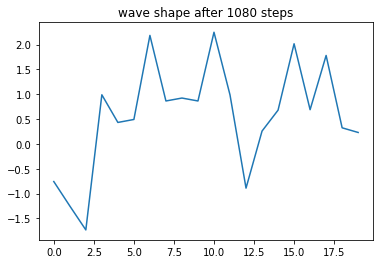

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1080/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1080/model_weights.tf
generator loss:1.515936261545073
-----------------------
total discriminator loss:0.4383278571222122
average true return:0.46156721626706243
-----------------------


 69%|██████▉   | 1081/1562 [2:13:10<51:47,  6.46s/it]

Training Step: 1081
generator loss:1.5012924413487974
-----------------------
total discriminator loss:0.41175251866620177
average true return:0.4827495990731531
-----------------------


 69%|██████▉   | 1082/1562 [2:13:13<41:48,  5.23s/it]

Training Step: 1082
generator loss:1.506748886343538
-----------------------


 69%|██████▉   | 1083/1562 [2:13:15<34:06,  4.27s/it]

total discriminator loss:0.41912898674384164
average true return:0.49083908341601035
-----------------------
Training Step: 1083
generator loss:1.5060119174029674
-----------------------
total discriminator loss:0.418156173744925
average true return:0.5146642214060095
-----------------------


 69%|██████▉   | 1084/1562 [2:13:17<28:49,  3.62s/it]

Training Step: 1084
generator loss:1.446734553299057
-----------------------
total discriminator loss:0.3651296570134329
average true return:0.49977726500061803
-----------------------


 69%|██████▉   | 1085/1562 [2:13:19<25:44,  3.24s/it]

Training Step: 1085
event_types: [2, 1, 0, 3, 2, 0, 3, 2, 3, 2, 2, 3, 2, 1, 0, 3, 0, 3, 3, 2]
mad_score: 0.555775
fid_score: 5240.75592673875
rule_score: 0.18975


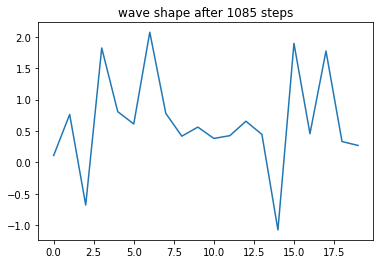

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1085/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1085/model_weights.tf
generator loss:1.4524534643867684
-----------------------
total discriminator loss:0.36847788011285754
average true return:0.5291635337067417
-----------------------


 70%|██████▉   | 1086/1562 [2:13:33<50:50,  6.41s/it]

Training Step: 1086
generator loss:1.4468395455396021
-----------------------
total discriminator loss:0.39418384092170233
average true return:0.530447804713849
-----------------------


 70%|██████▉   | 1087/1562 [2:13:35<41:05,  5.19s/it]

Training Step: 1087
generator loss:1.4484483073806462
-----------------------
total discriminator loss:0.40024682558890645
average true return:0.5518750228289024
-----------------------


 70%|██████▉   | 1088/1562 [2:13:38<34:14,  4.33s/it]

Training Step: 1088
generator loss:1.476870579202875
-----------------------
total discriminator loss:0.39239874118879614
average true return:0.5388292879666186
-----------------------


 70%|██████▉   | 1089/1562 [2:13:40<30:13,  3.83s/it]

Training Step: 1089
generator loss:1.5441920392499764
-----------------------
total discriminator loss:0.3777005826573404
average true return:0.5331697534030453
-----------------------


 70%|██████▉   | 1090/1562 [2:13:43<26:36,  3.38s/it]

Training Step: 1090
event_types: [2, 2, 2, 3, 2, 2, 3, 1, 3, 2, 0, 3, 3, 2, 1, 0, 2, 3, 1, 0]
mad_score: 0.562075
fid_score: 4700.171711475287
rule_score: 0.16475


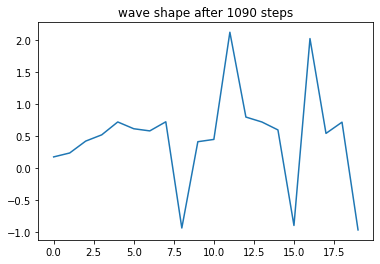

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1090/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1090/model_weights.tf
generator loss:1.5703966888430538
-----------------------
total discriminator loss:0.3883205075505476
average true return:0.5161383587442545
-----------------------


 70%|██████▉   | 1091/1562 [2:13:56<49:22,  6.29s/it]

Training Step: 1091
generator loss:1.6610739112834487
-----------------------
total discriminator loss:0.38445428269971105
average true return:0.5049050126954272
-----------------------


 70%|██████▉   | 1092/1562 [2:13:58<39:59,  5.10s/it]

Training Step: 1092
generator loss:1.7682893911586628
-----------------------
total discriminator loss:0.38390811572243916
average true return:0.4830729518908389
-----------------------


 70%|██████▉   | 1093/1562 [2:14:00<33:27,  4.28s/it]

Training Step: 1093
generator loss:1.86148526993414
-----------------------
total discriminator loss:0.38261366996691115
average true return:0.47310169146024017
-----------------------


 70%|███████   | 1094/1562 [2:14:03<29:06,  3.73s/it]

Training Step: 1094
generator loss:1.8904977865504948
-----------------------
total discriminator loss:1.571021083331566
average true return:0.4625462618605879
-----------------------


 70%|███████   | 1095/1562 [2:14:05<25:55,  3.33s/it]

Training Step: 1095
event_types: [2, 1, 2, 2, 3, 3, 2, 2, 3, 2, 0, 3, 2, 1, 2, 0, 3, 3, 2, 2]
mad_score: 0.568275
fid_score: 3894.487369913872
rule_score: 0.1555


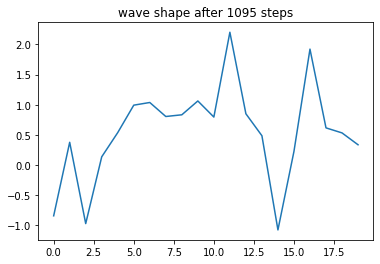

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1095/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1095/model_weights.tf
generator loss:1.921320570021781
-----------------------


 70%|███████   | 1096/1562 [2:14:19<49:48,  6.41s/it]

total discriminator loss:0.39665188871505874
average true return:0.46369846699919076
-----------------------
Training Step: 1096
generator loss:1.881807182743234
-----------------------


 70%|███████   | 1097/1562 [2:14:21<39:23,  5.08s/it]

total discriminator loss:0.4055163144954906
average true return:0.45963358307916036
-----------------------
Training Step: 1097
generator loss:1.889245814630466
-----------------------
total discriminator loss:0.3854202907996446
average true return:0.4711526685632492
-----------------------


 70%|███████   | 1098/1562 [2:14:23<32:55,  4.26s/it]

Training Step: 1098
generator loss:1.789994662692243
-----------------------
total discriminator loss:0.3986314328256152
average true return:0.475145171430812
-----------------------


 70%|███████   | 1099/1562 [2:14:25<28:29,  3.69s/it]

Training Step: 1099
generator loss:1.7038424435654298
-----------------------
total discriminator loss:0.3776494842394895
average true return:0.502126372494635
-----------------------


 70%|███████   | 1100/1562 [2:14:28<25:22,  3.29s/it]

Training Step: 1100
event_types: [2, 1, 2, 0, 2, 2, 3, 2, 2, 2, 3, 3, 2, 3, 3, 3, 1, 0, 3, 0]
mad_score: 0.576575
fid_score: 3032.7318315920093
rule_score: 0.16375


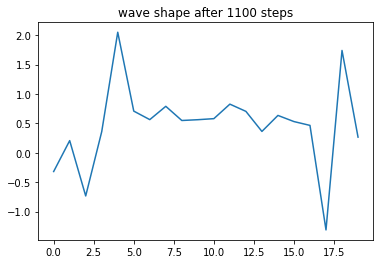

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1100/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1100/model_weights.tf
generator loss:1.5755696348927861
-----------------------


 70%|███████   | 1101/1562 [2:14:42<49:21,  6.42s/it]

total discriminator loss:0.3637174033658517
average true return:0.5187588660550564
-----------------------
Training Step: 1101
generator loss:1.5332964794750477
-----------------------
total discriminator loss:0.37823368972549215
average true return:0.5398589370917903
-----------------------


 71%|███████   | 1102/1562 [2:14:44<39:49,  5.19s/it]

Training Step: 1102
generator loss:1.6079383308151138
-----------------------
total discriminator loss:0.390525589847071
average true return:0.5426240440574184
-----------------------


 71%|███████   | 1103/1562 [2:14:46<33:09,  4.34s/it]

Training Step: 1103
generator loss:1.6013358422512045
-----------------------
total discriminator loss:0.378739314135634
average true return:0.5262995297061686
-----------------------


 71%|███████   | 1104/1562 [2:14:48<28:26,  3.73s/it]

Training Step: 1104
generator loss:1.8190378911148546
-----------------------


 71%|███████   | 1105/1562 [2:14:51<24:55,  3.27s/it]

total discriminator loss:0.3890941816053237
average true return:0.4975260572685616
-----------------------
Training Step: 1105
event_types: [3, 1, 0, 2, 1, 1, 1, 0, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3]
mad_score: 0.5763
fid_score: 2237.013575619614
rule_score: 0.172


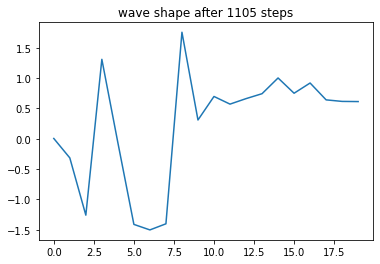

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1105/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1105/model_weights.tf
generator loss:1.795909699110618
-----------------------
total discriminator loss:0.3816248394726056
average true return:0.4918815522786115
-----------------------


 71%|███████   | 1106/1562 [2:15:04<47:54,  6.30s/it]

Training Step: 1106
generator loss:1.8948226834064994
-----------------------
total discriminator loss:0.3936140448049411
average true return:0.46598697892531804
-----------------------


 71%|███████   | 1107/1562 [2:15:06<38:52,  5.13s/it]

Training Step: 1107
generator loss:2.0627759078419796
-----------------------
total discriminator loss:0.41107637577762646
average true return:0.4709159767914439
-----------------------


 71%|███████   | 1108/1562 [2:15:09<32:30,  4.30s/it]

Training Step: 1108
generator loss:1.9784602417732469
-----------------------
total discriminator loss:0.38060853513648074
average true return:0.477571577689438
-----------------------


 71%|███████   | 1109/1562 [2:15:11<28:00,  3.71s/it]

Training Step: 1109
generator loss:1.9646951016141947
-----------------------
total discriminator loss:0.37627615854407204
average true return:0.4716357206664811
-----------------------


 71%|███████   | 1110/1562 [2:15:14<24:55,  3.31s/it]

Training Step: 1110
event_types: [3, 2, 3, 2, 1, 2, 3, 3, 3, 3, 2, 2, 2, 1, 0, 3, 0, 3, 3, 2]
mad_score: 0.581325
fid_score: 1609.4713226846422
rule_score: 0.17675


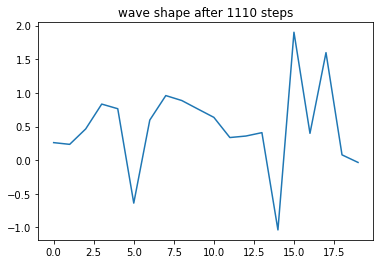

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1110/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1110/model_weights.tf
generator loss:1.9393218359334001
-----------------------
total discriminator loss:0.3648502892637021
average true return:0.4990491511365453
-----------------------


 71%|███████   | 1111/1562 [2:15:26<46:10,  6.14s/it]

Training Step: 1111
generator loss:1.8568289806309144
-----------------------
total discriminator loss:0.38836185986447874
average true return:0.4872310512795929
-----------------------


 71%|███████   | 1112/1562 [2:15:29<37:34,  5.01s/it]

Training Step: 1112
generator loss:1.8643558662959538
-----------------------


 71%|███████▏  | 1113/1562 [2:15:31<31:29,  4.21s/it]

total discriminator loss:0.402054007226174
average true return:0.5123951617321654
-----------------------
Training Step: 1113
generator loss:1.852544404748754
-----------------------
total discriminator loss:0.42406175455546535
average true return:0.5057543074081364
-----------------------


 71%|███████▏  | 1114/1562 [2:15:33<27:21,  3.66s/it]

Training Step: 1114
generator loss:1.886205252221552
-----------------------
total discriminator loss:0.4032141176611055
average true return:0.5030160832527151
-----------------------


 71%|███████▏  | 1115/1562 [2:15:36<24:23,  3.27s/it]

Training Step: 1115
event_types: [0, 2, 3, 2, 2, 3, 3, 2, 1, 0, 3, 3, 2, 0, 3, 2, 1, 0, 3, 2]
mad_score: 0.5834875
fid_score: 1051.0927889726868
rule_score: 0.18575


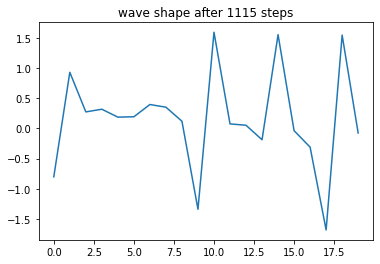

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1115/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1115/model_weights.tf
generator loss:1.9138783057787043
-----------------------
total discriminator loss:0.37067929213964634
average true return:0.5033109279123
-----------------------


 71%|███████▏  | 1116/1562 [2:15:50<48:14,  6.49s/it]

Training Step: 1116
generator loss:1.9397039511567895
-----------------------
total discriminator loss:0.41632519894954
average true return:0.4971486949049454
-----------------------


 72%|███████▏  | 1117/1562 [2:15:52<38:52,  5.24s/it]

Training Step: 1117
generator loss:2.033923179090787
-----------------------


 72%|███████▏  | 1118/1562 [2:15:54<32:11,  4.35s/it]

total discriminator loss:0.3820015856740684
average true return:0.4945788093949424
-----------------------
Training Step: 1118
generator loss:1.968577801102973
-----------------------


 72%|███████▏  | 1119/1562 [2:15:56<27:02,  3.66s/it]

total discriminator loss:0.4197061700299576
average true return:0.4809352465134374
-----------------------
Training Step: 1119
generator loss:1.9279888997745838
-----------------------


 72%|███████▏  | 1120/1562 [2:15:59<23:50,  3.24s/it]

total discriminator loss:0.40104162557514994
average true return:0.49128751553911987
-----------------------
Training Step: 1120
event_types: [2, 3, 3, 3, 2, 2, 2, 2, 2, 1, 0, 3, 2, 2, 3, 2, 1, 0, 3, 3]
mad_score: 0.5867875
fid_score: 673.2150685960453
rule_score: 0.20125


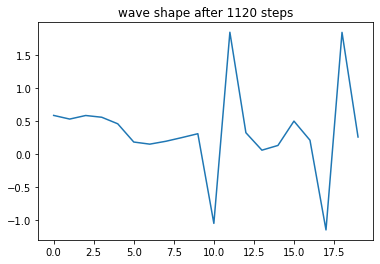

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1120/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1120/model_weights.tf
generator loss:1.7961792964668528
-----------------------
total discriminator loss:0.40787990077078734
average true return:0.48182486634780786
-----------------------


 72%|███████▏  | 1121/1562 [2:16:12<47:04,  6.40s/it]

Training Step: 1121
generator loss:1.8501017277387164
-----------------------
total discriminator loss:0.39370975577595635
average true return:0.5061830324872567
-----------------------


 72%|███████▏  | 1122/1562 [2:16:15<38:01,  5.18s/it]

Training Step: 1122
generator loss:1.881547008348888
-----------------------
total discriminator loss:0.37654277338756303
average true return:0.5118541176465434
-----------------------


 72%|███████▏  | 1123/1562 [2:16:17<31:42,  4.33s/it]

Training Step: 1123
generator loss:1.8210781115063042
-----------------------
total discriminator loss:0.41730733066787823
average true return:0.5130251529509684
-----------------------


 72%|███████▏  | 1124/1562 [2:16:19<27:13,  3.73s/it]

Training Step: 1124
generator loss:1.805800429184421
-----------------------
total discriminator loss:0.41067915842722336
average true return:0.48598107685170866
-----------------------


 72%|███████▏  | 1125/1562 [2:16:22<24:04,  3.31s/it]

Training Step: 1125
event_types: [3, 2, 1, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 0, 3, 2, 1, 1, 0, 3]
mad_score: 0.5892625
fid_score: 413.2247737751073
rule_score: 0.22875


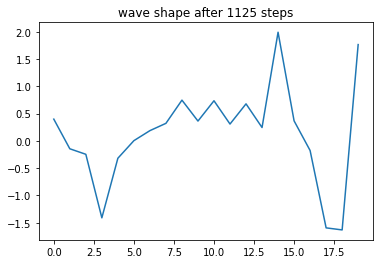

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1125/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1125/model_weights.tf
generator loss:1.8881300986789007
-----------------------
total discriminator loss:0.40819656155180173
average true return:0.4894980121547988
-----------------------


 72%|███████▏  | 1126/1562 [2:16:35<46:27,  6.39s/it]

Training Step: 1126
generator loss:1.9459981390046646
-----------------------
total discriminator loss:0.3944022355606328
average true return:0.49102423560993
-----------------------


 72%|███████▏  | 1127/1562 [2:16:38<37:33,  5.18s/it]

Training Step: 1127
generator loss:1.899483005994748
-----------------------
total discriminator loss:0.4048895091466471
average true return:0.4861081473799215
-----------------------


 72%|███████▏  | 1128/1562 [2:16:40<31:15,  4.32s/it]

Training Step: 1128
generator loss:1.953340648291339
-----------------------
total discriminator loss:0.40981730441209674
average true return:0.4571001911030454
-----------------------


 72%|███████▏  | 1129/1562 [2:16:42<26:56,  3.73s/it]

Training Step: 1129
generator loss:1.8888860243093681
-----------------------
total discriminator loss:0.40034586644086634
average true return:0.4837489762326819
-----------------------


 72%|███████▏  | 1130/1562 [2:16:45<23:49,  3.31s/it]

Training Step: 1130
event_types: [2, 2, 2, 2, 1, 2, 2, 3, 2, 1, 0, 3, 2, 2, 2, 1, 0, 3, 2, 1]
mad_score: 0.58895
fid_score: 334.1292761284113
rule_score: 0.22125


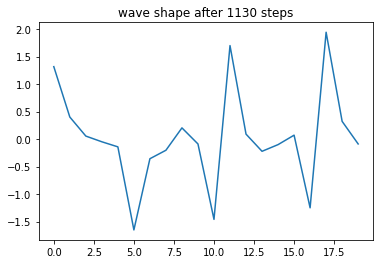

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1130/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1130/model_weights.tf
generator loss:1.856385370138627
-----------------------


 72%|███████▏  | 1131/1562 [2:16:58<46:01,  6.41s/it]

total discriminator loss:0.40994997050182314
average true return:0.5098017850074534
-----------------------
Training Step: 1131
generator loss:1.9977033354150286
-----------------------


 72%|███████▏  | 1132/1562 [2:17:00<36:21,  5.07s/it]

total discriminator loss:0.4253433098191686
average true return:0.47030719873593496
-----------------------
Training Step: 1132
generator loss:2.0171276253514674
-----------------------
total discriminator loss:0.4332083888158555
average true return:0.495250305775081
-----------------------


 73%|███████▎  | 1133/1562 [2:17:02<30:05,  4.21s/it]

Training Step: 1133
generator loss:1.8148710227614488
-----------------------
total discriminator loss:0.4032521343996491
average true return:0.48491387623103305
-----------------------


 73%|███████▎  | 1134/1562 [2:17:05<26:06,  3.66s/it]

Training Step: 1134
generator loss:1.9498451899984535
-----------------------
total discriminator loss:0.42336541270155503
average true return:0.4949365832942484
-----------------------


 73%|███████▎  | 1135/1562 [2:17:07<23:12,  3.26s/it]

Training Step: 1135
event_types: [2, 2, 2, 2, 3, 3, 2, 1, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2]
mad_score: 0.5906
fid_score: 348.9720650009542
rule_score: 0.22475


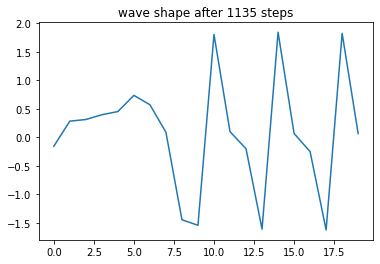

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1135/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1135/model_weights.tf
generator loss:1.9450684907036055
-----------------------
total discriminator loss:0.38314696306699625
average true return:0.4814039098783105
-----------------------


 73%|███████▎  | 1136/1562 [2:17:21<45:46,  6.45s/it]

Training Step: 1136
generator loss:1.9510432268053375
-----------------------
total discriminator loss:0.39441508768088274
average true return:0.485607872046517
-----------------------


 73%|███████▎  | 1137/1562 [2:17:23<37:00,  5.22s/it]

Training Step: 1137
generator loss:1.8082373924716086
-----------------------
total discriminator loss:0.3934182015938675
average true return:0.4970010184817831
-----------------------


 73%|███████▎  | 1138/1562 [2:17:26<30:52,  4.37s/it]

Training Step: 1138
generator loss:1.8427992188870546
-----------------------
total discriminator loss:0.3810921354582525
average true return:0.5110100245891765
-----------------------


 73%|███████▎  | 1139/1562 [2:17:28<26:37,  3.78s/it]

Training Step: 1139
generator loss:1.9896090216841187
-----------------------
total discriminator loss:0.38679744242023917
average true return:0.4820124089178734
-----------------------


 73%|███████▎  | 1140/1562 [2:17:31<23:31,  3.34s/it]

Training Step: 1140
event_types: [2, 3, 2, 2, 2, 3, 2, 3, 2, 0, 3, 2, 2, 0, 3, 2, 0, 3, 0, 2]
mad_score: 0.5934625
fid_score: 425.7117710183808
rule_score: 0.2145


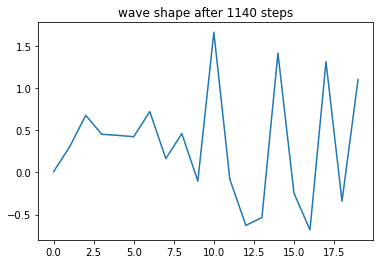

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1140/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1140/model_weights.tf
generator loss:2.0181394879152013
-----------------------
total discriminator loss:0.3866677571338829
average true return:0.5059272263749673
-----------------------


 73%|███████▎  | 1141/1562 [2:17:44<44:34,  6.35s/it]

Training Step: 1141
generator loss:1.9709389635897407
-----------------------
total discriminator loss:0.38245539225459163
average true return:0.4840708030235345
-----------------------


 73%|███████▎  | 1142/1562 [2:17:46<36:03,  5.15s/it]

Training Step: 1142
generator loss:2.0206884232355984
-----------------------
total discriminator loss:0.38393001662579374
average true return:0.4637997949890425
-----------------------


 73%|███████▎  | 1143/1562 [2:17:49<30:06,  4.31s/it]

Training Step: 1143
generator loss:1.9724593377875748
-----------------------
total discriminator loss:0.3583241987274998
average true return:0.4887855889509811
-----------------------


 73%|███████▎  | 1144/1562 [2:17:51<26:10,  3.76s/it]

Training Step: 1144
generator loss:1.9242224952540743
-----------------------
total discriminator loss:0.37304121780332045
average true return:0.49321964107688054
-----------------------


 73%|███████▎  | 1145/1562 [2:17:53<23:09,  3.33s/it]

Training Step: 1145
event_types: [1, 0, 1, 0, 2, 1, 0, 3, 1, 0, 2, 1, 0, 3, 1, 0, 3, 1, 0, 3]
mad_score: 0.5970875
fid_score: 514.3603548435863
rule_score: 0.202


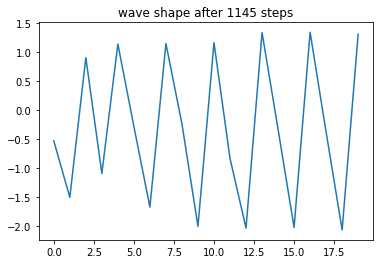

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1145/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1145/model_weights.tf
generator loss:2.045469593784306
-----------------------


 73%|███████▎  | 1146/1562 [2:18:06<42:50,  6.18s/it]

total discriminator loss:0.4280263591097112
average true return:0.5091333787843951
-----------------------
Training Step: 1146
generator loss:2.1065028804758876
-----------------------
total discriminator loss:0.37413862855515767
average true return:0.45679665221943455
-----------------------


 73%|███████▎  | 1147/1562 [2:18:09<34:45,  5.03s/it]

Training Step: 1147
generator loss:2.092251403539037
-----------------------
total discriminator loss:1.6653263796567992
average true return:0.46362953728731937
-----------------------


 73%|███████▎  | 1148/1562 [2:18:11<29:10,  4.23s/it]

Training Step: 1148
generator loss:1.8256203507511355
-----------------------
total discriminator loss:0.37643010255033155
average true return:0.5102536051864462
-----------------------


 74%|███████▎  | 1149/1562 [2:18:13<25:15,  3.67s/it]

Training Step: 1149
generator loss:1.7817217773242333
-----------------------
total discriminator loss:0.4086419735254363
average true return:0.5126763764271434
-----------------------


 74%|███████▎  | 1150/1562 [2:18:16<22:26,  3.27s/it]

Training Step: 1150
event_types: [2, 0, 2, 2, 3, 1, 0, 3, 2, 1, 0, 2, 0, 3, 1, 0, 3, 1, 0, 3]
mad_score: 0.6053125
fid_score: 632.8137168388059
rule_score: 0.18075


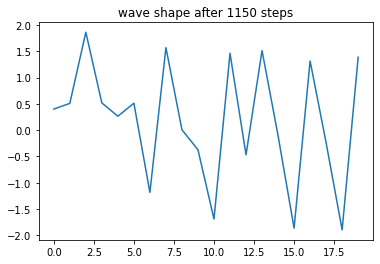

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1150/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1150/model_weights.tf
generator loss:1.5887723756814154
-----------------------
total discriminator loss:0.3891365904033025
average true return:0.5289822656657277
-----------------------


 74%|███████▎  | 1151/1562 [2:18:29<43:55,  6.41s/it]

Training Step: 1151
generator loss:1.5672836262634415
-----------------------
total discriminator loss:0.4003125095895534
average true return:0.5352407308647946
-----------------------


 74%|███████▍  | 1152/1562 [2:18:32<35:28,  5.19s/it]

Training Step: 1152
generator loss:1.633436863609799
-----------------------
total discriminator loss:0.40733114859868697
average true return:0.5268423234862243
-----------------------


 74%|███████▍  | 1153/1562 [2:18:34<29:35,  4.34s/it]

Training Step: 1153
generator loss:1.6795508508476098
-----------------------


 74%|███████▍  | 1154/1562 [2:18:36<24:54,  3.66s/it]

total discriminator loss:0.39107214152650355
average true return:0.5028800755237164
-----------------------
Training Step: 1154
generator loss:1.7659917841522659
-----------------------
total discriminator loss:0.4287098726207747
average true return:0.45663462094004104
-----------------------


 74%|███████▍  | 1155/1562 [2:18:39<22:16,  3.28s/it]

Training Step: 1155
event_types: [2, 0, 2, 3, 1, 0, 3, 2, 1, 0, 2, 1, 0, 2, 2, 3, 2, 3, 2, 1]
mad_score: 0.5994625
fid_score: 651.3746856990895
rule_score: 0.1895


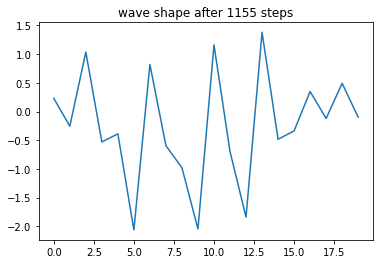

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1155/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1155/model_weights.tf
generator loss:1.7339858575040805
-----------------------
total discriminator loss:0.3758666020965612
average true return:0.5006076772297975
-----------------------


 74%|███████▍  | 1156/1562 [2:18:53<43:48,  6.47s/it]

Training Step: 1156
generator loss:1.6206269271389107
-----------------------
total discriminator loss:0.42092675299957594
average true return:0.5269973627960067
-----------------------


 74%|███████▍  | 1157/1562 [2:18:55<35:20,  5.24s/it]

Training Step: 1157
generator loss:1.6714279166749808
-----------------------
total discriminator loss:0.39697815549984705
average true return:0.5246925027498945
-----------------------


 74%|███████▍  | 1158/1562 [2:18:57<29:24,  4.37s/it]

Training Step: 1158
generator loss:1.7410965749064913
-----------------------
total discriminator loss:0.39061088324407445
average true return:0.4934155289946409
-----------------------


 74%|███████▍  | 1159/1562 [2:19:00<25:11,  3.75s/it]

Training Step: 1159
generator loss:1.9015880035080588
-----------------------
total discriminator loss:0.4061920183080934
average true return:0.4669817781291884
-----------------------


 74%|███████▍  | 1160/1562 [2:19:02<22:18,  3.33s/it]

Training Step: 1160
event_types: [3, 2, 2, 2, 2, 1, 0, 2, 1, 0, 3, 2, 0, 3, 2, 1, 0, 3, 2, 1]
mad_score: 0.5930625
fid_score: 617.0274002173435
rule_score: 0.18475


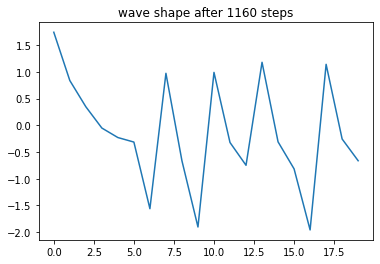

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1160/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1160/model_weights.tf
generator loss:1.9190138670415733
-----------------------
total discriminator loss:0.3830524653276036
average true return:0.4778197881704752
-----------------------


 74%|███████▍  | 1161/1562 [2:19:15<41:29,  6.21s/it]

Training Step: 1161
generator loss:1.9754812119005767
-----------------------
total discriminator loss:0.3654621326633898
average true return:0.47494915065087706
-----------------------


 74%|███████▍  | 1162/1562 [2:19:17<33:37,  5.04s/it]

Training Step: 1162
generator loss:1.9544922806763045
-----------------------
total discriminator loss:0.3926313783328138
average true return:0.4976991750833944
-----------------------


 74%|███████▍  | 1163/1562 [2:19:19<28:12,  4.24s/it]

Training Step: 1163
generator loss:2.0565282127182827
-----------------------
total discriminator loss:0.36359803744888475
average true return:0.4748047715801193
-----------------------


 75%|███████▍  | 1164/1562 [2:19:22<24:20,  3.67s/it]

Training Step: 1164
generator loss:2.00343463894478
-----------------------
total discriminator loss:0.3945824913311662
average true return:0.48375973268011585
-----------------------


 75%|███████▍  | 1165/1562 [2:19:24<21:38,  3.27s/it]

Training Step: 1165
event_types: [2, 0, 3, 2, 0, 2, 0, 1, 0, 3, 1, 0, 2, 0, 3, 2, 0, 2, 2, 1]
mad_score: 0.59325
fid_score: 631.2703768348507
rule_score: 0.19875


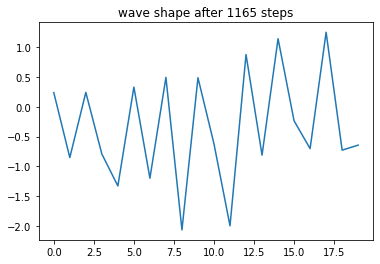

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1165/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1165/model_weights.tf
generator loss:2.1625072616380283
-----------------------
total discriminator loss:0.4006680604404407
average true return:0.45978572802100925
-----------------------


 75%|███████▍  | 1166/1562 [2:19:38<42:49,  6.49s/it]

Training Step: 1166
generator loss:2.024093094926538
-----------------------


 75%|███████▍  | 1167/1562 [2:19:40<34:04,  5.18s/it]

total discriminator loss:0.3720732442288883
average true return:0.4805433488816514
-----------------------
Training Step: 1167
generator loss:1.975740877665938
-----------------------
total discriminator loss:0.39156680041025543
average true return:0.48872134140002454
-----------------------


 75%|███████▍  | 1168/1562 [2:19:42<27:46,  4.23s/it]

Training Step: 1168
generator loss:1.9923339018527464
-----------------------
total discriminator loss:0.3885020282847006
average true return:0.4872739706283632
-----------------------


 75%|███████▍  | 1169/1562 [2:19:45<24:06,  3.68s/it]

Training Step: 1169
generator loss:1.8859163914942743
-----------------------
total discriminator loss:0.3674538972125785
average true return:0.48681637084702845
-----------------------


 75%|███████▍  | 1170/1562 [2:19:47<21:27,  3.28s/it]

Training Step: 1170
event_types: [0, 2, 2, 1, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 0, 2, 3, 1, 0, 3]
mad_score: 0.5952875
fid_score: 685.8958448169178
rule_score: 0.18875


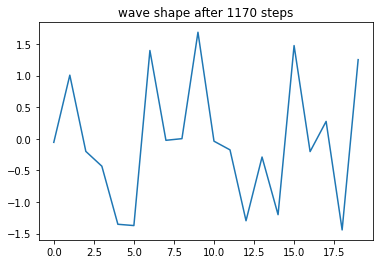

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1170/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1170/model_weights.tf
generator loss:1.883458264902997
-----------------------
total discriminator loss:1.6753267925425845
average true return:0.5059874515491909
-----------------------


 75%|███████▍  | 1171/1562 [2:20:01<41:38,  6.39s/it]

Training Step: 1171
generator loss:1.3788326637044144
-----------------------
total discriminator loss:0.435683988040623
average true return:0.5999567313399694
-----------------------


 75%|███████▌  | 1172/1562 [2:20:03<33:39,  5.18s/it]

Training Step: 1172
generator loss:1.5666834761290522
-----------------------
total discriminator loss:0.41580300134723125
average true return:0.5713899355564516
-----------------------


 75%|███████▌  | 1173/1562 [2:20:05<28:04,  4.33s/it]

Training Step: 1173
generator loss:1.84532781907979
-----------------------


 75%|███████▌  | 1174/1562 [2:20:08<24:04,  3.72s/it]

total discriminator loss:0.3977723893597621
average true return:0.4945604215455503
-----------------------
Training Step: 1174
generator loss:2.2430835240907636
-----------------------
total discriminator loss:0.42850981294520657
average true return:0.4022176982439938
-----------------------


 75%|███████▌  | 1175/1562 [2:20:10<21:17,  3.30s/it]

Training Step: 1175
event_types: [2, 3, 0, 1, 0, 3, 1, 0, 3, 1, 0, 2, 2, 0, 3, 2, 1, 0, 3, 2]
mad_score: 0.6039125
fid_score: 695.1897666227607
rule_score: 0.18475


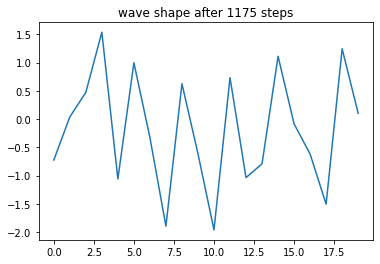

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1175/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1175/model_weights.tf
generator loss:2.213203093932681
-----------------------
total discriminator loss:0.3898119220133178
average true return:0.4148396522096355
-----------------------


 75%|███████▌  | 1176/1562 [2:20:23<39:48,  6.19s/it]

Training Step: 1176
generator loss:1.7567214507596445
-----------------------
total discriminator loss:0.379457680723985
average true return:0.5026437244376784
-----------------------


 75%|███████▌  | 1177/1562 [2:20:25<32:16,  5.03s/it]

Training Step: 1177
generator loss:1.4546520779387888
-----------------------
total discriminator loss:0.4459638094513014
average true return:0.5587178855975108
-----------------------


 75%|███████▌  | 1178/1562 [2:20:28<27:06,  4.23s/it]

Training Step: 1178
generator loss:1.5293937947332457
-----------------------
total discriminator loss:0.4238324162410304
average true return:0.5528569317806213
-----------------------


 75%|███████▌  | 1179/1562 [2:20:30<23:28,  3.68s/it]

Training Step: 1179
generator loss:1.9754550539515139
-----------------------
total discriminator loss:0.3855270331343796
average true return:0.4648365214206427
-----------------------


 76%|███████▌  | 1180/1562 [2:20:32<20:53,  3.28s/it]

Training Step: 1180
event_types: [0, 3, 2, 1, 0, 2, 2, 1, 1, 0, 3, 3, 2, 1, 1, 0, 3, 2, 3, 2]
mad_score: 0.6029
fid_score: 761.2755110101198
rule_score: 0.2025


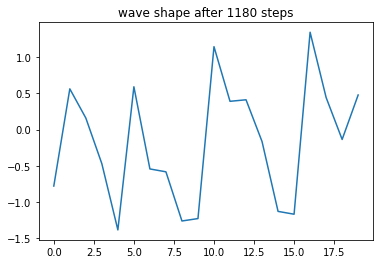

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1180/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1180/model_weights.tf
generator loss:2.36525530644689
-----------------------
total discriminator loss:0.4016182225672473
average true return:0.40727837568544056
-----------------------


 76%|███████▌  | 1181/1562 [2:20:46<40:10,  6.33s/it]

Training Step: 1181
generator loss:2.2391606525915
-----------------------
total discriminator loss:0.404350049372331
average true return:0.4164244628522495
-----------------------


 76%|███████▌  | 1182/1562 [2:20:48<32:51,  5.19s/it]

Training Step: 1182
generator loss:1.741469602943196
-----------------------
total discriminator loss:0.4175886055963751
average true return:0.504755082354756
-----------------------


 76%|███████▌  | 1183/1562 [2:20:51<27:23,  4.34s/it]

Training Step: 1183
generator loss:1.6298822362157206
-----------------------
total discriminator loss:0.42857132048515584
average true return:0.553335813299433
-----------------------


 76%|███████▌  | 1184/1562 [2:20:53<23:33,  3.74s/it]

Training Step: 1184
generator loss:1.5980841586804857
-----------------------
total discriminator loss:0.39857830809198724
average true return:0.536334880630958
-----------------------


 76%|███████▌  | 1185/1562 [2:20:55<20:55,  3.33s/it]

Training Step: 1185
event_types: [2, 3, 2, 2, 1, 2, 1, 0, 3, 2, 2, 1, 0, 3, 2, 3, 2, 1, 1, 0]
mad_score: 0.6088
fid_score: 816.3175077280725
rule_score: 0.21375


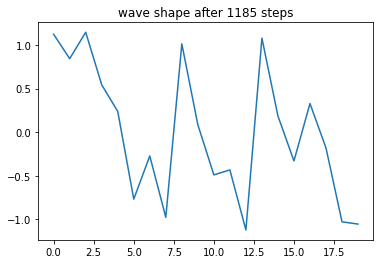

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1185/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1185/model_weights.tf
generator loss:2.0571346328880225
-----------------------
total discriminator loss:0.4251345448854693
average true return:0.44803631919149656
-----------------------


 76%|███████▌  | 1186/1562 [2:21:09<40:19,  6.44s/it]

Training Step: 1186
generator loss:2.2242887104207925
-----------------------
total discriminator loss:0.40197270885066594
average true return:0.4182421952334469
-----------------------


 76%|███████▌  | 1187/1562 [2:21:11<32:28,  5.20s/it]

Training Step: 1187
generator loss:1.9458416141941566
-----------------------
total discriminator loss:0.41975184576341684
average true return:0.4565778554692711
-----------------------


 76%|███████▌  | 1188/1562 [2:21:14<27:05,  4.34s/it]

Training Step: 1188
generator loss:1.6593770406427215
-----------------------


 76%|███████▌  | 1189/1562 [2:21:16<23:05,  3.71s/it]

total discriminator loss:0.4024639971650573
average true return:0.5244913199134125
-----------------------
Training Step: 1189
generator loss:1.4582023848354813
-----------------------


 76%|███████▌  | 1190/1562 [2:21:18<19:45,  3.19s/it]

total discriminator loss:0.42291466989917254
average true return:0.5448117027009896
-----------------------
Training Step: 1190
event_types: [2, 2, 2, 1, 0, 2, 2, 1, 0, 2, 2, 0, 3, 2, 0, 0, 2, 2, 0, 2]
mad_score: 0.613775
fid_score: 897.7699900262821
rule_score: 0.224


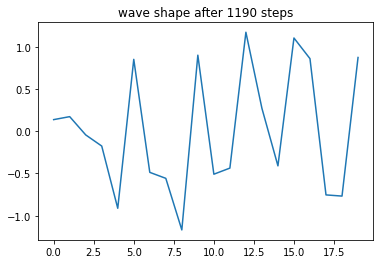

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1190/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1190/model_weights.tf
generator loss:1.5876486469214608
-----------------------
total discriminator loss:0.43271619916386367
average true return:0.5434981017633058
-----------------------


 76%|███████▌  | 1191/1562 [2:21:32<39:01,  6.31s/it]

Training Step: 1191
generator loss:1.8979554830864893
-----------------------
total discriminator loss:0.3989247115948897
average true return:0.47581293381970624
-----------------------


 76%|███████▋  | 1192/1562 [2:21:34<31:35,  5.12s/it]

Training Step: 1192
generator loss:2.2331745201226916
-----------------------
total discriminator loss:0.3818108253070983
average true return:0.44017430584526374
-----------------------


 76%|███████▋  | 1193/1562 [2:21:36<26:42,  4.34s/it]

Training Step: 1193
generator loss:2.166593932402236
-----------------------
total discriminator loss:0.39987797564872335
average true return:0.4301059417480847
-----------------------


 76%|███████▋  | 1194/1562 [2:21:39<23:21,  3.81s/it]

Training Step: 1194
generator loss:1.8411681838903151
-----------------------
total discriminator loss:0.3907879477807221
average true return:0.4936433387371101
-----------------------


 77%|███████▋  | 1195/1562 [2:21:41<20:36,  3.37s/it]

Training Step: 1195
event_types: [2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 0, 3, 2, 0, 2, 2, 1, 0, 2, 1]
mad_score: 0.6186
fid_score: 991.0891145830738
rule_score: 0.2405


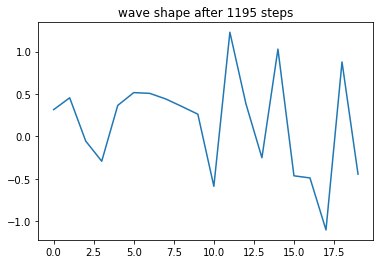

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1195/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1195/model_weights.tf
generator loss:1.5442952184034904
-----------------------
total discriminator loss:0.3964694571532328
average true return:0.5544719153767108
-----------------------


 77%|███████▋  | 1196/1562 [2:21:54<37:49,  6.20s/it]

Training Step: 1196
generator loss:1.5180830947860111
-----------------------
total discriminator loss:0.39372826488785917
average true return:0.5425618443073477
-----------------------


 77%|███████▋  | 1197/1562 [2:21:56<30:42,  5.05s/it]

Training Step: 1197
generator loss:1.674869026694464
-----------------------
total discriminator loss:0.3669949951710756
average true return:0.5115044129811048
-----------------------


 77%|███████▋  | 1198/1562 [2:21:59<25:42,  4.24s/it]

Training Step: 1198
generator loss:1.8697119324701377
-----------------------


 77%|███████▋  | 1199/1562 [2:22:01<22:13,  3.67s/it]

total discriminator loss:0.36975531739902395
average true return:0.4911737593884018
-----------------------
Training Step: 1199
generator loss:2.081525180118242
-----------------------
total discriminator loss:0.38674810436716367
average true return:0.47291569627496544
-----------------------


 77%|███████▋  | 1200/1562 [2:22:04<19:48,  3.28s/it]

Training Step: 1200
event_types: [2, 2, 2, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 2, 0, 3, 2, 1, 0, 3]
mad_score: 0.622275
fid_score: 1065.7498293545361
rule_score: 0.2665


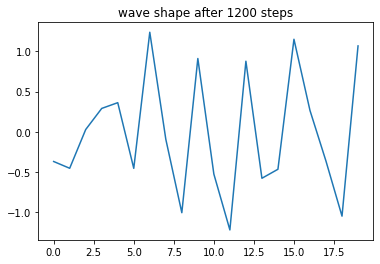

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1200/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1200/model_weights.tf
generator loss:2.101793219991098
-----------------------
total discriminator loss:0.37647233706552374
average true return:0.4595909026589915
-----------------------


 77%|███████▋  | 1201/1562 [2:22:17<38:32,  6.41s/it]

Training Step: 1201
generator loss:2.0614379968363794
-----------------------
total discriminator loss:0.36277322229242287
average true return:0.46773168914347574
-----------------------


 77%|███████▋  | 1202/1562 [2:22:20<31:07,  5.19s/it]

Training Step: 1202
generator loss:1.8111229339287345
-----------------------


 77%|███████▋  | 1203/1562 [2:22:22<25:16,  4.22s/it]

total discriminator loss:1.7462892524887743
average true return:0.5048949724885786
-----------------------
Training Step: 1203
generator loss:1.4426750382584208
-----------------------


 77%|███████▋  | 1204/1562 [2:22:24<21:29,  3.60s/it]

total discriminator loss:0.4147996673855103
average true return:0.5716718859349247
-----------------------
Training Step: 1204
generator loss:1.430615423922829
-----------------------
total discriminator loss:0.41027417671637445
average true return:0.6049860861483485
-----------------------


 77%|███████▋  | 1205/1562 [2:22:26<19:13,  3.23s/it]

Training Step: 1205
event_types: [0, 2, 2, 2, 0, 2, 2, 0, 3, 1, 0, 3, 2, 0, 2, 2, 1, 0, 3, 2]
mad_score: 0.62475
fid_score: 1202.3135972405555
rule_score: 0.2865


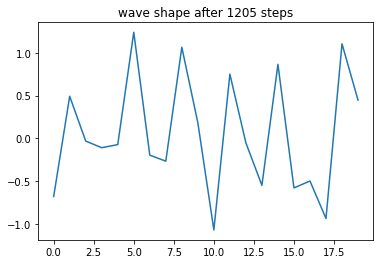

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1205/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1205/model_weights.tf
generator loss:1.481067388873639
-----------------------
total discriminator loss:0.3964071023523162
average true return:0.543604606513344
-----------------------


 77%|███████▋  | 1206/1562 [2:22:40<38:10,  6.43s/it]

Training Step: 1206
generator loss:1.563687645203129
-----------------------
total discriminator loss:0.3984567505489366
average true return:0.5442364518706263
-----------------------


 77%|███████▋  | 1207/1562 [2:22:42<30:48,  5.21s/it]

Training Step: 1207
generator loss:1.6435893220680495
-----------------------
total discriminator loss:0.4106851482773274
average true return:0.4770953035258941
-----------------------


 77%|███████▋  | 1208/1562 [2:22:45<25:40,  4.35s/it]

Training Step: 1208
generator loss:1.7269180028761832
-----------------------
total discriminator loss:0.3901310016867387
average true return:0.4580379984868277
-----------------------


 77%|███████▋  | 1209/1562 [2:22:47<22:01,  3.74s/it]

Training Step: 1209
generator loss:1.74034805320936
-----------------------
total discriminator loss:0.40667960046376783
average true return:0.46497347522125254
-----------------------


 77%|███████▋  | 1210/1562 [2:22:49<19:28,  3.32s/it]

Training Step: 1210
event_types: [2, 1, 2, 0, 3, 2, 1, 0, 3, 2, 1, 1, 0, 3, 3, 2, 1, 0, 3, 2]
mad_score: 0.6281875
fid_score: 1200.6692473446697
rule_score: 0.2885


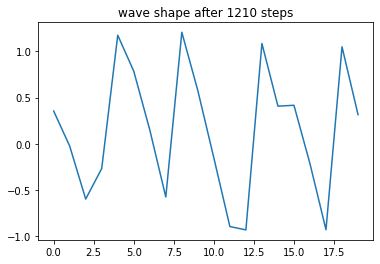

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1210/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1210/model_weights.tf
generator loss:1.6966142723544775
-----------------------


 78%|███████▊  | 1211/1562 [2:23:03<37:08,  6.35s/it]

total discriminator loss:0.3674614452210599
average true return:0.5081323468237615
-----------------------
Training Step: 1211
generator loss:1.5498157252602076
-----------------------
total discriminator loss:0.3841088309011314
average true return:0.5601106485400198
-----------------------


 78%|███████▊  | 1212/1562 [2:23:05<30:02,  5.15s/it]

Training Step: 1212
generator loss:1.5417673685973439
-----------------------
total discriminator loss:0.37965139109880663
average true return:0.560524170212132
-----------------------


 78%|███████▊  | 1213/1562 [2:23:07<25:01,  4.30s/it]

Training Step: 1213
generator loss:1.604137945645467
-----------------------
total discriminator loss:0.3693387250563805
average true return:0.5212046422423877
-----------------------


 78%|███████▊  | 1214/1562 [2:23:10<21:34,  3.72s/it]

Training Step: 1214
generator loss:1.7444150809297476
-----------------------
total discriminator loss:0.3664163720302226
average true return:0.4985970894395141
-----------------------


 78%|███████▊  | 1215/1562 [2:23:12<19:08,  3.31s/it]

Training Step: 1215
event_types: [0, 2, 2, 2, 0, 2, 1, 0, 3, 1, 1, 0, 2, 3, 1, 0, 2, 2, 0, 3]
mad_score: 0.62915
fid_score: 1175.6015363783554
rule_score: 0.29375


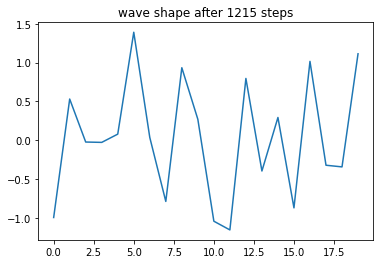

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1215/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1215/model_weights.tf
generator loss:1.8338458794540973
-----------------------


 78%|███████▊  | 1216/1562 [2:23:26<36:35,  6.34s/it]

total discriminator loss:0.35215720702010234
average true return:0.499406405104539
-----------------------
Training Step: 1216
generator loss:1.882274646939277
-----------------------
total discriminator loss:0.36452714874197945
average true return:0.47648546698169514
-----------------------


 78%|███████▊  | 1217/1562 [2:23:28<29:07,  5.06s/it]

Training Step: 1217
generator loss:2.0140076522042016
-----------------------
total discriminator loss:0.3630482299033522
average true return:0.47353562913590647
-----------------------


 78%|███████▊  | 1218/1562 [2:23:30<24:15,  4.23s/it]

Training Step: 1218
generator loss:1.9814006447138015
-----------------------
total discriminator loss:0.36742685445485423
average true return:0.45706053683416836
-----------------------


 78%|███████▊  | 1219/1562 [2:23:32<21:07,  3.70s/it]

Training Step: 1219
generator loss:1.902847110208393
-----------------------
total discriminator loss:0.38452456094771004
average true return:0.5027156285987259
-----------------------


 78%|███████▊  | 1220/1562 [2:23:35<18:45,  3.29s/it]

Training Step: 1220
event_types: [1, 0, 2, 1, 0, 3, 2, 2, 1, 1, 0, 3, 2, 2, 0, 2, 2, 1, 0, 2]
mad_score: 0.628175
fid_score: 1078.9069919579365
rule_score: 0.297


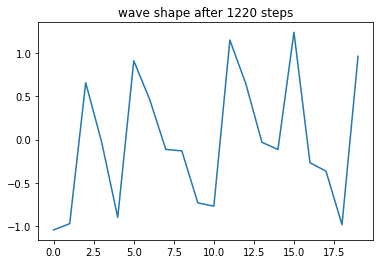

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1220/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1220/model_weights.tf
generator loss:1.7959421270731601
-----------------------
total discriminator loss:1.679035873585267
average true return:0.4999536660863914
-----------------------


 78%|███████▊  | 1221/1562 [2:23:49<37:00,  6.51s/it]

Training Step: 1221
generator loss:1.6741318147572053
-----------------------
total discriminator loss:0.39588126200699547
average true return:0.5383204060377949
-----------------------


 78%|███████▊  | 1222/1562 [2:23:51<29:48,  5.26s/it]

Training Step: 1222
generator loss:1.609962716488522
-----------------------
total discriminator loss:0.39351489534311757
average true return:0.5364865182405888
-----------------------


 78%|███████▊  | 1223/1562 [2:23:53<24:45,  4.38s/it]

Training Step: 1223
generator loss:1.7167581327702413
-----------------------
total discriminator loss:0.41333583871555984
average true return:0.528149767096318
-----------------------


 78%|███████▊  | 1224/1562 [2:23:56<21:12,  3.77s/it]

Training Step: 1224
generator loss:1.851012949351428
-----------------------


 78%|███████▊  | 1225/1562 [2:23:58<18:19,  3.26s/it]

total discriminator loss:0.40365527638453724
average true return:0.48292903438382284
-----------------------
Training Step: 1225
event_types: [2, 2, 2, 0, 3, 2, 2, 1, 0, 3, 2, 1, 0, 3, 2, 2, 1, 0, 3, 2]
mad_score: 0.6295125
fid_score: 950.5969396168182
rule_score: 0.269


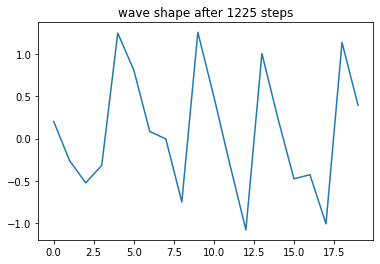

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1225/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1225/model_weights.tf
generator loss:1.8945222487636189
-----------------------
total discriminator loss:0.3715370927702313
average true return:0.46696408408609935
-----------------------


 78%|███████▊  | 1226/1562 [2:24:11<35:10,  6.28s/it]

Training Step: 1226
generator loss:1.9278800678284647
-----------------------
total discriminator loss:0.39422381107772
average true return:0.46951936804263966
-----------------------


 79%|███████▊  | 1227/1562 [2:24:14<28:26,  5.09s/it]

Training Step: 1227
generator loss:1.8293356277338937
-----------------------
total discriminator loss:0.3743525174972031
average true return:0.48214661347117843
-----------------------


 79%|███████▊  | 1228/1562 [2:24:16<23:46,  4.27s/it]

Training Step: 1228
generator loss:1.7434555683515707
-----------------------


 79%|███████▊  | 1229/1562 [2:24:18<20:28,  3.69s/it]

total discriminator loss:0.38573310072359585
average true return:0.5080264613219954
-----------------------
Training Step: 1229
generator loss:1.7030855598600652
-----------------------
total discriminator loss:0.38421134876444085
average true return:0.49731702811224676
-----------------------


 79%|███████▊  | 1230/1562 [2:24:21<18:15,  3.30s/it]

Training Step: 1230
event_types: [1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 2, 1, 2, 0, 3, 2, 0, 3, 2, 1]
mad_score: 0.6254875
fid_score: 858.3324984573387
rule_score: 0.2605


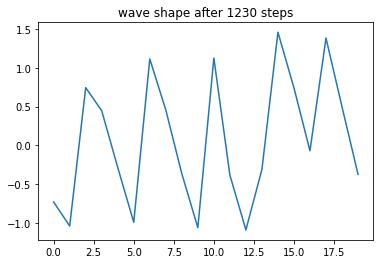

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1230/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1230/model_weights.tf
generator loss:1.7365300807923507
-----------------------


 79%|███████▉  | 1231/1562 [2:24:33<33:50,  6.14s/it]

total discriminator loss:0.35947043096066444
average true return:0.502533042494461
-----------------------
Training Step: 1231
generator loss:1.6362570534093597
-----------------------
total discriminator loss:0.3872083056019661
average true return:0.49263784614287914
-----------------------


 79%|███████▉  | 1232/1562 [2:24:36<27:32,  5.01s/it]

Training Step: 1232
generator loss:1.7078246244573982
-----------------------
total discriminator loss:0.3924738339273911
average true return:0.5161163403661833
-----------------------


 79%|███████▉  | 1233/1562 [2:24:38<23:05,  4.21s/it]

Training Step: 1233
generator loss:1.697187243960756
-----------------------
total discriminator loss:0.4218196311230894
average true return:0.5080044479935628
-----------------------


 79%|███████▉  | 1234/1562 [2:24:40<20:01,  3.66s/it]

Training Step: 1234
generator loss:1.732745722576682
-----------------------
total discriminator loss:0.3868956038364327
average true return:0.49775994835416515
-----------------------


 79%|███████▉  | 1235/1562 [2:24:43<17:47,  3.26s/it]

Training Step: 1235
event_types: [0, 3, 2, 1, 1, 0, 2, 1, 0, 3, 2, 1, 0, 3, 1, 0, 3, 2, 2, 1]
mad_score: 0.6221875
fid_score: 765.7194647738997
rule_score: 0.2605


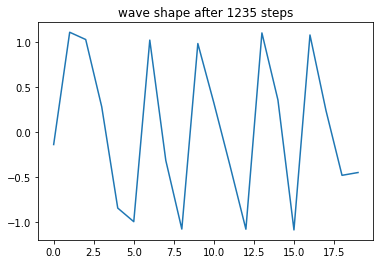

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1235/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1235/model_weights.tf
generator loss:1.7690187482729716
-----------------------
total discriminator loss:0.36728238001757796
average true return:0.5057367617698798
-----------------------


 79%|███████▉  | 1236/1562 [2:24:57<34:51,  6.41s/it]

Training Step: 1236
generator loss:1.7795075519469203
-----------------------
total discriminator loss:0.3754448271745323
average true return:0.4963634657486661
-----------------------


 79%|███████▉  | 1237/1562 [2:24:59<28:07,  5.19s/it]

Training Step: 1237
generator loss:1.8146020752806902
-----------------------


 79%|███████▉  | 1238/1562 [2:25:01<23:09,  4.29s/it]

total discriminator loss:0.38750655664907663
average true return:0.5000325550363687
-----------------------
Training Step: 1238
generator loss:1.7201252560504825
-----------------------


 79%|███████▉  | 1239/1562 [2:25:03<19:18,  3.59s/it]

total discriminator loss:0.38481104176001024
average true return:0.510009661144887
-----------------------
Training Step: 1239
generator loss:1.759542759039499
-----------------------
total discriminator loss:0.4215005545292684
average true return:0.5158101183962174
-----------------------


 79%|███████▉  | 1240/1562 [2:25:05<17:14,  3.21s/it]

Training Step: 1240
event_types: [2, 2, 2, 1, 1, 0, 3, 2, 2, 0, 3, 2, 1, 1, 0, 1, 0, 3, 2, 1]
mad_score: 0.6181625
fid_score: 664.1389682729612
rule_score: 0.2495


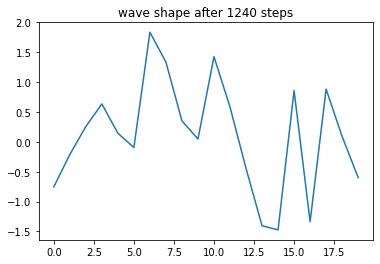

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1240/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1240/model_weights.tf
generator loss:1.7485779400479398
-----------------------
total discriminator loss:0.38672544620927646
average true return:0.5178382921030551
-----------------------


 79%|███████▉  | 1241/1562 [2:25:20<34:47,  6.50s/it]

Training Step: 1241
generator loss:1.799844002125096
-----------------------
total discriminator loss:0.4040443505417239
average true return:0.4903668693204639
-----------------------


 80%|███████▉  | 1242/1562 [2:25:22<28:01,  5.26s/it]

Training Step: 1242
generator loss:1.9316677232345172
-----------------------
total discriminator loss:0.3826912460734876
average true return:0.4701573424563986
-----------------------


 80%|███████▉  | 1243/1562 [2:25:24<23:19,  4.39s/it]

Training Step: 1243
generator loss:1.875961252434108
-----------------------
total discriminator loss:0.3887190129983235
average true return:0.4906445631267641
-----------------------


 80%|███████▉  | 1244/1562 [2:25:27<20:12,  3.81s/it]

Training Step: 1244
generator loss:1.807179566363987
-----------------------
total discriminator loss:0.3944319719451701
average true return:0.5184785150541836
-----------------------


 80%|███████▉  | 1245/1562 [2:25:29<17:48,  3.37s/it]

Training Step: 1245
event_types: [0, 2, 1, 0, 2, 2, 0, 2, 1, 0, 3, 2, 1, 0, 2, 0, 2, 1, 0, 2]
mad_score: 0.6152
fid_score: 666.3850805243906
rule_score: 0.2335


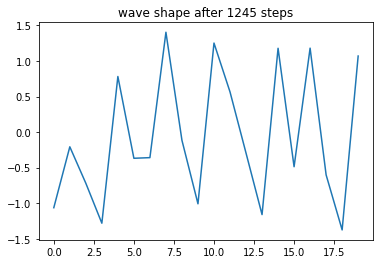

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1245/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1245/model_weights.tf
generator loss:1.76023452968907
-----------------------
total discriminator loss:0.37463151506196785
average true return:0.5343156508805988
-----------------------


 80%|███████▉  | 1246/1562 [2:25:43<33:47,  6.41s/it]

Training Step: 1246
generator loss:1.77970082882838
-----------------------
total discriminator loss:0.3899889258542112
average true return:0.514360355231097
-----------------------


 80%|███████▉  | 1247/1562 [2:25:45<27:18,  5.20s/it]

Training Step: 1247
generator loss:1.9108341706074528
-----------------------
total discriminator loss:0.4004598026124221
average true return:0.49566910279189547
-----------------------


 80%|███████▉  | 1248/1562 [2:25:47<22:43,  4.34s/it]

Training Step: 1248
generator loss:1.9602324289393505
-----------------------
total discriminator loss:0.3808331881129172
average true return:0.47950698424222227
-----------------------


 80%|███████▉  | 1249/1562 [2:25:50<19:31,  3.74s/it]

Training Step: 1249
generator loss:1.9609742758818083
-----------------------
total discriminator loss:0.41404520892343344
average true return:0.4721014346956465
-----------------------


 80%|████████  | 1250/1562 [2:25:52<17:19,  3.33s/it]

Training Step: 1250
event_types: [3, 3, 2, 2, 1, 1, 1, 0, 3, 3, 2, 1, 0, 2, 1, 0, 2, 2, 3, 1]
mad_score: 0.61355
fid_score: 669.7752412613867
rule_score: 0.21225


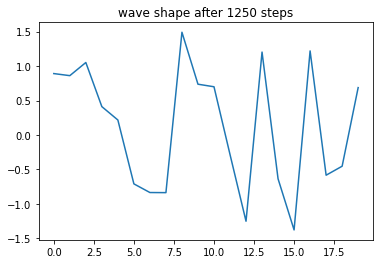

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1250/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1250/model_weights.tf
generator loss:1.8152913121774072
-----------------------


 80%|████████  | 1251/1562 [2:26:06<33:09,  6.40s/it]

total discriminator loss:0.3929150989275604
average true return:0.5165725087346202
-----------------------
Training Step: 1251
generator loss:1.7991163124901755
-----------------------


 80%|████████  | 1252/1562 [2:26:07<26:10,  5.06s/it]

total discriminator loss:0.37736425478546665
average true return:0.5151937949114975
-----------------------
Training Step: 1252
generator loss:1.851212139049903
-----------------------
total discriminator loss:0.3826829900233433
average true return:0.49769333969329943
-----------------------


 80%|████████  | 1253/1562 [2:26:10<21:47,  4.23s/it]

Training Step: 1253
generator loss:1.9012070868817976
-----------------------
total discriminator loss:0.3937210513464917
average true return:0.4963372099018676
-----------------------


 80%|████████  | 1254/1562 [2:26:12<18:49,  3.67s/it]

Training Step: 1254
generator loss:1.9379106984666383
-----------------------


 80%|████████  | 1255/1562 [2:26:14<16:42,  3.27s/it]

total discriminator loss:0.3943647554007959
average true return:0.4957994360778351
-----------------------
Training Step: 1255
event_types: [2, 0, 2, 1, 1, 1, 0, 3, 2, 2, 1, 0, 3, 2, 1, 0, 3, 2, 2, 0]
mad_score: 0.6088875
fid_score: 657.3610155702338
rule_score: 0.21075


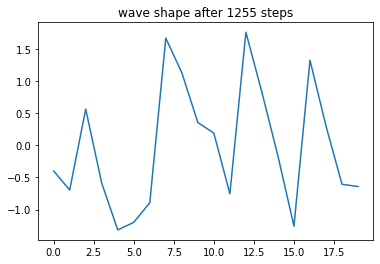

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1255/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1255/model_weights.tf
generator loss:1.9578027690894395
-----------------------
total discriminator loss:0.37921891956368786
average true return:0.5046873255415849
-----------------------


 80%|████████  | 1256/1562 [2:26:32<38:05,  7.47s/it]

Training Step: 1256
generator loss:2.055763211357058
-----------------------
total discriminator loss:0.3749424385807377
average true return:0.4813932127307904
-----------------------


 80%|████████  | 1257/1562 [2:26:37<34:00,  6.69s/it]

Training Step: 1257
generator loss:1.97237940902217
-----------------------
total discriminator loss:0.3891982499509071
average true return:0.48626337459723906
-----------------------


 81%|████████  | 1258/1562 [2:26:41<30:49,  6.08s/it]

Training Step: 1258
generator loss:1.8380002908363968
-----------------------
total discriminator loss:0.3804332828598143
average true return:0.5233942076034307
-----------------------


 81%|████████  | 1259/1562 [2:26:46<28:50,  5.71s/it]

Training Step: 1259
generator loss:1.8068582492997642
-----------------------
total discriminator loss:0.38147907483526855
average true return:0.5404152729505782
-----------------------


 81%|████████  | 1260/1562 [2:26:51<27:32,  5.47s/it]

Training Step: 1260
event_types: [2, 2, 1, 1, 0, 2, 2, 1, 0, 3, 3, 2, 2, 2, 1, 0, 3, 2, 3, 2]
mad_score: 0.601125
fid_score: 687.8020965551743
rule_score: 0.19975


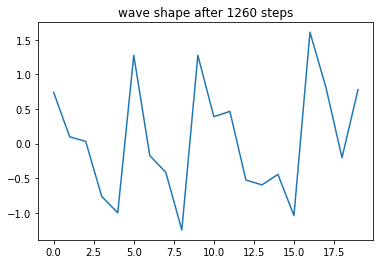

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1260/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1260/model_weights.tf
generator loss:1.8349624199413483
-----------------------
total discriminator loss:0.37799995551499854
average true return:0.5323366322527538
-----------------------


 81%|████████  | 1261/1562 [2:27:17<58:52, 11.74s/it]

Training Step: 1261
generator loss:2.0111270415951177
-----------------------
total discriminator loss:0.37277628565157195
average true return:0.4752766819054022
-----------------------


 81%|████████  | 1262/1562 [2:27:22<48:24,  9.68s/it]

Training Step: 1262
generator loss:2.1157325774990454
-----------------------
total discriminator loss:0.3619831798696245
average true return:0.47953908148788693
-----------------------


 81%|████████  | 1263/1562 [2:27:27<40:57,  8.22s/it]

Training Step: 1263
generator loss:2.111424299837868
-----------------------
total discriminator loss:0.39764703728041056
average true return:0.46749933964912016
-----------------------


 81%|████████  | 1264/1562 [2:27:32<35:50,  7.22s/it]

Training Step: 1264
generator loss:1.9297862550497054
-----------------------
total discriminator loss:0.4018307946013119
average true return:0.5139895127224512
-----------------------


 81%|████████  | 1265/1562 [2:27:37<32:15,  6.52s/it]

Training Step: 1265
event_types: [2, 2, 1, 0, 2, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 1, 0, 3, 2, 1]
mad_score: 0.6002875
fid_score: 715.2095980416163
rule_score: 0.17475


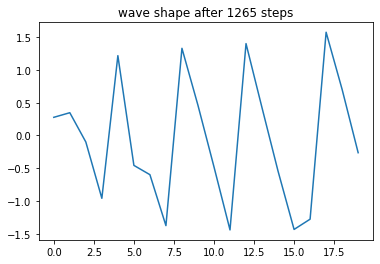

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1265/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1265/model_weights.tf
generator loss:1.824219374230839
-----------------------
total discriminator loss:0.3858523233096926
average true return:0.5301329054713881
-----------------------


 81%|████████  | 1266/1562 [2:28:03<1:01:15, 12.42s/it]

Training Step: 1266
generator loss:1.8200554052084221
-----------------------
total discriminator loss:0.3969739227514957
average true return:0.5446663290173566
-----------------------


 81%|████████  | 1267/1562 [2:28:08<49:41, 10.11s/it]  

Training Step: 1267
generator loss:2.005120722213341
-----------------------
total discriminator loss:1.8101614059847697
average true return:0.4967293832714542
-----------------------


 81%|████████  | 1268/1562 [2:28:13<41:48,  8.53s/it]

Training Step: 1268
generator loss:2.021039778714069
-----------------------
total discriminator loss:0.37851014588067644
average true return:0.5189478792722562
-----------------------


 81%|████████  | 1269/1562 [2:28:18<36:31,  7.48s/it]

Training Step: 1269
generator loss:1.9436225174692043
-----------------------
total discriminator loss:0.37413101526266845
average true return:0.4857418478844734
-----------------------


 81%|████████▏ | 1270/1562 [2:28:22<32:35,  6.70s/it]

Training Step: 1270
event_types: [0, 2, 0, 2, 2, 2, 0, 3, 2, 0, 2, 1, 1, 2, 1, 0, 3, 2, 2, 1]
mad_score: 0.596525
fid_score: 719.9971547123093
rule_score: 0.147


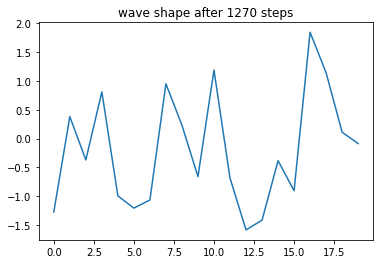

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1270/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1270/model_weights.tf
generator loss:1.9427786336216988
-----------------------
total discriminator loss:0.3904237791817367
average true return:0.4969326265584484
-----------------------


 81%|████████▏ | 1271/1562 [2:28:49<1:00:34, 12.49s/it]

Training Step: 1271
generator loss:1.837743545793839
-----------------------
total discriminator loss:0.3928506519144902
average true return:0.5044268755098009
-----------------------


 81%|████████▏ | 1272/1562 [2:28:53<49:00, 10.14s/it]  

Training Step: 1272
generator loss:1.878590008734471
-----------------------
total discriminator loss:0.39518698636647565
average true return:0.49871595210841113
-----------------------


 81%|████████▏ | 1273/1562 [2:28:58<40:51,  8.48s/it]

Training Step: 1273
generator loss:1.8218928086410726
-----------------------
total discriminator loss:0.34582535016761634
average true return:0.5007690614231644
-----------------------


 82%|████████▏ | 1274/1562 [2:29:02<35:14,  7.34s/it]

Training Step: 1274
generator loss:1.8856184786182943
-----------------------
total discriminator loss:0.3921917555967045
average true return:0.509185040746562
-----------------------


 82%|████████▏ | 1275/1562 [2:29:07<31:38,  6.61s/it]

Training Step: 1275
event_types: [3, 2, 2, 1, 1, 1, 0, 3, 2, 2, 1, 0, 3, 2, 0, 3, 2, 1, 0, 3]
mad_score: 0.5927125
fid_score: 753.4936104888453
rule_score: 0.134


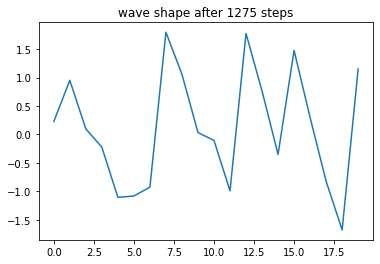

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1275/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1275/model_weights.tf
generator loss:1.934624579662824
-----------------------
total discriminator loss:0.3746185273675062
average true return:0.48423944997352586
-----------------------


 82%|████████▏ | 1276/1562 [2:29:34<59:30, 12.48s/it]

Training Step: 1276
generator loss:1.9449913504341816
-----------------------
total discriminator loss:0.38278318541900513
average true return:0.4747062061536279
-----------------------


 82%|████████▏ | 1277/1562 [2:29:39<49:09, 10.35s/it]

Training Step: 1277
generator loss:1.827189824838348
-----------------------
total discriminator loss:0.3754799076515658
average true return:0.5040073652189851
-----------------------


 82%|████████▏ | 1278/1562 [2:29:44<41:36,  8.79s/it]

Training Step: 1278
generator loss:1.7980075985676134
-----------------------
total discriminator loss:0.36132226445912546
average true return:0.5206927750650316
-----------------------


 82%|████████▏ | 1279/1562 [2:29:49<35:48,  7.59s/it]

Training Step: 1279
generator loss:1.8072373481665858
-----------------------
total discriminator loss:0.3803432772678869
average true return:0.4925852559394476
-----------------------


 82%|████████▏ | 1280/1562 [2:29:54<31:46,  6.76s/it]

Training Step: 1280
event_types: [2, 2, 0, 3, 2, 1, 1, 0, 2, 1, 0, 3, 2, 1, 0, 3, 2, 2, 0, 3]
mad_score: 0.5867375
fid_score: 745.7122036597425
rule_score: 0.13125


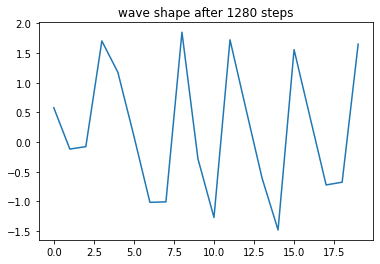

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1280/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1280/model_weights.tf
generator loss:1.8767444978104024
-----------------------
total discriminator loss:0.38722776073358656
average true return:0.4830135344456851
-----------------------


 82%|████████▏ | 1281/1562 [2:30:18<55:49, 11.92s/it]

Training Step: 1281
generator loss:1.8868255570536578
-----------------------
total discriminator loss:0.381382498118217
average true return:0.49916928231447094
-----------------------


 82%|████████▏ | 1282/1562 [2:30:22<44:48,  9.60s/it]

Training Step: 1282
generator loss:1.7148716733844858
-----------------------
total discriminator loss:0.38015375108846655
average true return:0.5178210420393792
-----------------------


 82%|████████▏ | 1283/1562 [2:30:27<38:00,  8.18s/it]

Training Step: 1283
generator loss:1.7651895313517334
-----------------------
total discriminator loss:1.646620945013664
average true return:0.5230130113288369
-----------------------


 82%|████████▏ | 1284/1562 [2:30:32<33:19,  7.19s/it]

Training Step: 1284
generator loss:1.5315154716951729
-----------------------
total discriminator loss:0.3676924997939298
average true return:0.5446995127949621
-----------------------


 82%|████████▏ | 1285/1562 [2:30:37<30:05,  6.52s/it]

Training Step: 1285
event_types: [0, 2, 2, 1, 0, 2, 1, 1, 0, 3, 2, 2, 2, 3, 3, 2, 2, 2, 1, 1]
mad_score: 0.5862125
fid_score: 790.6705357866086
rule_score: 0.10925


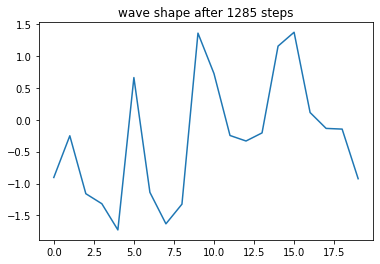

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1285/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1285/model_weights.tf
generator loss:1.4767004831281607
-----------------------
total discriminator loss:1.5697498934779057
average true return:0.551750950299157
-----------------------


 82%|████████▏ | 1286/1562 [2:31:02<56:43, 12.33s/it]

Training Step: 1286
generator loss:1.3965372795872946
-----------------------
total discriminator loss:0.4372089637338302
average true return:0.5614900513463591
-----------------------


 82%|████████▏ | 1287/1562 [2:31:07<45:54, 10.02s/it]

Training Step: 1287
generator loss:1.3840325402793257
-----------------------
total discriminator loss:0.45824183913117456
average true return:0.5140170199992472
-----------------------


 82%|████████▏ | 1288/1562 [2:31:12<38:34,  8.45s/it]

Training Step: 1288
generator loss:1.5012839457381557
-----------------------
total discriminator loss:0.4637252820938028
average true return:0.5090757711184617
-----------------------


 83%|████████▎ | 1289/1562 [2:31:17<33:32,  7.37s/it]

Training Step: 1289
generator loss:1.5188957658414393
-----------------------
total discriminator loss:0.436208740526306
average true return:0.5040288574440512
-----------------------


 83%|████████▎ | 1290/1562 [2:31:22<29:57,  6.61s/it]

Training Step: 1290
event_types: [3, 2, 1, 1, 1, 0, 2, 0, 3, 2, 1, 0, 2, 2, 2, 1, 0, 3, 2, 2]
mad_score: 0.5786
fid_score: 840.1105144950952
rule_score: 0.11125


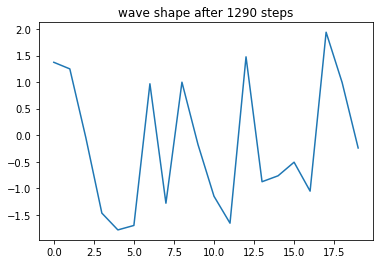

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1290/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1290/model_weights.tf
generator loss:1.5308223245593964
-----------------------
total discriminator loss:0.4173233884565808
average true return:0.5181358162697719
-----------------------


 83%|████████▎ | 1291/1562 [2:31:49<57:58, 12.84s/it]

Training Step: 1291
generator loss:1.664129029488408
-----------------------
total discriminator loss:0.39974294017714446
average true return:0.5035906132962136
-----------------------


 83%|████████▎ | 1292/1562 [2:31:54<47:00, 10.45s/it]

Training Step: 1292
generator loss:1.8762065056518722
-----------------------
total discriminator loss:0.3935632151567213
average true return:0.49288054267520015
-----------------------


 83%|████████▎ | 1293/1562 [2:31:58<38:54,  8.68s/it]

Training Step: 1293
generator loss:1.9851099550233877
-----------------------
total discriminator loss:0.4214025607414069
average true return:0.47907028206323354
-----------------------


 83%|████████▎ | 1294/1562 [2:32:03<33:37,  7.53s/it]

Training Step: 1294
generator loss:1.839469642700749
-----------------------
total discriminator loss:0.4207463364356388
average true return:0.455941700069699
-----------------------


 83%|████████▎ | 1295/1562 [2:32:08<29:44,  6.68s/it]

Training Step: 1295
event_types: [2, 2, 1, 1, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 0, 3, 2, 1, 0]
mad_score: 0.574325
fid_score: 841.8627783294214
rule_score: 0.1065


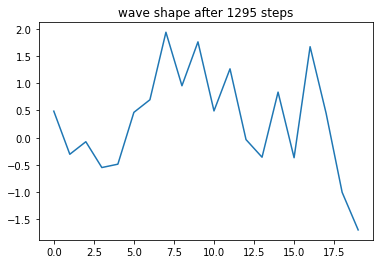

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1295/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1295/model_weights.tf
generator loss:1.8906867558828757
-----------------------
total discriminator loss:0.44682788422430686
average true return:0.46553731027167033
-----------------------


 83%|████████▎ | 1296/1562 [2:32:34<55:53, 12.61s/it]

Training Step: 1296
generator loss:1.692980774109327
-----------------------
total discriminator loss:0.43491487906312987
average true return:0.5011975282355633
-----------------------


 83%|████████▎ | 1297/1562 [2:32:39<45:28, 10.30s/it]

Training Step: 1297
generator loss:1.676103463672394
-----------------------
total discriminator loss:1.5695264993665072
average true return:0.505249836310396
-----------------------


 83%|████████▎ | 1298/1562 [2:32:44<38:07,  8.66s/it]

Training Step: 1298
generator loss:1.3640191115616953
-----------------------
total discriminator loss:1.4763720130477889
average true return:0.5659464549388897
-----------------------


 83%|████████▎ | 1299/1562 [2:32:49<32:49,  7.49s/it]

Training Step: 1299
generator loss:0.9801371467034772
-----------------------
total discriminator loss:0.48073203606191395
average true return:0.6364268488131588
-----------------------


 83%|████████▎ | 1300/1562 [2:32:54<29:04,  6.66s/it]

Training Step: 1300
event_types: [0, 3, 2, 2, 1, 1, 0, 3, 2, 1, 0, 3, 1, 1, 1, 1, 0, 3, 2, 2]
mad_score: 0.5802
fid_score: 841.6614054199978
rule_score: 0.08925


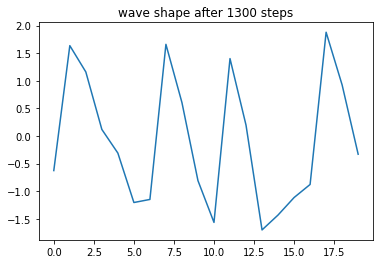

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1300/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1300/model_weights.tf
generator loss:1.0311068664456595
-----------------------
total discriminator loss:0.4827946404335329
average true return:0.624820056312408
-----------------------


 83%|████████▎ | 1301/1562 [2:33:19<53:11, 12.23s/it]

Training Step: 1301
generator loss:1.24564105969079
-----------------------
total discriminator loss:0.4294572025723462
average true return:0.5714596858232728
-----------------------


 83%|████████▎ | 1302/1562 [2:33:24<43:18,  9.99s/it]

Training Step: 1302
generator loss:1.68938621836275
-----------------------
total discriminator loss:0.44499525255715955
average true return:0.49007066553161815
-----------------------


 83%|████████▎ | 1303/1562 [2:33:28<36:21,  8.42s/it]

Training Step: 1303
generator loss:2.0505400238125207
-----------------------
total discriminator loss:0.46060721000993476
average true return:0.37911264281873175
-----------------------


 83%|████████▎ | 1304/1562 [2:33:33<31:27,  7.32s/it]

Training Step: 1304
generator loss:2.22759107617511
-----------------------
total discriminator loss:0.5231207811821065
average true return:0.33181705444851295
-----------------------


 84%|████████▎ | 1305/1562 [2:33:38<27:49,  6.50s/it]

Training Step: 1305
event_types: [2, 3, 3, 2, 2, 2, 1, 1, 0, 3, 2, 0, 2, 0, 3, 2, 0, 0, 2, 0]
mad_score: 0.5799875
fid_score: 820.2356562788893
rule_score: 0.103


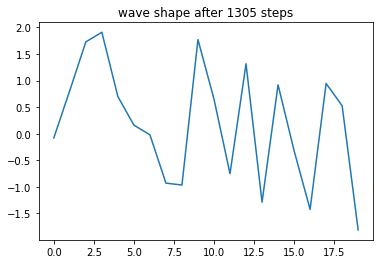

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1305/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1305/model_weights.tf
generator loss:1.9312469554716034
-----------------------
total discriminator loss:0.4525555917970804
average true return:0.4072718193319137
-----------------------


 84%|████████▎ | 1306/1562 [2:34:03<52:12, 12.24s/it]

Training Step: 1306
generator loss:1.511653759642011
-----------------------
total discriminator loss:0.41253781013852264
average true return:0.4917607634325941
-----------------------


 84%|████████▎ | 1307/1562 [2:34:08<42:05,  9.90s/it]

Training Step: 1307
generator loss:1.2043409076415157
-----------------------
total discriminator loss:0.4836507003415055
average true return:0.5704828797124968
-----------------------


 84%|████████▎ | 1308/1562 [2:34:11<34:01,  8.04s/it]

Training Step: 1308
generator loss:1.0827758500791302
-----------------------
total discriminator loss:0.4961284121767535
average true return:0.594384356411207
-----------------------


 84%|████████▍ | 1309/1562 [2:34:16<29:42,  7.04s/it]

Training Step: 1309
generator loss:1.16857558623561
-----------------------
total discriminator loss:0.43922071757387626
average true return:0.5450873574785823
-----------------------


 84%|████████▍ | 1310/1562 [2:34:21<26:42,  6.36s/it]

Training Step: 1310
event_types: [0, 2, 1, 1, 1, 1, 0, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2]
mad_score: 0.572425
fid_score: 808.0437428401779
rule_score: 0.10575


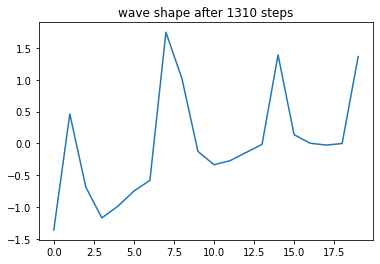

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1310/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1310/model_weights.tf
generator loss:1.3447119938144412
-----------------------
total discriminator loss:0.46521523502121964
average true return:0.5365554773607994
-----------------------


 84%|████████▍ | 1311/1562 [2:34:47<51:11, 12.24s/it]

Training Step: 1311
generator loss:1.5801945653746818
-----------------------
total discriminator loss:0.45518709422877035
average true return:0.45809370443906067
-----------------------


 84%|████████▍ | 1312/1562 [2:34:52<41:40, 10.00s/it]

Training Step: 1312
generator loss:1.908575047890489
-----------------------
total discriminator loss:0.47165660673345255
average true return:0.38854145298078197
-----------------------


 84%|████████▍ | 1313/1562 [2:34:57<35:11,  8.48s/it]

Training Step: 1313
generator loss:2.0588076806299607
-----------------------
total discriminator loss:0.45210978836553056
average true return:0.3715007723778802
-----------------------


 84%|████████▍ | 1314/1562 [2:35:01<30:15,  7.32s/it]

Training Step: 1314
generator loss:1.9915738071098117
-----------------------
total discriminator loss:0.47155247506617337
average true return:0.3884271134130036
-----------------------


 84%|████████▍ | 1315/1562 [2:35:06<26:44,  6.50s/it]

Training Step: 1315
event_types: [0, 2, 1, 0, 2, 0, 2, 2, 0, 2, 2, 1, 0, 3, 2, 2, 3, 2, 1, 0]
mad_score: 0.5706625
fid_score: 776.2014597168541
rule_score: 0.0965


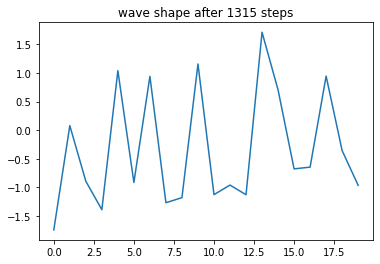

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1315/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1315/model_weights.tf
generator loss:1.6983609599127785
-----------------------
total discriminator loss:0.4051808634598777
average true return:0.46204868854207104
-----------------------


 84%|████████▍ | 1316/1562 [2:35:32<50:25, 12.30s/it]

Training Step: 1316
generator loss:1.3685027633610916
-----------------------
total discriminator loss:0.43175433241440714
average true return:0.52944595100723
-----------------------


 84%|████████▍ | 1317/1562 [2:35:36<40:56, 10.03s/it]

Training Step: 1317
generator loss:1.2137003449097348
-----------------------
total discriminator loss:0.43803917503469625
average true return:0.5551171221516303
-----------------------


 84%|████████▍ | 1318/1562 [2:35:41<34:37,  8.51s/it]

Training Step: 1318
generator loss:1.2622275451707567
-----------------------
total discriminator loss:0.424549615705642
average true return:0.5501225362238671
-----------------------


 84%|████████▍ | 1319/1562 [2:35:46<30:04,  7.43s/it]

Training Step: 1319
generator loss:1.352098363884861
-----------------------
total discriminator loss:0.4277295332359684
average true return:0.5154064096941675
-----------------------


 85%|████████▍ | 1320/1562 [2:35:51<26:56,  6.68s/it]

Training Step: 1320
event_types: [2, 0, 3, 2, 2, 2, 1, 0, 2, 1, 1, 1, 0, 3, 2, 1, 0, 3, 2, 1]
mad_score: 0.5703875
fid_score: 765.1593883661641
rule_score: 0.10625


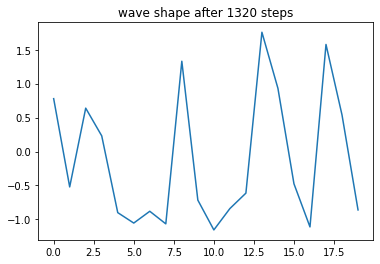

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1320/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1320/model_weights.tf
generator loss:1.6814544097362738
-----------------------
total discriminator loss:0.4391171847686145
average true return:0.45135965094871133
-----------------------


 85%|████████▍ | 1321/1562 [2:36:18<50:41, 12.62s/it]

Training Step: 1321
generator loss:1.7049266510221548
-----------------------
total discriminator loss:0.4280191763199872
average true return:0.43502242019691206
-----------------------


 85%|████████▍ | 1322/1562 [2:36:22<40:58, 10.24s/it]

Training Step: 1322
generator loss:1.7573526782197195
-----------------------
total discriminator loss:0.43944589510185184
average true return:0.4610627572522076
-----------------------


 85%|████████▍ | 1323/1562 [2:36:27<34:26,  8.65s/it]

Training Step: 1323
generator loss:1.6469527325279902
-----------------------
total discriminator loss:0.3976959227298661
average true return:0.4904642027224601
-----------------------


 85%|████████▍ | 1324/1562 [2:36:32<29:32,  7.45s/it]

Training Step: 1324
generator loss:1.5290601872048453
-----------------------
total discriminator loss:0.3999679338493156
average true return:0.5147485550832223
-----------------------


 85%|████████▍ | 1325/1562 [2:36:37<26:24,  6.68s/it]

Training Step: 1325
event_types: [2, 2, 2, 1, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 0, 3, 2]
mad_score: 0.5711875
fid_score: 775.2017429405925
rule_score: 0.12575


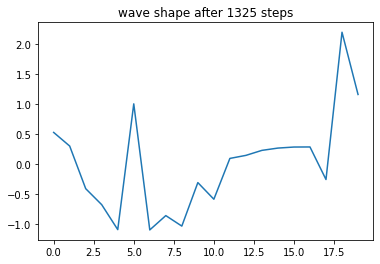

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1325/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1325/model_weights.tf
generator loss:1.57356660838088
-----------------------
total discriminator loss:1.4368318904243715
average true return:0.533079287327368
-----------------------


 85%|████████▍ | 1326/1562 [2:37:03<49:50, 12.67s/it]

Training Step: 1326
generator loss:1.2007261201522632
-----------------------
total discriminator loss:0.4920306609461775
average true return:0.5807641037181246
-----------------------


 85%|████████▍ | 1327/1562 [2:37:08<40:09, 10.25s/it]

Training Step: 1327
generator loss:1.2096844365330592
-----------------------
total discriminator loss:1.3832456366825046
average true return:0.5750544956423487
-----------------------


 85%|████████▌ | 1328/1562 [2:37:13<33:37,  8.62s/it]

Training Step: 1328
generator loss:1.1138213474480279
-----------------------
total discriminator loss:0.5026244353941283
average true return:0.604938601470695
-----------------------


 85%|████████▌ | 1329/1562 [2:37:17<28:53,  7.44s/it]

Training Step: 1329
generator loss:1.154513596172061
-----------------------
total discriminator loss:0.4856117768460854
average true return:0.5689881588936656
-----------------------


 85%|████████▌ | 1330/1562 [2:37:22<25:28,  6.59s/it]

Training Step: 1330
event_types: [2, 0, 2, 2, 1, 1, 0, 2, 3, 2, 2, 1, 0, 3, 2, 2, 2, 0, 3, 2]
mad_score: 0.581225
fid_score: 791.008908203071
rule_score: 0.12775


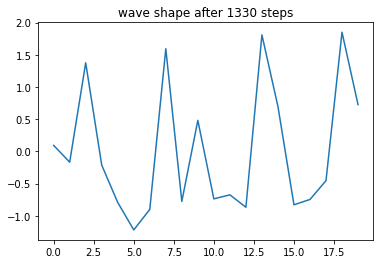

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1330/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1330/model_weights.tf
generator loss:1.4370899919611997
-----------------------
total discriminator loss:0.4701298967185233
average true return:0.5286046185691273
-----------------------


 85%|████████▌ | 1331/1562 [2:37:48<47:46, 12.41s/it]

Training Step: 1331
generator loss:1.577266088910736
-----------------------
total discriminator loss:0.46031166413194513
average true return:0.4640402831122565
-----------------------


 85%|████████▌ | 1332/1562 [2:37:53<38:37, 10.08s/it]

Training Step: 1332
generator loss:1.7715428620385314
-----------------------
total discriminator loss:0.46563415595496027
average true return:0.4178655734697003
-----------------------


 85%|████████▌ | 1333/1562 [2:37:57<32:10,  8.43s/it]

Training Step: 1333
generator loss:1.9255038634020942
-----------------------
total discriminator loss:0.47187483147097864
average true return:0.4007876805073876
-----------------------


 85%|████████▌ | 1334/1562 [2:38:01<26:40,  7.02s/it]

Training Step: 1334
generator loss:1.8677070038497412
-----------------------
total discriminator loss:0.4363751791520075
average true return:0.4135187817920735
-----------------------


 85%|████████▌ | 1335/1562 [2:38:06<23:58,  6.34s/it]

Training Step: 1335
event_types: [0, 2, 2, 1, 1, 0, 3, 2, 1, 1, 0, 2, 1, 1, 0, 3, 2, 1, 0, 3]
mad_score: 0.5933
fid_score: 766.4477576517373
rule_score: 0.11825


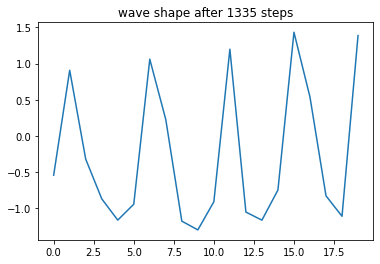

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1335/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1335/model_weights.tf
generator loss:1.5867842810928399
-----------------------
total discriminator loss:0.44081171308724076
average true return:0.47528258627502795
-----------------------


 86%|████████▌ | 1336/1562 [2:38:31<45:44, 12.14s/it]

Training Step: 1336
generator loss:1.3998331942441764
-----------------------
total discriminator loss:0.4394629975824965
average true return:0.5068938568071313
-----------------------


 86%|████████▌ | 1337/1562 [2:38:36<37:24,  9.98s/it]

Training Step: 1337
generator loss:1.3220668720920083
-----------------------
total discriminator loss:0.4587826542737328
average true return:0.5486207457569211
-----------------------


 86%|████████▌ | 1338/1562 [2:38:41<31:24,  8.41s/it]

Training Step: 1338
generator loss:1.3206953174073317
-----------------------
total discriminator loss:0.41872917201254967
average true return:0.5297591241258521
-----------------------


 86%|████████▌ | 1339/1562 [2:38:46<27:09,  7.31s/it]

Training Step: 1339
generator loss:1.3834521386614536
-----------------------
total discriminator loss:0.45200525593816665
average true return:0.5249408870582015
-----------------------


 86%|████████▌ | 1340/1562 [2:38:51<24:14,  6.55s/it]

Training Step: 1340
event_types: [2, 2, 2, 1, 1, 1, 0, 2, 1, 0, 3, 2, 1, 0, 3, 2, 2, 0, 2, 1]
mad_score: 0.6003375
fid_score: 814.8896128444426
rule_score: 0.13275


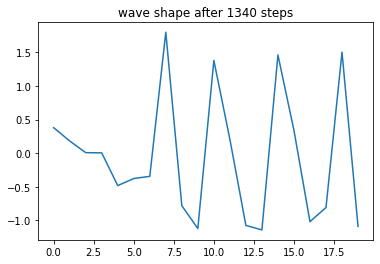

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1340/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1340/model_weights.tf
generator loss:1.5817276699200467
-----------------------
total discriminator loss:1.4170811001320085
average true return:0.4870117216148616
-----------------------


 86%|████████▌ | 1341/1562 [2:39:18<46:34, 12.65s/it]

Training Step: 1341
generator loss:1.3320863790219069
-----------------------
total discriminator loss:0.44151136245349104
average true return:0.49954364854697286
-----------------------


 86%|████████▌ | 1342/1562 [2:39:22<37:42, 10.28s/it]

Training Step: 1342
generator loss:1.2775835981806385
-----------------------
total discriminator loss:0.4401363188020868
average true return:0.5402349428781179
-----------------------


 86%|████████▌ | 1343/1562 [2:39:27<31:21,  8.59s/it]

Training Step: 1343
generator loss:1.2026525463275477
-----------------------
total discriminator loss:0.4602083302708567
average true return:0.5571936918131506
-----------------------


 86%|████████▌ | 1344/1562 [2:39:32<27:18,  7.51s/it]

Training Step: 1344
generator loss:1.4713304487242143
-----------------------
total discriminator loss:0.4098607865338727
average true return:0.5134202489208193
-----------------------


 86%|████████▌ | 1345/1562 [2:39:37<24:14,  6.70s/it]

Training Step: 1345
event_types: [3, 2, 1, 0, 2, 2, 1, 1, 0, 3, 2, 2, 2, 2, 3, 2, 0, 3, 2, 2]
mad_score: 0.60365
fid_score: 808.455098758398
rule_score: 0.132


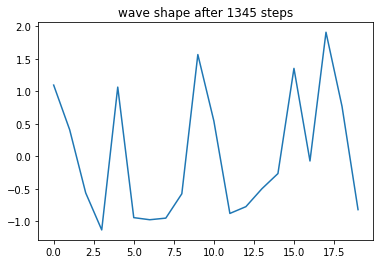

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1345/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1345/model_weights.tf
generator loss:1.7198733105766018
-----------------------
total discriminator loss:0.4103355651299124
average true return:0.4426633340358348
-----------------------


 86%|████████▌ | 1346/1562 [2:40:03<44:59, 12.50s/it]

Training Step: 1346
generator loss:1.8084848610180457
-----------------------
total discriminator loss:0.44814773106063877
average true return:0.4301655397758767
-----------------------


 86%|████████▌ | 1347/1562 [2:40:08<36:50, 10.28s/it]

Training Step: 1347
generator loss:1.818925640371482
-----------------------
total discriminator loss:0.45781072392276545
average true return:0.4046783399782301
-----------------------


 86%|████████▋ | 1348/1562 [2:40:13<30:43,  8.61s/it]

Training Step: 1348
generator loss:1.6905828078093146
-----------------------
total discriminator loss:0.4490289093094014
average true return:0.46536136644762394
-----------------------


 86%|████████▋ | 1349/1562 [2:40:17<26:35,  7.49s/it]

Training Step: 1349
generator loss:1.5093579004545536
-----------------------
total discriminator loss:0.4197407539079
average true return:0.491351614086678
-----------------------


 86%|████████▋ | 1350/1562 [2:40:22<23:31,  6.66s/it]

Training Step: 1350
event_types: [2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 0, 3, 2, 1, 0]
mad_score: 0.60995
fid_score: 848.1961068987318
rule_score: 0.14325


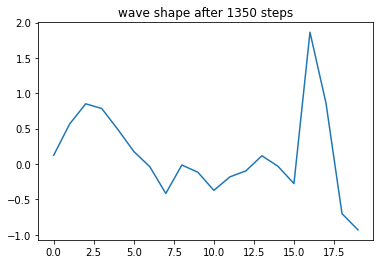

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1350/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1350/model_weights.tf
generator loss:1.3846108395062717
-----------------------
total discriminator loss:0.4185753473617476
average true return:0.5109231888050454
-----------------------


 86%|████████▋ | 1351/1562 [2:40:48<43:52, 12.48s/it]

Training Step: 1351
generator loss:1.3989067815128111
-----------------------
total discriminator loss:0.4438171889853676
average true return:0.540925394737978
-----------------------


 87%|████████▋ | 1352/1562 [2:40:53<35:37, 10.18s/it]

Training Step: 1352
generator loss:1.4508870583544715
-----------------------
total discriminator loss:0.41304107439163523
average true return:0.501080521079826
-----------------------


 87%|████████▋ | 1353/1562 [2:40:58<29:47,  8.55s/it]

Training Step: 1353
generator loss:1.5140231068002086
-----------------------
total discriminator loss:0.42893233804071407
average true return:0.4852580160067091
-----------------------


 87%|████████▋ | 1354/1562 [2:41:03<25:46,  7.43s/it]

Training Step: 1354
generator loss:1.8795704342669666
-----------------------
total discriminator loss:0.40422187239478036
average true return:0.45144446464511545
-----------------------


 87%|████████▋ | 1355/1562 [2:41:08<23:01,  6.67s/it]

Training Step: 1355
event_types: [3, 2, 2, 2, 1, 0, 3, 2, 0, 2, 0, 3, 2, 1, 0, 3, 2, 0, 3, 2]
mad_score: 0.6165875
fid_score: 890.7698095413706
rule_score: 0.13925


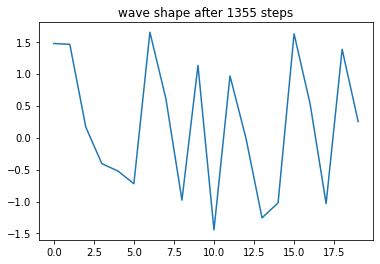

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1355/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1355/model_weights.tf
generator loss:1.8853283386366022
-----------------------
total discriminator loss:0.40659503694458976
average true return:0.4391747177008437
-----------------------


 87%|████████▋ | 1356/1562 [2:41:33<42:23, 12.35s/it]

Training Step: 1356
generator loss:1.7767083262032464
-----------------------
total discriminator loss:0.4243673495958037
average true return:0.4422517322036166
-----------------------


 87%|████████▋ | 1357/1562 [2:41:38<34:01,  9.96s/it]

Training Step: 1357
generator loss:1.6842592590321348
-----------------------
total discriminator loss:0.447037056069855
average true return:0.4757013973435795
-----------------------


 87%|████████▋ | 1358/1562 [2:41:42<28:20,  8.34s/it]

Training Step: 1358
generator loss:1.4370046687969342
-----------------------
total discriminator loss:0.423084387683703
average true return:0.5181458847287097
-----------------------


 87%|████████▋ | 1359/1562 [2:41:47<24:19,  7.19s/it]

Training Step: 1359
generator loss:1.4627669186534955
-----------------------
total discriminator loss:0.42651454997365584
average true return:0.5355301066569891
-----------------------


 87%|████████▋ | 1360/1562 [2:41:50<20:33,  6.10s/it]

Training Step: 1360
event_types: [0, 2, 0, 3, 2, 0, 3, 2, 1, 0, 3, 2, 2, 0, 3, 2, 0, 3, 2, 0]
mad_score: 0.629825
fid_score: 895.9809132282742
rule_score: 0.14175


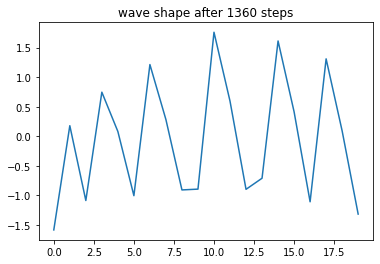

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1360/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1360/model_weights.tf
generator loss:1.5135019171210233
-----------------------
total discriminator loss:0.41769605680248145
average true return:0.5077341369902463
-----------------------


 87%|████████▋ | 1361/1562 [2:42:16<40:45, 12.17s/it]

Training Step: 1361
generator loss:1.5838030801172267
-----------------------
total discriminator loss:0.42124335068057184
average true return:0.5099132359957559
-----------------------


 87%|████████▋ | 1362/1562 [2:42:21<33:10,  9.95s/it]

Training Step: 1362
generator loss:1.7785471343421344
-----------------------
total discriminator loss:0.43467096755849544
average true return:0.464965288629736
-----------------------


 87%|████████▋ | 1363/1562 [2:42:26<27:54,  8.42s/it]

Training Step: 1363
generator loss:2.0011890044445964
-----------------------
total discriminator loss:0.4145119309600386
average true return:0.4392788358358481
-----------------------


 87%|████████▋ | 1364/1562 [2:42:31<24:14,  7.35s/it]

Training Step: 1364
generator loss:1.8955767035976017
-----------------------
total discriminator loss:0.4195184538288311
average true return:0.465778624065428
-----------------------


 87%|████████▋ | 1365/1562 [2:42:36<21:30,  6.55s/it]

Training Step: 1365
event_types: [0, 3, 3, 2, 0, 3, 2, 0, 2, 1, 0, 3, 2, 0, 2, 1, 0, 3, 2, 1]
mad_score: 0.62995
fid_score: 942.1098517520323
rule_score: 0.134


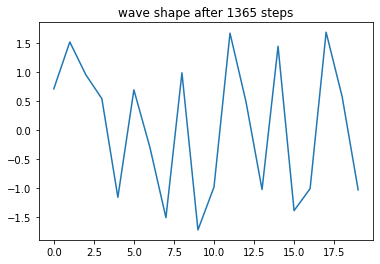

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1365/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1365/model_weights.tf
generator loss:1.7367256989782205
-----------------------
total discriminator loss:0.4155893562835074
average true return:0.47456964313575056
-----------------------


 87%|████████▋ | 1366/1562 [2:43:01<40:05, 12.27s/it]

Training Step: 1366
generator loss:1.6888785884066653
-----------------------
total discriminator loss:0.39818458348225716
average true return:0.5038441693719562
-----------------------


 88%|████████▊ | 1367/1562 [2:43:06<32:45, 10.08s/it]

Training Step: 1367
generator loss:1.5820073814147686
-----------------------
total discriminator loss:0.41118301654144845
average true return:0.5314872649899753
-----------------------


 88%|████████▊ | 1368/1562 [2:43:12<27:59,  8.65s/it]

Training Step: 1368
generator loss:1.5797845789140312
-----------------------
total discriminator loss:0.4275460777470496
average true return:0.5218240511955551
-----------------------


 88%|████████▊ | 1369/1562 [2:43:17<24:34,  7.64s/it]

Training Step: 1369
generator loss:1.7733575958541012
-----------------------
total discriminator loss:0.4106326277345067
average true return:0.49329202605116784
-----------------------


 88%|████████▊ | 1370/1562 [2:43:22<21:48,  6.81s/it]

Training Step: 1370
event_types: [3, 3, 2, 1, 1, 1, 1, 1, 1, 0, 3, 2, 1, 0, 2, 0, 3, 2, 0, 3]
mad_score: 0.6321
fid_score: 994.2457748123113
rule_score: 0.142


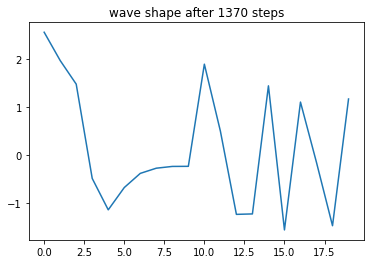

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1370/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1370/model_weights.tf
generator loss:1.9174258898868546
-----------------------
total discriminator loss:0.4075891681427467
average true return:0.4641302721496019
-----------------------


 88%|████████▊ | 1371/1562 [2:43:48<40:01, 12.57s/it]

Training Step: 1371
generator loss:1.9021959760760434
-----------------------
total discriminator loss:0.39935062165083013
average true return:0.4833605607120736
-----------------------


 88%|████████▊ | 1372/1562 [2:43:52<32:16, 10.19s/it]

Training Step: 1372
generator loss:1.8574763935886214
-----------------------
total discriminator loss:0.3963432314882888
average true return:0.4794719701963882
-----------------------


 88%|████████▊ | 1373/1562 [2:43:57<26:58,  8.57s/it]

Training Step: 1373
generator loss:1.822282085770948
-----------------------
total discriminator loss:0.42816713024023945
average true return:0.48996692726619867
-----------------------


 88%|████████▊ | 1374/1562 [2:44:02<23:18,  7.44s/it]

Training Step: 1374
generator loss:1.8097860252313978
-----------------------
total discriminator loss:0.42495289764159216
average true return:0.519111191106192
-----------------------


 88%|████████▊ | 1375/1562 [2:44:07<20:53,  6.70s/it]

Training Step: 1375
event_types: [3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 0, 3, 3, 2, 0]
mad_score: 0.63255
fid_score: 1106.8427644799594
rule_score: 0.13625


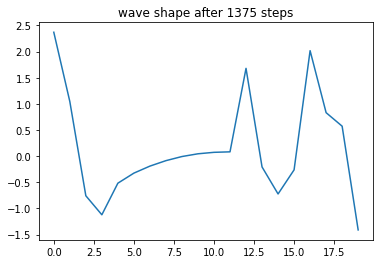

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1375/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1375/model_weights.tf
generator loss:1.8456431859308917
-----------------------
total discriminator loss:0.4068327858213768
average true return:0.49102596544312604
-----------------------


 88%|████████▊ | 1376/1562 [2:44:33<39:13, 12.65s/it]

Training Step: 1376
generator loss:1.8211343519065224
-----------------------
total discriminator loss:0.42574832776270166
average true return:0.4949102177619613
-----------------------


 88%|████████▊ | 1377/1562 [2:44:38<31:42, 10.28s/it]

Training Step: 1377
generator loss:1.865737335759491
-----------------------
total discriminator loss:0.43163816829343626
average true return:0.48863283570272875
-----------------------


 88%|████████▊ | 1378/1562 [2:44:43<26:26,  8.62s/it]

Training Step: 1378
generator loss:1.7815508014188588
-----------------------
total discriminator loss:0.4111047041930837
average true return:0.5019209123808978
-----------------------


 88%|████████▊ | 1379/1562 [2:44:48<22:43,  7.45s/it]

Training Step: 1379
generator loss:1.7614876776448336
-----------------------
total discriminator loss:0.4241478571763236
average true return:0.5035407827452116
-----------------------


 88%|████████▊ | 1380/1562 [2:44:52<20:11,  6.66s/it]

Training Step: 1380
event_types: [2, 1, 0, 2, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 2, 2, 2, 2, 1]
mad_score: 0.6331
fid_score: 1310.4254712652014
rule_score: 0.12975


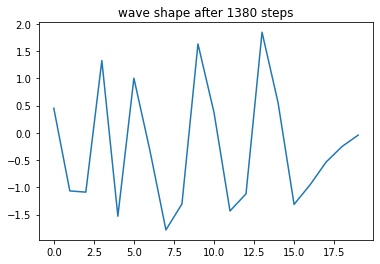

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1380/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1380/model_weights.tf
generator loss:1.720012937808677
-----------------------
total discriminator loss:1.513732316763581
average true return:0.5282401925128484
-----------------------


 88%|████████▊ | 1381/1562 [2:45:19<37:38, 12.48s/it]

Training Step: 1381
generator loss:1.5950067354816269
-----------------------
total discriminator loss:0.40357535104689646
average true return:0.5453655207976453
-----------------------


 88%|████████▊ | 1382/1562 [2:45:23<30:13, 10.07s/it]

Training Step: 1382
generator loss:1.4948220344375556
-----------------------
total discriminator loss:1.5236838725753854
average true return:0.5517529462909553
-----------------------


 89%|████████▊ | 1383/1562 [2:45:28<25:06,  8.42s/it]

Training Step: 1383
generator loss:1.2943398722206165
-----------------------
total discriminator loss:0.4321197270026055
average true return:0.5818896871199923
-----------------------


 89%|████████▊ | 1384/1562 [2:45:32<21:39,  7.30s/it]

Training Step: 1384
generator loss:1.401600834634375
-----------------------
total discriminator loss:0.42795563371650597
average true return:0.5603355910382274
-----------------------


 89%|████████▊ | 1385/1562 [2:45:37<19:08,  6.49s/it]

Training Step: 1385
event_types: [2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 3, 2, 2, 3, 2, 2, 2, 2]
mad_score: 0.624275
fid_score: 1473.481679424389
rule_score: 0.1395


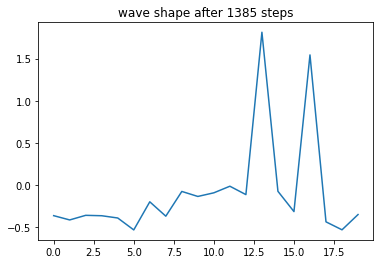

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1385/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1385/model_weights.tf
generator loss:1.6558999518717954
-----------------------
total discriminator loss:0.43849010695603546
average true return:0.5102479338765779
-----------------------


 89%|████████▊ | 1386/1562 [2:46:01<34:52, 11.89s/it]

Training Step: 1386
generator loss:1.8412908780260744
-----------------------
total discriminator loss:0.43762168711476906
average true return:0.4604068838932392
-----------------------


 89%|████████▉ | 1387/1562 [2:46:06<28:26,  9.75s/it]

Training Step: 1387
generator loss:1.8195374813453098
-----------------------
total discriminator loss:0.42238571786800044
average true return:0.43891432465872954
-----------------------


 89%|████████▉ | 1388/1562 [2:46:11<23:57,  8.26s/it]

Training Step: 1388
generator loss:1.7196231732530385
-----------------------
total discriminator loss:0.43915040286618673
average true return:0.475580268467132
-----------------------


 89%|████████▉ | 1389/1562 [2:46:16<20:54,  7.25s/it]

Training Step: 1389
generator loss:1.5507991604402025
-----------------------
total discriminator loss:0.41826073684048504
average true return:0.5256120304894958
-----------------------


 89%|████████▉ | 1390/1562 [2:46:21<18:40,  6.51s/it]

Training Step: 1390
event_types: [3, 2, 2, 2, 0, 3, 2, 0, 3, 2, 0, 3, 2, 0, 3, 2, 1, 0, 3, 2]
mad_score: 0.61965
fid_score: 1776.4945447453385
rule_score: 0.13075


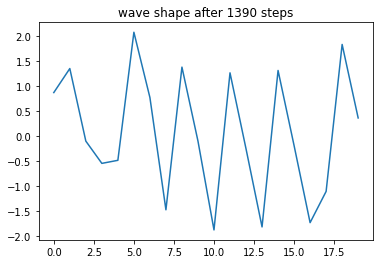

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1390/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1390/model_weights.tf
generator loss:1.400465356678331
-----------------------
total discriminator loss:0.43832639834629633
average true return:0.5497762207804564
-----------------------


 89%|████████▉ | 1391/1562 [2:46:47<35:21, 12.41s/it]

Training Step: 1391
generator loss:1.4957839266585333
-----------------------
total discriminator loss:0.43630482045883556
average true return:0.5469363422232023
-----------------------


 89%|████████▉ | 1392/1562 [2:46:52<28:45, 10.15s/it]

Training Step: 1392
generator loss:1.5716799814718867
-----------------------
total discriminator loss:0.4188449147754732
average true return:0.5025533316696276
-----------------------


 89%|████████▉ | 1393/1562 [2:46:56<23:58,  8.51s/it]

Training Step: 1393
generator loss:1.725085184318704
-----------------------
total discriminator loss:0.4509901179154997
average true return:0.47039083238913787
-----------------------


 89%|████████▉ | 1394/1562 [2:47:01<20:39,  7.38s/it]

Training Step: 1394
generator loss:1.8280447529978505
-----------------------
total discriminator loss:0.41647787565328265
average true return:0.4546741089592722
-----------------------


 89%|████████▉ | 1395/1562 [2:47:06<18:18,  6.58s/it]

Training Step: 1395
event_types: [0, 2, 0, 3, 0, 3, 2, 1, 0, 3, 2, 2, 0, 3, 1, 0, 3, 2, 0, 3]
mad_score: 0.6179875
fid_score: 2031.7991235390077
rule_score: 0.13775


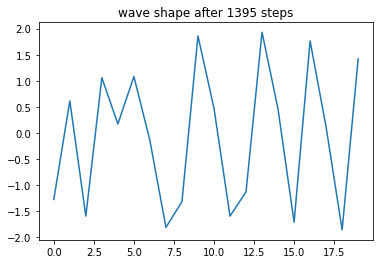

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1395/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1395/model_weights.tf
generator loss:1.7516957690902444
-----------------------
total discriminator loss:0.45496692946168904
average true return:0.4603041241459746
-----------------------


 89%|████████▉ | 1396/1562 [2:47:33<35:10, 12.71s/it]

Training Step: 1396
generator loss:1.5730853459329373
-----------------------
total discriminator loss:0.4082525225166608
average true return:0.5044866057199224
-----------------------


 89%|████████▉ | 1397/1562 [2:47:37<28:21, 10.31s/it]

Training Step: 1397
generator loss:1.4311077985268623
-----------------------
total discriminator loss:0.4072069155039292
average true return:0.523228405662633
-----------------------


 90%|████████▉ | 1398/1562 [2:47:42<23:47,  8.70s/it]

Training Step: 1398
generator loss:1.4126998809794193
-----------------------
total discriminator loss:0.416299358879879
average true return:0.5493214586028957
-----------------------


 90%|████████▉ | 1399/1562 [2:47:47<20:32,  7.56s/it]

Training Step: 1399
generator loss:1.5239638386867762
-----------------------
total discriminator loss:0.443296883691244
average true return:0.5513928662670197
-----------------------


 90%|████████▉ | 1400/1562 [2:47:52<18:14,  6.76s/it]

Training Step: 1400
event_types: [1, 1, 1, 2, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 1, 1, 2, 1, 1, 2]
mad_score: 0.613125
fid_score: 2191.0020664329313
rule_score: 0.14


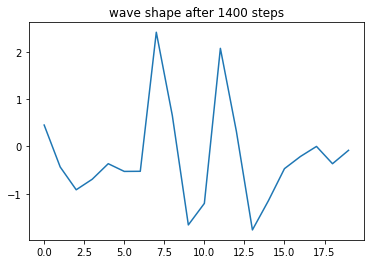

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1400/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1400/model_weights.tf
generator loss:1.6032413114501267
-----------------------
total discriminator loss:0.42623566322975825
average true return:0.49779253615389907
-----------------------


 90%|████████▉ | 1401/1562 [2:48:18<33:17, 12.41s/it]

Training Step: 1401
generator loss:1.596100655958847
-----------------------
total discriminator loss:0.41175742497374135
average true return:0.4725889509904485
-----------------------


 90%|████████▉ | 1402/1562 [2:48:23<27:00, 10.13s/it]

Training Step: 1402
generator loss:1.6392029435627526
-----------------------
total discriminator loss:0.40322450236808416
average true return:0.4984897390136557
-----------------------


 90%|████████▉ | 1403/1562 [2:48:27<22:33,  8.51s/it]

Training Step: 1403
generator loss:1.4701884704611896
-----------------------
total discriminator loss:0.39740915959845463
average true return:0.5297347490067029
-----------------------


 90%|████████▉ | 1404/1562 [2:48:32<19:24,  7.37s/it]

Training Step: 1404
generator loss:1.4707346704336843
-----------------------
total discriminator loss:0.3926062963805
average true return:0.5267370849430779
-----------------------


 90%|████████▉ | 1405/1562 [2:48:37<17:15,  6.60s/it]

Training Step: 1405
event_types: [2, 2, 1, 0, 3, 2, 1, 1, 0, 3, 2, 2, 0, 3, 2, 0, 3, 2, 1, 0]
mad_score: 0.6076875
fid_score: 2239.246758894952
rule_score: 0.16675


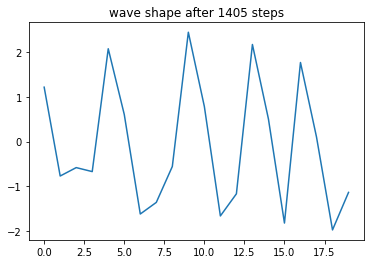

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1405/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1405/model_weights.tf
generator loss:1.5873305271135232
-----------------------
total discriminator loss:0.40466312603954635
average true return:0.5177305052490679
-----------------------


 90%|█████████ | 1406/1562 [2:49:03<32:27, 12.48s/it]

Training Step: 1406
generator loss:1.701827831685217
-----------------------
total discriminator loss:0.39427778555459647
average true return:0.503593534629595
-----------------------


 90%|█████████ | 1407/1562 [2:49:08<26:12, 10.15s/it]

Training Step: 1407
generator loss:1.839865514588118
-----------------------
total discriminator loss:0.38259881341965435
average true return:0.48849725744622974
-----------------------


 90%|█████████ | 1408/1562 [2:49:12<21:36,  8.42s/it]

Training Step: 1408
generator loss:1.8345003251637961
-----------------------
total discriminator loss:0.41103036395548687
average true return:0.48667588388370403
-----------------------


 90%|█████████ | 1409/1562 [2:49:17<18:31,  7.27s/it]

Training Step: 1409
generator loss:1.8055434994073385
-----------------------
total discriminator loss:0.41255644353729487
average true return:0.48707465959777074
-----------------------


 90%|█████████ | 1410/1562 [2:49:21<16:21,  6.46s/it]

Training Step: 1410
event_types: [2, 2, 0, 2, 2, 1, 2, 1, 2, 3, 3, 3, 2, 0, 3, 2, 0, 2, 0, 3]
mad_score: 0.60875
fid_score: 2157.1216140078404
rule_score: 0.18625


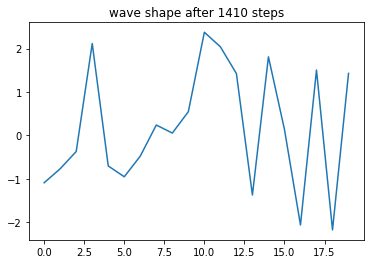

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1410/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1410/model_weights.tf
generator loss:1.8069445062251857
-----------------------
total discriminator loss:0.41636364269089754
average true return:0.4770811171339713
-----------------------


 90%|█████████ | 1411/1562 [2:49:46<30:13, 12.01s/it]

Training Step: 1411
generator loss:1.6093370331994246
-----------------------
total discriminator loss:0.3984793892543034
average true return:0.5084619295118402
-----------------------


 90%|█████████ | 1412/1562 [2:49:51<24:31,  9.81s/it]

Training Step: 1412
generator loss:1.6922437670508248
-----------------------
total discriminator loss:0.4216141450070115
average true return:0.5242584362271611
-----------------------


 90%|█████████ | 1413/1562 [2:49:56<20:40,  8.32s/it]

Training Step: 1413
generator loss:1.6773990364878582
-----------------------
total discriminator loss:0.3880929112891821
average true return:0.5136860689542415
-----------------------


 91%|█████████ | 1414/1562 [2:50:01<17:57,  7.28s/it]

Training Step: 1414
generator loss:1.6984634805295349
-----------------------
total discriminator loss:0.4023177417766387
average true return:0.515810224339284
-----------------------


 91%|█████████ | 1415/1562 [2:50:05<15:49,  6.46s/it]

Training Step: 1415
event_types: [3, 2, 2, 1, 0, 3, 2, 2, 1, 2, 3, 2, 2, 1, 1, 1, 2, 2, 3, 3]
mad_score: 0.6082
fid_score: 2013.5031070455534
rule_score: 0.20525


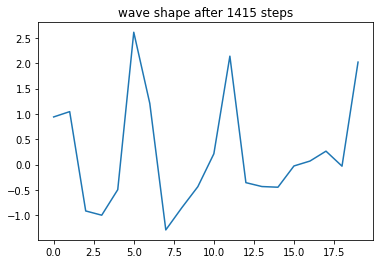

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1415/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1415/model_weights.tf
generator loss:1.8240119537783142
-----------------------
total discriminator loss:0.40447629295404364
average true return:0.48536575086631056
-----------------------


 91%|█████████ | 1416/1562 [2:50:31<29:29, 12.12s/it]

Training Step: 1416
generator loss:1.9014533135761078
-----------------------
total discriminator loss:0.4152780912079245
average true return:0.4669445459848218
-----------------------


 91%|█████████ | 1417/1562 [2:50:35<23:56,  9.91s/it]

Training Step: 1417
generator loss:1.8572879830126094
-----------------------
total discriminator loss:0.40919464180860154
average true return:0.48112162924700874
-----------------------


 91%|█████████ | 1418/1562 [2:50:40<20:08,  8.39s/it]

Training Step: 1418
generator loss:1.6793237023836165
-----------------------
total discriminator loss:0.4055996145737445
average true return:0.5252319620704197
-----------------------


 91%|█████████ | 1419/1562 [2:50:45<17:33,  7.36s/it]

Training Step: 1419
generator loss:1.742208499565769
-----------------------
total discriminator loss:0.4153177962626848
average true return:0.5096222499871935
-----------------------


 91%|█████████ | 1420/1562 [2:50:50<15:24,  6.51s/it]

Training Step: 1420
event_types: [3, 2, 1, 2, 0, 3, 2, 1, 0, 2, 1, 0, 3, 2, 0, 3, 2, 0, 2, 0]
mad_score: 0.61315
fid_score: 1757.1254266819344
rule_score: 0.23275


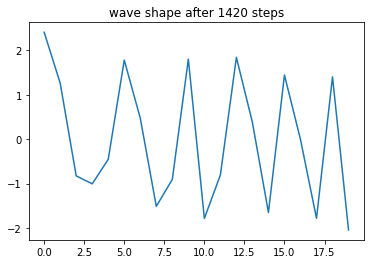

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1420/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1420/model_weights.tf
generator loss:1.7493720117932199
-----------------------
total discriminator loss:0.40913762804527776
average true return:0.4920993091007417
-----------------------


 91%|█████████ | 1421/1562 [2:51:18<30:32, 13.00s/it]

Training Step: 1421
generator loss:1.856808195933723
-----------------------
total discriminator loss:0.422906761572454
average true return:0.46069057450175266
-----------------------


 91%|█████████ | 1422/1562 [2:51:22<24:33, 10.52s/it]

Training Step: 1422
generator loss:1.797033507910113
-----------------------
total discriminator loss:0.42233439470126477
average true return:0.49763170324144335
-----------------------


 91%|█████████ | 1423/1562 [2:51:27<20:15,  8.74s/it]

Training Step: 1423
generator loss:1.6479097540296
-----------------------
total discriminator loss:1.4760940879237352
average true return:0.543307364773866
-----------------------


 91%|█████████ | 1424/1562 [2:51:32<17:18,  7.53s/it]

Training Step: 1424
generator loss:1.1510654341945836
-----------------------
total discriminator loss:0.5017323893813666
average true return:0.6379804265742601
-----------------------


 91%|█████████ | 1425/1562 [2:51:37<15:22,  6.74s/it]

Training Step: 1425
event_types: [2, 0, 2, 2, 2, 0, 2, 0, 3, 2, 0, 3, 2, 0, 3, 2, 0, 3, 0, 2]
mad_score: 0.6168875
fid_score: 1411.7770001290914
rule_score: 0.231


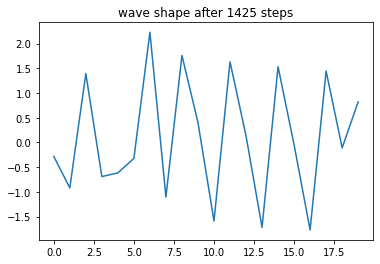

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1425/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1425/model_weights.tf
generator loss:1.0478494509928016
-----------------------
total discriminator loss:0.4889038334317939
average true return:0.6248891167384674
-----------------------


 91%|█████████▏| 1426/1562 [2:52:03<28:26, 12.54s/it]

Training Step: 1426
generator loss:1.5784486052553004
-----------------------
total discriminator loss:0.43454243442858564
average true return:0.5195290331481376
-----------------------


 91%|█████████▏| 1427/1562 [2:52:08<22:58, 10.21s/it]

Training Step: 1427
generator loss:2.1580245933962656
-----------------------
total discriminator loss:0.4306642062016227
average true return:0.411801199999384
-----------------------


 91%|█████████▏| 1428/1562 [2:52:12<19:07,  8.56s/it]

Training Step: 1428
generator loss:2.3756721066380027
-----------------------
total discriminator loss:0.49681100935113015
average true return:0.38046452911708534
-----------------------


 91%|█████████▏| 1429/1562 [2:52:17<16:20,  7.37s/it]

Training Step: 1429
generator loss:2.0528901447041066
-----------------------
total discriminator loss:0.4349596607047659
average true return:0.45654543311859164
-----------------------


 92%|█████████▏| 1430/1562 [2:52:22<14:32,  6.61s/it]

Training Step: 1430
event_types: [1, 1, 2, 2, 2, 2, 2, 3, 2, 1, 0, 3, 2, 1, 1, 1, 0, 3, 2, 1]
mad_score: 0.6188625
fid_score: 1038.0301576582629
rule_score: 0.299


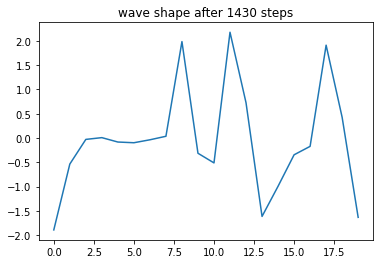

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1430/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1430/model_weights.tf
generator loss:1.475671629615595
-----------------------
total discriminator loss:0.43820608783521137
average true return:0.5111862809082077
-----------------------


 92%|█████████▏| 1431/1562 [2:52:49<28:14, 12.93s/it]

Training Step: 1431
generator loss:1.2450765252908922
-----------------------
total discriminator loss:0.4709166029501854
average true return:0.5830557986051339
-----------------------


 92%|█████████▏| 1432/1562 [2:52:54<22:49, 10.54s/it]

Training Step: 1432
generator loss:1.3078649494328762
-----------------------
total discriminator loss:0.4567781868446302
average true return:0.5659859088767367
-----------------------


 92%|█████████▏| 1433/1562 [2:52:59<19:01,  8.85s/it]

Training Step: 1433
generator loss:1.7755568636190942
-----------------------
total discriminator loss:0.4286620660802788
average true return:0.4738385331191003
-----------------------


 92%|█████████▏| 1434/1562 [2:53:04<16:09,  7.57s/it]

Training Step: 1434
generator loss:2.064563499611785
-----------------------
total discriminator loss:0.45642688785719754
average true return:0.4285607393199341
-----------------------


 92%|█████████▏| 1435/1562 [2:53:08<14:02,  6.64s/it]

Training Step: 1435
event_types: [1, 1, 2, 2, 2, 1, 0, 3, 2, 1, 1, 1, 2, 1, 2, 2, 0, 2, 1, 0]
mad_score: 0.621075
fid_score: 770.6643101854611
rule_score: 0.3375


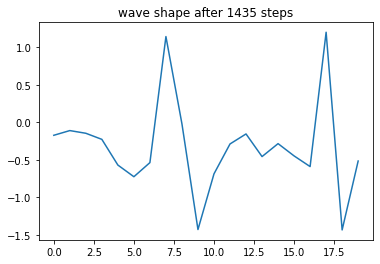

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1435/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1435/model_weights.tf
generator loss:2.0556917251375153
-----------------------
total discriminator loss:0.47849240023818984
average true return:0.41840275653524134
-----------------------


 92%|█████████▏| 1436/1562 [2:53:33<25:23, 12.09s/it]

Training Step: 1436
generator loss:1.6752000769667887
-----------------------
total discriminator loss:0.43127341326721186
average true return:0.4893326020722296
-----------------------


 92%|█████████▏| 1437/1562 [2:53:38<20:34,  9.88s/it]

Training Step: 1437
generator loss:1.472512729445572
-----------------------
total discriminator loss:0.4691361415182727
average true return:0.5445545128815938
-----------------------


 92%|█████████▏| 1438/1562 [2:53:43<17:16,  8.36s/it]

Training Step: 1438
generator loss:1.4140292785332766
-----------------------
total discriminator loss:0.45474007850986764
average true return:0.5493065653217297
-----------------------


 92%|█████████▏| 1439/1562 [2:53:47<14:52,  7.26s/it]

Training Step: 1439
generator loss:1.514736976405834
-----------------------
total discriminator loss:0.43456080793781965
average true return:0.5326073650286391
-----------------------


 92%|█████████▏| 1440/1562 [2:53:52<13:20,  6.56s/it]

Training Step: 1440
event_types: [0, 2, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2]
mad_score: 0.6245375
fid_score: 717.6658088855659
rule_score: 0.35225


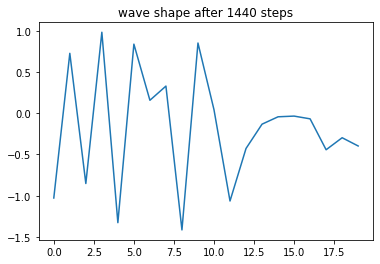

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1440/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1440/model_weights.tf
generator loss:1.8285594153540474
-----------------------
total discriminator loss:0.45954300689112765
average true return:0.46103623166488816
-----------------------


 92%|█████████▏| 1441/1562 [2:54:18<24:59, 12.40s/it]

Training Step: 1441
generator loss:1.9455210315972
-----------------------
total discriminator loss:0.4368592135691242
average true return:0.43925740660433105
-----------------------


 92%|█████████▏| 1442/1562 [2:54:23<20:10, 10.09s/it]

Training Step: 1442
generator loss:1.8959576085266465
-----------------------
total discriminator loss:0.43090571146214685
average true return:0.43886253896636057
-----------------------


 92%|█████████▏| 1443/1562 [2:54:28<16:55,  8.53s/it]

Training Step: 1443
generator loss:1.627148670625021
-----------------------
total discriminator loss:0.425802313248849
average true return:0.4773781106165225
-----------------------


 92%|█████████▏| 1444/1562 [2:54:33<14:35,  7.42s/it]

Training Step: 1444
generator loss:1.5060748264074149
-----------------------
total discriminator loss:0.42792323052032977
average true return:0.529417423876836
-----------------------


 93%|█████████▎| 1445/1562 [2:54:37<12:53,  6.61s/it]

Training Step: 1445
event_types: [1, 0, 3, 3, 2, 0, 2, 1, 0, 2, 1, 1, 0, 3, 2, 0, 3, 2, 0, 3]
mad_score: 0.62665
fid_score: 726.3984273579069
rule_score: 0.38675


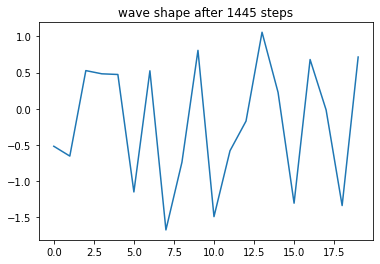

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1445/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1445/model_weights.tf
generator loss:1.49694379724548
-----------------------
total discriminator loss:0.4517979639398984
average true return:0.5329421815697628
-----------------------


 93%|█████████▎| 1446/1562 [2:55:04<24:19, 12.58s/it]

Training Step: 1446
generator loss:1.563243462025878
-----------------------
total discriminator loss:0.459280518535521
average true return:0.5282346822153346
-----------------------


 93%|█████████▎| 1447/1562 [2:55:09<19:35, 10.22s/it]

Training Step: 1447
generator loss:1.7050546148169055
-----------------------
total discriminator loss:0.431018767915251
average true return:0.4937578734160003
-----------------------


 93%|█████████▎| 1448/1562 [2:55:14<16:42,  8.79s/it]

Training Step: 1448
generator loss:1.8203561510286295
-----------------------
total discriminator loss:0.45178065768147824
average true return:0.4549125523401397
-----------------------


 93%|█████████▎| 1449/1562 [2:55:19<14:26,  7.67s/it]

Training Step: 1449
generator loss:1.8481439555287258
-----------------------
total discriminator loss:0.43415136803726134
average true return:0.4544446473698097
-----------------------


 93%|█████████▎| 1450/1562 [2:55:24<12:50,  6.88s/it]

Training Step: 1450
event_types: [2, 0, 2, 0, 3, 2, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 0, 3, 2, 2]
mad_score: 0.61875
fid_score: 819.1318914016749
rule_score: 0.4125


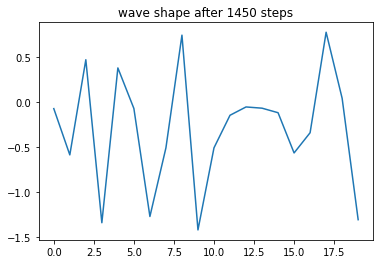

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1450/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1450/model_weights.tf
generator loss:1.7069930790226375
-----------------------
total discriminator loss:0.4154397645455488
average true return:0.493436137725521
-----------------------


 93%|█████████▎| 1451/1562 [2:55:50<23:16, 12.58s/it]

Training Step: 1451
generator loss:1.4684220888768602
-----------------------
total discriminator loss:0.40617188834529655
average true return:0.5164903800910401
-----------------------


 93%|█████████▎| 1452/1562 [2:55:55<18:55, 10.32s/it]

Training Step: 1452
generator loss:1.38735733714666
-----------------------
total discriminator loss:0.42243188982034574
average true return:0.5343909652387941
-----------------------


 93%|█████████▎| 1453/1562 [2:56:00<15:44,  8.66s/it]

Training Step: 1453
generator loss:1.4616450336770122
-----------------------
total discriminator loss:0.4476162357975879
average true return:0.558577684008293
-----------------------


 93%|█████████▎| 1454/1562 [2:56:05<13:26,  7.47s/it]

Training Step: 1454
generator loss:1.5327120989201828
-----------------------
total discriminator loss:0.4344010951141336
average true return:0.5400523797807087
-----------------------


 93%|█████████▎| 1455/1562 [2:56:09<11:53,  6.67s/it]

Training Step: 1455
event_types: [2, 3, 2, 3, 2, 1, 1, 2, 2, 2, 2, 3, 3, 2, 0, 3, 3, 3, 2, 0]
mad_score: 0.6060625
fid_score: 814.557190453938
rule_score: 0.41875


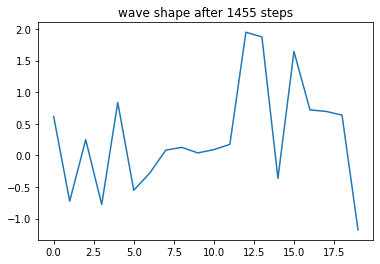

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1455/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1455/model_weights.tf
generator loss:1.59787818874114
-----------------------
total discriminator loss:0.4042663433794366
average true return:0.5034451360289667
-----------------------


 93%|█████████▎| 1456/1562 [2:56:36<22:10, 12.56s/it]

Training Step: 1456
generator loss:1.6869067144066618
-----------------------
total discriminator loss:0.41887586152381984
average true return:0.4998115316514503
-----------------------


 93%|█████████▎| 1457/1562 [2:56:41<17:55, 10.25s/it]

Training Step: 1457
generator loss:1.7798434108980836
-----------------------
total discriminator loss:0.41604254722654044
average true return:0.4775774540612375
-----------------------


 93%|█████████▎| 1458/1562 [2:56:45<14:57,  8.63s/it]

Training Step: 1458
generator loss:1.7848352712314999
-----------------------
total discriminator loss:0.40629250928630717
average true return:0.5059286181088052
-----------------------


 93%|█████████▎| 1459/1562 [2:56:50<12:51,  7.49s/it]

Training Step: 1459
generator loss:1.8331685968538727
-----------------------
total discriminator loss:0.4087067528328509
average true return:0.47259367830993637
-----------------------


 93%|█████████▎| 1460/1562 [2:56:55<11:10,  6.58s/it]

Training Step: 1460
event_types: [2, 2, 3, 3, 2, 1, 0, 3, 0, 2, 0, 2, 1, 0, 3, 2, 1, 1, 2, 1]
mad_score: 0.591425
fid_score: 771.4927078302453
rule_score: 0.45475


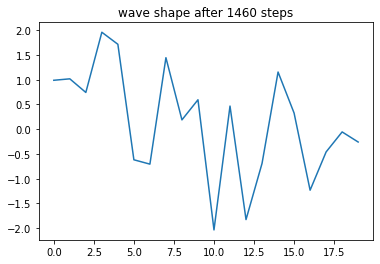

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1460/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1460/model_weights.tf
generator loss:1.7947298879250662
-----------------------
total discriminator loss:0.4405874904099375
average true return:0.5143296996993216
-----------------------


 94%|█████████▎| 1461/1562 [2:57:20<20:28, 12.17s/it]

Training Step: 1461
generator loss:1.6812295497277745
-----------------------
total discriminator loss:0.3787779206732009
average true return:0.4955251179177652
-----------------------


 94%|█████████▎| 1462/1562 [2:57:25<16:35,  9.95s/it]

Training Step: 1462
generator loss:1.7594459715567314
-----------------------
total discriminator loss:0.4341449720053848
average true return:0.48569722479456645
-----------------------


 94%|█████████▎| 1463/1562 [2:57:29<13:49,  8.38s/it]

Training Step: 1463
generator loss:1.697132306712737
-----------------------
total discriminator loss:0.4425208994797136
average true return:0.5319994869910718
-----------------------


 94%|█████████▎| 1464/1562 [2:57:34<11:54,  7.29s/it]

Training Step: 1464
generator loss:1.6742302318990232
-----------------------
total discriminator loss:0.43720026157448516
average true return:0.49078060567881354
-----------------------


 94%|█████████▍| 1465/1562 [2:57:39<10:29,  6.49s/it]

Training Step: 1465
event_types: [1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 1, 1, 1, 2, 1]
mad_score: 0.57975
fid_score: 699.4629917799303
rule_score: 0.46475


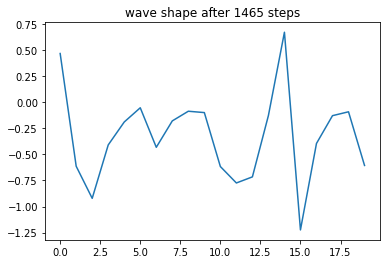

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1465/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1465/model_weights.tf
generator loss:1.8933760983814865
-----------------------
total discriminator loss:0.4284797649901022
average true return:0.5025427144491639
-----------------------


 94%|█████████▍| 1466/1562 [2:58:07<20:46, 12.99s/it]

Training Step: 1466
generator loss:1.7385596343185075
-----------------------
total discriminator loss:0.4017236616537684
average true return:0.5037345496925958
-----------------------


 94%|█████████▍| 1467/1562 [2:58:12<16:40, 10.53s/it]

Training Step: 1467
generator loss:1.7133777604835216
-----------------------
total discriminator loss:0.417891725591879
average true return:0.5046173402891951
-----------------------


 94%|█████████▍| 1468/1562 [2:58:17<13:50,  8.84s/it]

Training Step: 1468
generator loss:1.8195940234055659
-----------------------
total discriminator loss:0.43733943970644845
average true return:0.5277533892497412
-----------------------


 94%|█████████▍| 1469/1562 [2:58:21<11:53,  7.67s/it]

Training Step: 1469
generator loss:1.8506083611410797
-----------------------
total discriminator loss:0.4223194875704294
average true return:0.49838220825809837
-----------------------


 94%|█████████▍| 1470/1562 [2:58:26<10:21,  6.75s/it]

Training Step: 1470
event_types: [2, 1, 0, 2, 1, 0, 3, 2, 1, 0, 2, 0, 3, 2, 0, 2, 0, 2, 0, 3]
mad_score: 0.5691
fid_score: 613.0147797620767
rule_score: 0.48875


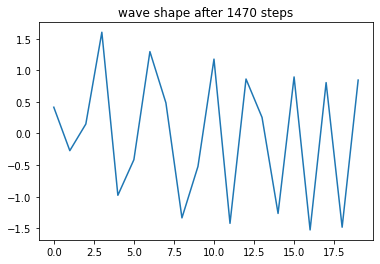

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1470/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1470/model_weights.tf
generator loss:1.7079497506654788
-----------------------
total discriminator loss:0.4387621199884191
average true return:0.5051309464999115
-----------------------


 94%|█████████▍| 1471/1562 [2:58:52<19:06, 12.60s/it]

Training Step: 1471
generator loss:1.946128083765978
-----------------------
total discriminator loss:0.4509793126643381
average true return:0.466921895007257
-----------------------


 94%|█████████▍| 1472/1562 [2:58:57<15:27, 10.31s/it]

Training Step: 1472
generator loss:1.8908716223635906
-----------------------
total discriminator loss:0.4298670145544129
average true return:0.4991290763542282
-----------------------


 94%|█████████▍| 1473/1562 [2:59:02<12:46,  8.61s/it]

Training Step: 1473
generator loss:1.8322099104080425
-----------------------
total discriminator loss:0.47315406703618457
average true return:0.5195737607356057
-----------------------


 94%|█████████▍| 1474/1562 [2:59:07<10:59,  7.49s/it]

Training Step: 1474
generator loss:1.7901315388899277
-----------------------
total discriminator loss:0.44689684740603863
average true return:0.5301996051116731
-----------------------


 94%|█████████▍| 1475/1562 [2:59:12<09:46,  6.74s/it]

Training Step: 1475
event_types: [1, 1, 2, 2, 1, 2, 2, 2, 3, 2, 0, 3, 2, 0, 3, 0, 2, 0, 3, 2]
mad_score: 0.5608125
fid_score: 501.7085876468723
rule_score: 0.49


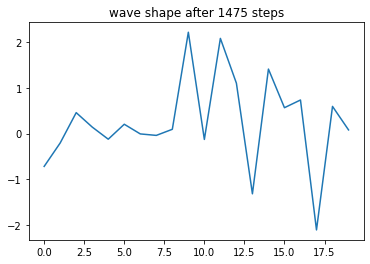

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1475/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1475/model_weights.tf
generator loss:1.8523594251747324
-----------------------
total discriminator loss:0.4661111508626925
average true return:0.5130034022596304
-----------------------


 94%|█████████▍| 1476/1562 [2:59:38<18:02, 12.58s/it]

Training Step: 1476
generator loss:1.9079953370561198
-----------------------
total discriminator loss:0.41294049757644274
average true return:0.49648505363234574
-----------------------


 95%|█████████▍| 1477/1562 [2:59:43<14:31, 10.25s/it]

Training Step: 1477
generator loss:2.086762350348804
-----------------------
total discriminator loss:0.4461370751823546
average true return:0.47591218957301307
-----------------------


 95%|█████████▍| 1478/1562 [2:59:47<11:59,  8.56s/it]

Training Step: 1478
generator loss:1.9843101985969773
-----------------------
total discriminator loss:0.4750012320959144
average true return:0.4837518838963858
-----------------------


 95%|█████████▍| 1479/1562 [2:59:52<10:20,  7.47s/it]

Training Step: 1479
generator loss:1.7263978859679816
-----------------------
total discriminator loss:0.4573344025892176
average true return:0.5327378432377231
-----------------------


 95%|█████████▍| 1480/1562 [2:59:57<09:04,  6.64s/it]

Training Step: 1480
event_types: [0, 2, 0, 2, 0, 3, 2, 2, 0, 3, 0, 2, 0, 2, 0, 2, 1, 0, 2, 1]
mad_score: 0.559
fid_score: 455.1811891113105
rule_score: 0.47325


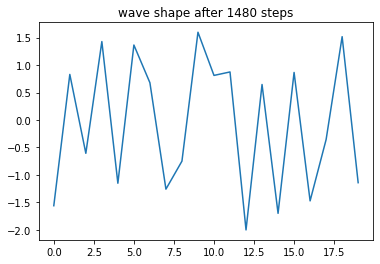

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1480/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1480/model_weights.tf
generator loss:1.632108045230924
-----------------------
total discriminator loss:0.43153576189868353
average true return:0.5235562215516097
-----------------------


 95%|█████████▍| 1481/1562 [3:00:24<17:01, 12.62s/it]

Training Step: 1481
generator loss:1.6824193297445662
-----------------------
total discriminator loss:0.4635259458287434
average true return:0.5427988230232889
-----------------------


 95%|█████████▍| 1482/1562 [3:00:29<13:43, 10.30s/it]

Training Step: 1482
generator loss:1.873407602220564
-----------------------
total discriminator loss:0.4679692082903302
average true return:0.49336860933021076
-----------------------


 95%|█████████▍| 1483/1562 [3:00:33<11:26,  8.69s/it]

Training Step: 1483
generator loss:1.9462246456882175
-----------------------
total discriminator loss:0.4403993815174865
average true return:0.45356897828485876
-----------------------


 95%|█████████▌| 1484/1562 [3:00:38<09:45,  7.51s/it]

Training Step: 1484
generator loss:1.8511310078438015
-----------------------
total discriminator loss:0.4265773228573712
average true return:0.5097377999111876
-----------------------


 95%|█████████▌| 1485/1562 [3:00:43<08:43,  6.79s/it]

Training Step: 1485
event_types: [2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 3, 2, 0]
mad_score: 0.5529375
fid_score: 552.4786499413028
rule_score: 0.4495


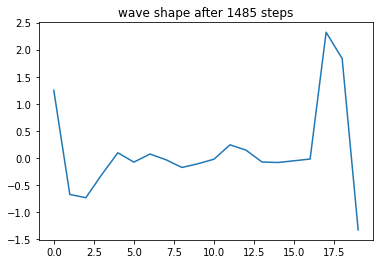

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1485/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1485/model_weights.tf
generator loss:1.9196906193048213
-----------------------
total discriminator loss:0.3971451683967963
average true return:0.4972513818591844
-----------------------


 95%|█████████▌| 1486/1562 [3:01:03<13:30, 10.67s/it]

Training Step: 1486
generator loss:1.7163304311332743
-----------------------
total discriminator loss:0.4604692321715355
average true return:0.5095118124683866
-----------------------


 95%|█████████▌| 1487/1562 [3:01:05<10:13,  8.18s/it]

Training Step: 1487
generator loss:1.714706303634662
-----------------------
total discriminator loss:0.441269719996452
average true return:0.5076961176520753
-----------------------


 95%|█████████▌| 1488/1562 [3:01:08<07:56,  6.44s/it]

Training Step: 1488
generator loss:1.590849729376028
-----------------------
total discriminator loss:0.43795798075280656
average true return:0.5317998234705813
-----------------------


 95%|█████████▌| 1489/1562 [3:01:10<06:20,  5.22s/it]

Training Step: 1489
generator loss:1.7487334709679638
-----------------------
total discriminator loss:0.44707007616730743
average true return:0.5340110619048501
-----------------------


 95%|█████████▌| 1490/1562 [3:01:13<05:13,  4.36s/it]

Training Step: 1490
event_types: [3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 0, 2, 0, 2, 0]
mad_score: 0.5485375
fid_score: 788.9068906524166
rule_score: 0.39725


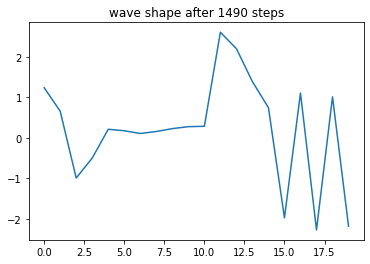

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1490/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1490/model_weights.tf
generator loss:1.715797663557711
-----------------------
total discriminator loss:0.45081005488450937
average true return:0.5099492929589231
-----------------------


 95%|█████████▌| 1491/1562 [3:01:26<08:31,  7.21s/it]

Training Step: 1491
generator loss:1.841396015940445
-----------------------
total discriminator loss:0.45872976531626775
average true return:0.468453558078437
-----------------------


 96%|█████████▌| 1492/1562 [3:01:29<06:41,  5.74s/it]

Training Step: 1492
generator loss:1.7313466988989603
-----------------------


 96%|█████████▌| 1493/1562 [3:01:31<05:25,  4.71s/it]

total discriminator loss:0.43143060692698354
average true return:0.49212669384982394
-----------------------
Training Step: 1493
generator loss:1.6387636902816611
-----------------------


 96%|█████████▌| 1494/1562 [3:01:33<04:26,  3.92s/it]

total discriminator loss:0.4405023134690833
average true return:0.5233671677113003
-----------------------
Training Step: 1494
generator loss:1.5107597751495339
-----------------------
total discriminator loss:0.44125357129508963
average true return:0.5721111182854237
-----------------------


 96%|█████████▌| 1495/1562 [3:01:35<03:48,  3.41s/it]

Training Step: 1495
event_types: [0, 3, 2, 1, 0, 2, 0, 2, 0, 2, 1, 1, 2, 0, 3, 2, 1, 1, 1, 2]
mad_score: 0.5450875
fid_score: 1369.2151326652624
rule_score: 0.3445


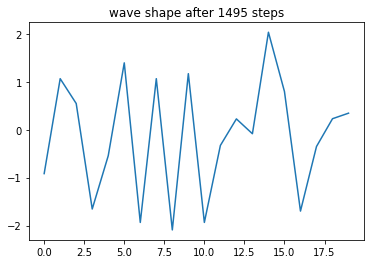

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1495/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1495/model_weights.tf
generator loss:1.5560006180154429
-----------------------
total discriminator loss:0.40117615475312485
average true return:0.5554853159499467
-----------------------


 96%|█████████▌| 1496/1562 [3:01:49<07:12,  6.56s/it]

Training Step: 1496
generator loss:1.741715369407766
-----------------------


 96%|█████████▌| 1497/1562 [3:01:52<05:44,  5.29s/it]

total discriminator loss:0.4435687056909337
average true return:0.4983644177657487
-----------------------
Training Step: 1497
generator loss:1.9507059884412028
-----------------------
total discriminator loss:0.4687659182635189
average true return:0.44635320181326293
-----------------------


 96%|█████████▌| 1498/1562 [3:01:54<04:42,  4.41s/it]

Training Step: 1498
generator loss:1.8831812162966826
-----------------------
total discriminator loss:0.4209266270066645
average true return:0.4708260263131916
-----------------------


 96%|█████████▌| 1499/1562 [3:01:56<03:58,  3.79s/it]

Training Step: 1499
generator loss:1.5657601856089314
-----------------------
total discriminator loss:0.4285432028928049
average true return:0.5395023922795361
-----------------------


 96%|█████████▌| 1500/1562 [3:01:59<03:27,  3.35s/it]

Training Step: 1500
event_types: [2, 2, 1, 0, 3, 2, 0, 3, 2, 0, 3, 0, 2, 0, 2, 0, 2, 0, 3, 2]
mad_score: 0.55395
fid_score: 1912.6525038334667
rule_score: 0.29625


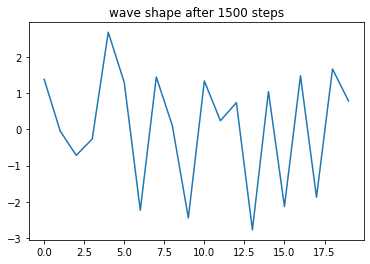

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1500/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1500/model_weights.tf
generator loss:1.4991157418535335
-----------------------
total discriminator loss:0.39638497065165995
average true return:0.5770046979438979
-----------------------


 96%|█████████▌| 1501/1562 [3:02:12<06:22,  6.27s/it]

Training Step: 1501
generator loss:1.6404510295727173
-----------------------
total discriminator loss:0.41866507454146684
average true return:0.5329512580251555
-----------------------


 96%|█████████▌| 1502/1562 [3:02:14<05:05,  5.10s/it]

Training Step: 1502
generator loss:1.7128009172975984
-----------------------
total discriminator loss:0.38589455100838366
average true return:0.5155229750288428
-----------------------


 96%|█████████▌| 1503/1562 [3:02:16<04:12,  4.28s/it]

Training Step: 1503
generator loss:1.8028607208043221
-----------------------
total discriminator loss:0.40658941075364274
average true return:0.4964838871302651
-----------------------


 96%|█████████▋| 1504/1562 [3:02:19<03:34,  3.71s/it]

Training Step: 1504
generator loss:1.7909504378497665
-----------------------
total discriminator loss:1.650701015818452
average true return:0.4936769666361618
-----------------------


 96%|█████████▋| 1505/1562 [3:02:21<03:07,  3.29s/it]

Training Step: 1505
event_types: [2, 0, 3, 2, 0, 3, 2, 0, 3, 2, 0, 2, 0, 3, 2, 0, 3, 1, 1, 2]
mad_score: 0.565575
fid_score: 2208.700242118952
rule_score: 0.27475


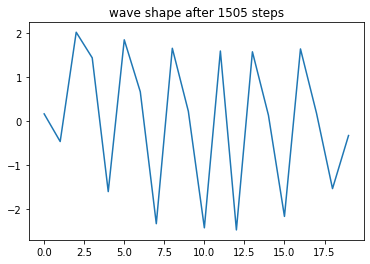

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1505/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1505/model_weights.tf
generator loss:1.8096014477063065
-----------------------


 96%|█████████▋| 1506/1562 [3:02:35<06:01,  6.45s/it]

total discriminator loss:0.44523523911465146
average true return:0.4684664458226911
-----------------------
Training Step: 1506
generator loss:1.766960343081257
-----------------------


 96%|█████████▋| 1507/1562 [3:02:37<04:40,  5.10s/it]

total discriminator loss:0.42450202564433115
average true return:0.47960103608771276
-----------------------
Training Step: 1507
generator loss:1.5949230631283544
-----------------------
total discriminator loss:0.4163243165100047
average true return:0.5192335072214833
-----------------------


 97%|█████████▋| 1508/1562 [3:02:39<03:48,  4.23s/it]

Training Step: 1508
generator loss:1.4668163327016481
-----------------------
total discriminator loss:0.4343896752078298
average true return:0.5281561525977212
-----------------------


 97%|█████████▋| 1509/1562 [3:02:41<03:14,  3.67s/it]

Training Step: 1509
generator loss:1.3464670001597323
-----------------------
total discriminator loss:0.4054231865259298
average true return:0.5634673590763308
-----------------------


 97%|█████████▋| 1510/1562 [3:02:44<02:50,  3.27s/it]

Training Step: 1510
event_types: [2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2]
mad_score: 0.57555
fid_score: 2449.066516118698
rule_score: 0.255


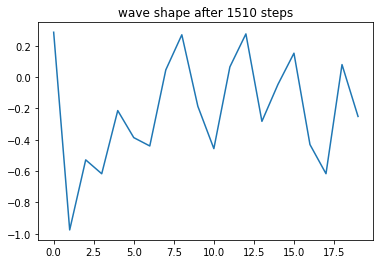

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1510/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1510/model_weights.tf
generator loss:1.3534538466149901
-----------------------
total discriminator loss:0.4165569096476134
average true return:0.5836898918077323
-----------------------


 97%|█████████▋| 1511/1562 [3:02:58<05:28,  6.45s/it]

Training Step: 1511
generator loss:1.467434670282814
-----------------------
total discriminator loss:0.41274177626429515
average true return:0.5592153439693754
-----------------------


 97%|█████████▋| 1512/1562 [3:03:00<04:20,  5.21s/it]

Training Step: 1512
generator loss:1.5500316000352314
-----------------------
total discriminator loss:0.39982795972370944
average true return:0.5308998105161729
-----------------------


 97%|█████████▋| 1513/1562 [3:03:02<03:32,  4.35s/it]

Training Step: 1513
generator loss:1.6496326635038392
-----------------------
total discriminator loss:0.4140021378043787
average true return:0.5060592722645793
-----------------------


 97%|█████████▋| 1514/1562 [3:03:05<02:59,  3.75s/it]

Training Step: 1514
generator loss:1.7285020735887155
-----------------------
total discriminator loss:0.42028063705861035
average true return:0.4877263268885399
-----------------------


 97%|█████████▋| 1515/1562 [3:03:07<02:41,  3.44s/it]

Training Step: 1515
event_types: [2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 3, 2, 3, 2, 0, 3, 1, 0, 3, 0]
mad_score: 0.5865625
fid_score: 2202.531082465087
rule_score: 0.2845


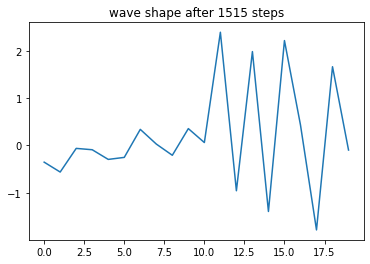

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1515/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1515/model_weights.tf
generator loss:1.7998567125959373
-----------------------
total discriminator loss:1.6730539583345063
average true return:0.5020765417437243
-----------------------


 97%|█████████▋| 1516/1562 [3:03:21<04:55,  6.41s/it]

Training Step: 1516
generator loss:1.823271667944701
-----------------------
total discriminator loss:0.39209500336961317
average true return:0.49811645366579643
-----------------------


 97%|█████████▋| 1517/1562 [3:03:23<03:54,  5.20s/it]

Training Step: 1517
generator loss:1.8001537699374834
-----------------------
total discriminator loss:0.40711929928847723
average true return:0.5073196010258809
-----------------------


 97%|█████████▋| 1518/1562 [3:03:25<03:11,  4.35s/it]

Training Step: 1518
generator loss:1.730891526603966
-----------------------
total discriminator loss:1.6396367942864212
average true return:0.49570446094253995
-----------------------


 97%|█████████▋| 1519/1562 [3:03:28<02:42,  3.78s/it]

Training Step: 1519
generator loss:1.560097652037105
-----------------------
total discriminator loss:0.40341245457468333
average true return:0.5047861482292656
-----------------------


 97%|█████████▋| 1520/1562 [3:03:30<02:20,  3.35s/it]

Training Step: 1520
event_types: [2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2]
mad_score: 0.5985625
fid_score: 1982.5041694996723
rule_score: 0.30025


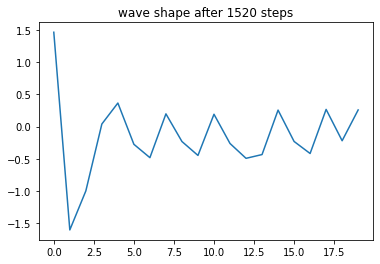

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1520/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1520/model_weights.tf
generator loss:1.5808987055338535
-----------------------


 97%|█████████▋| 1521/1562 [3:03:43<04:15,  6.23s/it]

total discriminator loss:0.42099237683040636
average true return:0.5066955773857291
-----------------------
Training Step: 1521
generator loss:1.5762160776767637
-----------------------
total discriminator loss:0.40658735655471734
average true return:0.5169890474367067
-----------------------


 97%|█████████▋| 1522/1562 [3:03:46<03:22,  5.06s/it]

Training Step: 1522
generator loss:1.5604493305750118
-----------------------
total discriminator loss:0.4217565934458811
average true return:0.5069064570784776
-----------------------


 98%|█████████▊| 1523/1562 [3:03:48<02:45,  4.25s/it]

Training Step: 1523
generator loss:1.575120188300093
-----------------------
total discriminator loss:0.4141419469316822
average true return:0.5123102848411605
-----------------------


 98%|█████████▊| 1524/1562 [3:03:50<02:19,  3.68s/it]

Training Step: 1524
generator loss:1.515455256582986
-----------------------
total discriminator loss:0.42691152891268125
average true return:0.5177813733048288
-----------------------


 98%|█████████▊| 1525/1562 [3:03:53<02:01,  3.28s/it]

Training Step: 1525
event_types: [2, 2, 2, 3, 2, 3, 3, 3, 2, 0, 3, 2, 1, 0, 2, 0, 2, 1, 2, 1]
mad_score: 0.611725
fid_score: 1683.3750844476178
rule_score: 0.3075


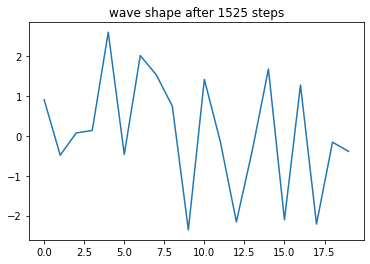

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1525/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1525/model_weights.tf
generator loss:1.488213538871174
-----------------------
total discriminator loss:0.3957924906636746
average true return:0.5170410048858052
-----------------------


 98%|█████████▊| 1526/1562 [3:04:07<03:53,  6.50s/it]

Training Step: 1526
generator loss:1.5757793114882817
-----------------------
total discriminator loss:0.4006003604947169
average true return:0.5064098762931026
-----------------------


 98%|█████████▊| 1527/1562 [3:04:09<03:03,  5.25s/it]

Training Step: 1527
generator loss:1.6710862564715
-----------------------
total discriminator loss:0.4208940204790448
average true return:0.5026537236718434
-----------------------


 98%|█████████▊| 1528/1562 [3:04:11<02:28,  4.38s/it]

Training Step: 1528
generator loss:1.6971152440990322
-----------------------


 98%|█████████▊| 1529/1562 [3:04:13<02:01,  3.67s/it]

total discriminator loss:0.40423042681124943
average true return:0.4847649153126554
-----------------------
Training Step: 1529
generator loss:1.708476264759427
-----------------------


 98%|█████████▊| 1530/1562 [3:04:15<01:43,  3.22s/it]

total discriminator loss:0.40593115262257695
average true return:0.4819458281459325
-----------------------
Training Step: 1530
event_types: [2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 0]
mad_score: 0.6200875
fid_score: 1484.7213772560224
rule_score: 0.333


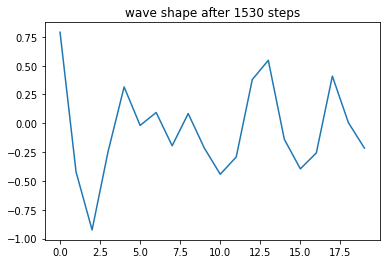

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1530/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1530/model_weights.tf
generator loss:1.708736175827624
-----------------------
total discriminator loss:0.424283815272964
average true return:0.499898339616707
-----------------------


 98%|█████████▊| 1531/1562 [3:04:29<03:19,  6.43s/it]

Training Step: 1531
generator loss:1.6831576774104744
-----------------------
total discriminator loss:0.45390164356245655
average true return:0.48983968738937433
-----------------------


 98%|█████████▊| 1532/1562 [3:04:32<02:36,  5.21s/it]

Training Step: 1532
generator loss:1.7025864788378327
-----------------------
total discriminator loss:0.43880763862751926
average true return:0.4951032287246415
-----------------------


 98%|█████████▊| 1533/1562 [3:04:34<02:06,  4.35s/it]

Training Step: 1533
generator loss:1.7353245221532831
-----------------------
total discriminator loss:0.4132861029333713
average true return:0.49296332452737285
-----------------------


 98%|█████████▊| 1534/1562 [3:04:36<01:45,  3.76s/it]

Training Step: 1534
generator loss:1.8563947065305229
-----------------------
total discriminator loss:0.40535768112030124
average true return:0.48024937403666534
-----------------------


 98%|█████████▊| 1535/1562 [3:04:39<01:30,  3.34s/it]

Training Step: 1535
event_types: [0, 2, 0, 2, 0, 3, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 0, 2]
mad_score: 0.62155
fid_score: 1128.9967681709131
rule_score: 0.34625


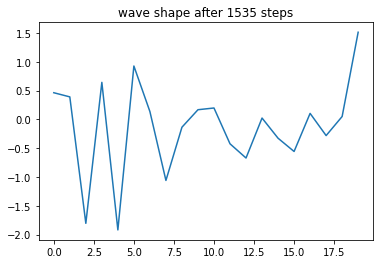

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1535/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1535/model_weights.tf
generator loss:1.8739134779131548
-----------------------
total discriminator loss:0.42662314327665485
average true return:0.44457767424180583
-----------------------


 98%|█████████▊| 1536/1562 [3:04:52<02:42,  6.25s/it]

Training Step: 1536
generator loss:1.8503840423088387
-----------------------
total discriminator loss:0.40860826079699974
average true return:0.47930422948220497
-----------------------


 98%|█████████▊| 1537/1562 [3:04:54<02:07,  5.08s/it]

Training Step: 1537
generator loss:1.699352532855022
-----------------------
total discriminator loss:0.4191318210142192
average true return:0.5046445568441875
-----------------------


 98%|█████████▊| 1538/1562 [3:04:57<01:42,  4.26s/it]

Training Step: 1538
generator loss:1.692299245474349
-----------------------
total discriminator loss:0.40677956580092955
average true return:0.4832184386292615
-----------------------


 99%|█████████▊| 1539/1562 [3:04:59<01:24,  3.69s/it]

Training Step: 1539
generator loss:1.6627441541429955
-----------------------
total discriminator loss:0.4203684153700424
average true return:0.4955869919820105
-----------------------


 99%|█████████▊| 1540/1562 [3:05:01<01:12,  3.28s/it]

Training Step: 1540
event_types: [3, 2, 0, 3, 2, 0, 3, 2, 0, 3, 3, 2, 0, 3, 1, 0, 2, 1, 0, 3]
mad_score: 0.6275625
fid_score: 982.5209698344063
rule_score: 0.3385


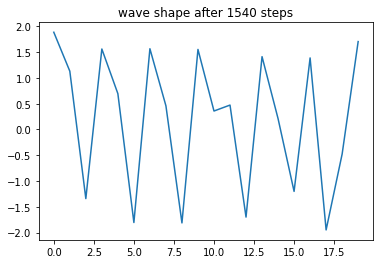

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1540/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1540/model_weights.tf
generator loss:1.5491105918839445
-----------------------
total discriminator loss:0.4274564404777921
average true return:0.500748879968446
-----------------------


 99%|█████████▊| 1541/1562 [3:05:15<02:15,  6.45s/it]

Training Step: 1541
generator loss:1.7163941947882704
-----------------------


 99%|█████████▊| 1542/1562 [3:05:17<01:42,  5.12s/it]

total discriminator loss:0.42687971092505256
average true return:0.5210344806862184
-----------------------
Training Step: 1542
generator loss:1.7681724091016595
-----------------------


 99%|█████████▉| 1543/1562 [3:05:19<01:20,  4.22s/it]

total discriminator loss:0.44645523682031163
average true return:0.4714263243963428
-----------------------
Training Step: 1543
generator loss:1.7544921575775385
-----------------------
total discriminator loss:0.4035092105595714
average true return:0.4768207778109831
-----------------------


 99%|█████████▉| 1544/1562 [3:05:22<01:06,  3.69s/it]

Training Step: 1544
generator loss:1.6581817761155826
-----------------------
total discriminator loss:0.4479320772283141
average true return:0.4997030284547508
-----------------------


 99%|█████████▉| 1545/1562 [3:05:24<00:55,  3.29s/it]

Training Step: 1545
event_types: [3, 3, 2, 1, 0, 3, 2, 0, 3, 0, 2, 0, 2, 0, 3, 0, 2, 0, 3, 0]
mad_score: 0.62915
fid_score: 778.8185434284183
rule_score: 0.3515


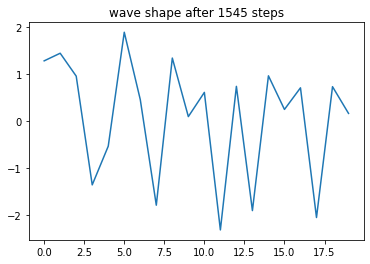

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1545/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1545/model_weights.tf
generator loss:1.6844832969009107
-----------------------
total discriminator loss:0.4485961289051654
average true return:0.47469099803051007
-----------------------


 99%|█████████▉| 1546/1562 [3:05:38<01:43,  6.47s/it]

Training Step: 1546
generator loss:1.7443396076808373
-----------------------
total discriminator loss:0.4479637228357989
average true return:0.5184125666955779
-----------------------


 99%|█████████▉| 1547/1562 [3:05:40<01:18,  5.24s/it]

Training Step: 1547
generator loss:1.6519211555989275
-----------------------
total discriminator loss:0.42369925501299244
average true return:0.4982600014736312
-----------------------


 99%|█████████▉| 1548/1562 [3:05:43<01:01,  4.37s/it]

Training Step: 1548
generator loss:1.6164373929117826
-----------------------
total discriminator loss:0.41879732676122705
average true return:0.502697697225203
-----------------------


 99%|█████████▉| 1549/1562 [3:05:45<00:48,  3.77s/it]

Training Step: 1549
generator loss:1.7514229616500323
-----------------------
total discriminator loss:0.4336726981429089
average true return:0.4798652789120879
-----------------------


 99%|█████████▉| 1550/1562 [3:05:47<00:40,  3.34s/it]

Training Step: 1550
event_types: [0, 0, 2, 0, 0, 3, 0, 2, 0, 1, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0]
mad_score: 0.63405
fid_score: 725.4650712094196
rule_score: 0.34725


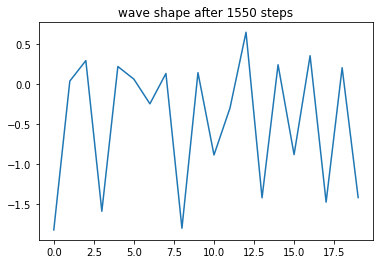

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1550/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1550/model_weights.tf
generator loss:1.9078713533140494
-----------------------
total discriminator loss:0.4173163614659916
average true return:0.45054290357471194
-----------------------


 99%|█████████▉| 1551/1562 [3:06:01<01:10,  6.40s/it]

Training Step: 1551
generator loss:1.7140330220651927
-----------------------
total discriminator loss:1.522033078695519
average true return:0.4805293855595638
-----------------------


 99%|█████████▉| 1552/1562 [3:06:03<00:51,  5.19s/it]

Training Step: 1552
generator loss:1.3865078922222889
-----------------------
total discriminator loss:0.503984081025034
average true return:0.6029669843383513
-----------------------


 99%|█████████▉| 1553/1562 [3:06:06<00:39,  4.34s/it]

Training Step: 1553
generator loss:1.2905504126433096
-----------------------
total discriminator loss:0.5119672851316456
average true return:0.5975195515679887
-----------------------


 99%|█████████▉| 1554/1562 [3:06:08<00:29,  3.75s/it]

Training Step: 1554
generator loss:1.5150318219573986
-----------------------
total discriminator loss:0.4282287663377234
average true return:0.5253290963849391
-----------------------


100%|█████████▉| 1555/1562 [3:06:10<00:23,  3.32s/it]

Training Step: 1555
event_types: [0, 2, 0, 2, 0, 2, 0, 3, 0, 2, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0]
mad_score: 0.63745
fid_score: 820.9351557997772
rule_score: 0.37075


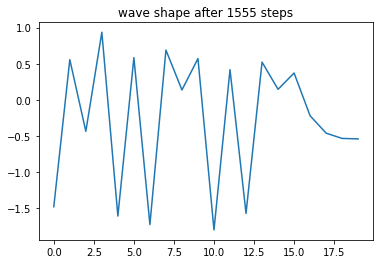

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1555/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1555/model_weights.tf
generator loss:1.9811403557635787
-----------------------
total discriminator loss:0.45723608471368693
average true return:0.4335190887254347
-----------------------


100%|█████████▉| 1556/1562 [3:06:23<00:37,  6.25s/it]

Training Step: 1556
generator loss:2.0892290391912605
-----------------------
total discriminator loss:0.45814805823581006
average true return:0.4018915667400551
-----------------------


100%|█████████▉| 1557/1562 [3:06:26<00:25,  5.08s/it]

Training Step: 1557
generator loss:2.0233648189026345
-----------------------
total discriminator loss:0.4365205936920272
average true return:0.4303099475625364
-----------------------


100%|█████████▉| 1558/1562 [3:06:28<00:17,  4.26s/it]

Training Step: 1558
generator loss:1.575268561773603
-----------------------
total discriminator loss:0.42741635034914294
average true return:0.4759667678941723
-----------------------


100%|█████████▉| 1559/1562 [3:06:30<00:11,  3.69s/it]

Training Step: 1559
generator loss:1.2484560413729624
-----------------------
total discriminator loss:0.4582938053800671
average true return:0.5621721402166744
-----------------------


100%|█████████▉| 1560/1562 [3:06:33<00:06,  3.30s/it]

Training Step: 1560
event_types: [0, 3, 2, 0, 2, 0, 3, 2, 1, 0, 2, 0, 0, 3, 0, 2, 0, 3, 1, 0]
mad_score: 0.643725
fid_score: 1031.66750666824
rule_score: 0.4095


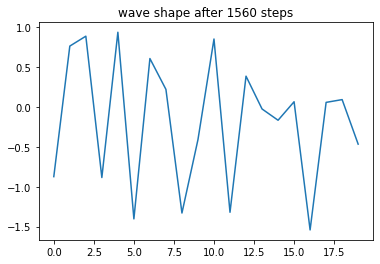

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/G_1560/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11-hist-avg/2021-03-31-10-54-36/D_1560/model_weights.tf
generator loss:1.2242714161617145
-----------------------
total discriminator loss:0.46288813914320237
average true return:0.5777183285142284
-----------------------


100%|█████████▉| 1561/1562 [3:06:47<00:06,  6.50s/it]

Training Step: 1561
generator loss:1.2913084273257063
-----------------------
total discriminator loss:0.43314027319950377
average true return:0.564557905038471
-----------------------


100%|██████████| 1562/1562 [3:06:49<00:00,  7.18s/it]


In [63]:
historical_avg = HistoricalAvgLoss(G)
for feature_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    print('Training Step:', step)
    
    if step % 5 == 0:
        _mad_score, _fid_score, _rule_score = track_training(step, G, model_save_path, verbose=True, plot=True)
        mad_history.append(_mad_score)
        fid_history.append(_fid_score)
        rule_history.append(_rule_score)
        
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator_gumbel(G, D, BATCH_SIZE, T, verbose=True, optimizer=G_optimizer, 
                                          loss_obj=historical_avg_G)
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator_gumbel(event_type_batch, time_delta_batch, G, D, BATCH_SIZE, T,
                                                                verbose=True, optimizer=D_optimizer, 
                                                                label_smoothing=True, label_flipping=True,
                                                                loss_obj=historical_avg_D)
        disc_loss_history.append(disc_loss.numpy())
        average_true_return_history.append(ave_true_return.numpy())
                
    step += 1

In [ ]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

In [ ]:
x =  [i * 5 for i in range(len(mad_history))]
plt.figure(dpi=100)
plt.plot(x, mad_history)
plt.title('MAD score History')
plt.xlabel('Training steps')

x =  [i * 5 for i in range(len(fid_history))]
plt.figure(dpi=100)
plt.plot(x, fid_history)
plt.title('Fid score History')
plt.xlabel('Training steps')
plt.ylim([0, 30000])

x =  [i * 5 for i in range(len(rule_history))]
plt.figure(dpi=100)
plt.plot(x, rule_history)
plt.title('Rule score History')
plt.xlabel('Training steps')

## Compare between G0, G1 and G2

In [ ]:
from matplotlib import pyplot as plt

def get_generation_metrics(G):
    _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(N_DATA, G, BATCH_SIZE, T)

    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))    

    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _smad_score = calculate_self_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)
    
    return {'mad' : _mad_score, 'fid' : _fid_score, 'oracle' : _rule_score, 'smad' : _smad_score}

In [ ]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

res0 = get_generation_metrics(G0)

In [ ]:
G1 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
G1_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_0/model_weights.tf'
G1.build(input_shape=((BATCH_SIZE, T, 1)))
G1.load_weights(G1_save_path)

res1 = get_generation_metrics(G1)

In [ ]:
G2 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
G2_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_400/model_weights.tf'
G2.build(input_shape=((BATCH_SIZE, T, 1)))
G2.load_weights(G2_save_path)

res2 = get_generation_metrics(G2)

In [ ]:
res = [res0, res1, res2]

df = pd.DataFrame(res)
df.index = pd.Index(['INIT', 'MLE', 'GAN'])
df

## Generate Synthesized data

In [ ]:
repo_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
save_path = os.path.join(repo_path, 'syn_data', 'gumbel_softmax_2021-03-30-09-39-43', 'G2')

In [ ]:
def generate_sequence_for_saving(generator, N, save_path):
    _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(N, generator, BATCH_SIZE, T)
    # convert one-hot event types to indices; convert normalized timestamps to original
    _save_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N, T, 1)
    _save_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD).numpy().reshape(N, T, 1)
    
    seqs_filename_et = 'syn_type_sequences.pickle'
    seqs_filename_ts = 'syn_time_sequences.pickle'
    
    with open(os.path.join(save_path, seqs_filename_et), 'wb') as f:
        pickle.dump(_save_seqs_et_ind, f)

    with open(os.path.join(save_path, seqs_filename_ts), 'wb') as f:
        pickle.dump(_save_seqs_ts_ori, f)

In [ ]:
save_path_G0 = os.path.join(repo_path, 'syn_data', 'gumbel_softmax_2021-03-30-09-39-43', 'G0')
generate_sequence_for_saving(G0, 400000, save_path_G0)

In [ ]:
save_path_G1 = os.path.join(repo_path, 'syn_data', 'gumbel_softmax_2021-03-30-09-39-43', 'G1')
generate_sequence_for_saving(G1, 400000, save_path_G1)

In [ ]:
_gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(400000, G2, BATCH_SIZE, T)

In [ ]:
# convert one-hot event types to indices; convert normalized timestamps to original
_save_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(400000, T, 1)
_save_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD).numpy().reshape(400000, T, 1)

In [ ]:
pos_seqs_filename_et = 'syn_type_sequences.pickle'
pos_seqs_filename_ts = 'syn_time_sequences.pickle'


with open(os.path.join(save_path, pos_seqs_filename_et), 'wb') as f:
    pickle.dump(_save_seqs_et_ind, f)
    
with open(os.path.join(save_path, pos_seqs_filename_ts), 'wb') as f:
    pickle.dump(_save_seqs_ts_ori, f)

In [ ]:
tf.random.normal((2,1),mean=0, stddev=1)

In [ ]:
save_path